In [15]:

import sys
print(sys.executable)
print(sys.version)
print(sys.version_info)

import math
import astropy
print('astropy',astropy.__version__ )
from spectral_cube import SpectralCube      # This is a handy package for working with 3D data cubes

from astropy.coordinates import SkyCoord
from reproject import reproject_interp      
from reproject.mosaicking import find_optimal_celestial_wcs 
import regions
import reproject
print('reproject',reproject.__version__)
import spectral_cube
print('spectral_cube',spectral_cube.__version__)
import numpy as np                          
import pylab                                
import matplotlib 
import matplotlib.gridspec as gridspec                                                                                             
import scipy
import astropy.io.fits as fits                                                          
from astropy.wcs import WCS                 
from astropy import units as u              
import pyspeckit as psk   
import astrodendro
import matplotlib.colors as colors
from matplotlib import pyplot as plt
# Suppress warnings we don't care about:
import sys
import gc
import mpdaf
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
%matplotlib inline
from astrodendro.analysis import PPVStatistic


print(astrodendro.__file__)

from matplotlib.patches import Ellipse
#%matplotlib widget

/home/ben/miniconda3/bin/python
3.8.5 (default, Sep  4 2020, 07:30:14) 
[GCC 7.3.0]
sys.version_info(major=3, minor=8, micro=5, releaselevel='final', serial=0)
astropy 5.1.dev153+gb740594dc
reproject 0.8
spectral_cube 0.6.1.dev22+g003ef16
/home/ben/.local/lib/python3.8/site-packages/astrodendro/__init__.py


Clean Notebook for NGC253

Featuring:

NOT HCO+ 4-3
HCN 4-3
H13CN 4-3

HCN_J1-0
HCO+_J1-0
H13CO+_J1-0

NOT _and_SiO_J2-1
H13CN_J1-0
CO_J3-2

NOR
CCH_N1-0
HC3NJ11-10

Part 1: Updates

Part 2: File Reads, Integrated Maps

Part 3: Image Ratios

Part 4: Channel Maps

Part 5: PV Plots

Part 6: Reporojection

Part 7: Spectra

Part 8: Dendograms

# Part 1: Updates

In [96]:

#!py -m pip uninstall astropy
#!py -m pip install git+https://github.com/astropy/astropy

'''


!py -m pip install git+https://github.com/radio-astro-tools/spectral-cube.git
!py -m pip install reproject
!py -m pip install git+https://github.com/radio-astro-tools/spectral-cube.git 
!py -m pip install pyspeckit
!py -m pip install regions
!py -m pip install astrodendro
!py -m pip  install wcsaxes 
!py -m pip  install ipympl
!py -m pip install dask
!py -m pip install radio_beam
!py -m pip install casa_formats_io
#try:
#    !pip install casa_formats_io --no-binary :all:
#except:
#    !pip install casa_formats_io --no-cache --no-binary :all:

!py -m pip  install spectral_cube 
!py -m pip  install typing 
!py -m pip install mypy
!py -m pip  install typing_extensions 
'''
#!pip install mpdaf


Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 59.7 MB 11.1 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [16]:
path = 'HCOp_J1-0.cube.fits'

#path = "HC3N_11_10.fits"

scP = SpectralCube.read(path)
sc = scP.with_spectral_unit(u.km/u.s,velocity_convention="radio")
scW = sc.wcs[:][:][0]

raDP1 = scW.pixel_to_world(0,0)
raDP2 = scW.pixel_to_world(1,1)

a=(raDP1)
b=(raDP2)
print(a)
print(b)

vel,NA,na = sc.world[:,0,0]

#too accurate?
#50 mili arcseconds

header5 = sc.header
beam5_a = header5["BMAJ"]*3600.0 # beam sizes in arcseconds
beam5_b = header5["BMIN"]*3600.0
pixel5 = header5["CDELT1"] * (-1)*3600.0

#print(sc.statistics())
print(header5)

print(abs(header5["CDELT3"]))

<SkyCoord (ICRS): (ra, dec) in deg
    (11.89358248, -25.29378852)>
<SkyCoord (ICRS): (ra, dec) in deg
    (11.89357296, -25.29377991)>
SIMPLE  =                    T /Standard FITS                                   BITPIX  =                  -32 /Floating point (32 bit)                         NAXIS   =                    3                                                  NAXIS1  =                 1221                                                  NAXIS2  =                 1221                                                  NAXIS3  =                  180                                                  EXTEND  =                    T                                                  BSCALE  =   1.000000000000E+00 /PHYSICAL = PIXEL*BSCALE + BZERO                 BZERO   =   0.000000000000E+00                                                  BMAJ    =   6.959081736003E-05                                                  BMIN    =   5.108453740925E-05                                  

In [34]:



#path = 'H8_continuum.pbcor.fits'
#path = "ADP.2016-01-20T15:35:07.077.fits"

paths = pylab.array(['Fixed_cmz_HCOp.cube.K-kms.pbcor.fits','Fixed_cmz_HCN.cube.reproject.K-kms.pbcor.fits','Fixed_cmz_H13CN.cube.reproject.K-kms.pbcor.fits','Fixed_cmz_H13COp.cube.reproject.K-kms.pbcor.fits',"Fixed_Spliced_CO_V2.fits"])
path = paths[1]
#Best
#path="12CO_GC_001-002_mosaic.fit"
#path="12CO_GC_359-000_mosaic.fit"
#path='CMZ_CO_3_2_Left.cube.reproject.K-kms.pbcor.fits'
#path='CMZ_CO_3_2_Right.cube.reproject.K-kms.pbcor.fits'
#path='Spliced_CO_V2.fits'
cube = SpectralCube.read(path) #Load the important axes
cheader = fits.getheader(path)  
print(cheader)
print(cube[0][0][0])
w1 = WCS(cheader) 
w1 = w1.dropaxis(2)#Get rid of the different slices

cube.allow_huge_operations=True
scW = cube.wcs[:][:][0]
print((scW.pixel_to_world(0,0)))
print((scW.pixel_to_world(765,165)))
print(np.shape(cube))
scWCS = cube.wcs[:][:][0]
########
fig1 = pylab.figure(1,figsize=(60,60))
######Moment 0 and Max map
#print(cube[0][0])
moment_0_sub=cube.moment0()
ax3 = pylab.subplot(3,3,1,projection=scWCS) 
RA = ax3.coords[0]                                                                  # 
Dec = ax3.coords[1]

print(moment_0_sub[0][0])
im3 = pylab.imshow(moment_0_sub.hdu.data,vmin=0,vmax=np.nanmax(moment_0_sub.hdu.data)*.5,cmap='rainbow')
center = SkyCoord('01d48m00s','-00d13m00s', frame='galactic')
y,x = [int(scWCS.world_to_pixel(center)[0]),int(scWCS.world_to_pixel(center)[1])]
pylab.plot(y,x,'+',ms=7,mec='black',mfc='black',mew=2,alpha=.5)
center = SkyCoord('0359d17m00s','00d08m00s', frame='galactic')
y,x = [int(scWCS.world_to_pixel(center)[0]),int(scWCS.world_to_pixel(center)[1])]
pylab.plot(y,x,'+',ms=7,mec='black',mfc='black',mew=2,alpha=.5)
pylab.annotate("Center",(y,x+16))
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Long',fontsize=20,labelpad=1)                               
pylab.ylabel('Lat',fontsize=20,labelpad=0)
ax3.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im3,fraction=0.02,pad=0.04)                                     
cb.set_label(label='Integrated Flux Density Center(K km/s)',fontsize=10,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)   
pylab.annotate(s='Moment 0 u',fontsize=20,xy=(0.02,0.91),xycoords="axes fraction")  


SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                  -32 / array data type                                NAXIS   =                    3 / number of array dimensions                     NAXIS1  =                  765                                                  NAXIS2  =                  165                                                  NAXIS3  =                  332                                                  BLANK   =                   -1  /                                               BUNIT   = 'K       '  /                                                         CELLSCAL= 'CONSTANT'  /                                                         RESTFREQ=    8.86318473000E+10  /                                               BMAJ    =    1.08300000429E-02  /                                               BMIN    =    1.08300000429E-02  /                                               DATAMIN =   -3.23498272896E+00  /       

Text(0.02, 0.91, 'Moment 0 u')

In [63]:
#Continuum
#path='ngc253_850_micron_dust.fits'
path ="ADP.2016-01-20T15:35:07.077.fits"
#path = 'HCOp_J1-0.cube.fits'
path='CMZ_Continuum_Splice.fits'
scP = spectral_cube.Projection.from_hdu(fits.open(path)[0])
#scP = SpectralCube.read(path)
print(scP[0][0])
header = scP.hdu.header
#scP = cube.apply_numpy_function(np.nansum,axis=0) #Load the important axes
scWCS = scP.wcs[:][:]
scW= scWCS
bp=np.where(scP<=0)
scP[bp]=np.nan
#print(scP.hdu.header)


print(np.shape(scP))
#make metadata for the dendrogram

metadata = {}
metadata['data_unit'] = u.Jy / u.beam
metadata['arc_per_pix_y'] =  abs(header["CDELT1"]*3600.0 * u.arcsec)/u.pix
metadata['arc_per_pix_x'] =  abs(header["CDELT2"]*3600.0 * u.arcsec)/u.pix
metadata['beam_major'] =  header["BMAJ"]*3600.0 * u.arcsec
metadata['beam_minor'] =  header["BMIN"]*3600.0 * u.arcsec
metadata['spatial_scale'] = abs(header["CDELT1"])*u.degree
beam_area_ratio = metadata['beam_minor']*metadata['beam_major']/metadata['arc_per_pix_y']/metadata['arc_per_pix_x'] 

#scP.to(u.Jy)
print(scP[0][0])
scP = scP/beam_area_ratio*u.beam*u.pix**2#Beam area ratio is pix**2/beam
print(scP[0][0])
#scW = scP.wcs


print(np.shape(scP))
print(scP[0][0])

subcube = scP[:][:]#[raDP1[1]:raDP2[1],raDP1[0]:raDP2[0]] # Make a subcube


subcube.allow_huge_operations=True






########


fig1 = pylab.figure(1,figsize=(15,15))


######Moment 0 and Max map

ax3 = pylab.subplot(2,2,1,projection=scWCS) 
RA = ax3.coords[0]                                                                  # 
Dec = ax3.coords[1]
im3 = pylab.imshow(scP.hdu.data,cmap='rainbow')
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('GLong',fontsize=20,labelpad=1)                               
pylab.ylabel('GLat',fontsize=20,labelpad=0)
ax3.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im3,fraction=0.046,pad=0.04)                                     
cb.set_label(label='Jy',fontsize=10,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)   
pylab.annotate(s='cont+',fontsize=20,xy=(0.02,0.91),xycoords="axes fraction")  


ax3.set_title("cont+")

#fig1.savefig(bbox_inches='tight',fname="NGC253_HCO+_4-3_Integrated_Full_Note.jpeg")


-0.038981941689097646 Jy / beam
(165, 765)
nan Jy / beam
nan Jy
(165, 765)
nan Jy


Text(0.5, 1.0, 'cont+')

# Part 8: Dendograms

0.04673030894656108 0.04673030894656108 nan cmz_HCOp.cube.K-kms.pbcor.fits
() 0.04673030894656108 (166, 20, 25)
0.0521674819327987 0.0521674819327987 nan cmz_HCN.cube.reproject.K-kms.pbcor.fits
() 0.0521674819327987 (166, 20, 25)
0.0372615370419953 0.0372615370419953 nan cmz_H13CN.cube.reproject.K-kms.pbcor.fits
() 0.0372615370419953 (166, 20, 25)
0.035991421159583294 0.035991421159583294 nan cmz_H13COp.cube.reproject.K-kms.pbcor.fits
() 0.035991421159583294 (166, 20, 25)
0.6261983184086268 0.6261983184086268 nan Spliced_CO_V2.fits
() 0.6261983184086268 (166, 20, 25)
5 5 0 5
(3, 3411573)
166
(3, 3925461)
166
(3, 1994863)
166
(3, 2156759)
166
(3, 3794025)
166
(166, 165, 765)
(166, 165, 765)


Text(0.02, 0.91, 'Confidence')

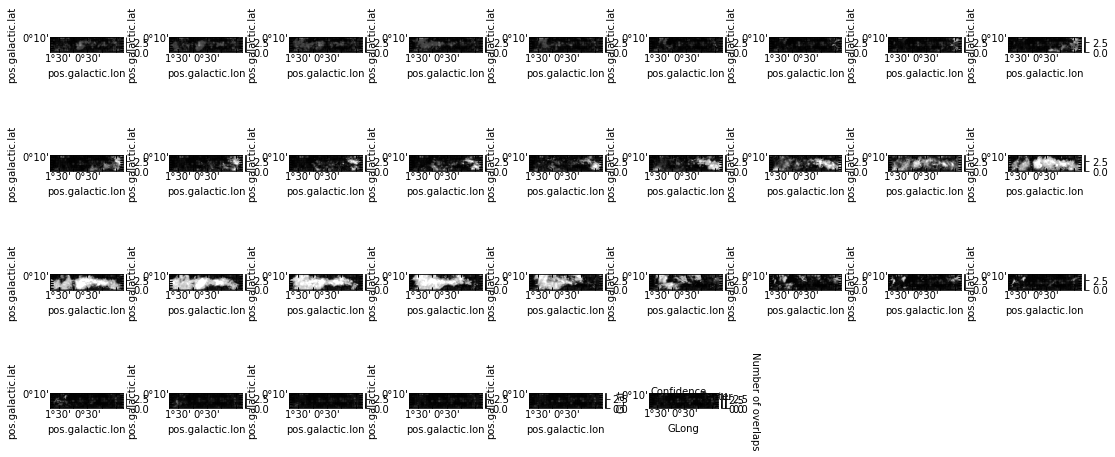

In [20]:
#Create a mask for all the cubes. 

###################No #If there is another cube that shares at least 67% of the structure, a structure is not to be masked.

#If there are multiple pixels that have greater than 3 sigma emission we will keep them (at most  (1-.95)**2 chance of incorrect label)

#Assign greater confidence to more overlaps




paths = pylab.array(['Fixed_cmz_HCOp.cube.K-kms.pbcor.fits','Fixed_cmz_HCN.cube.reproject.K-kms.pbcor.fits','Fixed_cmz_H13CN.cube.reproject.K-kms.pbcor.fits','Fixed_cmz_H13COp.cube.reproject.K-kms.pbcor.fits',"Fixed_Spliced_CO_V2.fits"])



FP = pylab.array(['CMZ_3mm_HCO+.fits','CMZ_3mm_HCN.fits','CMZ_3mm_H13CN.fits','CMZ_3mm_H13CO+.fits',"Spliced_CO_V2.fits" ])





SCWs=[]
cds=[]
Ns = [] #get sigmas for all cubes
Absorbtion_mask="No"

#Find noises for first cubes
for i in range(len(FP)):
    sc = SpectralCube.read(paths[i])#FP[i])  
    
    sc_kms = sc.with_spectral_unit(u.km/u.s,velocity_convention="radio") # Change units from Hz to km/s
    
    sc_slabP = sc_kms.spectral_slab(-300. *u.km / u.s, 300. *u.km / u.s)  # Crop out velocities we don't care about    
    
    sc_slabP.allow_huge_operations=True    
    
    sc_slab = sc_slabP.downsample_axis(2,axis=0)
    
    sc_slab.allow_huge_operations=True    
    
    sc_K_kms = sc_slab.to(u.K)
    
    scW = sc_K_kms.wcs[:][:][0]

    #Find Noise 
    Np1 = SkyCoord('359d40m00s',  '00d04m00s', frame='galactic')#These are away from the sources
    Np2 = SkyCoord('359d35m00s','00d08m00s', frame='galactic')
    
    
    NraDP1 = [int(scW.world_to_pixel(Np1)[0]),int(scW.world_to_pixel(Np1)[1])]
    NraDP2 = [int(scW.world_to_pixel(Np2)[0]),int(scW.world_to_pixel(Np2)[1])]
    
        
    
    no = 3
    m=0
    while(True):

        Q = sc_K_kms[int(len(sc_K_kms)-no):len(sc_K_kms),:,:]#NraDP1[1]:NraDP2[1],NraDP1[0]:NraDP2[0]] # Make a subcube away from the signals
        #Nsc1 = Q.unmasked_copy()
        
        Nsc1 = sc_K_kms[0:335,NraDP1[1]:NraDP2[1],NraDP1[0]:NraDP2[0]] # Make a subcube away from the signals
        #print(np.shape(Nsc1))
        if(Absorbtion_mask=="Yes"):
            bp = np.where(Nsc1.hdu.data<0)
            Nsc1.hdu.data[bp]=np.nan
        #print((Nsc1[0]))
            
        #Find StandardDev of this noise cube
        #m=Nsc1.std(axis=0)/u.K
        m=np.nanmean(np.nanstd(Nsc1.hdu.data,axis=0))#RMS noise over all channels
        #print(m)
        no+=1
        if(float(np.nanmax(m))!=0.0 and str(float(np.nanmax(m))) != str(np.nan)):
            print(float(np.nanmax(m)),str(float(np.nanmax(m))), str(np.nan),paths[i])
            break
            
    print(np.shape(m),m,np.shape(Nsc1))
    
    Ns.append(m)
    
#Find noises for pre-masked cubes

'''
for i in range(len(FP)-3,len(FP)):
    sc = SpectralCube.read(FP[i])  
    
    sc_kms = sc.with_spectral_unit(u.km/u.s,velocity_convention="radio") # Change units from Hz to km/s
    
    sc_slab = sc_kms.spectral_slab(-500. *u.km / u.s, 1000. *u.km / u.s)  # Crop out velocities we don't care about    
    sc_slab.allow_huge_operations=True    
    
    sc_K_kms = sc_slab.to(u.K)
    
    scW = sc_K_kms.wcs[:][:][0]

    #Find Noise. Should be the minimum value since it must be at least 3 sigma to be unmasked
    
    Nsc1 = sc_K_kms.unmasked_copy()
    
    
    bp = np.where(Nsc1.hdu.data<=0)
    
    Nsc1.hdu.data[bp]=np.nan
    m=np.nanmin(Nsc1)/u.K
    print(m,np.shape(Nsc1))
    Ns.append(m)
'''  
    
#print(Ns)

for i in range(1):
    cubeP=SpectralCube.read(paths[i])
    
    cubeP.allow_huge_operations=True
    
    cube = cubeP.downsample_axis(2,axis=0)
    
    #print(cube.hdu.header)
    #print(cube.max(axis=0)[0][0]/u.K,Ns[i][0][0])
    #spatial_mask = cube.max(axis=0)/u.K > 3*Ns[i]        
    
    #cubeM = cube.with_mask(spatial_mask)
    #print(np.shape(cube),np.shape(cubeM))
    cd = cube.hdu.data
    #cds.append(cd)
    #print(len(cds))
    #SCWs.append(cube.wcs[:][:][0])

Confidences=cd
Abs_Mask=cd
pix = np.where(Confidences != 0)
Confidences[pix] = 0 
Abs_Mask=np.copy(Confidences)
H13CN_MASK = np.copy(Confidences) 
H13COP_MASK = np.copy(Confidences) 
#print(Confidences.shape)
print(len(paths),len(FP),len(cds),len(Ns))

for i in range(len(paths)):
    cube=SpectralCube.read(paths[i]).downsample_axis(2,axis=0)
    
    cd = cube.hdu.data
    if(Absorbtion_mask=="No"):
        GP = np.where(abs(cd)>Ns[i]*2)#No abs for only emission
    if(Absorbtion_mask=="Yes"):
        GP = np.where(cd>Ns[i]*2)#No abs for only emission
    NP = np.where(cd<0)  
    if(i ==0):
        H13COP_MASK[GP] = 1#Mask for H13CO, only using HCO as a mask
        np.save('H13COP_MASK',H13COP_MASK)
    if(i ==1):
        H13CN_MASK[GP] = 1#Mask for H13CN, only using HCN as a mask
        np.save('H13CN_MASK',H13CN_MASK)

    print(np.shape(GP))
    print(len(Confidences))
    Confidences[GP]+=1
    Abs_Mask[NP]+=1

print(Confidences.shape)


   
print(Confidences.shape)

#Create a plot of all the confidence values

fig1 = pylab.figure(1,figsize=(15,15))


######Moment 0 and Max map
#print(SCWs[0])
#print(Confidences.shape)0
for n in np.arange(0,int(len(Confidences)/5)):   
    
    # Now we loop through each slice (averaged channels) 
    #ax = pylab.subplot(5,5,n+1,projection=wcsU) # We plot them in a grid    
    ax = pylab.subplot(9,9,n+1,projection=scW) # We plot them in a grid    
    #im = pylab.imshow(SC_CM.hdu.data[n],cmap='gray',vmin=0,vmax=m*8)
    RA = ax.coords[0]                                                                  # 
    Dec = ax.coords[1]
    RA.set_ticks(size=-3)                                                                                      
    Dec.set_ticks(size=-3) 
    RA.set_ticklabel(exclude_overlapping=True) 
    Dec.set_ticklabel(exclude_overlapping=True)
    im = pylab.imshow(np.nanmean(Confidences[n*5:5*n+5],axis=0),cmap='gray',vmin=0,vmax=4)
    cb=pylab.colorbar(im,fraction=0.01,pad=0.04)  
    pylab.tight_layout(w_pad=2,h_pad=1)

'''
ax = pylab.subplot(1,1,1,projection=SCWs[0]) 
RA = ax.coords[0]                                                                  # 
Dec = ax.coords[1]
im = pylab.imshow(Confidences[int(len(Confidences)*.5)],cmap='rainbow')
'''

np.save('Confidence_data_CMZ',Confidences)

np.save('Noises_K_CMZ',Ns)

np.save('Absorption_Pixels_CMZ',Abs_Mask)
#Define common structures

center = SkyCoord(l=359.94487501*u.degree,b=-00.04391769*u.degree, frame='galactic')
y,x = [int(scW.world_to_pixel(center)[0]),int(scW.world_to_pixel(center)[1])]
pylab.plot(y,x,'+',ms=7,mec='black',mfc='black',mew=2,alpha=.5)
pylab.annotate("Center",(y,x+16))
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('GLong',fontsize=10,labelpad=1)                               
pylab.ylabel('GLat',fontsize=10,labelpad=0)
ax.tick_params(axis = 'both', which = 'major', labelsize = 10)    
cb=pylab.colorbar(im,fraction=0.01,pad=0.04)                                     
cb.set_label(label='Number of overlaps',fontsize=10,rotation=270,labelpad=15) 
cb.ax.tick_params(which = 'major', labelsize = 10)   
pylab.annotate(s='Confidence',fontsize=10,xy=(0.02,0.91),xycoords="axes fraction")  



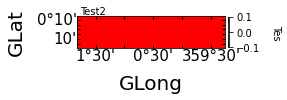

In [7]:

#Create a function that uses the dendrogram input to calculate all the quantities, and has the size and linewidth requirements of the Shetty paper
#Requires the computed dendrogram, the data from the line image, the velocity axis, and the data from the Continuum image, as well as metadata for the structures
#Finds Size, Linewidth, Luminosity, and Column Density of a structure for each structure and returns them in [[][]] arrays [Leaves][Branches]
#Continuum is in Jansky/Beam, Line data should have the unit specified in the metadata as 'data_unit'
#vel,RA,Dec = scF.world[:,0,0]
def Dendro_Arrays(Dendrogram,LineData,DataVel,ContData,metadata,Dust=True):
    SizeA,SigmaA,LuminA,CDA,SIDS,MOM0_FLUX = [[],[]],[[],[]],[[],[]],[[],[]],[[],[]],[[],[]]
    
    center = SkyCoord(l=359.94487501*u.degree,b=-00.04391769*u.degree, frame='galactic')
    x,y = [metadata["Cwcs"].world_to_pixel(center)[0],(metadata["Cwcs"].world_to_pixel(center)[1])]

    for t in Dendrogram.all_structures: 

        I = t.indices()
        Cont = True
        try:
            if(str(t.descendants[0]).find("branch") != -1):
                Cont = False #If we find a branch inside this structure t, then it is at least order two and will be discarded
        except:
            lop=12

        if(Cont):
            s = PPVStatistic(t,metadata=metadata)
            nproj_pix=len(set(zip(*tuple(I[i] for i in [1,2]))))
            #print(nproj_pix,(set(zip(*tuple(I[i] for i in [1,2])))))
            v_IWM = np.nansum(LineData[I]*DataVel[I[0]]/u.km*u.s)/np.nansum(LineData[I])
            sig_Sh = np.sqrt(np.nansum(LineData[I]*(DataVel[I[0]]/u.km*u.s-v_IWM)**2)/np.nansum(LineData[I])) 
            x_cent = s.x_cen/u.pix
            y_cent = s.y_cen/u.pix

            d0 = 8.178 *10**-3*u.Mpc #mpc
            D_E = d0/u.Mpc#np.sqrt(d0**2 + (d0*np.tan(u.rad*metadata['arc_per_pix']*(np.sqrt((x_cent-x)**2+(y_cent-y)**2))/3600*np.pi/180/u.arcsec*u.pix))**2 )/u.Mpc
            area_res=metadata["ARND"]*(np.pi/180*D_E)**2
            #pc_per_pixelc = abs(scCont.hdu.header["CDELT1"])/180*np.pi*D_E/u.Mpc

            #Require size greater than the beam and velocity greater than the spectral resolution
            #print(sig_Sh,metadata["velocity_scale"]*u.s/u.km , ((np.sqrt(nproj_pix/np.pi))),np.sqrt(metadata['beam_area_ratio'])/u.pix,((np.sqrt(nproj_pix*area_res/np.pi)))*10**6 )
            #print(s.radius,area_res,metadata['beam_area_ratio'])
            #if(sig_Sh>metadata["velocity_scale"]*u.s/u.km and ((np.sqrt(nproj_pix/np.pi)))>np.sqrt(metadata['beam_area_ratio'])/u.pix and ((np.sqrt(nproj_pix*area_res/np.pi)))*10**6 <24):
            #if(sig_Sh>metadata["velocity_scale"]*u.s/u.km and (s.radius*np.pi/180*D_E/u.deg)>np.sqrt(metadata['beam_area_ratio']*area_res)/u.pix and (s.radius*np.pi/180*D_E/u.deg)*10**6<24):
            #If I require the radius to be larger than the beam I miss the clusters with this definition
            if(sig_Sh*(s.radius*3600/metadata['arc_per_pix_x']*u.deg/u.arcsec)**2*np.pi>3*metadata["velocity_scale"]*u.s/u.km*metadata['beam_area_ratio'] and (s.radius*np.pi/180*D_E/u.deg)*10**6<24 and sig_Sh>metadata["velocity_scale"]*u.s/u.km):
                if Dust==True:
                    #The flux from the continuum
                    #Convert to Jansky from Jansky per beam:
                    Cont_Flux=0

                    proj = tuple(set(zip(*tuple(I[i] for i in [1,2]))))
                    #print(x_cent,y_cent,proj)
                    for lmi in range(len(proj)):

                        Cont_Flux+=ContData[proj[lmi]]
                    Cont_Flux=Cont_Flux/(metadata['beam_area_ratioc']*(2*np.sqrt(2*np.log(2))))*u.pix**2*u.beam/u.beam*u.Jy#SHould be input as Jansky /beam and will be converted to Jansky, then to unitless. The beam is changed from FWHM to Gaussian

                    
                    Dust_Column = Flux_to_Mass(Cont_Flux,metadata,D_E=D_E*u.Mpc)*Num_per_kg/((s.radius*np.pi/180*D_E/u.deg)**2*(3.086*10**24)**2)/np.pi*(1.989*10**30*u.kg/u.M_sun)/u.kg
                else:
                    Dust_Column=1
                lum = Flux_to_Lum(s.flux,metadata,D_E=D_E*u.Mpc)

                #Flux from the strcuture
                s_flux = s.flux
                #print(s_flux)
                #print(s_flux/Cont_Flux,s_flux,Cont_Flux)
                #FR = s_flux/Cont_Flux

                #Line_Mass=Flux_to_Mass(freq,s_flux)/u.Hz/u.mJy/u.s/u.solMass*u.erg
                #Dust_Mass=Flux_to_Mass(freqC,Cont_Flux)#/u.Hz/u.mJy/u.s/u.solMass*u.erg
                #Dust_Column = Flux_to_Mass(Cont_Flux,metadata,D_E=D_E*u.Mpc)*Num_per_kg/(np.sqrt(nproj_pix*(area_res)/np.pi)**2*(3.086*10**24)**2)/np.pi*(1.989*10**30*u.kg/u.M_sun)/u.kg

                #print(s_flux/Dust_Column)#,Line_Mass,Dust_Mass)
                #print(Dust_Column,area_res,Cont_Flux)
                Index = tuple(I[i] for i in [0,1,2])
                K_Km_s_Flux=np.nansum(LineData[Index]*metadata["velocity_scale"])#Find the total flux from the structures in K km/s, assuming the input data is in K as it should be
                    
                #print(K_Km_s_Flux)
                #Line_N = (Line_Mass/float(np.sqrt(nproj_pix*(area_res)/np.pi))/u.Mpc).to(u.kg)
                if(t.is_leaf):
                    #SizeA[0].append((float(np.sqrt(nproj_pix*(area_res)/np.pi)))) #define size as shetty does
                    SizeA[0].append((float((s.radius*np.pi/180*D_E/u.deg)))) #define size as astrodendro
                    SigmaA[0].append((float(sig_Sh)))#
                    CDA[0].append(float(Dust_Column))
                    LuminA[0].append(float(lum*u.Hz*u.s/u.erg))
                    SIDS[0].append(float(t.idx))
                    MOM0_FLUX[0].append(float(K_Km_s_Flux*u.s/u.km))
                if(t.is_branch	):
                    #SizeA[1].append((float(np.sqrt(nproj_pix*(area_res)/np.pi)))) #define size as shetty does
                    SizeA[1].append((float((s.radius*np.pi/180*D_E/u.deg)))) #define size as astrodendro
                    SigmaA[1].append((float(sig_Sh)))#
                    CDA[1].append(float(Dust_Column))
                    LuminA[1].append(float(lum*u.Hz*u.s/u.erg))
                    SIDS[1].append(float(t.idx))
                    MOM0_FLUX[1].append(float(K_Km_s_Flux*u.s/u.km))
    SizeA[0] = np.array(SizeA[0])
    SizeA[1] = np.array(SizeA[1])
    SigmaA[0] = np.array(SigmaA[0])
    SigmaA[1] = np.array(SigmaA[1])
    CDA[0] = np.array(CDA[0])
    CDA[1] = np.array(CDA[1])
    LuminA[0] = np.array(LuminA[0])
    LuminA[1] = np.array(LuminA[1])
    SIDS[0] = np.array(SIDS[0])
    SIDS[1] = np.array(SIDS[1])
    MOM0_FLUX[0] = np.array(MOM0_FLUX[0])
    MOM0_FLUX[1] = np.array(MOM0_FLUX[1])
    
    return np.array(SizeA),np.array(SigmaA),np.array(CDA),np.array(LuminA),np.array(SIDS),np.array(MOM0_FLUX)

#Make a function to make an image 

#Data to plot, minimum of color bar, maximum, WCS projection for coords, and position of the image in the larger figure
def Make_Plot(Name,Name2,Data,vmin,vmax,WCS,rows,columns,index,show):
    
    axA = np.empty((rows,columns),dtype = type(pylab.subplot(1,1,1,projection=WCS)))
    ax = pylab.subplot(rows,columns,index,projection=WCS) 
    RA = ax.coords[0]                                                                  # 
    Dec = ax.coords[1]
    im = pylab.imshow(Data,vmin=vmin,vmax=vmax,cmap='rainbow')
    RA.set_ticks(size=-3)                                                                                      
    Dec.set_ticks(size=-3) 
    RA.set_ticklabel(exclude_overlapping=True) 
    Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
    pylab.xlabel('GLong',fontsize=20,labelpad=1)                               
    pylab.ylabel('GLat',fontsize=20,labelpad=1)
    ax.tick_params(axis = 'both', which = 'major', labelsize = 15)    
    cb=pylab.colorbar(im,fraction=0.01,pad=0.02)                                     
    cb.set_label(label=Name,fontsize=10,rotation=270,labelpad=20) 
    cb.ax.tick_params(which = 'major', labelsize = 10)   
    pylab.annotate(s=Name2,fontsize=10,xy=(0.02,1.05),xycoords="axes fraction")  
    if(show==True):
        pylab.show()
def Make_Plot_Anno(Name,Name2,Data,vmin,vmax,WCS,rows,columns,index,show,pos1,pos2):
    
    axA = np.empty((rows,columns),dtype = type(pylab.subplot(1,1,1,projection=WCS)))
    ax = pylab.subplot(rows,columns,index,projection=WCS) 
    RA = ax.coords[0]                                                                  # 
    Dec = ax.coords[1]
    im = pylab.imshow(Data,vmin=vmin,vmax=vmax,cmap='rainbow')
    RA.set_ticks(size=-3)                                                                                      
    Dec.set_ticks(size=-3) 
    RA.set_ticklabel(exclude_overlapping=True) 
    Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
    pylab.xlabel('GLong',fontsize=20,labelpad=1)                               
    pylab.ylabel('GLat',fontsize=20,labelpad=1)
    ax.tick_params(axis = 'both', which = 'major', labelsize = 15)    
    cb=pylab.colorbar(im,fraction=0.016,pad=0.04)                                     
    cb.set_label(label=Name,fontsize=10,rotation=270,labelpad=20) 
    cb.ax.tick_params(which = 'major', labelsize = 10)   
    pylab.annotate(s=Name2,fontsize=10,xy=(pos1,pos2),xycoords="axes fraction")  
    if(show==True):
        pylab.show()
        
        
#Put this up here for the column density map
def Flux_to_Mass(flux,metadata,D_E="NO",D_Name="Pixel_D.npy"):
    
    
    center = SkyCoord(l=359.94487501*u.degree,b=-00.04391769*u.degree, frame='galactic')
    x,y = [metadata["Cwcs"].world_to_pixel(center)[0],(metadata["Cwcs"].world_to_pixel(center)[1])]
    
    D_Es = np.load(D_Name)*u.Mpc
            
    
    
    
    J_to_e = 10**-23*u.erg/u.s/u.cm**2/u.Hz/u.Jy
    flux_erg = flux*J_to_e
    try:
        if(len(flux)>2):
            L = 4*np.pi*(D_Es*3.086*10**24*u.cm/u.Mpc)**2*flux_erg #Megaparsec is converted to cm
    except:
        
        L = 4*np.pi*(D_E*3.086*10**24*u.cm/u.Mpc)**2*flux_erg #Megaparsec is converted to cm
    
    
    

    
    a_850 = 6.7*10**19*u.erg/u.s/u.Hz/u.M_sun #6.7+-1.7
    
    aCO3_2 = 2.2*u.M_sun/u.pc**2/(u.K*u.km/u.s)#from nico
    aCO3_2 = aCO3_2*(3.086*10**18*u.cm/u.pc)**2#solar mass per cm^2 per K km/s
    M_mol = L/a_850#Just in Solar mass   *1.989*10**30*u.kg/u.M_sun#Determines mass of the cont for 850 in kg
    return M_mol
def Flux_to_Lum(flux,metadata,D_E="NO",D_Name="Pixel_D.npy"):
    
    
    center = SkyCoord(l=359.94487501*u.degree,b=-00.04391769*u.degree, frame='galactic')
    x,y = [metadata["Cwcs"].world_to_pixel(center)[0],(metadata["Cwcs"].world_to_pixel(center)[1])]
    
    D_Es = np.load(D_Name)*u.Mpc
    
    
    
    J_to_e = 10**-23*u.erg/u.s/u.cm**2/u.Hz/u.Jy
    flux_erg = flux*J_to_e
    try:
        if(len(flux)>2):
            L = 4*np.pi*(D_Es*3.086*10**24*u.cm/u.Mpc)**2*flux_erg #Megaparsec is converted to cm
    except:
        
        L = 4*np.pi*(D_E*3.086*10**24*u.cm/u.Mpc)**2*flux_erg #Megaparsec is converted to cm
    
    
    return L


def Find_Pixel_D(flux,metadata,sub = "Nope"):
    center = SkyCoord(l=359.94487501*u.degree,b=-00.04391769*u.degree, frame='galactic')
    
    x,y = [metadata["Cwcs"].world_to_pixel(center)[0],(metadata["Cwcs"].world_to_pixel(center)[1])]
    d0 = 8.178 *10**-3*u.Mpc #mpc
    D_Es = np.empty(np.shape(flux))
    for lmi in range(len(flux)):
        for lmj in range(len(flux[lmi])):
            #Find the distance to earth from every pixel
            #No longer do that, assume d0 for each pixel
            D_Es[lmi][lmj] = d0/u.Mpc#np.sqrt(d0**2 + (d0*np.tan(u.rad*metadata['arc_per_pix']*(np.sqrt((lmj-x)**2+(lmi-y)**2))/3600*np.pi/180/u.arcsec*u.pix))**2 )/u.Mpc#Has to be unitless so it saves, so bring the unit back when it is loaded
            
    #print(D_Es)
    if(sub=="Nope"):
        np.save("Pixel_D",D_Es)
    else:
        np.save(sub,D_Es)
pathCont = 'CMZ_Continuum_Splice.fits'
scCont = spectral_cube.Projection.from_hdu(fits.open(pathCont)[0])
scContW = scCont[30:np.shape(scCont)[0]-30,20:np.shape(scCont)[1]-20] # Make a subcube
metadata = {}
metadata["Cwcs"] = scContW.wcs
metadata["arc_per_pix"]= abs(scCont.hdu.header["CDELT1"]*3600.0 * u.arcsec)/u.pix

Find_Pixel_D(scContW.hdu.data,metadata)

#Return a cropped cube for some ra and dec, also crops the velocity axis if needed (0 for no crop)
def Crop(cube,WCS,Np1,Np2,BadVel,D2):
    NraDP1 = [int(WCS.world_to_pixel(Np1)[0]),int(WCS.world_to_pixel(Np1)[1])]
    NraDP2 = [int(WCS.world_to_pixel(Np2)[0]),int(WCS.world_to_pixel(Np2)[1])]
    if(D2==False):
        return cube[BadVel:np.shape(cube)[0]-BadVel,NraDP1[1]:NraDP2[1],NraDP1[0]:NraDP2[0]]
    if(D2==True):
        return cube[NraDP1[1]:NraDP2[1],NraDP1[0]:NraDP2[0]]
    
Make_Plot("Tes","Test2",Q.moment0().hdu.data,0,0,Q.wcs[:][:][0],2,2,1,True)
Make_Plot("Tes","Test2",Q.moment0().hdu.data,0,0,Q.wcs[:][:][0],2,2,2,True)

In [4]:
Names=[1,2,3,4,5,6,7,8,9,10,11]

#Bars = np.load("CZM_Beam_Area_Ratios.npy")
#NBars = np.load("NGC_Beam_Area_Ratios.npy")

#SpecRes = np.load("CZM_Sres.npy")
#NSpecRes = np.load("NGC_Sres.npy")

In [4]:
#Splice the continuum cubes

import sys

import math
import astropy
#print('astropy',astropy.__version__ )
from spectral_cube import SpectralCube      # This is a handy package for working with 3D data cubes

from astropy.coordinates import SkyCoord
from reproject import reproject_interp      
from reproject.mosaicking import find_optimal_celestial_wcs 
import regions
import reproject
#print('reproject',reproject.__version__)
import spectral_cube
#print('spectral_cube',spectral_cube.__version__)
import numpy as np                          
import pylab                                
import matplotlib 
import matplotlib.gridspec as gridspec                                                                                             
import scipy
import astropy.io.fits as fits                                                          
from astropy.wcs import WCS                 
from astropy import units as u              
import pyspeckit as psk   
import astrodendro
import matplotlib.colors as colors
from matplotlib import pyplot as plt
# Suppress warnings we don't care about:
import sys
import gc
import mpdaf
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

from astrodendro.analysis import PPVStatistic


#print(astrodendro.__file__)

from matplotlib.patches import Ellipse





#Splice the continuum cubes

pathCont = 'CMZ_Continuum_Reproject.fits'

#Continuum image Right
scContR = spectral_cube.Projection.from_hdu(fits.open(pathCont)[0])

pathCont = 'CMZ_Continuum_Reproject_Left_Half.fits'
#Continuum image Left
scContL = spectral_cube.Projection.from_hdu(fits.open(pathCont)[0])


L = np.copy(scContL.hdu.data)
R = np.copy(scContR.hdu.data)
C = np.copy(L)
header = scContL.header
pathWCS= 'cmz_H13CN.cube.reproject.mJy-kms.pbcor.fits'
sss  =SpectralCube.read(pathWCS)[0:1]
wcs = sss.wcs

for lmi in range(len(R)):

    for lmj in range(len(R[lmi])):
            C[lmi][lmj] = np.nanmean([R[lmi][lmj],L[lmi][lmj]])
    print(lmi)
hdu = scContL.hdu
C = np.array([C,C])
print(np.shape(C))
Comb = SpectralCube(data=C, wcs=wcs,header=header)*u.Jy/u.beam

print(Comb)
Comb=Comb[0]
print(Comb)
Comb.write('CMZ_Continuum_Splice.fits',overwrite=True) 
print(C[1],"JJ",Comb.hdu.data[1])



(165, 765) ()
[['' '' '' ... 'B' 'B' 'B']
 ['' '' '' ... 'B' 'B' 'B']
 ['' '' '' ... 'B' 'B' 'B']
 ...
 ['' '' '' ... 'B' 'B' 'B']
 ['' '' '' ... 'B' 'B' 'B']
 ['' '' '' ... 'B' 'B' 'B']]
[ 0.06291707 -0.02281309 -0.0290147  ...         nan         nan
         nan] Jy / beam


NameError: name 'Comb' is not defined

In [ ]:
#Splice Chimps2

import sys

import math
import astropy
#print('astropy',astropy.__version__ )
from spectral_cube import SpectralCube      # This is a handy package for working with 3D data cubes

from astropy.coordinates import SkyCoord
from reproject import reproject_interp      
from reproject.mosaicking import find_optimal_celestial_wcs 
import regions
import reproject
#print('reproject',reproject.__version__)
import spectral_cube
#print('spectral_cube',spectral_cube.__version__)
import numpy as np                          
import pylab                                
import matplotlib 
import matplotlib.gridspec as gridspec                                                                                             
import scipy
import astropy.io.fits as fits                                                          
from astropy.wcs import WCS                 
from astropy import units as u              
import pyspeckit as psk   
import astrodendro
import matplotlib.colors as colors
from matplotlib import pyplot as plt
# Suppress warnings we don't care about:
import sys
import gc
import mpdaf
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

from astrodendro.analysis import PPVStatistic


#print(astrodendro.__file__)

from matplotlib.patches import Ellipse

pathL='CMZ_CO_3_2_Left.cube.reproject.K-kms.pbcor.fits'
pathR='CMZ_CO_3_2_Right.cube.reproject.K-kms.pbcor.fits'
SCR = SpectralCube.read(pathR)
SCL=SpectralCube.read(pathL)

RD = SCR.hdu.data
LD=SCL.hdu.data


C = np.copy(LD)
wcs = SCR.wcs
header=SCR.hdu.header
hdu=SCR.hdu
world=SCR.world
#Comb = (SCR.unmasked_copy())
#Comb = np.copy(SCR.hdu.data)

#for lmi in range(1):

#for lmi in range(2):
print(header)
for lmi in range(len(RD)):

    for lmj in range(len(RD[lmi])):

        
        
        
        #for lmk in range(2):
        for lmk in range(len(RD[lmi][lmj])):
            C[lmi][lmj][lmk] = np.nanmean([RD[lmi][lmj][lmk],LD[lmi][lmj][lmk]])
    print(lmi)

#C = SpectralCube.read("Spliced_CO.fits").hdu.data
Comb = SpectralCube(data=C, wcs=wcs,header=header)*u.K
#Comb.hdu.data=C
print(C[1],"JJ",Comb.hdu.data[1])
#print(Comb.hdu.data[0][0][0])

Comb.write("Spliced_CO_V2.fits",overwrite=True)



[INFO]                     filename                     ...           crval          
[INFO] ------------------------------------------------ ... -------------------------
[INFO]  CMZ_CO_3_2_Left.cube.reproject.K-kms.pbcor.fits ... [ 0.54166668 -0.04166667]
[INFO] CMZ_CO_3_2_Right.cube.reproject.K-kms.pbcor.fits ... [ 0.54166668 -0.04166667]
[INFO] Detailed information per file:
[INFO] 332 x 165 x 765 Cube (CMZ_CO_3_2_Left.cube.reproject.K-kms.pbcor.fits)
[INFO] .data(332 x 165 x 765) (K), no noise
[INFO] center:(-00:02:30.0000166,00:02:10.00000289) size:(1980.000",9180.001") step:(12.000",12.000") rot:-0.0 deg frame:
[INFO] wavelength: min:-299.58 max:300.15 step:1.81 km / s
[INFO] 332 x 165 x 765 Cube (CMZ_CO_3_2_Right.cube.reproject.K-kms.pbcor.fits)


None


[INFO] .data(332 x 165 x 765) (K), no noise
[INFO] center:(-00:02:30.0000166,00:02:10.00000289) size:(1980.000",9180.001") step:(12.000",12.000") rot:-0.0 deg frame:
[INFO] wavelength: min:-299.58 max:300.15 step:1.81 km / s


In [ ]:
import glob
cubes = glob.glob('CMZ_CO_3_2_*')
from mpdaf.obj import CubeList
l = CubeList(cubes)
print(l)
cube, expmap, statpix = l.median()

In [ ]:
'''pathL='CMZ_CO_3_2_Left.cube.reproject.K-kms.pbcor.fits'
pathR='CMZ_CO_3_2_Right.cube.reproject.K-kms.pbcor.fits'
SCR = SpectralCube.read(pathR)
SCL=SpectralCube.read(pathL)

RD = SCR.hdu.data
LD=SCL.hdu.data

C = np.copy(RD)
Comb = SCR.unmasked_copy()
for lmi in range(len(RD)):
    for ljm in range(len(RD[lmi])):
        for lmk in range(len(RD[lmi][lmj])):
            C[lmi][lmj][lmk] = np.nanmean([RD[lmi][lmj][lmk],LD[lmi][lmj][lmk]])
    print(lmi)
Comb.hdu.data=C

Comb.write("Spliced_CO_V2.fits",overwrite=True)'''

HCOp-J1_Dendrogram_CMZ
Fixed_cmz_HCOp.cube.K-kms.pbcor.fits
0.04673030894656108
(166, 165, 765) (166, 165, 765)
(156, 105, 725) (105, 725)


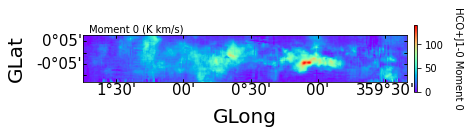

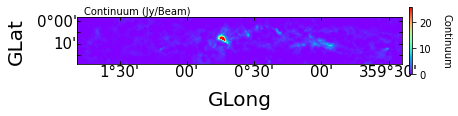

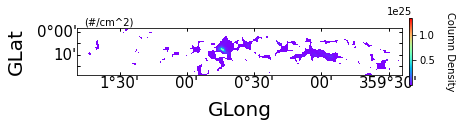

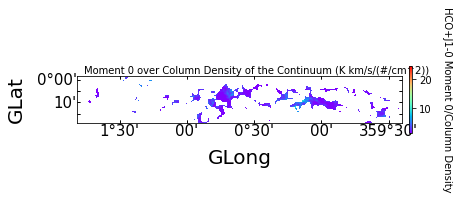

[74] [74] (155, 100)
<class 'float'> <class 'float'> 0.4


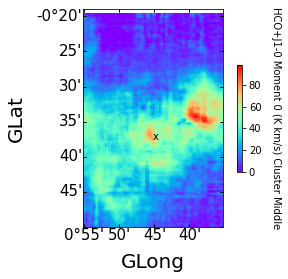

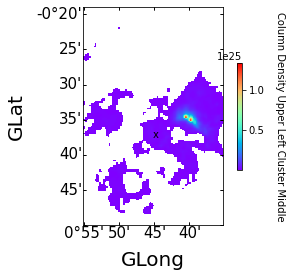

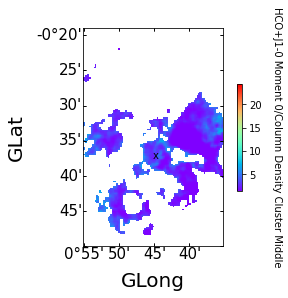

-3.125612046555586

89188523000.0 Hz
38.98800015444 arcsec 38.98800015444 arcsec
10.55599979032924 pix2
(612,)
34 ()
39 ()
50 ()
25 ()
51 ()
93 ()
40 ()
46 ()
66 ()
14884 ()
29 ()
14677 ()
26 ()
14596 ()
63 ()
14568 ()
243 ()
13881 ()
188 ()
13346 ()
63 ()
13337 ()
79 ()
177 ()
29 ()
130 ()
123 ()
34 ()
68 ()
93 ()
422 ()
65 ()
284 ()
46 ()
217 ()
10725 ()
46 ()
7071 ()
99 ()
1990 ()
33 ()
1594 ()
32 ()
542 ()
166 ()
55 ()
375 ()
161 ()
71 ()
259 ()
36 ()
51 ()
108 ()
75 ()
4155 ()
147 ()
82 ()
34 ()
43 ()
379 ()
251 ()
65 ()
37 ()
713 ()
38 ()
172 ()
68 ()
56 ()
48 ()
727 ()
179 ()
65 ()
37 ()
149 ()
53 ()
246 ()
160 ()
40 ()
1951 ()
47 ()
1104 ()
50 ()
525 ()
91 ()
168 ()
77 ()
463 ()
201 ()
44 ()
62 ()
165 ()
60 ()
53 ()
211 ()
87 ()
165 ()
206 ()
68 ()
78 ()
48 ()
922 ()
101 ()
722 ()
190 ()
64 ()
169 ()
69 ()
80 ()
86 ()
94 ()
265 ()
36 ()
130 ()
43 ()
72 ()
47 ()
75 ()
91 ()
66 ()
30 ()
60 ()
193 ()
42 ()
143 ()
98 ()
74 ()
58 ()
100 ()
38 ()
53 ()
157 ()
94 ()
55 ()
57155 ()
46 

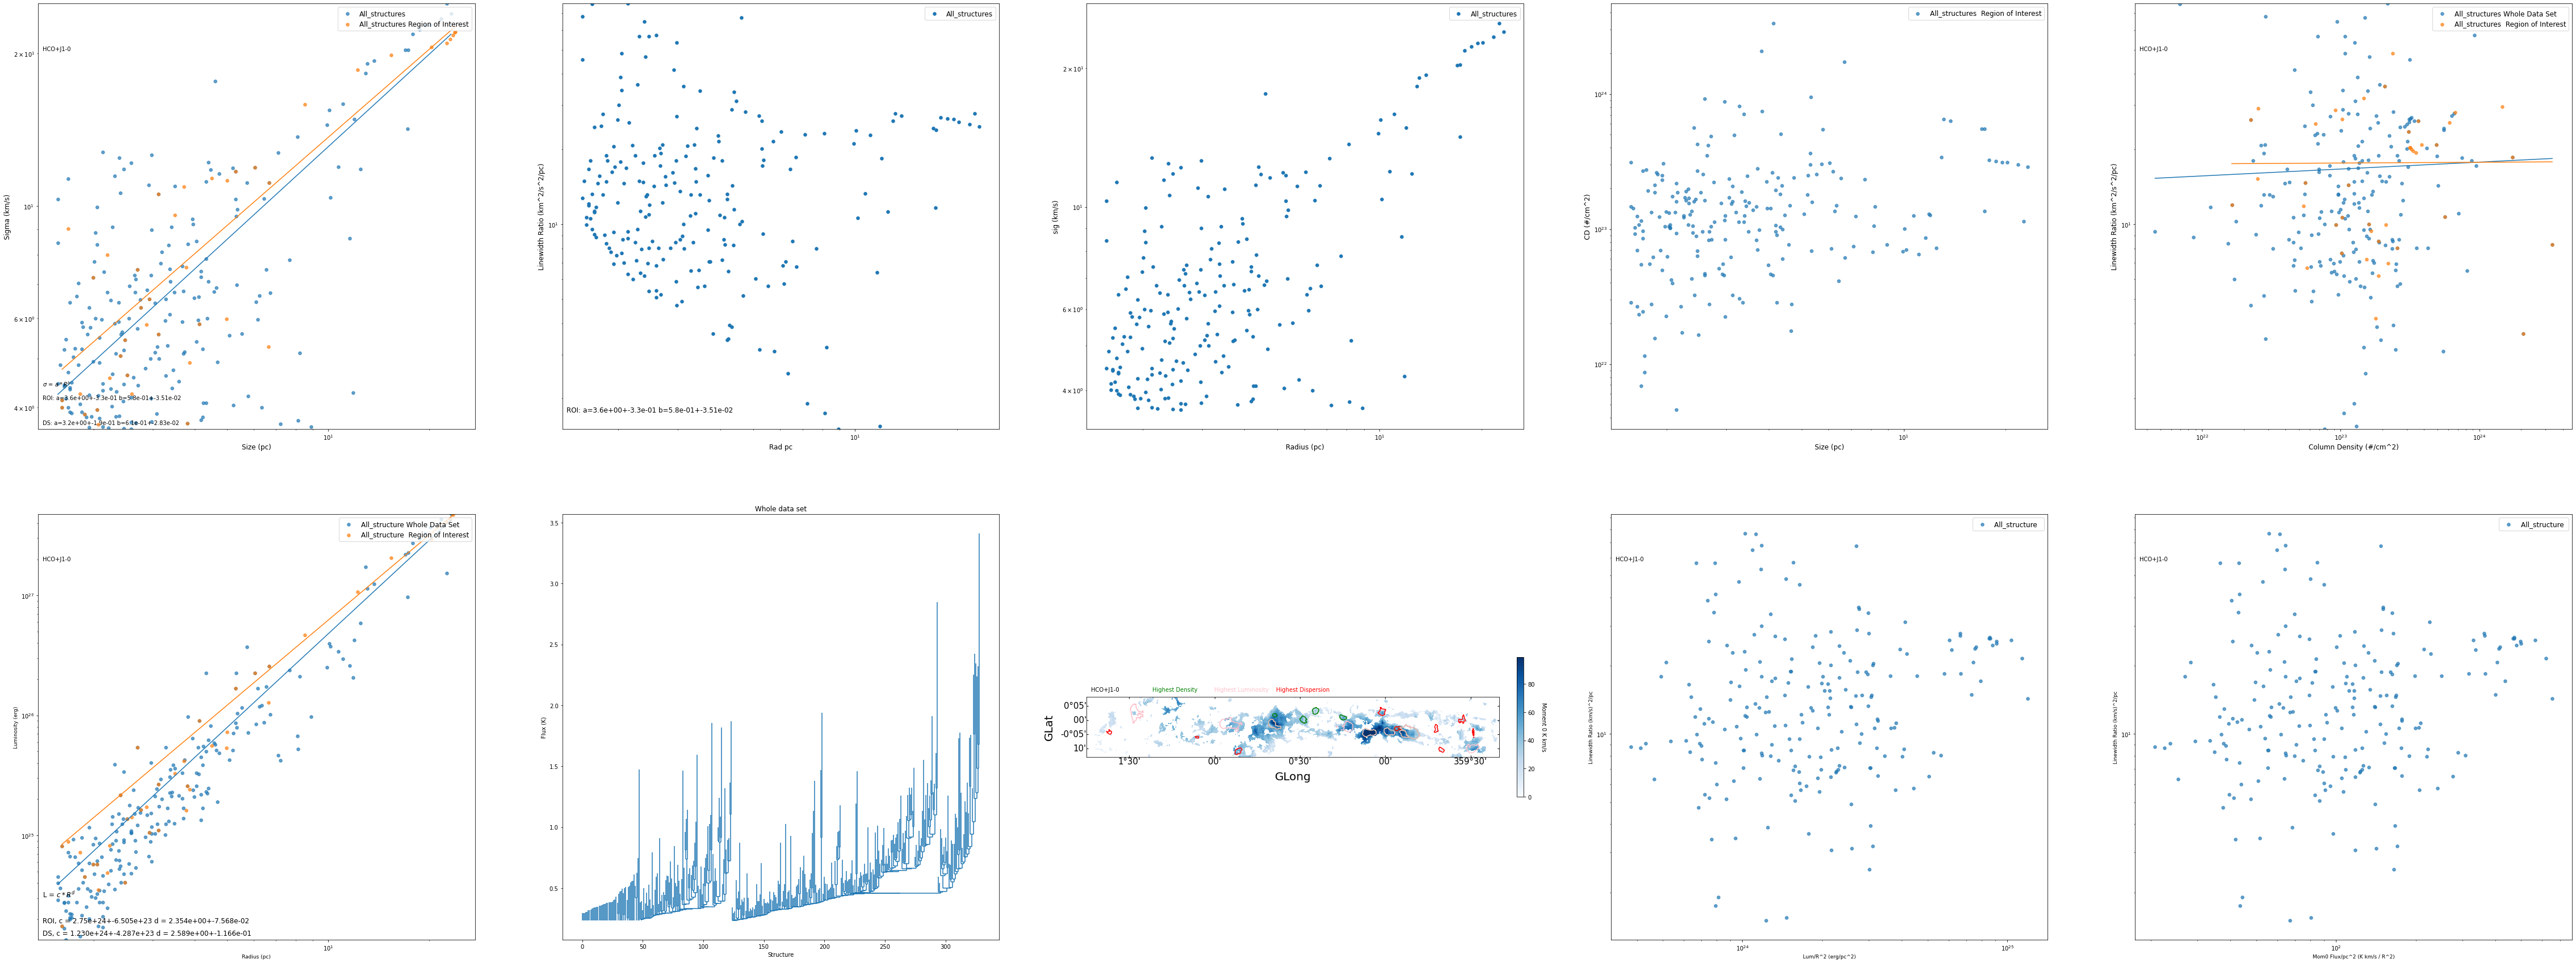

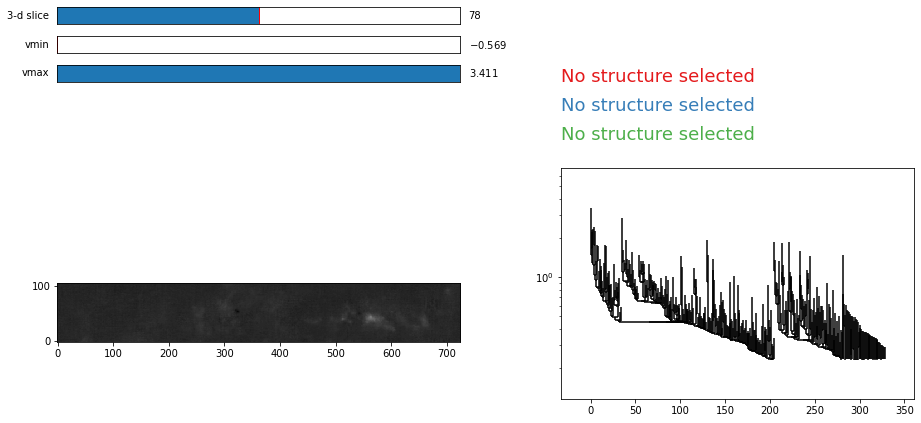

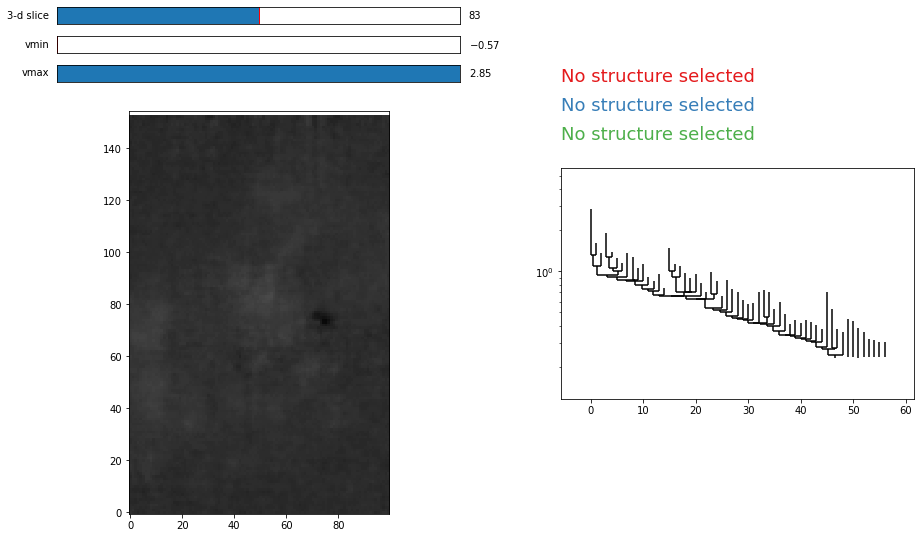

In [16]:
#HCOp
Num = 0
Overlaps=0
Ram_Limiter = 1
Name = "HCOp-J1_Dendrogram_CMZ"
LineN="HCO+J1-0"
Num_per_kg= 6.0221409*10**23/(2.8*10**-3)#6.0221409*10**23/29.0180*10**-3#num/kg for h2

Names = np.load("Names_CMZ.npy")
Names[Num] = Name
NameS = (Name+"Sigmas")
NameR = (Name+"Radii")


np.save("Names_CMZ",Names)

print(Name)


paths = pylab.array(['Fixed_cmz_HCOp.cube.K-kms.pbcor.fits','Fixed_cmz_HCN.cube.reproject.K-kms.pbcor.fits','Fixed_cmz_H13CN.cube.reproject.K-kms.pbcor.fits','Fixed_cmz_H13COp.cube.reproject.K-kms.pbcor.fits',"Fixed_Spliced_CO_V2.fits"])
path = paths[Num]

#pathCont = 'CMZ_Continuum_Reproject.fits'

#path='HCOp_J1-0.cube.fits'
print(path)
Confidences = np.load('Confidence_data_CMZ.npy')

Noises = np.load('Noises_K_CMZ.npy')
#Noises = Ns
m = Noises[Num]
print(m)
#Continuum image

#Put this up here for the column density map


pathCont = 'CMZ_Continuum_Splice.fits'
scCont = spectral_cube.Projection.from_hdu(fits.open(pathCont)[0])
scContW = scCont[30:np.shape(scCont)[0]-30,20:np.shape(scCont)[1]-20] # Make a subcube
#Make subcube
Qp = SpectralCube.read(path).with_spectral_unit(u.km/u.s,velocity_convention="radio")
Qp.allow_huge_operations=True

Q = SpectralCube.read(path).downsample_axis(2,axis=0).with_spectral_unit(u.km/u.s,velocity_convention="radio").spectral_slab(-300. *u.km / u.s, 300. *u.km / u.s)

sc = Q.unmasked_copy()
#scQ = Q
scW = sc.wcs[:][:][0]


dat = sc.hdu.data[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),:,:]
scn = sc[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),:,:]
print(np.shape(dat),np.shape(scn))

datn = dat[5:np.shape(dat)[0]-5,30:np.shape(dat)[1]-30,20:np.shape(dat)[2]-20] # Make a subcube
scF= scn[5:np.shape(dat)[0]-5,30:np.shape(scn)[1]-30,20:np.shape(scn)[2]-20] # Make a subcube

#Do the same thing to the continuum image

metadata = {}
metadata["Cwcs"] = scContW.wcs
print(np.shape(datn),np.shape(scContW))

try:
    #
    sssss=1
except:
    #
    sssss=1
arc_per_pix_yc =  abs(scCont.hdu.header["CDELT1"]*3600.0 * u.arcsec)/u.pix
arc_per_pix_xc =  abs(scCont.hdu.header["CDELT2"]*3600.0 * u.arcsec)/u.pix
beam_majorc =  scCont.hdu.header["BMAJ"]*3600.0 * u.arcsec
beam_minorc =  scCont.hdu.header["BMIN"]*3600.0 * u.arcsec
beam_area_ratioc = beam_minorc*beam_majorc/arc_per_pix_yc/arc_per_pix_xc#This is for FWHM, use *(2*np.sqrt(2*np.log(2)))**2#For gaussian beam

metadata['beam_area_ratioc']=beam_area_ratioc

metadata["arc_per_pix"]= abs(scCont.hdu.header["CDELT1"]*3600.0 * u.arcsec)/u.pix
D_Es = np.load("Pixel_D.npy")*u.Mpc
#print(D_Es)
pc_per_pixelc = abs(scCont.hdu.header["CDELT1"])/180*np.pi*D_Es/u.Mpc


#Cubes with little dense gas and abs
'''
AbpRAD1 = SkyCoord('00h47m32.95s', '-25d17m24.0s', frame='icrs')
AbpRAD2 = SkyCoord('00h47m32.6s', '-25d17m16.0s', frame='icrs')
SCNA= Crop(scn,scW,AbpRAD1,AbpRAD2,5,False)
scContNA = Crop(scCont,scCont.wcs,AbpRAD1,AbpRAD2,0,True)
datna = SCNA.hdu.data 
print(np.shape(SCNA))
'''
UL1 = SkyCoord('00d55m00s',  '-00d50m00s', frame='galactic')#These are away from the sources
UL2 = SkyCoord('00d35m00s','01d30m00s', frame='galactic')
scWCS = scF.wcs[:][:][0]
#scWCSNA = SCNA.wcs[:][:][0]
#moment_0_subNA  = SCNA.moment(order=0,how='slice')            # Calculate the Moment 0 map 
moment_0_sub  = scF.moment(order=0,how='slice')            # Calculate the Moment 0 map 
ROI = Crop(scCont,scCont.wcs,UL1,UL2,5,True)
ROI_Line = Crop(scn,scn.wcs[:][:][0],UL1,UL2,0,False)
moment_0_ROI = ROI_Line.moment(order=0,how='slice')            # Calculate the Moment 0 map 

moment_0_sub  = scF.moment(order=0,how='slice')            # Calculate the Moment 0 map 
######Moment 0 for both
######and cont
Make_Plot((LineN+" Moment 0"),"Moment 0 (K km/s)",moment_0_sub.hdu.data,0,np.nanmax(moment_0_sub.hdu.data),moment_0_sub.wcs,1,1,1,True)
Make_Plot("Continuum","Continuum (Jy/Beam)",scContW.hdu.data,0,np.nanmax(scCont.hdu.data)*.2,scCont.wcs,1,1,1,True)
#Make_Plot((LineN+" Moment 0"),"Moment 0 No Abs Region (K km/s)",moment_0_subNA.hdu.data,0,np.nanmax(moment_0_subNA.hdu.data),moment_0_subNA.wcs,1,1,1,True)


cSD = (Flux_to_Mass(scContW.hdu.data*u.Jy/u.beam/beam_area_ratioc*u.pix**2*u.beam,metadata)/(pc_per_pixelc*10**6*3.086*10**18*u.cm)**2)*(1.989*10**30*u.kg/u.M_sun)*Num_per_kg/u.kg #Flux goes to luminosity for a gaussian beam and goes to column density for square pixels, mass goes to kg to number
rm=moment_0_sub.hdu.data/cSD
rmU = rm*u.K*u.km/u.s#Just put back in the units
rmU = np.array(rmU /(u.K*u.km/u.s)/u.cm**2*10**22,dtype='float64')#Now remove them all
#print(rmU[0][0])
######ratio

Np1 = SkyCoord('359d40m00s',  '00d04m00s', frame='galactic')#These are away from the sources
Np2 = SkyCoord('359d35m00s','00d08m00s', frame='galactic')
NraDP1 = [int(scContW.wcs.world_to_pixel(Np1)[0]),int(scContW.wcs.world_to_pixel(Np1)[1])]
NraDP2 = [int(scContW.wcs.world_to_pixel(Np2)[0]),int(scContW.wcs.world_to_pixel(Np2)[1])]
#print(cSD[NraDP1[1]-50:NraDP2[1]+50,NraDP1[0]-50:NraDP2[0]+50])
#if(str(np.nanmean((cSD[NraDP1[1]-50:NraDP2[1]+50,NraDP1[0]-50:NraDP2[0]+50])))!=str(np.nan)):
#bp = np.where(cSD<=np.nanmean(np.nanstd(cSD[NraDP1[1]-50:NraDP2[1]+50,NraDP1[0]-50:NraDP2[0]+50]))*.001)
bp = np.where(cSD<=7*10**22/u.cm**2)
#bp2 = np.where( moment_0_sub.hdu.data < m*.01)
#print(np.nanmean((cSD[NraDP1[1]-50:NraDP2[1]+50,NraDP1[0]-50:NraDP2[0]+50]))*.001)
cSD[bp]=np.nan
rmU[bp]=np.nan
    #rmU[bp2]=np.nan

#print(cSD[0][0])

#Make_Plot("HCO+ Moment 0/Column Density","Moment 0 over Column Density of the Continuum (K km/s/(#/cm^2))",moment_0_subNA.hdu.data,0,np.nanmax(moment_0_subNA.hdu.data),scCont.wcs,1,1,1,True)
Make_Plot("Column Density","(#/cm^2)",np.array(cSD*u.cm**2,dtype=type(.08)),float(np.nanmin(cSD*u.cm**2)),float(np.nanmax(cSD*u.cm**2)),scCont.wcs,1,1,1,True)
Make_Plot((LineN+" Moment 0/Column Density"),"Moment 0 over Column Density of the Continuum (K km/s/(#/cm^2))",rmU,np.nanmean(rmU)*.5,abs(np.nanmean(rmU))*8,scCont.wcs,1,1,1,True)


#Region of interest in the cont

Find_Pixel_D(ROI.hdu.data,metadata,"Brightest_CD")

D_EROI = np.load("Brightest_CD.npy")*u.Mpc
pc_per_pixelcROI = abs(scCont.hdu.header["CDELT1"])/180*np.pi*D_EROI/u.Mpc

cSDROI = (Flux_to_Mass(ROI.hdu.data*u.Jy/u.beam/beam_area_ratioc*u.pix**2*u.beam,metadata,D_Name = "Brightest_CD.npy")/(pc_per_pixelcROI*10**6*3.086*10**18*u.cm)**2)*(1.989*10**30*u.kg/u.M_sun)*Num_per_kg/u.kg #Flux goes to luminosity for a gaussian beam and goes to column density for square pixels, mass goes to kg to number
rmROI=moment_0_ROI.hdu.data/cSDROI
rmUROI = rmROI*u.K*u.km/u.s#Just put back in the units
rmUROI = np.array(rmUROI /(u.K*u.km/u.s)/u.cm**2*10**22,dtype='float64')#Now remove them all

######ratio
    
#bproi = np.where(cSDROI<=np.nanmean((cSD[NraDP1[1]-50:NraDP2[1]+50,NraDP1[0]-50:NraDP2[0]+50]))*.01)
bproi = np.where(cSDROI<=7*10**22/u.cm**2)
#bp2 = np.where( moment_0_ROI.hdu.data < m*.01)
#print(np.nanmean((cSD[NraDP1[1]-50:NraDP2[1]+50,NraDP1[0]-50:NraDP2[0]+50]))*.01)
cSDROI[bproi]=np.nan
rmUROI[bproi]=np.nan
#rmUROI[bp2]=np.nan

z,yf,xf = np.where(ROI_Line.hdu.data==np.nanmax(ROI_Line.hdu.data))
print(xf,yf,np.shape(ROI.hdu.data))
xf,yf = float(xf/np.shape(ROI.hdu.data)[1]),float(yf/np.shape(ROI.hdu.data)[0])
xf,yf = .5,.4
print(type(xf),type(.5),yf)
Make_Plot_Anno((LineN+" Moment 0 (K km/s) Cluster Middle"),"x",moment_0_ROI.hdu.data,0,np.nanmax(moment_0_ROI.hdu.data),ROI.wcs,1,1,1,True,xf,yf)
Make_Plot_Anno("Column Density Upper Left Cluster Middle","x",np.array(cSDROI*u.cm**2,dtype=type(.08)),float(np.nanmin(cSDROI*u.cm**2)),float(np.nanmax(cSDROI*u.cm**2)),ROI.wcs,1,1,1,True,xf,yf)
Make_Plot_Anno((LineN+" Moment 0/Column Density Cluster Middle"),"x",rmUROI,np.nanmean(rmUROI)*.5,abs(np.nanmean(rmUROI))*8,ROI.wcs,1,1,1,True,xf,yf)


print(np.nanmin(rmU))




header = scF.hdu.header
print()
#make metadata for the dendrogram

try:
    freq = header["RESTFREQ"]*u.Hz#
    metadata['wavelength']=299792458*u.m/header["RESTFREQ"]#
    print(freq)
except:
    freq = header["RESTFRQ"]*u.Hz#
    metadata['wavelength']=299792458*u.m/header["RESTFRQ"]#
metadata['data_unit'] =u.K# header['BUNIT']
metadata['arc_per_pix_y'] =  abs(header["CDELT1"]*3600.0 * u.arcsec)/u.pix
metadata['arc_per_pix_x'] =  abs(header["CDELT2"]*3600.0 * u.arcsec)/u.pix


metadata['beam_major'] =  header["BMAJ"]*3600.0 * u.arcsec
metadata['beam_minor'] =  header["BMIN"]*3600.0 * u.arcsec
beam_area_ratio = metadata['beam_minor']*metadata['beam_major']/metadata['arc_per_pix_y']/metadata['arc_per_pix_x']#This is for FWHM, use *(2*np.sqrt(2*np.log(2)))**2#For gaussian beam
metadata['beam_area_ratio']=beam_area_ratio
metadata['spatial_scale'] = np.sqrt(abs(header["CDELT1"])*u.degree**2*abs(header["CDELT2"]))
area_res = abs(header["CDELT1"])*abs(header["CDELT2"])*(np.pi/180*D_Es/u.Mpc)**2#mpc^2/pix^2

#print(area_res,type(area_res))
print(metadata['beam_minor'],metadata['beam_major'])
print(beam_area_ratio)
#metadata["wcs"] = wcs
metadata["velocity_scale"] = abs(header["CDELT3"])*u.km/u.s#3.3714064157379937*u.km/u.s

metadata["vaxis"]=0



metadata["ARND"] = abs(header["CDELT1"])*abs(header["CDELT2"])








d = astrodendro.Dendrogram.compute(datn,min_delta=m,min_value=m*5,min_npix=50) #The main culprit
#dNA = astrodendro.Dendrogram.compute(datna,min_value=m*5,min_delta=m,min_npix=50) #The main culprit


dUL = astrodendro.Dendrogram.compute(ROI_Line.hdu.data,min_value=m*5,min_delta=m,min_npix=50) #The main culprit



##Analyze dendograms
print(np.shape(d))




fig = plt.figure(1,figsize=(80,80))


axAlpha = pylab.subplot(5, 5, 7)


axGamma = pylab.subplot(5, 5, 9)




p=d.plotter()
p.plot_tree(axAlpha)
axAlpha.set_xlabel("Structure")
axAlpha.set_ylabel("Flux (K)")
axAlpha.set_title("Whole data set")

            
'''

p=dNA.plotter()
p.plot_tree(axBeta)
axBeta.set_xlabel("Structure")
axBeta.set_ylabel("Flux (K)")
axBeta.set_title("No absorption region")

'''
#p=dUL.plotter()
#p.plot_tree(axGamma)
#xGamma.set_xlabel("Structure")
#axGamma.set_ylabel("Flux (K)")
#axGamma.set_title("Region of Interest")
''''''

pc_per_pixel = abs(header["CDELT1"])/180*np.pi*D_Es/u.Mpc

sig_per_pixel=np.nan#metadata['spectral_resolution']/u.pix


#Finds Size, Linewidth, Luminosity, and Column Density of a structure for each structure and returns them in [[][]] arrays [Leaves][Branches]
vel,RA,Dec = scF.world[:,0,0]
Rads,Sigmas,CD,Lumin ,SIDS,MOM0FLUX= Dendro_Arrays(d,datn,vel,scContW.hdu.data,metadata)

#Plot contours for the top ten clusters


scCropped =scF.moment0().hdu.data
scCropped[np.where(scF.moment0().hdu.data<.22)]=np.nan
print(np.nanmean(np.nanstd(scF.moment0().hdu.data))*1)
scCropped[bp]=np.nan
axBeta = pylab.subplot(5,5,8,projection=scF.moment0().wcs)
#axBeta.imshow(scCropped.moment0().hdu.data, origin='lower', interpolation='nearest', cmap=plt.cm.Blues,norm=colors.LogNorm(vmin=5))
imBeta = axBeta.imshow(scCropped, origin='lower', interpolation='nearest', cmap=plt.cm.Blues,vmin=0,vmax = np.nanmax(scCropped)*.7 )



ColumnCon= np.concatenate((CD[0],CD[1]))
SIDScon = np.concatenate((SIDS[0],SIDS[1]))
#nth = sorted(ColumnCon)[len(ColumnCon)-30]
nth = sorted(CD[0])[len(CD[0])-10]
nth2 = sorted(Lumin[0])[len(Lumin[0])-10]
nth3 = sorted(Sigmas[0])[len(Sigmas[0])-10]
#top = np.where(CD[0]>=nth)
#print(list(top))
'''
for n in range(len(ColumnCon)):
    
    if(ColumnCon[n]>=nth):
        #print(n,SIDS[0])
        p.plot_contour(axBeta, structure=int(SIDScon[n]), lw=.1, colors='red')
        #NOT USING LEAVSE FOR STRUCTURES, USING ALL STRUCTURES
        #solved?
'''
G1 = True
G2 = True
G3 = True
for n in range(len(CD[0])):
    
    if(CD[0][n]>=nth):
        #print(n,SIDS[0])
        if(G1):
            G1=False
            p.plot_contour(axBeta, structure=int(SIDS[0][n]), lw=1, colors='green',label="Higest Density")
        else:
            p.plot_contour(axBeta, structure=int(SIDS[0][n]), lw=1, colors='green')
        #NOT USING LEAVSE FOR STRUCTURES, USING ALL STRUCTURES
        #solved?
    if(Lumin[0][n]>=nth2):
        #print(n,SIDS[0])
        if(G2):
            G2=False
            p.plot_contour(axBeta, structure=int(SIDS[0][n]), lw=2, colors="pink",label="Highest Luminosity (Leaves)")
        else:
            p.plot_contour(axBeta, structure=int(SIDS[0][n]), lw=2, colors="pink")
        #NOT USING LEAVSE FOR STRUCTURES, USING ALL STRUCTURES
        #solved?
    if(Sigmas[0][n]>=nth3):
        #print(n,SIDS[0])
        if(G3):
            G3=False
            p.plot_contour(axBeta, structure=int(SIDS[0][n]), lw=3, colors='red',label="Highest Dispersion")
        else:
            p.plot_contour(axBeta, structure=int(SIDS[0][n]), lw=3, colors='red')
        #NOT USING LEAVSE FOR STRUCTURES, USING ALL STRUCTURES
        #solved?
   
  


RA = axBeta.coords[0]                                                                  # 
Dec = axBeta.coords[1]

RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('GLong',fontsize=20,labelpad=1)                               
pylab.ylabel('GLat',fontsize=20,labelpad=1)
axBeta.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(imBeta,fraction=0.016,pad=0.04)                                     
cb.set_label(label="Moment 0 K km/s",fontsize=10,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)   
pylab.annotate(s=LineN,fontsize=10,xy=(.01,1.1),xycoords="axes fraction",c="black")  
pylab.annotate(s="Highest Density",fontsize=10,xy=(.16,1.1),xycoords="axes fraction",c="green")  
pylab.annotate(s="Highest Luminosity",fontsize=10,xy=(.31,1.1),xycoords="axes fraction",c="pink")  
pylab.annotate(s="Highest Dispersion",fontsize=10,xy=(.46,1.1),xycoords="axes fraction",c="red")  

    
    
    
    
#RadsNA,SigmasNA,CDNA,LuminNA = Dendro_Arrays(dNA,datna,vel,scContNA.hdu.data,metadata)
RadsUL,SigmasUL,CDUL,LuminUL,SIDSUL,MOM0FLUXUL = Dendro_Arrays(dUL,ROI_Line.hdu.data,vel,ROI.hdu.data,metadata)


#def Dendro_Arrays(Dendrogram,LineData,DataVel,ContData,metadata):
    

from scipy.optimize import curve_fit
from scipy.optimize import leastsq

def func(R,a,b):
    return a*R**(b)
try:
    popt, pcov = curve_fit(func, Rads[0]*10**6,Sigmas[0])
except:
    popt, pcov = [np.nan,np.nan],[[np.nan,np.nan],[np.nan,np.nan]]
try:
    poptB, pcovB = curve_fit(func,  Rads[1]*10**6,Sigmas[1])
except:
    poptB, pcovB = [np.nan,np.nan],[[np.nan,np.nan],[np.nan,np.nan]]


    
Rcon = np.concatenate((Rads[0],Rads[1]))
Scon = np.concatenate((Sigmas[0],Sigmas[1]))
print(np.shape(Rcon))
poptCon, pcovCon = curve_fit(func, Rcon*10**6, Scon)







    
RconUL = np.concatenate((RadsUL[0],RadsUL[1]))
SconUL = np.concatenate((SigmasUL[0],SigmasUL[1]))

poptUL, pcovUL = curve_fit(func, RconUL*10**6, SconUL)



xs=np.linspace(np.nanmin(Rcon*10**6),np.nanmax(Rcon*10**6),50)
ysL,ysB,ysCon=func(xs,popt[0],popt[1]),func(xs,poptB[0],poptB[1]),func(xs,poptCon[0],poptCon[1])



LuminCon = np.concatenate((Lumin[0],Lumin[1]))

MOM0FLUXcon = np.concatenate((MOM0FLUX[0],MOM0FLUX[1]))
#Flux ratios fit
#FRpopt,FRpcov = curve_fit(func, abs(FRs),Scon**2/Rcon/10**6)
#xsF=np.linspace(np.nanmin(abs(FRs)),np.nanmax(abs(FRs)),50)
#ysF = func(xsF,FRpopt[0],FRpopt[1])

#Radius Luminosity fit
gp = np.where(LuminCon>0)
print(np.shape(Rcon),np.shape(LuminCon))
lgp = LuminCon[gp]
radgp = Rcon[gp]*10**6
#print(np.shape(Rcon[gp]*10**6),np.shape(LuminCon[gp]))
RLpopt,RLpcov = curve_fit(func, np.array(radgp,dtype='float64'),np.array(lgp,dtype='float64'),maxfev=999999,p0 = np.array([10**27,1],dtype='float64'),ftol = 10**-10)

xsRL=np.linspace(np.nanmin(radgp),np.nanmax(radgp),50)
ysRL = func(xsRL,RLpopt[0],RLpopt[1])



#Column density to Size-linewidth
gp2 = np.where(ColumnCon>0)

cgp = ColumnCon[gp2]
radgpFORRAT = Rcon[gp2]*10**6
siggpFORRAT = Scon[gp2]


lumFORRAT = LuminCon[gp2]
mom0FORRAT = MOM0FLUXcon[gp2]
rgp=Scon[gp2]**2/Rcon[gp2]/10**6

gp3 = np.where(lumFORRAT>0)
lumFORRAT = lumFORRAT[gp3]
rgpFORRAT = rgp[gp3]
mom0FORRAT = mom0FORRAT[gp3]
CDpopt,CDpcov = curve_fit(func, np.array(cgp,dtype='float64') ,np.array(rgp,dtype='float64'),maxfev=9999099,p0 = np.array([10,.01],dtype='float64'),ftol = 10**-10)
xsCD=np.linspace(np.nanmin(cgp),np.nanmax(cgp),50)
ysCD = func(xsCD,CDpopt[0],CDpopt[1])


print(poptCon,pcovCon,"Size Linewidth All_structures:")
print("a = ",poptCon[0],"+-",np.sqrt(pcovCon[0][0]))
print("b = ",poptCon[1],"+-",np.sqrt(pcovCon[1][1]))



print(RLpopt,RLpcov,"Radius to Luminosity:")
print("c = ",RLpopt[0],"+-",np.sqrt(RLpcov[0][0]))
print("d = ",RLpopt[1],"+-",np.sqrt(RLpcov[1][1]))






print(CDpopt,CDpcov,"Column Density to linewidth^2/size:")
print("e = ",CDpopt[0],"+-",np.sqrt(CDpcov[0][0]))
print("f = ",CDpopt[1],"+-",np.sqrt(CDpcov[1][1]))



ax2 = pylab.subplot(5, 5, 1)
ax3 = pylab.subplot(5, 5, 2)
ax4 = pylab.subplot(5, 5, 3)



print(np.shape(Rcon*10**6),np.shape(Scon),np.shape(Rads[0]*10**6),np.shape(Sigmas[0]),np.shape(Rads[1]*10**6),np.shape(Sigmas[1]),type(Rads[0]))
#xpcon,xpL,xpB = ax2.scatter(Rcon*10**6,Scon,label="All_structures",s=30),ax2.scatter(Rads[0]*10**6,Sigmas[0],s=30),ax2.scatter(Rads[1]*10**6,Sigmas[1],s=30)
xpcon = ax2.scatter(Rcon*10**6,Scon,label="All_structures",s=30,alpha=.7)
#p,p2,p3 = ax2.plot(xs,ysCon),ax2.plot(xs,ysL),ax2.plot(xs,ysB)
p = ax2.plot(xs,ysCon)

#pNA = ax2.plot(xsNA,ysNA)
#xpNA = ax2.scatter(RconNA*10**6,SconNA,label="All_structures Sparse region",s=30,alpha=.7)

xpconhh = ax2.scatter(RconUL*10**6,SconUL,label="All_structures Region of Interest",s=30,alpha=.7)
xsUL=np.linspace(np.nanmin(RconUL*10**6),np.nanmax(RconUL*10**6),50)
ysUL=func(xsUL,poptUL[0],poptUL[1])
p22 = ax2.plot(xsUL,ysUL)


st="DS: a="+ str(np.format_float_scientific(poptCon[0],1))+"+-"+str(np.format_float_scientific(np.sqrt(pcovCon[0][0]),1))+" b="+str(np.format_float_scientific(poptCon[1],1))+"+-"+str(np.format_float_scientific(np.sqrt(pcovCon[1][1]),2))
ax2.annotate(s=st,fontsize=10,xy=(0.01,0.01),xycoords="axes fraction")

st="ROI: a="+ str(np.format_float_scientific(poptUL[0],1))+"+-"+str(np.format_float_scientific(np.sqrt(pcovUL[0][0]),1))+" b="+str(np.format_float_scientific(poptUL[1],1))+"+-"+str(np.format_float_scientific(np.sqrt(pcovUL[1][1]),2))
ax2.annotate(s=st,fontsize=10,xy=(0.01,0.07),xycoords="axes fraction")
ax2.annotate(s=r'$\sigma$ = $a*R^b$',fontsize=10,xy=(0.01,0.10),xycoords="axes fraction")
ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.set_ylim(np.nanmin(Scon),np.nanmax(Scon))
ax2.set_xlabel("Size (pc)",fontsize=12)
ax2.set_ylabel("Sigma (km/s)",fontsize=12)
ax2.legend(prop={'size': 12},loc="upper right")
ax2.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")

#gp = np.where(FRs>0)





xspF = ax3.scatter(radgpFORRAT,rgp,label="All_structures",s=30)
#pF = ax3.plot(xsCD,ysCD)
#ax3.annotate(s=r'$\sigma^2/R$ = $e*N^f$',fontsize=12,xy=(0.01,0.07),xycoords="axes fraction")
#st = "e = "+ str(np.format_float_scientific(CDpopt[0],3))+"+-"+str(np.format_float_scientific(np.sqrt(CDpcov[0][0]),3))+" f = "+str(np.format_float_scientific(CDpopt[1],3))+"+-"+str(np.format_float_scientific(np.sqrt(CDpcov[1][1]),3))

ax3.annotate(s=st,fontsize=12,xy=(0.01,0.04),xycoords="axes fraction")
ax3.set_yscale('log')
ax3.set_xscale('log')
ax3.set_ylim(np.nanmin(rgp),np.nanmax(rgp))
ax3.set_xlabel("Rad pc",fontsize=12)
ax3.set_ylabel("Linewidth Ratio (km^2/s^2/pc)",fontsize=12)
ax3.legend(prop={'size': 12})



xspL = ax4.scatter(radgpFORRAT,siggpFORRAT,label="All_structures",s=30)
#pFLL = ax4.plot(xsRL,ysRL)

#st = "c = "+ str(np.format_float_scientific(RLpopt[0],3))+"+-"+str(np.format_float_scientific(np.sqrt(RLpcov[0][0]),3))+" d = "+str(np.format_float_scientific(RLpopt[1],3))+"+-"+str(np.format_float_scientific(np.sqrt(RLpcov[1][1]),3))
#ax4.annotate(s='L = $c*R^d$',fontsize=12,xy=(0.01,0.07),xycoords="axes fraction")
#ax4.annotate(s=st,fontsize=12,xy=(0.01,0.04),xycoords="axes fraction")

ax4.set_yscale('log')
ax4.set_xscale('log')
#ax4.set_ylim(np.nanmin(lgp),np.nanmax(lgp))
ax4.set_xlabel("Radius (pc)",fontsize=12)
ax4.set_ylabel("sig (km/s)",fontsize=12)
ax4.legend(prop={'size': 12},loc="upper right")














LuminConUL = np.concatenate((LuminUL[0],LuminUL[1]))
ColumnConUL= np.concatenate((CDUL[0],CDUL[1]))

#Radius Luminosity fit
gp = np.where(LuminConUL>0)
lgpUL = LuminConUL[gp]
radgpUL = RconUL[gp]*10**6
print(np.shape(radgpUL),np.shape(lgpUL))
RLpoptUL,RLpcovUL = curve_fit(func, np.array(radgpUL,dtype='float64'),np.array(lgpUL,dtype='float64'),maxfev=999999,p0 = np.array([10**27,1],dtype='float64'),ftol = 10**-10)

xsRLUL=np.linspace(np.nanmin(radgpUL),np.nanmax(radgpUL),50)
ysRLUL = func(xsRLUL,RLpoptUL[0],RLpoptUL[1])

#Column density to Size-linewidth
gp2 = np.where(ColumnConUL>0)
cgpUL = ColumnConUL[gp2]
rgpUL=SconUL[gp2]**2/RconUL[gp2]/10**6
CDpoptUL,CDpcovUL = curve_fit(func, np.array(cgpUL,dtype='float64') ,np.array(rgpUL,dtype='float64'),maxfev=9999099,p0 = np.array([10,.01],dtype='float64'),ftol = 10**-10)
xsCDUL=np.linspace(np.nanmin(cgpUL),np.nanmax(cgpUL),50)
ysCDUL = func(xsCDUL,CDpoptUL[0],CDpoptUL[1])

print(poptUL,pcovUL,"Size Linewidth Region of Interest:")
print("a = ",poptUL[0],"+-",np.sqrt(pcovUL[0][0]))
print("b = ",poptUL[1],"+-",np.sqrt(pcovUL[1][1]))

print(RLpoptUL,RLpcovUL,"Radius to Luminosity  Region of Interest:")
print("c = ",RLpoptUL[0],"+-",np.sqrt(RLpcovUL[0][0]))
print("d = ",RLpoptUL[1],"+-",np.sqrt(RLpcovUL[1][1]))


ax5 = pylab.subplot(5, 5, 4)
ax6 = pylab.subplot(5, 5, 5)
ax7 = pylab.subplot(5, 5, 6)




xpconhh = ax5.scatter(radgpFORRAT,cgp,label="All_structures  Region of Interest",s=30,alpha=.7)
#p2 = ax5.plot(xsUL,ysUL)


ax5.set_yscale('log')
ax5.set_xscale('log')
#ax5.set_ylim(np.nanmin(Scon),np.nanmax(Scon))
ax5.set_xlabel("Size (pc)",fontsize=12)
ax5.set_ylabel("CD (#/cm^2)",fontsize=12)
ax5.legend(prop={'size': 12},loc="upper right")


#gp = np.where(FRs>0)



xspFUL2 = ax6.scatter(cgp,rgp,label="All_structures Whole Data Set",s=30,alpha=.7)
pFUL2 = ax6.plot(xsCD,ysCD)


#xspFNA = ax6.scatter(cgpNA,rgpNA,label="All_structures Sparse Region",s=30,alpha=.7)
#pFNA = ax6.plot(xsCDNA,ysCDNA)


xspFUL = ax6.scatter(cgpUL,rgpUL,label="All_structures  Region of Interest",s=30,alpha=.7)
pFUL = ax6.plot(xsCDUL,ysCDUL)

#ax6.annotate(s=st,fontsize=12,xy=(0.01,0.06),xycoords="axes fraction")
ax6.set_yscale('log')
ax6.set_xscale('log')
ax6.set_ylim(np.nanmin(rgp),np.nanmax(rgp))
ax6.set_xlabel("Column Density (#/cm^2)",fontsize=12)
ax6.set_ylabel("Linewidth Ratio (km^2/s^2/pc)",fontsize=12)
ax6.legend(prop={'size': 12},loc="upper right")
ax6.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")




xspLu2 = ax7.scatter(radgp,lgp,label="All_structure Whole Data Set",s=30,alpha=.7)
pFLLu2 = ax7.plot(xsRL,ysRL)
#xspLu2NA = ax7.scatter(radgpNA,lgpNA,label="All_structure Sparse Region",s=30,alpha=.7)
#pFLLu2NA = ax7.plot(xsRLNA,ysRLNA)

xspLu = ax7.scatter(radgpUL,lgpUL,label="All_structure  Region of Interest",s=30,alpha=.7)

pFLLu = ax7.plot(xsRLUL,ysRLUL)


st = "DS, c = "+ str(np.format_float_scientific(RLpopt[0],3))+"+-"+str(np.format_float_scientific(np.sqrt(RLpcov[0][0]),3))+" d = "+str(np.format_float_scientific(RLpopt[1],3))+"+-"+str(np.format_float_scientific(np.sqrt(RLpcov[1][1]),3))
ax7.annotate(s='L = $c*R^d$',fontsize=12,xy=(0.01,0.10),xycoords="axes fraction")
ax7.annotate(s=st,fontsize=12,xy=(0.01,0.01),xycoords="axes fraction")
st2 = "ROI, c = "+ str(np.format_float_scientific(RLpoptUL[0],3))+"+-"+str(np.format_float_scientific(np.sqrt(RLpcovUL[0][0]),3))+" d = "+str(np.format_float_scientific(RLpoptUL[1],3))+"+-"+str(np.format_float_scientific(np.sqrt(RLpcovUL[1][1]),3))
ax7.annotate(s=st2,fontsize=12,xy=(0.01,0.04),xycoords="axes fraction")

#st3 = "SR, c = "+ str(np.format_float_scientific(RLpoptNA[0],3))+"+-"+str(np.format_float_scientific(np.sqrt(RLpcovNA[0][0]),3))+" d = "+str(np.format_float_scientific(RLpoptNA[1],3))+"+-"+str(np.format_float_scientific(np.sqrt(RLpcovNA[1][1]),3))
#ax7.annotate(s=st3,fontsize=12,xy=(0.01,0.07),xycoords="axes fraction")

ax7.set_yscale('log')
ax7.set_xscale('log')
ax7.set_ylim(np.nanmin(lgp),np.nanmax(lgp))
ax7.set_xlabel("Radius (pc)",fontsize=9)
ax7.set_ylabel("Luminosity (erg)",fontsize=9)
ax7.legend(prop={'size': 12},loc="upper right")
ax7.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")

#print(FRs)



lum_rat = axGamma.scatter(lumFORRAT/radgpFORRAT**2,rgpFORRAT,label="All_structure  ",s=30,alpha=.7)
#Off by factors for area, simply using r^2

axGamma.set_yscale('log')
axGamma.set_xscale('log')
axGamma.set_xlabel("Lum/R^2 (erg/pc^2)",fontsize=9)
axGamma.set_ylabel("Linewidth Ratio (km/s)^2/pc",fontsize=9)
axGamma.legend(prop={'size': 12},loc="upper right")
axGamma.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")



axDelta = pylab.subplot(5, 5, 10)



#mom0_rat = axDelta.scatter(mom0FORRAT/radgpFORRAT**2,rgpFORRAT,label="All_structure  Region of Interest",s=30,alpha=.7)
gp4=np.where(MOM0FLUXcon>0)
mom0FORFlux=MOM0FLUXcon[gp4]
radgpFORFlux=Rcon[gp4]*10**6
rgpFORFlux=Scon[gp4]**2/Rcon[gp4]/10**6
mom0_rat = axDelta.scatter(mom0FORFlux/radgpFORFlux**2,rgpFORFlux,label="All_structure ",s=30,alpha=.7)
#Off by factors for area, simply using r^2

axDelta.set_yscale('log')
axDelta.set_xscale('log')
axDelta.set_xlabel("Mom0 Flux/pc^2 (K km/s / R^2)",fontsize=9)
axDelta.set_ylabel("Linewidth Ratio (km/s)^2/pc",fontsize=9)
axDelta.legend(prop={'size': 12},loc="upper right")
axDelta.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")


pylab.show()


NameCol = (Name+"_Column")
NameLum = (Name+"_Luminosities")

NameColROI = (Name+"_Column_ROI")
NameLumROI = (Name+"_Luminosities_ROI")
NameRROI = (NameR+"_ROI")
NameSROI = (NameS+"_ROI")
NameFlux = (Name+"Flux_Dense")
NameRFF = (Name+"Rad_For_Flux")

v1 = d.viewer()
v1.show()
v3 = dUL.viewer()
v3.show()

np.save(NameCol,CD)
np.save(NameLum,Lumin)

np.save(NameS,Sigmas)
np.save(NameR,Rads) #Still in [leaves] [breanches] format

np.save(NameColROI,CDUL)
np.save(NameLumROI,LuminUL)

np.save(NameSROI,SigmasUL)
np.save(NameRROI,RadsUL) #Still in [leaves] [breanches] format

np.save(NameFlux,mom0FORFlux/radgpFORFlux**2)
np.save(NameRFF,rgpFORFlux)



HCN_1_0_Abs_CMZ
Fixed_cmz_HCN.cube.reproject.K-kms.pbcor.fits
0.0521674819327987
(166, 165, 765) (166, 165, 765)
(156, 105, 725) (105, 725)


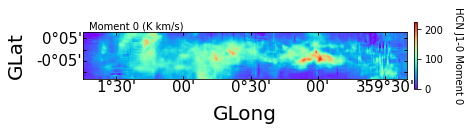

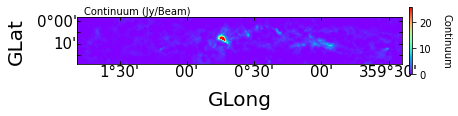

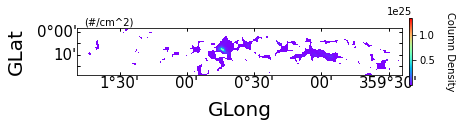

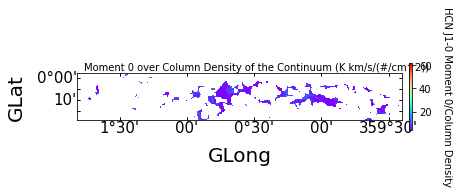

[74] [74] (155, 100)
<class 'float'> <class 'float'> 0.4


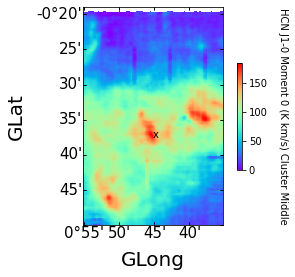

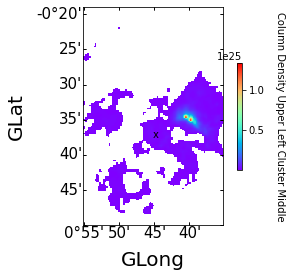

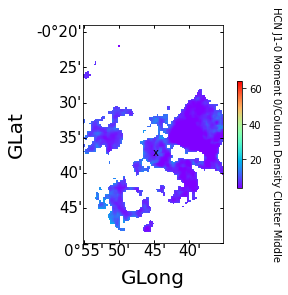

-5.6246579640698195

88631847000.0 Hz
38.98800015444 arcsec 38.98800015444 arcsec
10.55599979032924 pix2
(812,)
33.750686044659304
(285,)
(285,) (285,)
[4.24962759 0.49147797] [[ 0.0498205  -0.00562402]
 [-0.00562402  0.0007838 ]] Size Linewidth All_structures:
a =  4.249627586550825 +- 0.2232050728406332
b =  0.4914779729040167 +- 0.027996356679371094
[8.24706384e+23 2.93368777e+00] [[ 3.84150380e+46 -1.58922064e+22]
 [-1.58922064e+22  6.60180843e-03]] Radius to Luminosity:
c =  8.24706383765234e+23 +- 1.9599754601614012e+23
d =  2.933687767021278 +- 0.08125151340777353
[0.12986759 0.09572542] [[ 0.1995207  -0.02882386]
 [-0.02882386  0.00416544]] Column Density to linewidth^2/size:
e =  0.1298675926545833 +- 0.4466773971622687
f =  0.09572542163505325 +- 0.06454024053499738
(285,) (285,) (185,) (185,) (100,) (100,) <class 'numpy.ndarray'>
(54,) (54,)
[3.71356077 0.5459525 ] [[ 0.12516915 -0.01335124]
 [-0.01335124  0.00171069]] Size Linewidth Region of Interest:
a =  3.71356076603034

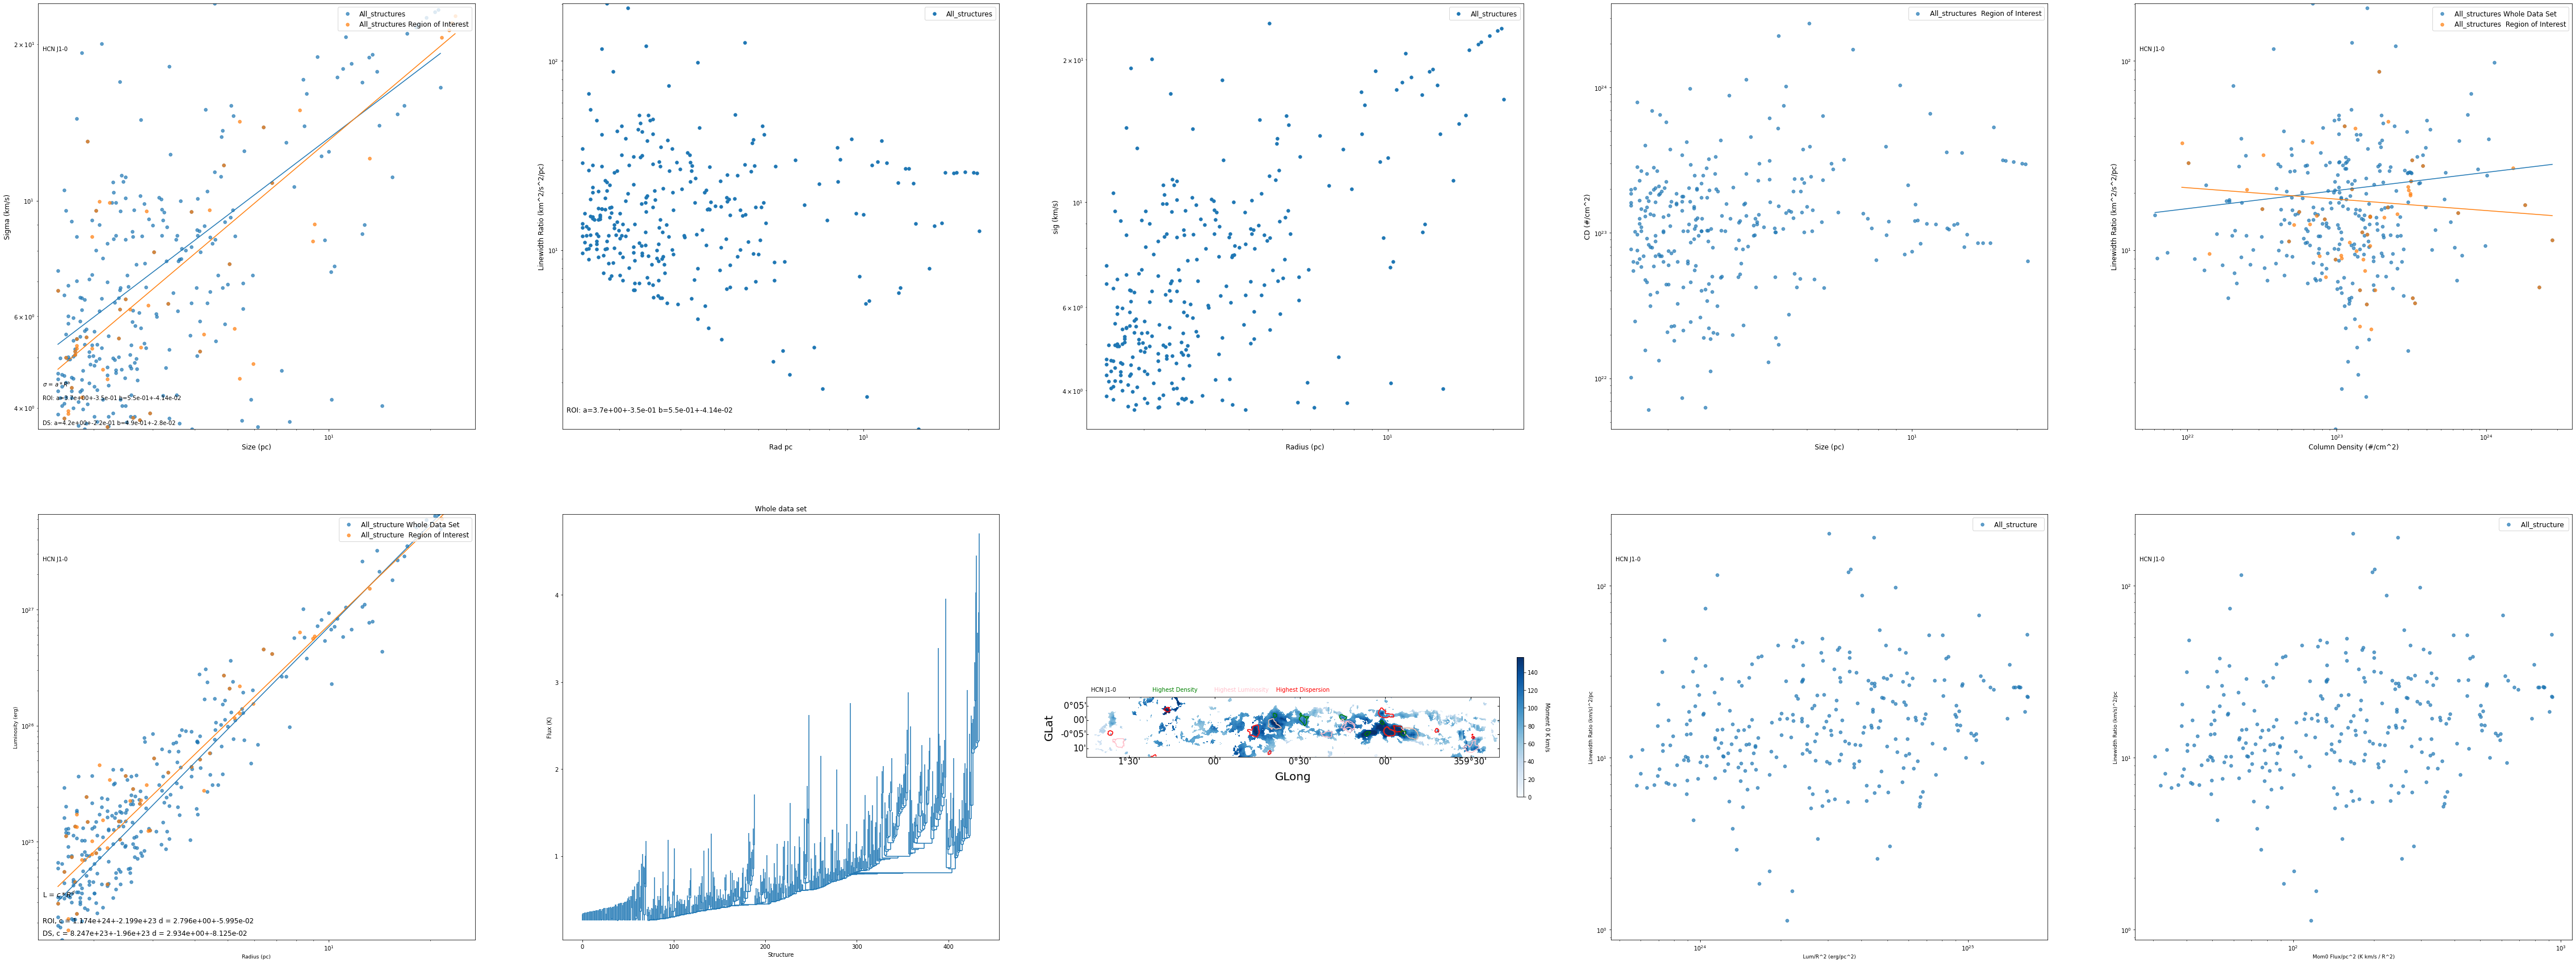

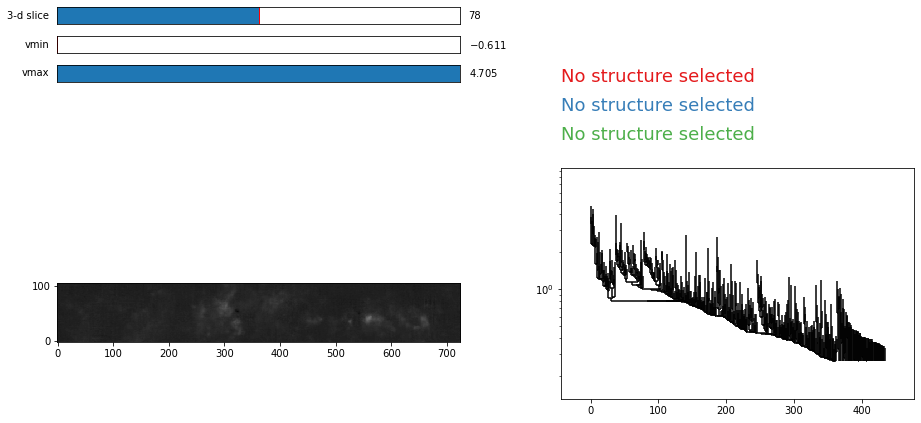

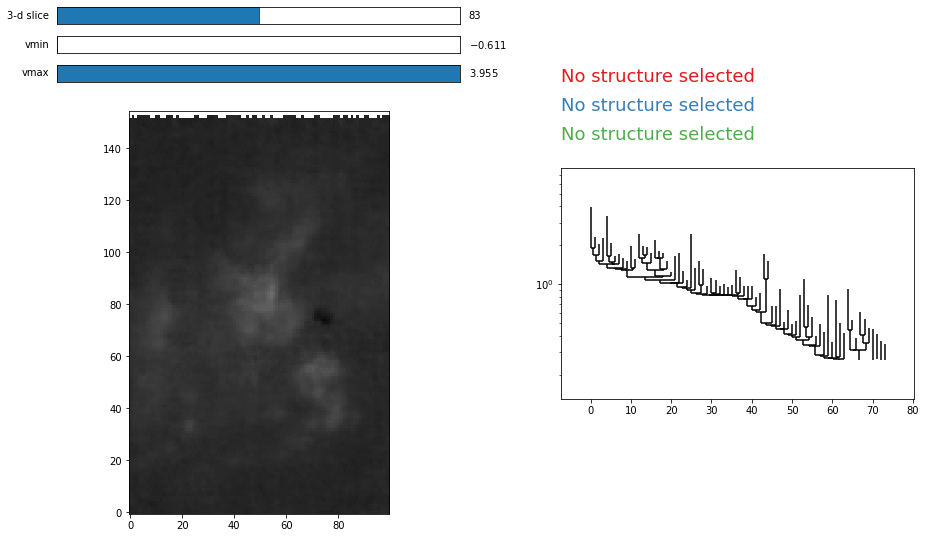

In [11]:
###### HCN


Num = 1
Overlaps=0
Ram_Limiter = 1
Name = "HCN_1_0_Abs_CMZ"
name = "HCN_1_0_CM_Contours_DS_10_Abs_CMZ.jpeg"
LineN="HCN J1-0"
Num_per_kg= 6.0221409*10**23/(2.8*10**-3)#6.0221409*10**23/29.0180*10**-3#num/kg for h2


Names[Num] = Name
NameS = (Name+"Sigmas")
NameR = (Name+"Radii")

np.save("Names_CMZ",Names)

print(Name)


paths = pylab.array(['Fixed_cmz_HCOp.cube.K-kms.pbcor.fits','Fixed_cmz_HCN.cube.reproject.K-kms.pbcor.fits','Fixed_cmz_H13CN.cube.reproject.K-kms.pbcor.fits','Fixed_cmz_H13COp.cube.reproject.K-kms.pbcor.fits',"Fixed_Spliced_CO_V2.fits"])
path = paths[Num]

#pathCont = 'CMZ_Continuum_Reproject.fits'

#path='HCOp_J1-0.cube.fits'
print(path)
Confidences = np.load('Confidence_data_CMZ.npy')

Noises = np.load('Noises_K_CMZ.npy')
#Noises = Ns
m = Noises[Num]
print(m)
#Continuum image

#Put this up here for the column density map


pathCont = 'CMZ_Continuum_Splice.fits'
scCont = spectral_cube.Projection.from_hdu(fits.open(pathCont)[0])
scContW = scCont[30:np.shape(scCont)[0]-30,20:np.shape(scCont)[1]-20] # Make a subcube
#Make subcube
Qp = SpectralCube.read(path).with_spectral_unit(u.km/u.s,velocity_convention="radio")
Qp.allow_huge_operations=True

Q = SpectralCube.read(path).downsample_axis(2,axis=0).with_spectral_unit(u.km/u.s,velocity_convention="radio").spectral_slab(-300. *u.km / u.s, 300. *u.km / u.s)

sc = Q.unmasked_copy()
#scQ = Q
scW = sc.wcs[:][:][0]


dat = sc.hdu.data[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),:,:]
scn = sc[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),:,:]
print(np.shape(dat),np.shape(scn))

datn = dat[5:np.shape(dat)[0]-5,30:np.shape(dat)[1]-30,20:np.shape(dat)[2]-20] # Make a subcube
scF= scn[5:np.shape(dat)[0]-5,30:np.shape(scn)[1]-30,20:np.shape(scn)[2]-20] # Make a subcube

#Do the same thing to the continuum image

metadata = {}
metadata["Cwcs"] = scContW.wcs
print(np.shape(datn),np.shape(scContW))

try:
    #
    sssss=1
except:
    #
    sssss=1
arc_per_pix_yc =  abs(scCont.hdu.header["CDELT1"]*3600.0 * u.arcsec)/u.pix
arc_per_pix_xc =  abs(scCont.hdu.header["CDELT2"]*3600.0 * u.arcsec)/u.pix
beam_majorc =  scCont.hdu.header["BMAJ"]*3600.0 * u.arcsec
beam_minorc =  scCont.hdu.header["BMIN"]*3600.0 * u.arcsec
beam_area_ratioc = beam_minorc*beam_majorc/arc_per_pix_yc/arc_per_pix_xc#This is for FWHM, use *(2*np.sqrt(2*np.log(2)))**2#For gaussian beam

metadata['beam_area_ratioc']=beam_area_ratioc

metadata["arc_per_pix"]= abs(scCont.hdu.header["CDELT1"]*3600.0 * u.arcsec)/u.pix
D_Es = np.load("Pixel_D.npy")*u.Mpc
#print(D_Es)
pc_per_pixelc = abs(scCont.hdu.header["CDELT1"])/180*np.pi*D_Es/u.Mpc


#Cubes with little dense gas and abs
'''
AbpRAD1 = SkyCoord('00h47m32.95s', '-25d17m24.0s', frame='icrs')
AbpRAD2 = SkyCoord('00h47m32.6s', '-25d17m16.0s', frame='icrs')
SCNA= Crop(scn,scW,AbpRAD1,AbpRAD2,5,False)
scContNA = Crop(scCont,scCont.wcs,AbpRAD1,AbpRAD2,0,True)
datna = SCNA.hdu.data 
print(np.shape(SCNA))
'''
UL1 = SkyCoord('00d55m00s',  '-00d50m00s', frame='galactic')#These are away from the sources
UL2 = SkyCoord('00d35m00s','01d30m00s', frame='galactic')
scWCS = scF.wcs[:][:][0]
#scWCSNA = SCNA.wcs[:][:][0]
#moment_0_subNA  = SCNA.moment(order=0,how='slice')            # Calculate the Moment 0 map 
moment_0_sub  = scF.moment(order=0,how='slice')            # Calculate the Moment 0 map 
ROI = Crop(scCont,scCont.wcs,UL1,UL2,5,True)
ROI_Line = Crop(scn,scn.wcs[:][:][0],UL1,UL2,0,False)
moment_0_ROI = ROI_Line.moment(order=0,how='slice')            # Calculate the Moment 0 map 

moment_0_sub  = scF.moment(order=0,how='slice')            # Calculate the Moment 0 map 
######Moment 0 for both
######and cont
Make_Plot((LineN+" Moment 0"),"Moment 0 (K km/s)",moment_0_sub.hdu.data,0,np.nanmax(moment_0_sub.hdu.data),moment_0_sub.wcs,1,1,1,True)
Make_Plot("Continuum","Continuum (Jy/Beam)",scContW.hdu.data,0,np.nanmax(scCont.hdu.data)*.2,scCont.wcs,1,1,1,True)
#Make_Plot((LineN+" Moment 0"),"Moment 0 No Abs Region (K km/s)",moment_0_subNA.hdu.data,0,np.nanmax(moment_0_subNA.hdu.data),moment_0_subNA.wcs,1,1,1,True)


cSD = (Flux_to_Mass(scContW.hdu.data*u.Jy/u.beam/beam_area_ratioc*u.pix**2*u.beam,metadata)/(pc_per_pixelc*10**6*3.086*10**18*u.cm)**2)*(1.989*10**30*u.kg/u.M_sun)*Num_per_kg/u.kg #Flux goes to luminosity for a gaussian beam and goes to column density for square pixels, mass goes to kg to number
rm=moment_0_sub.hdu.data/cSD
rmU = rm*u.K*u.km/u.s#Just put back in the units
rmU = np.array(rmU /(u.K*u.km/u.s)/u.cm**2*10**22,dtype='float64')#Now remove them all
#print(rmU[0][0])
######ratio

Np1 = SkyCoord('359d40m00s',  '00d04m00s', frame='galactic')#These are away from the sources
Np2 = SkyCoord('359d35m00s','00d08m00s', frame='galactic')
NraDP1 = [int(scContW.wcs.world_to_pixel(Np1)[0]),int(scContW.wcs.world_to_pixel(Np1)[1])]
NraDP2 = [int(scContW.wcs.world_to_pixel(Np2)[0]),int(scContW.wcs.world_to_pixel(Np2)[1])]
#print(cSD[NraDP1[1]-50:NraDP2[1]+50,NraDP1[0]-50:NraDP2[0]+50])
#if(str(np.nanmean((cSD[NraDP1[1]-50:NraDP2[1]+50,NraDP1[0]-50:NraDP2[0]+50])))!=str(np.nan)):
#bp = np.where(cSD<=np.nanmean(np.nanstd(cSD[NraDP1[1]-50:NraDP2[1]+50,NraDP1[0]-50:NraDP2[0]+50]))*.001)
bp = np.where(cSD<=7*10**22/u.cm**2)
#bp2 = np.where( moment_0_sub.hdu.data < m*.01)
#print(np.nanmean((cSD[NraDP1[1]-50:NraDP2[1]+50,NraDP1[0]-50:NraDP2[0]+50]))*.001)
cSD[bp]=np.nan
rmU[bp]=np.nan
    #rmU[bp2]=np.nan

#print(cSD[0][0])

#Make_Plot("HCO+ Moment 0/Column Density","Moment 0 over Column Density of the Continuum (K km/s/(#/cm^2))",moment_0_subNA.hdu.data,0,np.nanmax(moment_0_subNA.hdu.data),scCont.wcs,1,1,1,True)
Make_Plot("Column Density","(#/cm^2)",np.array(cSD*u.cm**2,dtype=type(.08)),float(np.nanmin(cSD*u.cm**2)),float(np.nanmax(cSD*u.cm**2)),scCont.wcs,1,1,1,True)
Make_Plot((LineN+" Moment 0/Column Density"),"Moment 0 over Column Density of the Continuum (K km/s/(#/cm^2))",rmU,np.nanmean(rmU)*.5,abs(np.nanmean(rmU))*8,scCont.wcs,1,1,1,True)


#Region of interest in the cont

Find_Pixel_D(ROI.hdu.data,metadata,"Brightest_CD")

D_EROI = np.load("Brightest_CD.npy")*u.Mpc
pc_per_pixelcROI = abs(scCont.hdu.header["CDELT1"])/180*np.pi*D_EROI/u.Mpc

cSDROI = (Flux_to_Mass(ROI.hdu.data*u.Jy/u.beam/beam_area_ratioc*u.pix**2*u.beam,metadata,D_Name = "Brightest_CD.npy")/(pc_per_pixelcROI*10**6*3.086*10**18*u.cm)**2)*(1.989*10**30*u.kg/u.M_sun)*Num_per_kg/u.kg #Flux goes to luminosity for a gaussian beam and goes to column density for square pixels, mass goes to kg to number
rmROI=moment_0_ROI.hdu.data/cSDROI
rmUROI = rmROI*u.K*u.km/u.s#Just put back in the units
rmUROI = np.array(rmUROI /(u.K*u.km/u.s)/u.cm**2*10**22,dtype='float64')#Now remove them all

######ratio
    
#bproi = np.where(cSDROI<=np.nanmean((cSD[NraDP1[1]-50:NraDP2[1]+50,NraDP1[0]-50:NraDP2[0]+50]))*.01)
bproi = np.where(cSDROI<=7*10**22/u.cm**2)
#bp2 = np.where( moment_0_ROI.hdu.data < m*.01)
#print(np.nanmean((cSD[NraDP1[1]-50:NraDP2[1]+50,NraDP1[0]-50:NraDP2[0]+50]))*.01)
cSDROI[bproi]=np.nan
rmUROI[bproi]=np.nan
#rmUROI[bp2]=np.nan

z,yf,xf = np.where(ROI_Line.hdu.data==np.nanmax(ROI_Line.hdu.data))
print(xf,yf,np.shape(ROI.hdu.data))
xf,yf = float(xf/np.shape(ROI.hdu.data)[1]),float(yf/np.shape(ROI.hdu.data)[0])
xf,yf = .5,.4
print(type(xf),type(.5),yf)
Make_Plot_Anno((LineN+" Moment 0 (K km/s) Cluster Middle"),"x",moment_0_ROI.hdu.data,0,np.nanmax(moment_0_ROI.hdu.data),ROI.wcs,1,1,1,True,xf,yf)
Make_Plot_Anno("Column Density Upper Left Cluster Middle","x",np.array(cSDROI*u.cm**2,dtype=type(.08)),float(np.nanmin(cSDROI*u.cm**2)),float(np.nanmax(cSDROI*u.cm**2)),ROI.wcs,1,1,1,True,xf,yf)
Make_Plot_Anno((LineN+" Moment 0/Column Density Cluster Middle"),"x",rmUROI,np.nanmean(rmUROI)*.5,abs(np.nanmean(rmUROI))*8,ROI.wcs,1,1,1,True,xf,yf)


print(np.nanmin(rmU))




header = scF.hdu.header
print()
#make metadata for the dendrogram

try:
    freq = header["RESTFREQ"]*u.Hz#
    metadata['wavelength']=299792458*u.m/header["RESTFREQ"]#
    print(freq)
except:
    freq = header["RESTFRQ"]*u.Hz#
    metadata['wavelength']=299792458*u.m/header["RESTFRQ"]#
metadata['data_unit'] =u.K# header['BUNIT']
metadata['arc_per_pix_y'] =  abs(header["CDELT1"]*3600.0 * u.arcsec)/u.pix
metadata['arc_per_pix_x'] =  abs(header["CDELT2"]*3600.0 * u.arcsec)/u.pix


metadata['beam_major'] =  header["BMAJ"]*3600.0 * u.arcsec
metadata['beam_minor'] =  header["BMIN"]*3600.0 * u.arcsec
beam_area_ratio = metadata['beam_minor']*metadata['beam_major']/metadata['arc_per_pix_y']/metadata['arc_per_pix_x']#This is for FWHM, use *(2*np.sqrt(2*np.log(2)))**2#For gaussian beam
metadata['beam_area_ratio']=beam_area_ratio
metadata['spatial_scale'] = np.sqrt(abs(header["CDELT1"])*u.degree**2*abs(header["CDELT2"]))
area_res = abs(header["CDELT1"])*abs(header["CDELT2"])*(np.pi/180*D_Es/u.Mpc)**2#mpc^2/pix^2

#print(area_res,type(area_res))
print(metadata['beam_minor'],metadata['beam_major'])
print(beam_area_ratio)
#metadata["wcs"] = wcs
metadata["velocity_scale"] = abs(header["CDELT3"])*u.km/u.s#3.3714064157379937*u.km/u.s

metadata["vaxis"]=0



metadata["ARND"] = abs(header["CDELT1"])*abs(header["CDELT2"])








d = astrodendro.Dendrogram.compute(datn,min_delta=m,min_value=m*5,min_npix=50) #The main culprit
#dNA = astrodendro.Dendrogram.compute(datna,min_value=m*5,min_delta=m,min_npix=50) #The main culprit


dUL = astrodendro.Dendrogram.compute(ROI_Line.hdu.data,min_value=m*5,min_delta=m,min_npix=50) #The main culprit



##Analyze dendograms
print(np.shape(d))




fig = plt.figure(1,figsize=(80,80))


axAlpha = pylab.subplot(5, 5, 7)


axGamma = pylab.subplot(5, 5, 9)




p=d.plotter()
p.plot_tree(axAlpha)
axAlpha.set_xlabel("Structure")
axAlpha.set_ylabel("Flux (K)")
axAlpha.set_title("Whole data set")

            
'''

p=dNA.plotter()
p.plot_tree(axBeta)
axBeta.set_xlabel("Structure")
axBeta.set_ylabel("Flux (K)")
axBeta.set_title("No absorption region")

'''
#p=dUL.plotter()
#p.plot_tree(axGamma)
#xGamma.set_xlabel("Structure")
#axGamma.set_ylabel("Flux (K)")
#axGamma.set_title("Region of Interest")
''''''

pc_per_pixel = abs(header["CDELT1"])/180*np.pi*D_Es/u.Mpc

sig_per_pixel=np.nan#metadata['spectral_resolution']/u.pix


#Finds Size, Linewidth, Luminosity, and Column Density of a structure for each structure and returns them in [[][]] arrays [Leaves][Branches]
vel,RA,Dec = scF.world[:,0,0]
Rads,Sigmas,CD,Lumin ,SIDS,MOM0FLUX= Dendro_Arrays(d,datn,vel,scContW.hdu.data,metadata)

#Plot contours for the top ten clusters


scCropped =scF.moment0().hdu.data
scCropped[np.where(scF.moment0().hdu.data<.22)]=np.nan
print(np.nanmean(np.nanstd(scF.moment0().hdu.data))*1)
scCropped[bp]=np.nan
axBeta = pylab.subplot(5,5,8,projection=scF.moment0().wcs)
#axBeta.imshow(scCropped.moment0().hdu.data, origin='lower', interpolation='nearest', cmap=plt.cm.Blues,norm=colors.LogNorm(vmin=5))
imBeta = axBeta.imshow(scCropped, origin='lower', interpolation='nearest', cmap=plt.cm.Blues,vmin=0,vmax = np.nanmax(scCropped)*.7 )



ColumnCon= np.concatenate((CD[0],CD[1]))
SIDScon = np.concatenate((SIDS[0],SIDS[1]))
#nth = sorted(ColumnCon)[len(ColumnCon)-30]
nth = sorted(CD[0])[len(CD[0])-10]
nth2 = sorted(Lumin[0])[len(Lumin[0])-10]
nth3 = sorted(Sigmas[0])[len(Sigmas[0])-10]
#top = np.where(CD[0]>=nth)
#print(list(top))
'''
for n in range(len(ColumnCon)):
    
    if(ColumnCon[n]>=nth):
        #print(n,SIDS[0])
        p.plot_contour(axBeta, structure=int(SIDScon[n]), lw=.1, colors='red')
        #NOT USING LEAVSE FOR STRUCTURES, USING ALL STRUCTURES
        #solved?
'''
G1 = True
G2 = True
G3 = True
for n in range(len(CD[0])):
    
    if(CD[0][n]>=nth):
        #print(n,SIDS[0])
        if(G1):
            G1=False
            p.plot_contour(axBeta, structure=int(SIDS[0][n]), lw=1, colors='green',label="Higest Density")
        else:
            p.plot_contour(axBeta, structure=int(SIDS[0][n]), lw=1, colors='green')
        #NOT USING LEAVSE FOR STRUCTURES, USING ALL STRUCTURES
        #solved?
    if(Lumin[0][n]>=nth2):
        #print(n,SIDS[0])
        if(G2):
            G2=False
            p.plot_contour(axBeta, structure=int(SIDS[0][n]), lw=2, colors="pink",label="Highest Luminosity (Leaves)")
        else:
            p.plot_contour(axBeta, structure=int(SIDS[0][n]), lw=2, colors="pink")
        #NOT USING LEAVSE FOR STRUCTURES, USING ALL STRUCTURES
        #solved?
    if(Sigmas[0][n]>=nth3):
        #print(n,SIDS[0])
        if(G3):
            G3=False
            p.plot_contour(axBeta, structure=int(SIDS[0][n]), lw=3, colors='red',label="Highest Dispersion")
        else:
            p.plot_contour(axBeta, structure=int(SIDS[0][n]), lw=3, colors='red')
        #NOT USING LEAVSE FOR STRUCTURES, USING ALL STRUCTURES
        #solved?
   
  


RA = axBeta.coords[0]                                                                  # 
Dec = axBeta.coords[1]

RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('GLong',fontsize=20,labelpad=1)                               
pylab.ylabel('GLat',fontsize=20,labelpad=1)
axBeta.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(imBeta,fraction=0.016,pad=0.04)                                     
cb.set_label(label="Moment 0 K km/s",fontsize=10,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)   
pylab.annotate(s=LineN,fontsize=10,xy=(.01,1.1),xycoords="axes fraction",c="black")  
pylab.annotate(s="Highest Density",fontsize=10,xy=(.16,1.1),xycoords="axes fraction",c="green")  
pylab.annotate(s="Highest Luminosity",fontsize=10,xy=(.31,1.1),xycoords="axes fraction",c="pink")  
pylab.annotate(s="Highest Dispersion",fontsize=10,xy=(.46,1.1),xycoords="axes fraction",c="red")  

    
    
    
    
#RadsNA,SigmasNA,CDNA,LuminNA = Dendro_Arrays(dNA,datna,vel,scContNA.hdu.data,metadata)
RadsUL,SigmasUL,CDUL,LuminUL,SIDSUL,MOM0FLUXUL = Dendro_Arrays(dUL,ROI_Line.hdu.data,vel,ROI.hdu.data,metadata)


#def Dendro_Arrays(Dendrogram,LineData,DataVel,ContData,metadata):
    

from scipy.optimize import curve_fit
from scipy.optimize import leastsq

def func(R,a,b):
    return a*R**(b)
try:
    popt, pcov = curve_fit(func, Rads[0]*10**6,Sigmas[0])
except:
    popt, pcov = [np.nan,np.nan],[[np.nan,np.nan],[np.nan,np.nan]]
try:
    poptB, pcovB = curve_fit(func,  Rads[1]*10**6,Sigmas[1])
except:
    poptB, pcovB = [np.nan,np.nan],[[np.nan,np.nan],[np.nan,np.nan]]


    
Rcon = np.concatenate((Rads[0],Rads[1]))
Scon = np.concatenate((Sigmas[0],Sigmas[1]))
print(np.shape(Rcon))
poptCon, pcovCon = curve_fit(func, Rcon*10**6, Scon)







    
RconUL = np.concatenate((RadsUL[0],RadsUL[1]))
SconUL = np.concatenate((SigmasUL[0],SigmasUL[1]))

poptUL, pcovUL = curve_fit(func, RconUL*10**6, SconUL)



xs=np.linspace(np.nanmin(Rcon*10**6),np.nanmax(Rcon*10**6),50)
ysL,ysB,ysCon=func(xs,popt[0],popt[1]),func(xs,poptB[0],poptB[1]),func(xs,poptCon[0],poptCon[1])



LuminCon = np.concatenate((Lumin[0],Lumin[1]))

MOM0FLUXcon = np.concatenate((MOM0FLUX[0],MOM0FLUX[1]))
#Flux ratios fit
#FRpopt,FRpcov = curve_fit(func, abs(FRs),Scon**2/Rcon/10**6)
#xsF=np.linspace(np.nanmin(abs(FRs)),np.nanmax(abs(FRs)),50)
#ysF = func(xsF,FRpopt[0],FRpopt[1])

#Radius Luminosity fit
gp = np.where(LuminCon>0)
print(np.shape(Rcon),np.shape(LuminCon))
lgp = LuminCon[gp]
radgp = Rcon[gp]*10**6
#print(np.shape(Rcon[gp]*10**6),np.shape(LuminCon[gp]))
RLpopt,RLpcov = curve_fit(func, np.array(radgp,dtype='float64'),np.array(lgp,dtype='float64'),maxfev=999999,p0 = np.array([10**27,1],dtype='float64'),ftol = 10**-10)

xsRL=np.linspace(np.nanmin(radgp),np.nanmax(radgp),50)
ysRL = func(xsRL,RLpopt[0],RLpopt[1])



#Column density to Size-linewidth
gp2 = np.where(ColumnCon>0)

cgp = ColumnCon[gp2]
radgpFORRAT = Rcon[gp2]*10**6
siggpFORRAT = Scon[gp2]


lumFORRAT = LuminCon[gp2]
mom0FORRAT = MOM0FLUXcon[gp2]
rgp=Scon[gp2]**2/Rcon[gp2]/10**6

gp3 = np.where(lumFORRAT>0)
lumFORRAT = lumFORRAT[gp3]
rgpFORRAT = rgp[gp3]
mom0FORRAT = mom0FORRAT[gp3]
CDpopt,CDpcov = curve_fit(func, np.array(cgp,dtype='float64') ,np.array(rgp,dtype='float64'),maxfev=9999099,p0 = np.array([10,.01],dtype='float64'),ftol = 10**-10)
xsCD=np.linspace(np.nanmin(cgp),np.nanmax(cgp),50)
ysCD = func(xsCD,CDpopt[0],CDpopt[1])


print(poptCon,pcovCon,"Size Linewidth All_structures:")
print("a = ",poptCon[0],"+-",np.sqrt(pcovCon[0][0]))
print("b = ",poptCon[1],"+-",np.sqrt(pcovCon[1][1]))



print(RLpopt,RLpcov,"Radius to Luminosity:")
print("c = ",RLpopt[0],"+-",np.sqrt(RLpcov[0][0]))
print("d = ",RLpopt[1],"+-",np.sqrt(RLpcov[1][1]))






print(CDpopt,CDpcov,"Column Density to linewidth^2/size:")
print("e = ",CDpopt[0],"+-",np.sqrt(CDpcov[0][0]))
print("f = ",CDpopt[1],"+-",np.sqrt(CDpcov[1][1]))



ax2 = pylab.subplot(5, 5, 1)
ax3 = pylab.subplot(5, 5, 2)
ax4 = pylab.subplot(5, 5, 3)



print(np.shape(Rcon*10**6),np.shape(Scon),np.shape(Rads[0]*10**6),np.shape(Sigmas[0]),np.shape(Rads[1]*10**6),np.shape(Sigmas[1]),type(Rads[0]))
#xpcon,xpL,xpB = ax2.scatter(Rcon*10**6,Scon,label="All_structures",s=30),ax2.scatter(Rads[0]*10**6,Sigmas[0],s=30),ax2.scatter(Rads[1]*10**6,Sigmas[1],s=30)
xpcon = ax2.scatter(Rcon*10**6,Scon,label="All_structures",s=30,alpha=.7)
#p,p2,p3 = ax2.plot(xs,ysCon),ax2.plot(xs,ysL),ax2.plot(xs,ysB)
p = ax2.plot(xs,ysCon)

#pNA = ax2.plot(xsNA,ysNA)
#xpNA = ax2.scatter(RconNA*10**6,SconNA,label="All_structures Sparse region",s=30,alpha=.7)

xpconhh = ax2.scatter(RconUL*10**6,SconUL,label="All_structures Region of Interest",s=30,alpha=.7)
xsUL=np.linspace(np.nanmin(RconUL*10**6),np.nanmax(RconUL*10**6),50)
ysUL=func(xsUL,poptUL[0],poptUL[1])
p22 = ax2.plot(xsUL,ysUL)


st="DS: a="+ str(np.format_float_scientific(poptCon[0],1))+"+-"+str(np.format_float_scientific(np.sqrt(pcovCon[0][0]),1))+" b="+str(np.format_float_scientific(poptCon[1],1))+"+-"+str(np.format_float_scientific(np.sqrt(pcovCon[1][1]),2))
ax2.annotate(s=st,fontsize=10,xy=(0.01,0.01),xycoords="axes fraction")

st="ROI: a="+ str(np.format_float_scientific(poptUL[0],1))+"+-"+str(np.format_float_scientific(np.sqrt(pcovUL[0][0]),1))+" b="+str(np.format_float_scientific(poptUL[1],1))+"+-"+str(np.format_float_scientific(np.sqrt(pcovUL[1][1]),2))
ax2.annotate(s=st,fontsize=10,xy=(0.01,0.07),xycoords="axes fraction")
ax2.annotate(s=r'$\sigma$ = $a*R^b$',fontsize=10,xy=(0.01,0.10),xycoords="axes fraction")
ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.set_ylim(np.nanmin(Scon),np.nanmax(Scon))
ax2.set_xlabel("Size (pc)",fontsize=12)
ax2.set_ylabel("Sigma (km/s)",fontsize=12)
ax2.legend(prop={'size': 12},loc="upper right")
ax2.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")

#gp = np.where(FRs>0)





xspF = ax3.scatter(radgpFORRAT,rgp,label="All_structures",s=30)
#pF = ax3.plot(xsCD,ysCD)
#ax3.annotate(s=r'$\sigma^2/R$ = $e*N^f$',fontsize=12,xy=(0.01,0.07),xycoords="axes fraction")
#st = "e = "+ str(np.format_float_scientific(CDpopt[0],3))+"+-"+str(np.format_float_scientific(np.sqrt(CDpcov[0][0]),3))+" f = "+str(np.format_float_scientific(CDpopt[1],3))+"+-"+str(np.format_float_scientific(np.sqrt(CDpcov[1][1]),3))

ax3.annotate(s=st,fontsize=12,xy=(0.01,0.04),xycoords="axes fraction")
ax3.set_yscale('log')
ax3.set_xscale('log')
ax3.set_ylim(np.nanmin(rgp),np.nanmax(rgp))
ax3.set_xlabel("Rad pc",fontsize=12)
ax3.set_ylabel("Linewidth Ratio (km^2/s^2/pc)",fontsize=12)
ax3.legend(prop={'size': 12})



xspL = ax4.scatter(radgpFORRAT,siggpFORRAT,label="All_structures",s=30)
#pFLL = ax4.plot(xsRL,ysRL)

#st = "c = "+ str(np.format_float_scientific(RLpopt[0],3))+"+-"+str(np.format_float_scientific(np.sqrt(RLpcov[0][0]),3))+" d = "+str(np.format_float_scientific(RLpopt[1],3))+"+-"+str(np.format_float_scientific(np.sqrt(RLpcov[1][1]),3))
#ax4.annotate(s='L = $c*R^d$',fontsize=12,xy=(0.01,0.07),xycoords="axes fraction")
#ax4.annotate(s=st,fontsize=12,xy=(0.01,0.04),xycoords="axes fraction")

ax4.set_yscale('log')
ax4.set_xscale('log')
#ax4.set_ylim(np.nanmin(lgp),np.nanmax(lgp))
ax4.set_xlabel("Radius (pc)",fontsize=12)
ax4.set_ylabel("sig (km/s)",fontsize=12)
ax4.legend(prop={'size': 12},loc="upper right")














LuminConUL = np.concatenate((LuminUL[0],LuminUL[1]))
ColumnConUL= np.concatenate((CDUL[0],CDUL[1]))

#Radius Luminosity fit
gp = np.where(LuminConUL>0)
lgpUL = LuminConUL[gp]
radgpUL = RconUL[gp]*10**6
print(np.shape(radgpUL),np.shape(lgpUL))
RLpoptUL,RLpcovUL = curve_fit(func, np.array(radgpUL,dtype='float64'),np.array(lgpUL,dtype='float64'),maxfev=999999,p0 = np.array([10**27,1],dtype='float64'),ftol = 10**-10)

xsRLUL=np.linspace(np.nanmin(radgpUL),np.nanmax(radgpUL),50)
ysRLUL = func(xsRLUL,RLpoptUL[0],RLpoptUL[1])

#Column density to Size-linewidth
gp2 = np.where(ColumnConUL>0)
cgpUL = ColumnConUL[gp2]
rgpUL=SconUL[gp2]**2/RconUL[gp2]/10**6
CDpoptUL,CDpcovUL = curve_fit(func, np.array(cgpUL,dtype='float64') ,np.array(rgpUL,dtype='float64'),maxfev=9999099,p0 = np.array([10,.01],dtype='float64'),ftol = 10**-10)
xsCDUL=np.linspace(np.nanmin(cgpUL),np.nanmax(cgpUL),50)
ysCDUL = func(xsCDUL,CDpoptUL[0],CDpoptUL[1])

print(poptUL,pcovUL,"Size Linewidth Region of Interest:")
print("a = ",poptUL[0],"+-",np.sqrt(pcovUL[0][0]))
print("b = ",poptUL[1],"+-",np.sqrt(pcovUL[1][1]))

print(RLpoptUL,RLpcovUL,"Radius to Luminosity  Region of Interest:")
print("c = ",RLpoptUL[0],"+-",np.sqrt(RLpcovUL[0][0]))
print("d = ",RLpoptUL[1],"+-",np.sqrt(RLpcovUL[1][1]))


ax5 = pylab.subplot(5, 5, 4)
ax6 = pylab.subplot(5, 5, 5)
ax7 = pylab.subplot(5, 5, 6)




xpconhh = ax5.scatter(radgpFORRAT,cgp,label="All_structures  Region of Interest",s=30,alpha=.7)
#p2 = ax5.plot(xsUL,ysUL)


ax5.set_yscale('log')
ax5.set_xscale('log')
#ax5.set_ylim(np.nanmin(Scon),np.nanmax(Scon))
ax5.set_xlabel("Size (pc)",fontsize=12)
ax5.set_ylabel("CD (#/cm^2)",fontsize=12)
ax5.legend(prop={'size': 12},loc="upper right")


#gp = np.where(FRs>0)



xspFUL2 = ax6.scatter(cgp,rgp,label="All_structures Whole Data Set",s=30,alpha=.7)
pFUL2 = ax6.plot(xsCD,ysCD)


#xspFNA = ax6.scatter(cgpNA,rgpNA,label="All_structures Sparse Region",s=30,alpha=.7)
#pFNA = ax6.plot(xsCDNA,ysCDNA)


xspFUL = ax6.scatter(cgpUL,rgpUL,label="All_structures  Region of Interest",s=30,alpha=.7)
pFUL = ax6.plot(xsCDUL,ysCDUL)

#ax6.annotate(s=st,fontsize=12,xy=(0.01,0.06),xycoords="axes fraction")
ax6.set_yscale('log')
ax6.set_xscale('log')
ax6.set_ylim(np.nanmin(rgp),np.nanmax(rgp))
ax6.set_xlabel("Column Density (#/cm^2)",fontsize=12)
ax6.set_ylabel("Linewidth Ratio (km^2/s^2/pc)",fontsize=12)
ax6.legend(prop={'size': 12},loc="upper right")
ax6.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")




xspLu2 = ax7.scatter(radgp,lgp,label="All_structure Whole Data Set",s=30,alpha=.7)
pFLLu2 = ax7.plot(xsRL,ysRL)
#xspLu2NA = ax7.scatter(radgpNA,lgpNA,label="All_structure Sparse Region",s=30,alpha=.7)
#pFLLu2NA = ax7.plot(xsRLNA,ysRLNA)

xspLu = ax7.scatter(radgpUL,lgpUL,label="All_structure  Region of Interest",s=30,alpha=.7)

pFLLu = ax7.plot(xsRLUL,ysRLUL)


st = "DS, c = "+ str(np.format_float_scientific(RLpopt[0],3))+"+-"+str(np.format_float_scientific(np.sqrt(RLpcov[0][0]),3))+" d = "+str(np.format_float_scientific(RLpopt[1],3))+"+-"+str(np.format_float_scientific(np.sqrt(RLpcov[1][1]),3))
ax7.annotate(s='L = $c*R^d$',fontsize=12,xy=(0.01,0.10),xycoords="axes fraction")
ax7.annotate(s=st,fontsize=12,xy=(0.01,0.01),xycoords="axes fraction")
st2 = "ROI, c = "+ str(np.format_float_scientific(RLpoptUL[0],3))+"+-"+str(np.format_float_scientific(np.sqrt(RLpcovUL[0][0]),3))+" d = "+str(np.format_float_scientific(RLpoptUL[1],3))+"+-"+str(np.format_float_scientific(np.sqrt(RLpcovUL[1][1]),3))
ax7.annotate(s=st2,fontsize=12,xy=(0.01,0.04),xycoords="axes fraction")

#st3 = "SR, c = "+ str(np.format_float_scientific(RLpoptNA[0],3))+"+-"+str(np.format_float_scientific(np.sqrt(RLpcovNA[0][0]),3))+" d = "+str(np.format_float_scientific(RLpoptNA[1],3))+"+-"+str(np.format_float_scientific(np.sqrt(RLpcovNA[1][1]),3))
#ax7.annotate(s=st3,fontsize=12,xy=(0.01,0.07),xycoords="axes fraction")

ax7.set_yscale('log')
ax7.set_xscale('log')
ax7.set_ylim(np.nanmin(lgp),np.nanmax(lgp))
ax7.set_xlabel("Radius (pc)",fontsize=9)
ax7.set_ylabel("Luminosity (erg)",fontsize=9)
ax7.legend(prop={'size': 12},loc="upper right")
ax7.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")

#print(FRs)



lum_rat = axGamma.scatter(lumFORRAT/radgpFORRAT**2,rgpFORRAT,label="All_structure  ",s=30,alpha=.7)
#Off by factors for area, simply using r^2

axGamma.set_yscale('log')
axGamma.set_xscale('log')
axGamma.set_xlabel("Lum/R^2 (erg/pc^2)",fontsize=9)
axGamma.set_ylabel("Linewidth Ratio (km/s)^2/pc",fontsize=9)
axGamma.legend(prop={'size': 12},loc="upper right")
axGamma.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")



axDelta = pylab.subplot(5, 5, 10)



#mom0_rat = axDelta.scatter(mom0FORRAT/radgpFORRAT**2,rgpFORRAT,label="All_structure  Region of Interest",s=30,alpha=.7)
gp4=np.where(MOM0FLUXcon>0)
mom0FORFlux=MOM0FLUXcon[gp4]
radgpFORFlux=Rcon[gp4]*10**6
rgpFORFlux=Scon[gp4]**2/Rcon[gp4]/10**6
mom0_rat = axDelta.scatter(mom0FORFlux/radgpFORFlux**2,rgpFORFlux,label="All_structure ",s=30,alpha=.7)
#Off by factors for area, simply using r^2

axDelta.set_yscale('log')
axDelta.set_xscale('log')
axDelta.set_xlabel("Mom0 Flux/pc^2 (K km/s / R^2)",fontsize=9)
axDelta.set_ylabel("Linewidth Ratio (km/s)^2/pc",fontsize=9)
axDelta.legend(prop={'size': 12},loc="upper right")
axDelta.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")


pylab.show()


NameCol = (Name+"_Column")
NameLum = (Name+"_Luminosities")

NameColROI = (Name+"_Column_ROI")
NameLumROI = (Name+"_Luminosities_ROI")
NameRROI = (NameR+"_ROI")
NameSROI = (NameS+"_ROI")
NameFlux = (Name+"Flux_Dense")
NameRFF = (Name+"Rad_For_Flux")

v1 = d.viewer()
v1.show()
v3 = dUL.viewer()
v3.show()

np.save(NameCol,CD)
np.save(NameLum,Lumin)

np.save(NameS,Sigmas)
np.save(NameR,Rads) #Still in [leaves] [breanches] format

np.save(NameColROI,CDUL)
np.save(NameLumROI,LuminUL)

np.save(NameSROI,SigmasUL)
np.save(NameRROI,RadsUL) #Still in [leaves] [breanches] format

np.save(NameFlux,mom0FORFlux/radgpFORFlux**2)
np.save(NameRFF,rgpFORFlux)



H13CN_1_0_Abs_CMZ
Fixed_cmz_H13CN.cube.reproject.K-kms.pbcor.fits
0.0372615370419953
(166, 165, 765) (166, 165, 765)
(156, 105, 725) (105, 725)


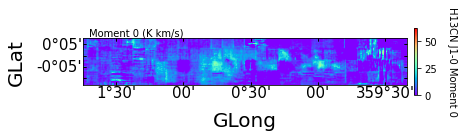

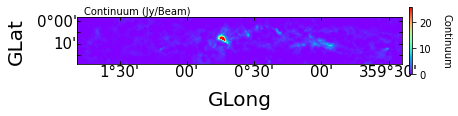

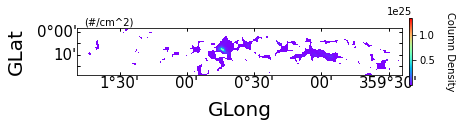

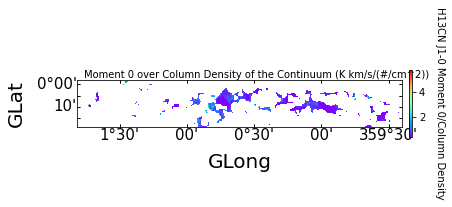

[77] [75] (155, 100)
<class 'float'> <class 'float'> 0.4


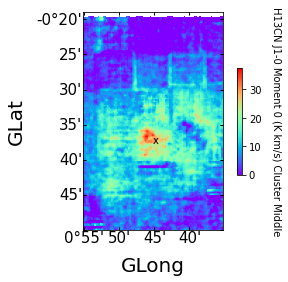

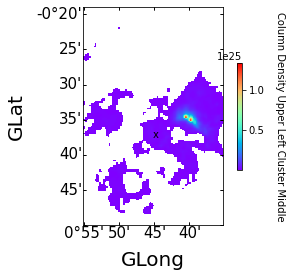

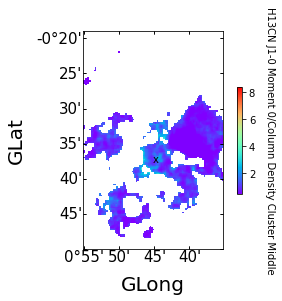

-4.3616155418344285

86338767000.0 Hz
38.98800015444 arcsec 38.98800015444 arcsec
10.55599979032924 pix2
(235,)
11.346667572774335 11.346667572774326 km / s
5.4630245312295695 5.463024531229569 km / s
7.325319707764357 7.325319707764353 km / s
5.4141976148598685 5.4141976148598685 km / s
10.718454854458733 10.718454854458734 km / s
7.672229950909348 7.672229950909349 km / s
5.936413948101479 5.936413948101481 km / s
7.281985968559588 7.281985968559589 km / s
5.847121459075379 5.847121459075379 km / s
4.25263788683181 4.252637886831808 km / s
6.863392749795922 6.86339274979592 km / s
7.355306357926936 7.355306357926933 km / s
7.949613862174524 7.949613862174523 km / s
8.714505969016113 8.714505969016113 km / s
5.5761882483002525 5.576188248300252 km / s
4.689209465076759 4.689209465076758 km / s
4.430090941453657 4.430090941453657 km / s
4.027793805423761 4.027793805423761 km / s
5.323221017714881 5.323221017714881 km / s
8.292361093608992 8.292361093608992 km / s
4.379866196087846 4.37

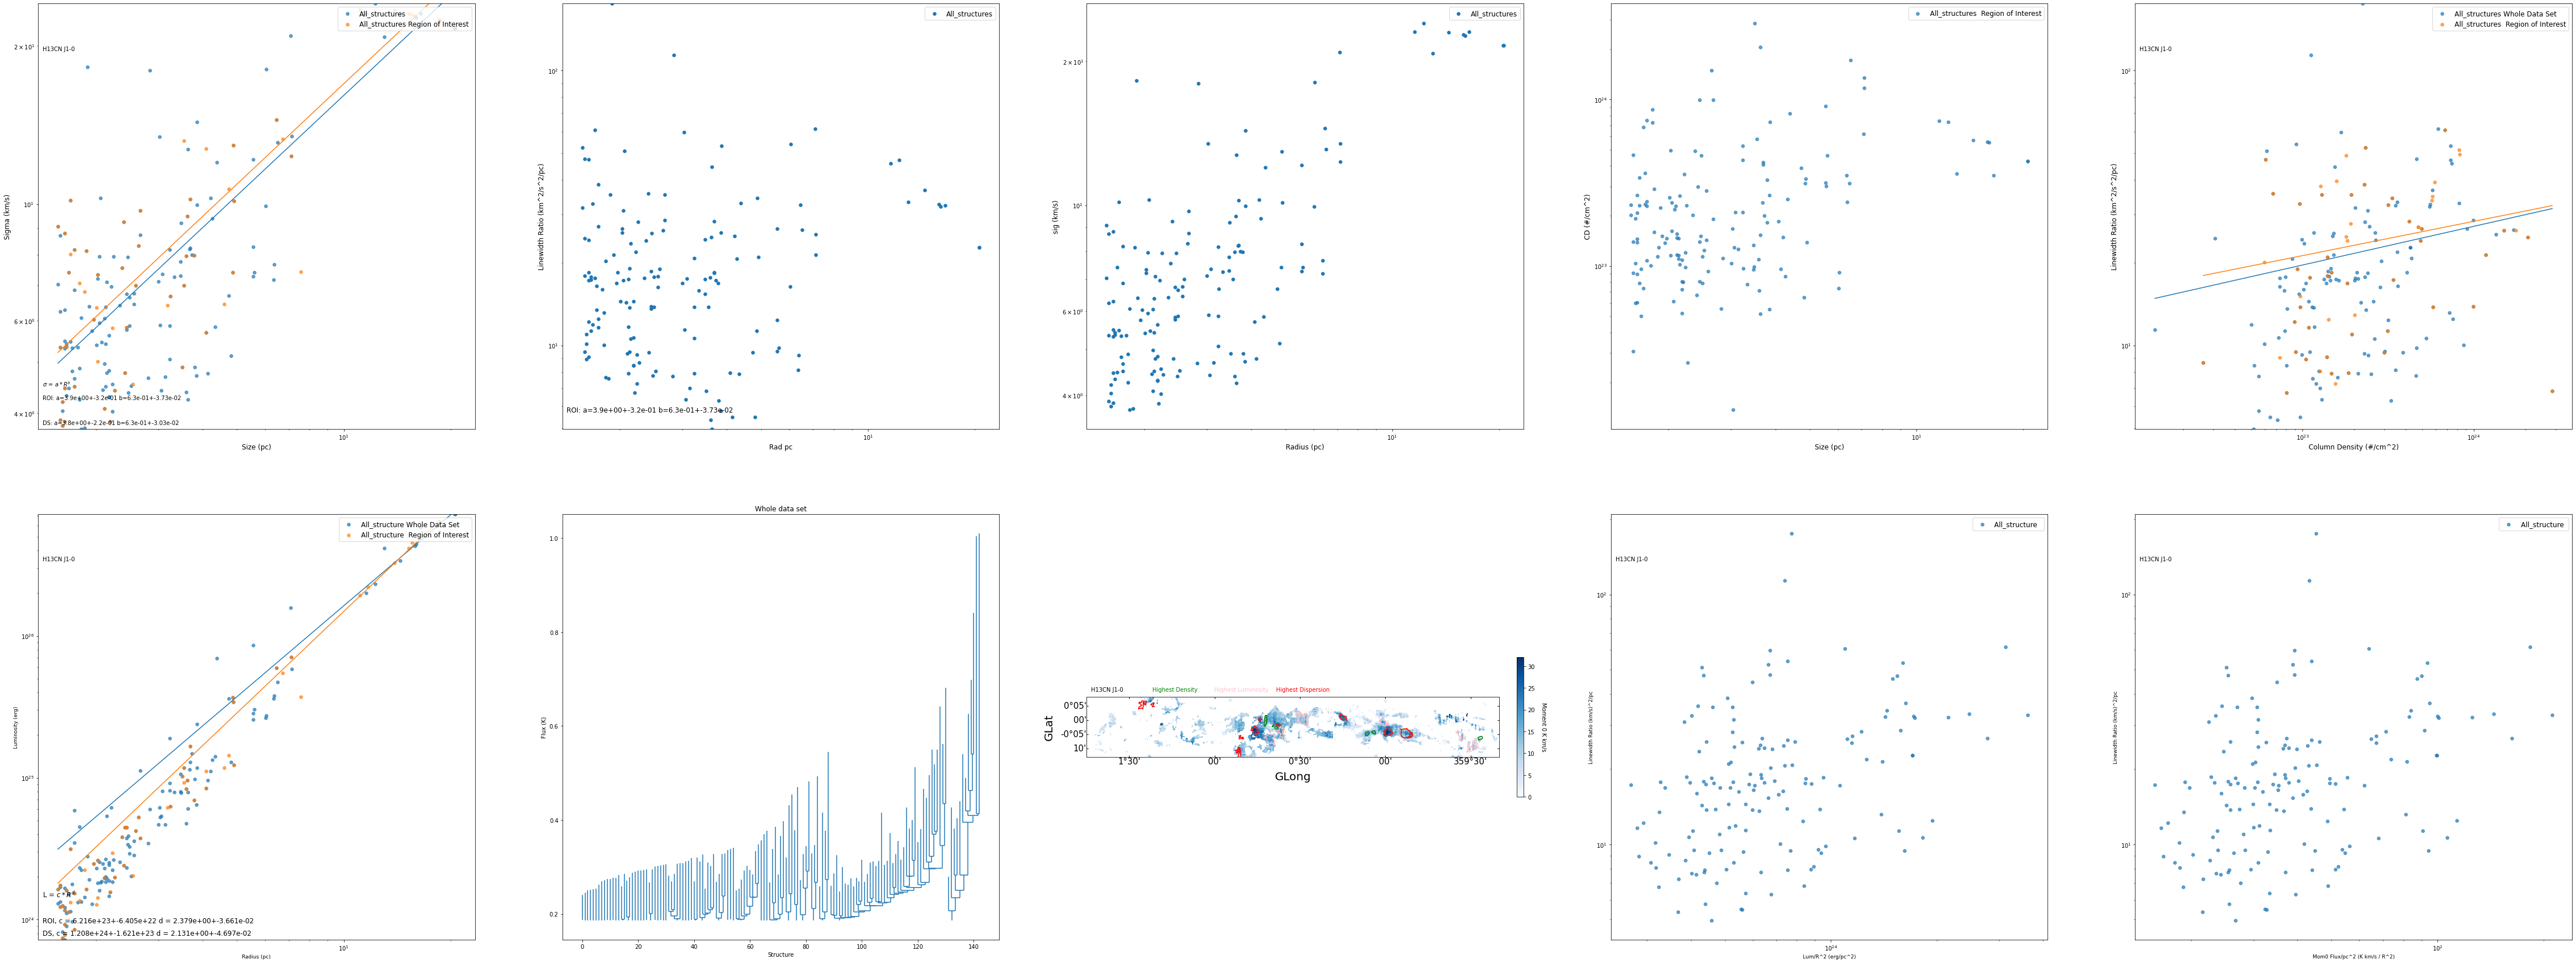

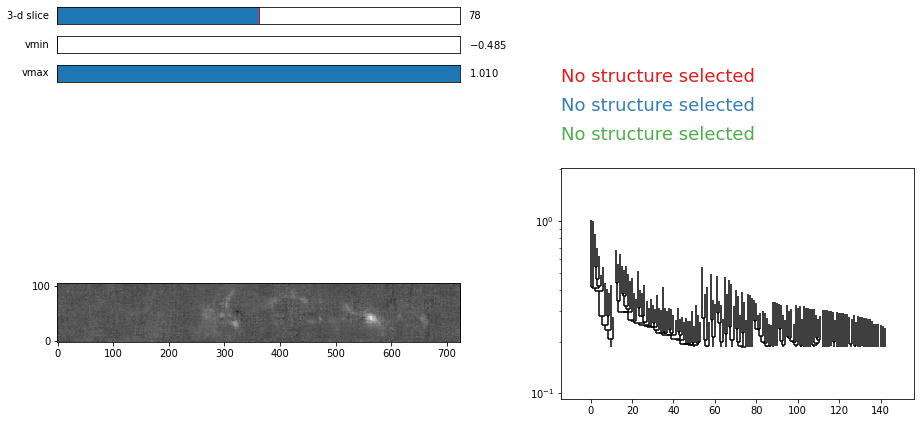

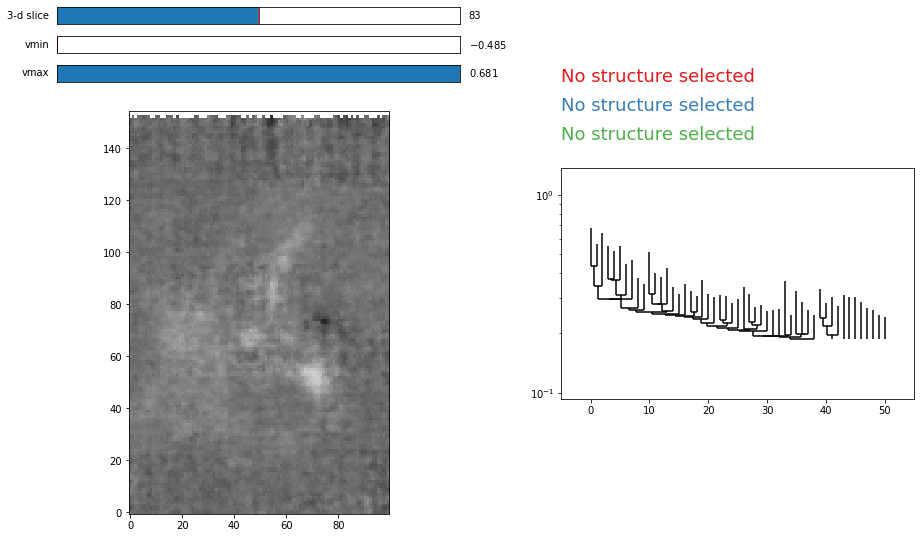

In [20]:
#H13CN


Num = 2
Overlaps=0
Ram_Limiter = 1
Name = "H13CN_1_0_Abs_CMZ"
name = "H13CN_1_0_CM_Contours_DS_10_Abs_CMZ.jpeg"
Num_per_kg= 6.0221409*10**23/(2.8*10**-3)#6.0221409*10**23/29.0180*10**-3#num/kg for h2
LineN="H13CN J1-0"





Names[Num] = Name
NameS = (Name+"Sigmas")
NameR = (Name+"Radii")

np.save("Names_CMZ",Names)

print(Name)


paths = pylab.array(['Fixed_cmz_HCOp.cube.K-kms.pbcor.fits','Fixed_cmz_HCN.cube.reproject.K-kms.pbcor.fits','Fixed_cmz_H13CN.cube.reproject.K-kms.pbcor.fits','Fixed_cmz_H13COp.cube.reproject.K-kms.pbcor.fits',"Fixed_Spliced_CO_V2.fits"])
path = paths[Num]

#pathCont = 'CMZ_Continuum_Reproject.fits'

#path='HCOp_J1-0.cube.fits'
print(path)
Confidences = np.load('Confidence_data_CMZ.npy')

Noises = np.load('Noises_K_CMZ.npy')
#Noises = Ns
m = Noises[Num]
print(m)
#Continuum image

#Put this up here for the column density map


pathCont = 'CMZ_Continuum_Splice.fits'
scCont = spectral_cube.Projection.from_hdu(fits.open(pathCont)[0])
scContW = scCont[30:np.shape(scCont)[0]-30,20:np.shape(scCont)[1]-20] # Make a subcube
#Make subcube
Qp = SpectralCube.read(path).with_spectral_unit(u.km/u.s,velocity_convention="radio")
Qp.allow_huge_operations=True

Q = SpectralCube.read(path).downsample_axis(2,axis=0).with_spectral_unit(u.km/u.s,velocity_convention="radio").spectral_slab(-300. *u.km / u.s, 300. *u.km / u.s)

sc = Q.unmasked_copy()
#scQ = Q
scW = sc.wcs[:][:][0]


dat = sc.hdu.data[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),:,:]
scn = sc[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),:,:]
print(np.shape(dat),np.shape(scn))

datn = dat[5:np.shape(dat)[0]-5,30:np.shape(dat)[1]-30,20:np.shape(dat)[2]-20] # Make a subcube
scF= scn[5:np.shape(dat)[0]-5,30:np.shape(scn)[1]-30,20:np.shape(scn)[2]-20] # Make a subcube

#Do the same thing to the continuum image

metadata = {}
metadata["Cwcs"] = scContW.wcs
print(np.shape(datn),np.shape(scContW))

try:
    #
    sssss=1
except:
    #
    sssss=1
arc_per_pix_yc =  abs(scCont.hdu.header["CDELT1"]*3600.0 * u.arcsec)/u.pix
arc_per_pix_xc =  abs(scCont.hdu.header["CDELT2"]*3600.0 * u.arcsec)/u.pix
beam_majorc =  scCont.hdu.header["BMAJ"]*3600.0 * u.arcsec
beam_minorc =  scCont.hdu.header["BMIN"]*3600.0 * u.arcsec
beam_area_ratioc = beam_minorc*beam_majorc/arc_per_pix_yc/arc_per_pix_xc#This is for FWHM, use *(2*np.sqrt(2*np.log(2)))**2#For gaussian beam

metadata['beam_area_ratioc']=beam_area_ratioc

metadata["arc_per_pix"]= abs(scCont.hdu.header["CDELT1"]*3600.0 * u.arcsec)/u.pix
D_Es = np.load("Pixel_D.npy")*u.Mpc
#print(D_Es)
pc_per_pixelc = abs(scCont.hdu.header["CDELT1"])/180*np.pi*D_Es/u.Mpc


#Cubes with little dense gas and abs
'''
AbpRAD1 = SkyCoord('00h47m32.95s', '-25d17m24.0s', frame='icrs')
AbpRAD2 = SkyCoord('00h47m32.6s', '-25d17m16.0s', frame='icrs')
SCNA= Crop(scn,scW,AbpRAD1,AbpRAD2,5,False)
scContNA = Crop(scCont,scCont.wcs,AbpRAD1,AbpRAD2,0,True)
datna = SCNA.hdu.data 
print(np.shape(SCNA))
'''
UL1 = SkyCoord('00d55m00s',  '-00d50m00s', frame='galactic')#These are away from the sources
UL2 = SkyCoord('00d35m00s','01d30m00s', frame='galactic')
scWCS = scF.wcs[:][:][0]
#scWCSNA = SCNA.wcs[:][:][0]
#moment_0_subNA  = SCNA.moment(order=0,how='slice')            # Calculate the Moment 0 map 
moment_0_sub  = scF.moment(order=0,how='slice')            # Calculate the Moment 0 map 
ROI = Crop(scCont,scCont.wcs,UL1,UL2,5,True)
ROI_Line = Crop(scn,scn.wcs[:][:][0],UL1,UL2,0,False)
moment_0_ROI = ROI_Line.moment(order=0,how='slice')            # Calculate the Moment 0 map 

moment_0_sub  = scF.moment(order=0,how='slice')            # Calculate the Moment 0 map 
######Moment 0 for both
######and cont
Make_Plot((LineN+" Moment 0"),"Moment 0 (K km/s)",moment_0_sub.hdu.data,0,np.nanmax(moment_0_sub.hdu.data),moment_0_sub.wcs,1,1,1,True)
Make_Plot("Continuum","Continuum (Jy/Beam)",scContW.hdu.data,0,np.nanmax(scCont.hdu.data)*.2,scCont.wcs,1,1,1,True)
#Make_Plot((LineN+" Moment 0"),"Moment 0 No Abs Region (K km/s)",moment_0_subNA.hdu.data,0,np.nanmax(moment_0_subNA.hdu.data),moment_0_subNA.wcs,1,1,1,True)


cSD = (Flux_to_Mass(scContW.hdu.data*u.Jy/u.beam/beam_area_ratioc*u.pix**2*u.beam,metadata)/(pc_per_pixelc*10**6*3.086*10**18*u.cm)**2)*(1.989*10**30*u.kg/u.M_sun)*Num_per_kg/u.kg #Flux goes to luminosity for a gaussian beam and goes to column density for square pixels, mass goes to kg to number
rm=moment_0_sub.hdu.data/cSD
rmU = rm*u.K*u.km/u.s#Just put back in the units
rmU = np.array(rmU /(u.K*u.km/u.s)/u.cm**2*10**22,dtype='float64')#Now remove them all
#print(rmU[0][0])
######ratio

Np1 = SkyCoord('359d40m00s',  '00d04m00s', frame='galactic')#These are away from the sources
Np2 = SkyCoord('359d35m00s','00d08m00s', frame='galactic')
NraDP1 = [int(scContW.wcs.world_to_pixel(Np1)[0]),int(scContW.wcs.world_to_pixel(Np1)[1])]
NraDP2 = [int(scContW.wcs.world_to_pixel(Np2)[0]),int(scContW.wcs.world_to_pixel(Np2)[1])]
#print(cSD[NraDP1[1]-50:NraDP2[1]+50,NraDP1[0]-50:NraDP2[0]+50])
#if(str(np.nanmean((cSD[NraDP1[1]-50:NraDP2[1]+50,NraDP1[0]-50:NraDP2[0]+50])))!=str(np.nan)):
#bp = np.where(cSD<=np.nanmean(np.nanstd(cSD[NraDP1[1]-50:NraDP2[1]+50,NraDP1[0]-50:NraDP2[0]+50]))*.001)
bp = np.where(cSD<=7*10**22/u.cm**2)
#bp2 = np.where( moment_0_sub.hdu.data < m*.01)
#print(np.nanmean((cSD[NraDP1[1]-50:NraDP2[1]+50,NraDP1[0]-50:NraDP2[0]+50]))*.001)
cSD[bp]=np.nan
rmU[bp]=np.nan
    #rmU[bp2]=np.nan

#print(cSD[0][0])

#Make_Plot("HCO+ Moment 0/Column Density","Moment 0 over Column Density of the Continuum (K km/s/(#/cm^2))",moment_0_subNA.hdu.data,0,np.nanmax(moment_0_subNA.hdu.data),scCont.wcs,1,1,1,True)
Make_Plot("Column Density","(#/cm^2)",np.array(cSD*u.cm**2,dtype=type(.08)),float(np.nanmin(cSD*u.cm**2)),float(np.nanmax(cSD*u.cm**2)),scCont.wcs,1,1,1,True)
Make_Plot((LineN+" Moment 0/Column Density"),"Moment 0 over Column Density of the Continuum (K km/s/(#/cm^2))",rmU,np.nanmean(rmU)*.5,abs(np.nanmean(rmU))*8,scCont.wcs,1,1,1,True)


#Region of interest in the cont

Find_Pixel_D(ROI.hdu.data,metadata,"Brightest_CD")

D_EROI = np.load("Brightest_CD.npy")*u.Mpc
pc_per_pixelcROI = abs(scCont.hdu.header["CDELT1"])/180*np.pi*D_EROI/u.Mpc

cSDROI = (Flux_to_Mass(ROI.hdu.data*u.Jy/u.beam/beam_area_ratioc*u.pix**2*u.beam,metadata,D_Name = "Brightest_CD.npy")/(pc_per_pixelcROI*10**6*3.086*10**18*u.cm)**2)*(1.989*10**30*u.kg/u.M_sun)*Num_per_kg/u.kg #Flux goes to luminosity for a gaussian beam and goes to column density for square pixels, mass goes to kg to number
rmROI=moment_0_ROI.hdu.data/cSDROI
rmUROI = rmROI*u.K*u.km/u.s#Just put back in the units
rmUROI = np.array(rmUROI /(u.K*u.km/u.s)/u.cm**2*10**22,dtype='float64')#Now remove them all

######ratio
    
#bproi = np.where(cSDROI<=np.nanmean((cSD[NraDP1[1]-50:NraDP2[1]+50,NraDP1[0]-50:NraDP2[0]+50]))*.01)
bproi = np.where(cSDROI<=7*10**22/u.cm**2)
#bp2 = np.where( moment_0_ROI.hdu.data < m*.01)
#print(np.nanmean((cSD[NraDP1[1]-50:NraDP2[1]+50,NraDP1[0]-50:NraDP2[0]+50]))*.01)
cSDROI[bproi]=np.nan
rmUROI[bproi]=np.nan
#rmUROI[bp2]=np.nan

z,yf,xf = np.where(ROI_Line.hdu.data==np.nanmax(ROI_Line.hdu.data))
print(xf,yf,np.shape(ROI.hdu.data))
xf,yf = float(xf/np.shape(ROI.hdu.data)[1]),float(yf/np.shape(ROI.hdu.data)[0])
xf,yf = .5,.4
print(type(xf),type(.5),yf)
Make_Plot_Anno((LineN+" Moment 0 (K km/s) Cluster Middle"),"x",moment_0_ROI.hdu.data,0,np.nanmax(moment_0_ROI.hdu.data),ROI.wcs,1,1,1,True,xf,yf)
Make_Plot_Anno("Column Density Upper Left Cluster Middle","x",np.array(cSDROI*u.cm**2,dtype=type(.08)),float(np.nanmin(cSDROI*u.cm**2)),float(np.nanmax(cSDROI*u.cm**2)),ROI.wcs,1,1,1,True,xf,yf)
Make_Plot_Anno((LineN+" Moment 0/Column Density Cluster Middle"),"x",rmUROI,np.nanmean(rmUROI)*.5,abs(np.nanmean(rmUROI))*8,ROI.wcs,1,1,1,True,xf,yf)


print(np.nanmin(rmU))




header = scF.hdu.header
print()
#make metadata for the dendrogram

try:
    freq = header["RESTFREQ"]*u.Hz#
    metadata['wavelength']=299792458*u.m/header["RESTFREQ"]#
    print(freq)
except:
    freq = header["RESTFRQ"]*u.Hz#
    metadata['wavelength']=299792458*u.m/header["RESTFRQ"]#
metadata['data_unit'] =u.K# header['BUNIT']
metadata['arc_per_pix_y'] =  abs(header["CDELT1"]*3600.0 * u.arcsec)/u.pix
metadata['arc_per_pix_x'] =  abs(header["CDELT2"]*3600.0 * u.arcsec)/u.pix


metadata['beam_major'] =  header["BMAJ"]*3600.0 * u.arcsec
metadata['beam_minor'] =  header["BMIN"]*3600.0 * u.arcsec
beam_area_ratio = metadata['beam_minor']*metadata['beam_major']/metadata['arc_per_pix_y']/metadata['arc_per_pix_x']#This is for FWHM, use *(2*np.sqrt(2*np.log(2)))**2#For gaussian beam
metadata['beam_area_ratio']=beam_area_ratio
metadata['spatial_scale'] = np.sqrt(abs(header["CDELT1"])*u.degree**2*abs(header["CDELT2"]))
area_res = abs(header["CDELT1"])*abs(header["CDELT2"])*(np.pi/180*D_Es/u.Mpc)**2#mpc^2/pix^2

#print(area_res,type(area_res))
print(metadata['beam_minor'],metadata['beam_major'])
print(beam_area_ratio)
#metadata["wcs"] = wcs
metadata["velocity_scale"] = abs(header["CDELT3"])*u.km/u.s#3.3714064157379937*u.km/u.s

metadata["vaxis"]=0



metadata["ARND"] = abs(header["CDELT1"])*abs(header["CDELT2"])








d = astrodendro.Dendrogram.compute(datn,min_delta=m,min_value=m*5,min_npix=50) #The main culprit
#dNA = astrodendro.Dendrogram.compute(datna,min_value=m*5,min_delta=m,min_npix=50) #The main culprit


dUL = astrodendro.Dendrogram.compute(ROI_Line.hdu.data,min_value=m*5,min_delta=m,min_npix=50) #The main culprit



##Analyze dendograms
print(np.shape(d))




fig = plt.figure(1,figsize=(80,80))


axAlpha = pylab.subplot(5, 5, 7)


axGamma = pylab.subplot(5, 5, 9)




p=d.plotter()
p.plot_tree(axAlpha)
axAlpha.set_xlabel("Structure")
axAlpha.set_ylabel("Flux (K)")
axAlpha.set_title("Whole data set")

            
'''

p=dNA.plotter()
p.plot_tree(axBeta)
axBeta.set_xlabel("Structure")
axBeta.set_ylabel("Flux (K)")
axBeta.set_title("No absorption region")

'''
#p=dUL.plotter()
#p.plot_tree(axGamma)
#xGamma.set_xlabel("Structure")
#axGamma.set_ylabel("Flux (K)")
#axGamma.set_title("Region of Interest")
''''''

pc_per_pixel = abs(header["CDELT1"])/180*np.pi*D_Es/u.Mpc

sig_per_pixel=np.nan#metadata['spectral_resolution']/u.pix


#Finds Size, Linewidth, Luminosity, and Column Density of a structure for each structure and returns them in [[][]] arrays [Leaves][Branches]
vel,RA,Dec = scF.world[:,0,0]
Rads,Sigmas,CD,Lumin ,SIDS,MOM0FLUX= Dendro_Arrays(d,datn,vel,scContW.hdu.data,metadata)

#Plot contours for the top ten clusters


scCropped =scF.moment0().hdu.data
scCropped[np.where(scF.moment0().hdu.data<.22)]=np.nan
print(np.nanmean(np.nanstd(scF.moment0().hdu.data))*1)
scCropped[bp]=np.nan
axBeta = pylab.subplot(5,5,8,projection=scF.moment0().wcs)
#axBeta.imshow(scCropped.moment0().hdu.data, origin='lower', interpolation='nearest', cmap=plt.cm.Blues,norm=colors.LogNorm(vmin=5))
imBeta = axBeta.imshow(scCropped, origin='lower', interpolation='nearest', cmap=plt.cm.Blues,vmin=0,vmax = np.nanmax(scCropped)*.7 )



ColumnCon= np.concatenate((CD[0],CD[1]))
SIDScon = np.concatenate((SIDS[0],SIDS[1]))
#nth = sorted(ColumnCon)[len(ColumnCon)-30]
nth = sorted(CD[0])[len(CD[0])-10]
nth2 = sorted(Lumin[0])[len(Lumin[0])-10]
nth3 = sorted(Sigmas[0])[len(Sigmas[0])-10]
#top = np.where(CD[0]>=nth)
#print(list(top))
'''
for n in range(len(ColumnCon)):
    
    if(ColumnCon[n]>=nth):
        #print(n,SIDS[0])
        p.plot_contour(axBeta, structure=int(SIDScon[n]), lw=.1, colors='red')
        #NOT USING LEAVSE FOR STRUCTURES, USING ALL STRUCTURES
        #solved?
'''
G1 = True
G2 = True
G3 = True
for n in range(len(CD[0])):
    
    if(CD[0][n]>=nth):
        #print(n,SIDS[0])
        if(G1):
            G1=False
            p.plot_contour(axBeta, structure=int(SIDS[0][n]), lw=1, colors='green',label="Higest Density")
        else:
            p.plot_contour(axBeta, structure=int(SIDS[0][n]), lw=1, colors='green')
        #NOT USING LEAVSE FOR STRUCTURES, USING ALL STRUCTURES
        #solved?
    if(Lumin[0][n]>=nth2):
        #print(n,SIDS[0])
        if(G2):
            G2=False
            p.plot_contour(axBeta, structure=int(SIDS[0][n]), lw=2, colors="pink",label="Highest Luminosity (Leaves)")
        else:
            p.plot_contour(axBeta, structure=int(SIDS[0][n]), lw=2, colors="pink")
        #NOT USING LEAVSE FOR STRUCTURES, USING ALL STRUCTURES
        #solved?
    if(Sigmas[0][n]>=nth3):
        #print(n,SIDS[0])
        if(G3):
            G3=False
            p.plot_contour(axBeta, structure=int(SIDS[0][n]), lw=3, colors='red',label="Highest Dispersion")
        else:
            p.plot_contour(axBeta, structure=int(SIDS[0][n]), lw=3, colors='red')
        #NOT USING LEAVSE FOR STRUCTURES, USING ALL STRUCTURES
        #solved?
   
  


RA = axBeta.coords[0]                                                                  # 
Dec = axBeta.coords[1]

RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('GLong',fontsize=20,labelpad=1)                               
pylab.ylabel('GLat',fontsize=20,labelpad=1)
axBeta.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(imBeta,fraction=0.016,pad=0.04)                                     
cb.set_label(label="Moment 0 K km/s",fontsize=10,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)   
pylab.annotate(s=LineN,fontsize=10,xy=(.01,1.1),xycoords="axes fraction",c="black")  
pylab.annotate(s="Highest Density",fontsize=10,xy=(.16,1.1),xycoords="axes fraction",c="green")  
pylab.annotate(s="Highest Luminosity",fontsize=10,xy=(.31,1.1),xycoords="axes fraction",c="pink")  
pylab.annotate(s="Highest Dispersion",fontsize=10,xy=(.46,1.1),xycoords="axes fraction",c="red")  

    
    
    
    
#RadsNA,SigmasNA,CDNA,LuminNA = Dendro_Arrays(dNA,datna,vel,scContNA.hdu.data,metadata)
RadsUL,SigmasUL,CDUL,LuminUL,SIDSUL,MOM0FLUXUL = Dendro_Arrays(dUL,ROI_Line.hdu.data,vel,ROI.hdu.data,metadata)


#def Dendro_Arrays(Dendrogram,LineData,DataVel,ContData,metadata):
    

from scipy.optimize import curve_fit
from scipy.optimize import leastsq

def func(R,a,b):
    return a*R**(b)
try:
    popt, pcov = curve_fit(func, Rads[0]*10**6,Sigmas[0])
except:
    popt, pcov = [np.nan,np.nan],[[np.nan,np.nan],[np.nan,np.nan]]
try:
    poptB, pcovB = curve_fit(func,  Rads[1]*10**6,Sigmas[1])
except:
    poptB, pcovB = [np.nan,np.nan],[[np.nan,np.nan],[np.nan,np.nan]]


    
Rcon = np.concatenate((Rads[0],Rads[1]))
Scon = np.concatenate((Sigmas[0],Sigmas[1]))
print(np.shape(Rcon))
poptCon, pcovCon = curve_fit(func, Rcon*10**6, Scon)







    
RconUL = np.concatenate((RadsUL[0],RadsUL[1]))
SconUL = np.concatenate((SigmasUL[0],SigmasUL[1]))

poptUL, pcovUL = curve_fit(func, RconUL*10**6, SconUL)



xs=np.linspace(np.nanmin(Rcon*10**6),np.nanmax(Rcon*10**6),50)
ysL,ysB,ysCon=func(xs,popt[0],popt[1]),func(xs,poptB[0],poptB[1]),func(xs,poptCon[0],poptCon[1])



LuminCon = np.concatenate((Lumin[0],Lumin[1]))

MOM0FLUXcon = np.concatenate((MOM0FLUX[0],MOM0FLUX[1]))
#Flux ratios fit
#FRpopt,FRpcov = curve_fit(func, abs(FRs),Scon**2/Rcon/10**6)
#xsF=np.linspace(np.nanmin(abs(FRs)),np.nanmax(abs(FRs)),50)
#ysF = func(xsF,FRpopt[0],FRpopt[1])

#Radius Luminosity fit
gp = np.where(LuminCon>0)
print(np.shape(Rcon),np.shape(LuminCon))
lgp = LuminCon[gp]
radgp = Rcon[gp]*10**6
#print(np.shape(Rcon[gp]*10**6),np.shape(LuminCon[gp]))
RLpopt,RLpcov = curve_fit(func, np.array(radgp,dtype='float64'),np.array(lgp,dtype='float64'),maxfev=999999,p0 = np.array([10**27,1],dtype='float64'),ftol = 10**-10)

xsRL=np.linspace(np.nanmin(radgp),np.nanmax(radgp),50)
ysRL = func(xsRL,RLpopt[0],RLpopt[1])



#Column density to Size-linewidth
gp2 = np.where(ColumnCon>0)

cgp = ColumnCon[gp2]
radgpFORRAT = Rcon[gp2]*10**6
siggpFORRAT = Scon[gp2]


lumFORRAT = LuminCon[gp2]
mom0FORRAT = MOM0FLUXcon[gp2]
rgp=Scon[gp2]**2/Rcon[gp2]/10**6

gp3 = np.where(lumFORRAT>0)
lumFORRAT = lumFORRAT[gp3]
rgpFORRAT = rgp[gp3]
mom0FORRAT = mom0FORRAT[gp3]
CDpopt,CDpcov = curve_fit(func, np.array(cgp,dtype='float64') ,np.array(rgp,dtype='float64'),maxfev=9999099,p0 = np.array([10,.01],dtype='float64'),ftol = 10**-10)
xsCD=np.linspace(np.nanmin(cgp),np.nanmax(cgp),50)
ysCD = func(xsCD,CDpopt[0],CDpopt[1])


print(poptCon,pcovCon,"Size Linewidth All_structures:")
print("a = ",poptCon[0],"+-",np.sqrt(pcovCon[0][0]))
print("b = ",poptCon[1],"+-",np.sqrt(pcovCon[1][1]))



print(RLpopt,RLpcov,"Radius to Luminosity:")
print("c = ",RLpopt[0],"+-",np.sqrt(RLpcov[0][0]))
print("d = ",RLpopt[1],"+-",np.sqrt(RLpcov[1][1]))






print(CDpopt,CDpcov,"Column Density to linewidth^2/size:")
print("e = ",CDpopt[0],"+-",np.sqrt(CDpcov[0][0]))
print("f = ",CDpopt[1],"+-",np.sqrt(CDpcov[1][1]))



ax2 = pylab.subplot(5, 5, 1)
ax3 = pylab.subplot(5, 5, 2)
ax4 = pylab.subplot(5, 5, 3)



print(np.shape(Rcon*10**6),np.shape(Scon),np.shape(Rads[0]*10**6),np.shape(Sigmas[0]),np.shape(Rads[1]*10**6),np.shape(Sigmas[1]),type(Rads[0]))
#xpcon,xpL,xpB = ax2.scatter(Rcon*10**6,Scon,label="All_structures",s=30),ax2.scatter(Rads[0]*10**6,Sigmas[0],s=30),ax2.scatter(Rads[1]*10**6,Sigmas[1],s=30)
xpcon = ax2.scatter(Rcon*10**6,Scon,label="All_structures",s=30,alpha=.7)
#p,p2,p3 = ax2.plot(xs,ysCon),ax2.plot(xs,ysL),ax2.plot(xs,ysB)
p = ax2.plot(xs,ysCon)

#pNA = ax2.plot(xsNA,ysNA)
#xpNA = ax2.scatter(RconNA*10**6,SconNA,label="All_structures Sparse region",s=30,alpha=.7)

xpconhh = ax2.scatter(RconUL*10**6,SconUL,label="All_structures Region of Interest",s=30,alpha=.7)
xsUL=np.linspace(np.nanmin(RconUL*10**6),np.nanmax(RconUL*10**6),50)
ysUL=func(xsUL,poptUL[0],poptUL[1])
p22 = ax2.plot(xsUL,ysUL)


st="DS: a="+ str(np.format_float_scientific(poptCon[0],1))+"+-"+str(np.format_float_scientific(np.sqrt(pcovCon[0][0]),1))+" b="+str(np.format_float_scientific(poptCon[1],1))+"+-"+str(np.format_float_scientific(np.sqrt(pcovCon[1][1]),2))
ax2.annotate(s=st,fontsize=10,xy=(0.01,0.01),xycoords="axes fraction")

st="ROI: a="+ str(np.format_float_scientific(poptUL[0],1))+"+-"+str(np.format_float_scientific(np.sqrt(pcovUL[0][0]),1))+" b="+str(np.format_float_scientific(poptUL[1],1))+"+-"+str(np.format_float_scientific(np.sqrt(pcovUL[1][1]),2))
ax2.annotate(s=st,fontsize=10,xy=(0.01,0.07),xycoords="axes fraction")
ax2.annotate(s=r'$\sigma$ = $a*R^b$',fontsize=10,xy=(0.01,0.10),xycoords="axes fraction")
ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.set_ylim(np.nanmin(Scon),np.nanmax(Scon))
ax2.set_xlabel("Size (pc)",fontsize=12)
ax2.set_ylabel("Sigma (km/s)",fontsize=12)
ax2.legend(prop={'size': 12},loc="upper right")
ax2.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")

#gp = np.where(FRs>0)





xspF = ax3.scatter(radgpFORRAT,rgp,label="All_structures",s=30)
#pF = ax3.plot(xsCD,ysCD)
#ax3.annotate(s=r'$\sigma^2/R$ = $e*N^f$',fontsize=12,xy=(0.01,0.07),xycoords="axes fraction")
#st = "e = "+ str(np.format_float_scientific(CDpopt[0],3))+"+-"+str(np.format_float_scientific(np.sqrt(CDpcov[0][0]),3))+" f = "+str(np.format_float_scientific(CDpopt[1],3))+"+-"+str(np.format_float_scientific(np.sqrt(CDpcov[1][1]),3))

ax3.annotate(s=st,fontsize=12,xy=(0.01,0.04),xycoords="axes fraction")
ax3.set_yscale('log')
ax3.set_xscale('log')
ax3.set_ylim(np.nanmin(rgp),np.nanmax(rgp))
ax3.set_xlabel("Rad pc",fontsize=12)
ax3.set_ylabel("Linewidth Ratio (km^2/s^2/pc)",fontsize=12)
ax3.legend(prop={'size': 12})



xspL = ax4.scatter(radgpFORRAT,siggpFORRAT,label="All_structures",s=30)
#pFLL = ax4.plot(xsRL,ysRL)

#st = "c = "+ str(np.format_float_scientific(RLpopt[0],3))+"+-"+str(np.format_float_scientific(np.sqrt(RLpcov[0][0]),3))+" d = "+str(np.format_float_scientific(RLpopt[1],3))+"+-"+str(np.format_float_scientific(np.sqrt(RLpcov[1][1]),3))
#ax4.annotate(s='L = $c*R^d$',fontsize=12,xy=(0.01,0.07),xycoords="axes fraction")
#ax4.annotate(s=st,fontsize=12,xy=(0.01,0.04),xycoords="axes fraction")

ax4.set_yscale('log')
ax4.set_xscale('log')
#ax4.set_ylim(np.nanmin(lgp),np.nanmax(lgp))
ax4.set_xlabel("Radius (pc)",fontsize=12)
ax4.set_ylabel("sig (km/s)",fontsize=12)
ax4.legend(prop={'size': 12},loc="upper right")














LuminConUL = np.concatenate((LuminUL[0],LuminUL[1]))
ColumnConUL= np.concatenate((CDUL[0],CDUL[1]))

#Radius Luminosity fit
gp = np.where(LuminConUL>0)
lgpUL = LuminConUL[gp]
radgpUL = RconUL[gp]*10**6
print(np.shape(radgpUL),np.shape(lgpUL))
RLpoptUL,RLpcovUL = curve_fit(func, np.array(radgpUL,dtype='float64'),np.array(lgpUL,dtype='float64'),maxfev=999999,p0 = np.array([10**27,1],dtype='float64'),ftol = 10**-10)

xsRLUL=np.linspace(np.nanmin(radgpUL),np.nanmax(radgpUL),50)
ysRLUL = func(xsRLUL,RLpoptUL[0],RLpoptUL[1])

#Column density to Size-linewidth
gp2 = np.where(ColumnConUL>0)
cgpUL = ColumnConUL[gp2]
rgpUL=SconUL[gp2]**2/RconUL[gp2]/10**6
CDpoptUL,CDpcovUL = curve_fit(func, np.array(cgpUL,dtype='float64') ,np.array(rgpUL,dtype='float64'),maxfev=9999099,p0 = np.array([10,.01],dtype='float64'),ftol = 10**-10)
xsCDUL=np.linspace(np.nanmin(cgpUL),np.nanmax(cgpUL),50)
ysCDUL = func(xsCDUL,CDpoptUL[0],CDpoptUL[1])

print(poptUL,pcovUL,"Size Linewidth Region of Interest:")
print("a = ",poptUL[0],"+-",np.sqrt(pcovUL[0][0]))
print("b = ",poptUL[1],"+-",np.sqrt(pcovUL[1][1]))

print(RLpoptUL,RLpcovUL,"Radius to Luminosity  Region of Interest:")
print("c = ",RLpoptUL[0],"+-",np.sqrt(RLpcovUL[0][0]))
print("d = ",RLpoptUL[1],"+-",np.sqrt(RLpcovUL[1][1]))


ax5 = pylab.subplot(5, 5, 4)
ax6 = pylab.subplot(5, 5, 5)
ax7 = pylab.subplot(5, 5, 6)




xpconhh = ax5.scatter(radgpFORRAT,cgp,label="All_structures  Region of Interest",s=30,alpha=.7)
#p2 = ax5.plot(xsUL,ysUL)


ax5.set_yscale('log')
ax5.set_xscale('log')
#ax5.set_ylim(np.nanmin(Scon),np.nanmax(Scon))
ax5.set_xlabel("Size (pc)",fontsize=12)
ax5.set_ylabel("CD (#/cm^2)",fontsize=12)
ax5.legend(prop={'size': 12},loc="upper right")


#gp = np.where(FRs>0)



xspFUL2 = ax6.scatter(cgp,rgp,label="All_structures Whole Data Set",s=30,alpha=.7)
pFUL2 = ax6.plot(xsCD,ysCD)


#xspFNA = ax6.scatter(cgpNA,rgpNA,label="All_structures Sparse Region",s=30,alpha=.7)
#pFNA = ax6.plot(xsCDNA,ysCDNA)


xspFUL = ax6.scatter(cgpUL,rgpUL,label="All_structures  Region of Interest",s=30,alpha=.7)
pFUL = ax6.plot(xsCDUL,ysCDUL)

#ax6.annotate(s=st,fontsize=12,xy=(0.01,0.06),xycoords="axes fraction")
ax6.set_yscale('log')
ax6.set_xscale('log')
ax6.set_ylim(np.nanmin(rgp),np.nanmax(rgp))
ax6.set_xlabel("Column Density (#/cm^2)",fontsize=12)
ax6.set_ylabel("Linewidth Ratio (km^2/s^2/pc)",fontsize=12)
ax6.legend(prop={'size': 12},loc="upper right")
ax6.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")




xspLu2 = ax7.scatter(radgp,lgp,label="All_structure Whole Data Set",s=30,alpha=.7)
pFLLu2 = ax7.plot(xsRL,ysRL)
#xspLu2NA = ax7.scatter(radgpNA,lgpNA,label="All_structure Sparse Region",s=30,alpha=.7)
#pFLLu2NA = ax7.plot(xsRLNA,ysRLNA)

xspLu = ax7.scatter(radgpUL,lgpUL,label="All_structure  Region of Interest",s=30,alpha=.7)

pFLLu = ax7.plot(xsRLUL,ysRLUL)


st = "DS, c = "+ str(np.format_float_scientific(RLpopt[0],3))+"+-"+str(np.format_float_scientific(np.sqrt(RLpcov[0][0]),3))+" d = "+str(np.format_float_scientific(RLpopt[1],3))+"+-"+str(np.format_float_scientific(np.sqrt(RLpcov[1][1]),3))
ax7.annotate(s='L = $c*R^d$',fontsize=12,xy=(0.01,0.10),xycoords="axes fraction")
ax7.annotate(s=st,fontsize=12,xy=(0.01,0.01),xycoords="axes fraction")
st2 = "ROI, c = "+ str(np.format_float_scientific(RLpoptUL[0],3))+"+-"+str(np.format_float_scientific(np.sqrt(RLpcovUL[0][0]),3))+" d = "+str(np.format_float_scientific(RLpoptUL[1],3))+"+-"+str(np.format_float_scientific(np.sqrt(RLpcovUL[1][1]),3))
ax7.annotate(s=st2,fontsize=12,xy=(0.01,0.04),xycoords="axes fraction")

#st3 = "SR, c = "+ str(np.format_float_scientific(RLpoptNA[0],3))+"+-"+str(np.format_float_scientific(np.sqrt(RLpcovNA[0][0]),3))+" d = "+str(np.format_float_scientific(RLpoptNA[1],3))+"+-"+str(np.format_float_scientific(np.sqrt(RLpcovNA[1][1]),3))
#ax7.annotate(s=st3,fontsize=12,xy=(0.01,0.07),xycoords="axes fraction")

ax7.set_yscale('log')
ax7.set_xscale('log')
ax7.set_ylim(np.nanmin(lgp),np.nanmax(lgp))
ax7.set_xlabel("Radius (pc)",fontsize=9)
ax7.set_ylabel("Luminosity (erg)",fontsize=9)
ax7.legend(prop={'size': 12},loc="upper right")
ax7.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")

#print(FRs)



lum_rat = axGamma.scatter(lumFORRAT/radgpFORRAT**2,rgpFORRAT,label="All_structure  ",s=30,alpha=.7)
#Off by factors for area, simply using r^2

axGamma.set_yscale('log')
axGamma.set_xscale('log')
axGamma.set_xlabel("Lum/R^2 (erg/pc^2)",fontsize=9)
axGamma.set_ylabel("Linewidth Ratio (km/s)^2/pc",fontsize=9)
axGamma.legend(prop={'size': 12},loc="upper right")
axGamma.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")



axDelta = pylab.subplot(5, 5, 10)



#mom0_rat = axDelta.scatter(mom0FORRAT/radgpFORRAT**2,rgpFORRAT,label="All_structure  Region of Interest",s=30,alpha=.7)
gp4=np.where(MOM0FLUXcon>0)
mom0FORFlux=MOM0FLUXcon[gp4]
radgpFORFlux=Rcon[gp4]*10**6
rgpFORFlux=Scon[gp4]**2/Rcon[gp4]/10**6
mom0_rat = axDelta.scatter(mom0FORFlux/radgpFORFlux**2,rgpFORFlux,label="All_structure ",s=30,alpha=.7)
#Off by factors for area, simply using r^2

axDelta.set_yscale('log')
axDelta.set_xscale('log')
axDelta.set_xlabel("Mom0 Flux/pc^2 (K km/s / R^2)",fontsize=9)
axDelta.set_ylabel("Linewidth Ratio (km/s)^2/pc",fontsize=9)
axDelta.legend(prop={'size': 12},loc="upper right")
axDelta.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")


pylab.show()


NameCol = (Name+"_Column")
NameLum = (Name+"_Luminosities")

NameColROI = (Name+"_Column_ROI")
NameLumROI = (Name+"_Luminosities_ROI")
NameRROI = (NameR+"_ROI")
NameSROI = (NameS+"_ROI")
NameFlux = (Name+"Flux_Dense")
NameRFF = (Name+"Rad_For_Flux")

v1 = d.viewer()
v1.show()
v3 = dUL.viewer()
v3.show()

np.save(NameCol,CD)
np.save(NameLum,Lumin)

np.save(NameS,Sigmas)
np.save(NameR,Rads) #Still in [leaves] [breanches] format

np.save(NameColROI,CDUL)
np.save(NameLumROI,LuminUL)

np.save(NameSROI,SigmasUL)
np.save(NameRROI,RadsUL) #Still in [leaves] [breanches] format

np.save(NameFlux,mom0FORFlux/radgpFORFlux**2)
np.save(NameRFF,rgpFORFlux)



H13CoP_1_0_Abs_CMZ
Fixed_cmz_H13COp.cube.reproject.K-kms.pbcor.fits
0.035991421159583294
(166, 165, 765) (166, 165, 765)
(156, 105, 725) (105, 725)


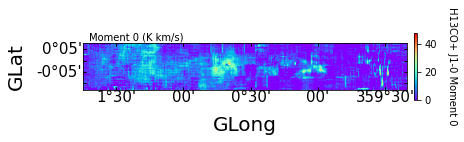

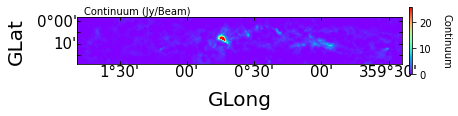

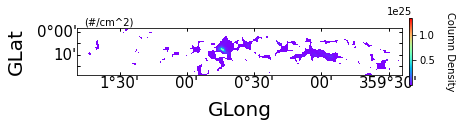

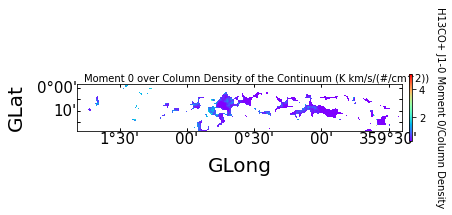

[76] [74] (155, 100)
<class 'float'> <class 'float'> 0.4


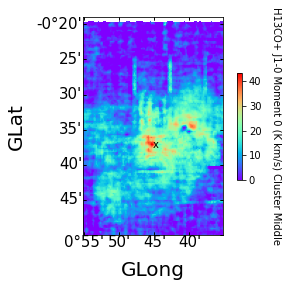

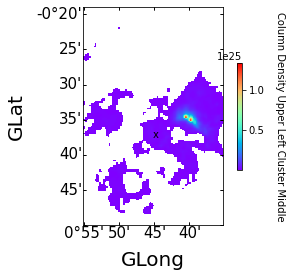

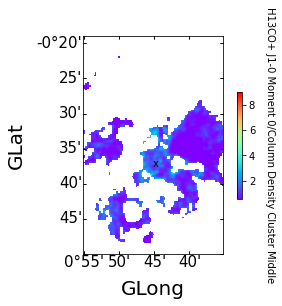

-7.231617807009137

86846998000.0 Hz
38.98800015444 arcsec 38.98800015444 arcsec
10.55599979032924 pix2
(240,)
6.493667337474348
(126,)
(126,) (126,)
[4.42079281 0.3717719 ] [[ 0.07058808 -0.00768526]
 [-0.00768526  0.00104254]] Size Linewidth All_structures:
a =  4.420792813196926 +- 0.26568416626363767
b =  0.371771900128455 +- 0.03228831635225995
[7.15513851e+23 2.21148318e+00] [[ 1.39194278e+46 -6.77336626e+21]
 [-6.77336626e+21  3.31794710e-03]] Radius to Luminosity:
c =  7.155138509602177e+23 +- 1.1798062472893227e+23
d =  2.211483178279715 +- 0.05760162408335557
[ 1.79514726e+01 -2.34211536e-03] [[ 2.07121211e+03 -2.15514420e+00]
 [-2.15514420e+00  2.24377966e-03]] Column Density to linewidth^2/size:
e =  17.951472581754736 +- 45.510571410051575
f =  -0.0023421153603119197 +- 0.04736855138445556
(126,) (126,) (78,) (78,) (48,) (48,) <class 'numpy.ndarray'>
(39,) (39,)
[4.04549339 0.5004734 ] [[ 0.24717118 -0.02768626]
 [-0.02768626  0.00365686]] Size Linewidth Region of Interest

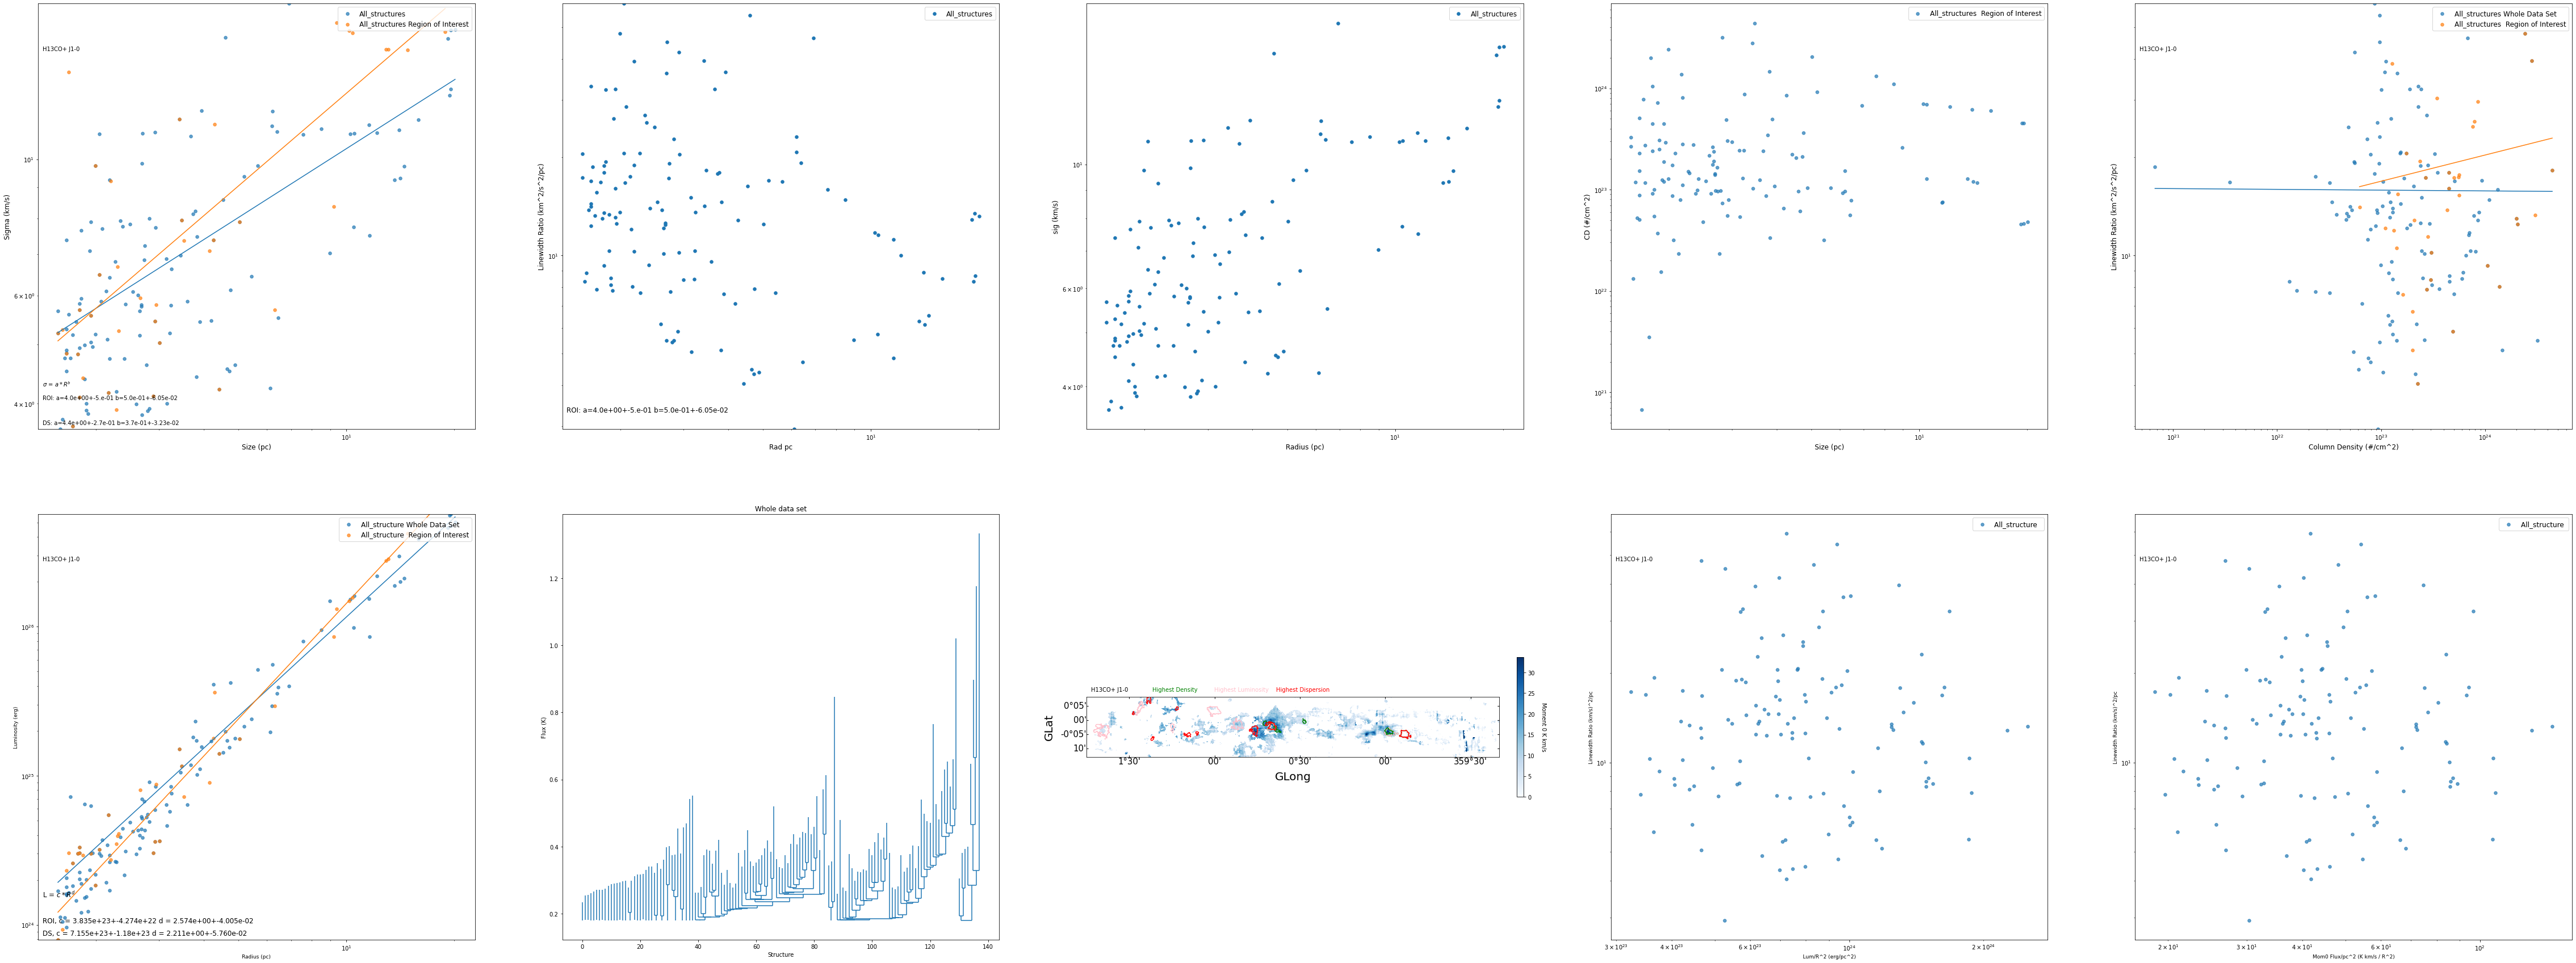

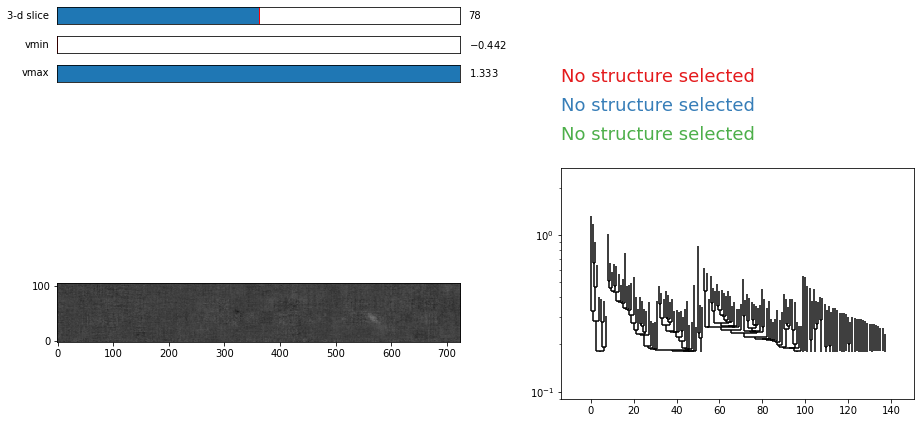

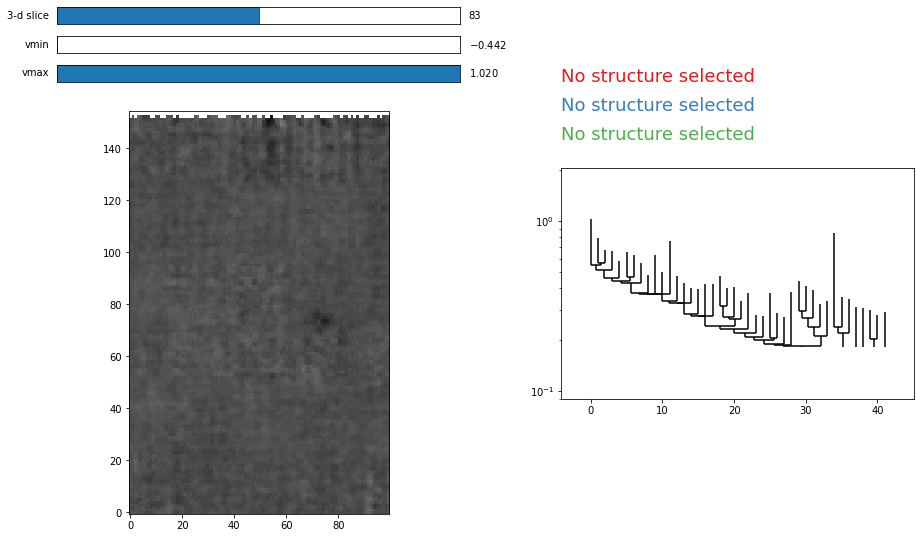

In [13]:
#H13CoP


Num = 3
Overlaps=0
Ram_Limiter = 1
Name = "H13CoP_1_0_Abs_CMZ"
name = "H13CoP_1_0_CM_Contours_DS_10_Abs_CMZ.jpeg"
Num_per_kg= 6.0221409*10**23/(2.8*10**-3)#6.0221409*10**23/29.0180*10**-3#num/kg for h2
LineN="H13CO+ J1-0"

Names = np.load("Names_CMZ.npy")
Names[Num] = Name
NameS = (Name+"Sigmas")
NameR = (Name+"Radii")

np.save("Names_CMZ",Names)

print(Name)


paths = pylab.array(['Fixed_cmz_HCOp.cube.K-kms.pbcor.fits','Fixed_cmz_HCN.cube.reproject.K-kms.pbcor.fits','Fixed_cmz_H13CN.cube.reproject.K-kms.pbcor.fits','Fixed_cmz_H13COp.cube.reproject.K-kms.pbcor.fits',"Fixed_Spliced_CO_V2.fits"])
path = paths[Num]

#pathCont = 'CMZ_Continuum_Reproject.fits'

#path='HCOp_J1-0.cube.fits'
print(path)
Confidences = np.load('Confidence_data_CMZ.npy')

Noises = np.load('Noises_K_CMZ.npy')
#Noises = Ns
m = Noises[Num]
print(m)
#Continuum image

#Put this up here for the column density map


pathCont = 'CMZ_Continuum_Splice.fits'
scCont = spectral_cube.Projection.from_hdu(fits.open(pathCont)[0])
scContW = scCont[30:np.shape(scCont)[0]-30,20:np.shape(scCont)[1]-20] # Make a subcube
#Make subcube
Qp = SpectralCube.read(path).with_spectral_unit(u.km/u.s,velocity_convention="radio")
Qp.allow_huge_operations=True

Q = SpectralCube.read(path).downsample_axis(2,axis=0).with_spectral_unit(u.km/u.s,velocity_convention="radio").spectral_slab(-300. *u.km / u.s, 300. *u.km / u.s)

sc = Q.unmasked_copy()
#scQ = Q
scW = sc.wcs[:][:][0]


dat = sc.hdu.data[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),:,:]
scn = sc[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),:,:]
print(np.shape(dat),np.shape(scn))

datn = dat[5:np.shape(dat)[0]-5,30:np.shape(dat)[1]-30,20:np.shape(dat)[2]-20] # Make a subcube
scF= scn[5:np.shape(dat)[0]-5,30:np.shape(scn)[1]-30,20:np.shape(scn)[2]-20] # Make a subcube

#Do the same thing to the continuum image

metadata = {}
metadata["Cwcs"] = scContW.wcs
print(np.shape(datn),np.shape(scContW))

try:
    #
    sssss=1
except:
    #
    sssss=1
arc_per_pix_yc =  abs(scCont.hdu.header["CDELT1"]*3600.0 * u.arcsec)/u.pix
arc_per_pix_xc =  abs(scCont.hdu.header["CDELT2"]*3600.0 * u.arcsec)/u.pix
beam_majorc =  scCont.hdu.header["BMAJ"]*3600.0 * u.arcsec
beam_minorc =  scCont.hdu.header["BMIN"]*3600.0 * u.arcsec
beam_area_ratioc = beam_minorc*beam_majorc/arc_per_pix_yc/arc_per_pix_xc#This is for FWHM, use *(2*np.sqrt(2*np.log(2)))**2#For gaussian beam

metadata['beam_area_ratioc']=beam_area_ratioc

metadata["arc_per_pix"]= abs(scCont.hdu.header["CDELT1"]*3600.0 * u.arcsec)/u.pix
D_Es = np.load("Pixel_D.npy")*u.Mpc
#print(D_Es)
pc_per_pixelc = abs(scCont.hdu.header["CDELT1"])/180*np.pi*D_Es/u.Mpc


#Cubes with little dense gas and abs
'''
AbpRAD1 = SkyCoord('00h47m32.95s', '-25d17m24.0s', frame='icrs')
AbpRAD2 = SkyCoord('00h47m32.6s', '-25d17m16.0s', frame='icrs')
SCNA= Crop(scn,scW,AbpRAD1,AbpRAD2,5,False)
scContNA = Crop(scCont,scCont.wcs,AbpRAD1,AbpRAD2,0,True)
datna = SCNA.hdu.data 
print(np.shape(SCNA))
'''
UL1 = SkyCoord('00d55m00s',  '-00d50m00s', frame='galactic')#These are away from the sources
UL2 = SkyCoord('00d35m00s','01d30m00s', frame='galactic')
scWCS = scF.wcs[:][:][0]
#scWCSNA = SCNA.wcs[:][:][0]
#moment_0_subNA  = SCNA.moment(order=0,how='slice')            # Calculate the Moment 0 map 
moment_0_sub  = scF.moment(order=0,how='slice')            # Calculate the Moment 0 map 
ROI = Crop(scCont,scCont.wcs,UL1,UL2,5,True)
ROI_Line = Crop(scn,scn.wcs[:][:][0],UL1,UL2,0,False)
moment_0_ROI = ROI_Line.moment(order=0,how='slice')            # Calculate the Moment 0 map 

moment_0_sub  = scF.moment(order=0,how='slice')            # Calculate the Moment 0 map 
######Moment 0 for both
######and cont
Make_Plot((LineN+" Moment 0"),"Moment 0 (K km/s)",moment_0_sub.hdu.data,0,np.nanmax(moment_0_sub.hdu.data),moment_0_sub.wcs,1,1,1,True)
Make_Plot("Continuum","Continuum (Jy/Beam)",scContW.hdu.data,0,np.nanmax(scCont.hdu.data)*.2,scCont.wcs,1,1,1,True)
#Make_Plot((LineN+" Moment 0"),"Moment 0 No Abs Region (K km/s)",moment_0_subNA.hdu.data,0,np.nanmax(moment_0_subNA.hdu.data),moment_0_subNA.wcs,1,1,1,True)


cSD = (Flux_to_Mass(scContW.hdu.data*u.Jy/u.beam/beam_area_ratioc*u.pix**2*u.beam,metadata)/(pc_per_pixelc*10**6*3.086*10**18*u.cm)**2)*(1.989*10**30*u.kg/u.M_sun)*Num_per_kg/u.kg #Flux goes to luminosity for a gaussian beam and goes to column density for square pixels, mass goes to kg to number
rm=moment_0_sub.hdu.data/cSD
rmU = rm*u.K*u.km/u.s#Just put back in the units
rmU = np.array(rmU /(u.K*u.km/u.s)/u.cm**2*10**22,dtype='float64')#Now remove them all
#print(rmU[0][0])
######ratio

Np1 = SkyCoord('359d40m00s',  '00d04m00s', frame='galactic')#These are away from the sources
Np2 = SkyCoord('359d35m00s','00d08m00s', frame='galactic')
NraDP1 = [int(scContW.wcs.world_to_pixel(Np1)[0]),int(scContW.wcs.world_to_pixel(Np1)[1])]
NraDP2 = [int(scContW.wcs.world_to_pixel(Np2)[0]),int(scContW.wcs.world_to_pixel(Np2)[1])]
#print(cSD[NraDP1[1]-50:NraDP2[1]+50,NraDP1[0]-50:NraDP2[0]+50])
#if(str(np.nanmean((cSD[NraDP1[1]-50:NraDP2[1]+50,NraDP1[0]-50:NraDP2[0]+50])))!=str(np.nan)):
#bp = np.where(cSD<=np.nanmean(np.nanstd(cSD[NraDP1[1]-50:NraDP2[1]+50,NraDP1[0]-50:NraDP2[0]+50]))*.001)
bp = np.where(cSD<=7*10**22/u.cm**2)
#bp2 = np.where( moment_0_sub.hdu.data < m*.01)
#print(np.nanmean((cSD[NraDP1[1]-50:NraDP2[1]+50,NraDP1[0]-50:NraDP2[0]+50]))*.001)
cSD[bp]=np.nan
rmU[bp]=np.nan
    #rmU[bp2]=np.nan

#print(cSD[0][0])

#Make_Plot("HCO+ Moment 0/Column Density","Moment 0 over Column Density of the Continuum (K km/s/(#/cm^2))",moment_0_subNA.hdu.data,0,np.nanmax(moment_0_subNA.hdu.data),scCont.wcs,1,1,1,True)
Make_Plot("Column Density","(#/cm^2)",np.array(cSD*u.cm**2,dtype=type(.08)),float(np.nanmin(cSD*u.cm**2)),float(np.nanmax(cSD*u.cm**2)),scCont.wcs,1,1,1,True)
Make_Plot((LineN+" Moment 0/Column Density"),"Moment 0 over Column Density of the Continuum (K km/s/(#/cm^2))",rmU,np.nanmean(rmU)*.5,abs(np.nanmean(rmU))*8,scCont.wcs,1,1,1,True)


#Region of interest in the cont

Find_Pixel_D(ROI.hdu.data,metadata,"Brightest_CD")

D_EROI = np.load("Brightest_CD.npy")*u.Mpc
pc_per_pixelcROI = abs(scCont.hdu.header["CDELT1"])/180*np.pi*D_EROI/u.Mpc

cSDROI = (Flux_to_Mass(ROI.hdu.data*u.Jy/u.beam/beam_area_ratioc*u.pix**2*u.beam,metadata,D_Name = "Brightest_CD.npy")/(pc_per_pixelcROI*10**6*3.086*10**18*u.cm)**2)*(1.989*10**30*u.kg/u.M_sun)*Num_per_kg/u.kg #Flux goes to luminosity for a gaussian beam and goes to column density for square pixels, mass goes to kg to number
rmROI=moment_0_ROI.hdu.data/cSDROI
rmUROI = rmROI*u.K*u.km/u.s#Just put back in the units
rmUROI = np.array(rmUROI /(u.K*u.km/u.s)/u.cm**2*10**22,dtype='float64')#Now remove them all

######ratio
    
#bproi = np.where(cSDROI<=np.nanmean((cSD[NraDP1[1]-50:NraDP2[1]+50,NraDP1[0]-50:NraDP2[0]+50]))*.01)
bproi = np.where(cSDROI<=7*10**22/u.cm**2)
#bp2 = np.where( moment_0_ROI.hdu.data < m*.01)
#print(np.nanmean((cSD[NraDP1[1]-50:NraDP2[1]+50,NraDP1[0]-50:NraDP2[0]+50]))*.01)
cSDROI[bproi]=np.nan
rmUROI[bproi]=np.nan
#rmUROI[bp2]=np.nan

z,yf,xf = np.where(ROI_Line.hdu.data==np.nanmax(ROI_Line.hdu.data))
print(xf,yf,np.shape(ROI.hdu.data))
xf,yf = float(xf/np.shape(ROI.hdu.data)[1]),float(yf/np.shape(ROI.hdu.data)[0])
xf,yf = .5,.4
print(type(xf),type(.5),yf)
Make_Plot_Anno((LineN+" Moment 0 (K km/s) Cluster Middle"),"x",moment_0_ROI.hdu.data,0,np.nanmax(moment_0_ROI.hdu.data),ROI.wcs,1,1,1,True,xf,yf)
Make_Plot_Anno("Column Density Upper Left Cluster Middle","x",np.array(cSDROI*u.cm**2,dtype=type(.08)),float(np.nanmin(cSDROI*u.cm**2)),float(np.nanmax(cSDROI*u.cm**2)),ROI.wcs,1,1,1,True,xf,yf)
Make_Plot_Anno((LineN+" Moment 0/Column Density Cluster Middle"),"x",rmUROI,np.nanmean(rmUROI)*.5,abs(np.nanmean(rmUROI))*8,ROI.wcs,1,1,1,True,xf,yf)


print(np.nanmin(rmU))




header = scF.hdu.header
print()
#make metadata for the dendrogram

try:
    freq = header["RESTFREQ"]*u.Hz#
    metadata['wavelength']=299792458*u.m/header["RESTFREQ"]#
    print(freq)
except:
    freq = header["RESTFRQ"]*u.Hz#
    metadata['wavelength']=299792458*u.m/header["RESTFRQ"]#
metadata['data_unit'] =u.K# header['BUNIT']
metadata['arc_per_pix_y'] =  abs(header["CDELT1"]*3600.0 * u.arcsec)/u.pix
metadata['arc_per_pix_x'] =  abs(header["CDELT2"]*3600.0 * u.arcsec)/u.pix


metadata['beam_major'] =  header["BMAJ"]*3600.0 * u.arcsec
metadata['beam_minor'] =  header["BMIN"]*3600.0 * u.arcsec
beam_area_ratio = metadata['beam_minor']*metadata['beam_major']/metadata['arc_per_pix_y']/metadata['arc_per_pix_x']#This is for FWHM, use *(2*np.sqrt(2*np.log(2)))**2#For gaussian beam
metadata['beam_area_ratio']=beam_area_ratio
metadata['spatial_scale'] = np.sqrt(abs(header["CDELT1"])*u.degree**2*abs(header["CDELT2"]))
area_res = abs(header["CDELT1"])*abs(header["CDELT2"])*(np.pi/180*D_Es/u.Mpc)**2#mpc^2/pix^2

#print(area_res,type(area_res))
print(metadata['beam_minor'],metadata['beam_major'])
print(beam_area_ratio)
#metadata["wcs"] = wcs
metadata["velocity_scale"] = abs(header["CDELT3"])*u.km/u.s#3.3714064157379937*u.km/u.s

metadata["vaxis"]=0



metadata["ARND"] = abs(header["CDELT1"])*abs(header["CDELT2"])








d = astrodendro.Dendrogram.compute(datn,min_delta=m,min_value=m*5,min_npix=50) #The main culprit
#dNA = astrodendro.Dendrogram.compute(datna,min_value=m*5,min_delta=m,min_npix=50) #The main culprit


dUL = astrodendro.Dendrogram.compute(ROI_Line.hdu.data,min_value=m*5,min_delta=m,min_npix=50) #The main culprit



##Analyze dendograms
print(np.shape(d))




fig = plt.figure(1,figsize=(80,80))


axAlpha = pylab.subplot(5, 5, 7)


axGamma = pylab.subplot(5, 5, 9)




p=d.plotter()
p.plot_tree(axAlpha)
axAlpha.set_xlabel("Structure")
axAlpha.set_ylabel("Flux (K)")
axAlpha.set_title("Whole data set")

            
'''

p=dNA.plotter()
p.plot_tree(axBeta)
axBeta.set_xlabel("Structure")
axBeta.set_ylabel("Flux (K)")
axBeta.set_title("No absorption region")

'''
#p=dUL.plotter()
#p.plot_tree(axGamma)
#xGamma.set_xlabel("Structure")
#axGamma.set_ylabel("Flux (K)")
#axGamma.set_title("Region of Interest")
''''''

pc_per_pixel = abs(header["CDELT1"])/180*np.pi*D_Es/u.Mpc

sig_per_pixel=np.nan#metadata['spectral_resolution']/u.pix


#Finds Size, Linewidth, Luminosity, and Column Density of a structure for each structure and returns them in [[][]] arrays [Leaves][Branches]
vel,RA,Dec = scF.world[:,0,0]
Rads,Sigmas,CD,Lumin ,SIDS,MOM0FLUX= Dendro_Arrays(d,datn,vel,scContW.hdu.data,metadata)

#Plot contours for the top ten clusters


scCropped =scF.moment0().hdu.data
scCropped[np.where(scF.moment0().hdu.data<.22)]=np.nan
print(np.nanmean(np.nanstd(scF.moment0().hdu.data))*1)
scCropped[bp]=np.nan
axBeta = pylab.subplot(5,5,8,projection=scF.moment0().wcs)
#axBeta.imshow(scCropped.moment0().hdu.data, origin='lower', interpolation='nearest', cmap=plt.cm.Blues,norm=colors.LogNorm(vmin=5))
imBeta = axBeta.imshow(scCropped, origin='lower', interpolation='nearest', cmap=plt.cm.Blues,vmin=0,vmax = np.nanmax(scCropped)*.7 )



ColumnCon= np.concatenate((CD[0],CD[1]))
SIDScon = np.concatenate((SIDS[0],SIDS[1]))
#nth = sorted(ColumnCon)[len(ColumnCon)-30]
nth = sorted(CD[0])[len(CD[0])-10]
nth2 = sorted(Lumin[0])[len(Lumin[0])-10]
nth3 = sorted(Sigmas[0])[len(Sigmas[0])-10]
#top = np.where(CD[0]>=nth)
#print(list(top))
'''
for n in range(len(ColumnCon)):
    
    if(ColumnCon[n]>=nth):
        #print(n,SIDS[0])
        p.plot_contour(axBeta, structure=int(SIDScon[n]), lw=.1, colors='red')
        #NOT USING LEAVSE FOR STRUCTURES, USING ALL STRUCTURES
        #solved?
'''
G1 = True
G2 = True
G3 = True
for n in range(len(CD[0])):
    
    if(CD[0][n]>=nth):
        #print(n,SIDS[0])
        if(G1):
            G1=False
            p.plot_contour(axBeta, structure=int(SIDS[0][n]), lw=1, colors='green',label="Higest Density")
        else:
            p.plot_contour(axBeta, structure=int(SIDS[0][n]), lw=1, colors='green')
        #NOT USING LEAVSE FOR STRUCTURES, USING ALL STRUCTURES
        #solved?
    if(Lumin[0][n]>=nth2):
        #print(n,SIDS[0])
        if(G2):
            G2=False
            p.plot_contour(axBeta, structure=int(SIDS[0][n]), lw=2, colors="pink",label="Highest Luminosity (Leaves)")
        else:
            p.plot_contour(axBeta, structure=int(SIDS[0][n]), lw=2, colors="pink")
        #NOT USING LEAVSE FOR STRUCTURES, USING ALL STRUCTURES
        #solved?
    if(Sigmas[0][n]>=nth3):
        #print(n,SIDS[0])
        if(G3):
            G3=False
            p.plot_contour(axBeta, structure=int(SIDS[0][n]), lw=3, colors='red',label="Highest Dispersion")
        else:
            p.plot_contour(axBeta, structure=int(SIDS[0][n]), lw=3, colors='red')
        #NOT USING LEAVSE FOR STRUCTURES, USING ALL STRUCTURES
        #solved?
   
  


RA = axBeta.coords[0]                                                                  # 
Dec = axBeta.coords[1]

RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('GLong',fontsize=20,labelpad=1)                               
pylab.ylabel('GLat',fontsize=20,labelpad=1)
axBeta.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(imBeta,fraction=0.016,pad=0.04)                                     
cb.set_label(label="Moment 0 K km/s",fontsize=10,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)   
pylab.annotate(s=LineN,fontsize=10,xy=(.01,1.1),xycoords="axes fraction",c="black")  
pylab.annotate(s="Highest Density",fontsize=10,xy=(.16,1.1),xycoords="axes fraction",c="green")  
pylab.annotate(s="Highest Luminosity",fontsize=10,xy=(.31,1.1),xycoords="axes fraction",c="pink")  
pylab.annotate(s="Highest Dispersion",fontsize=10,xy=(.46,1.1),xycoords="axes fraction",c="red")  

    
    
    
    
#RadsNA,SigmasNA,CDNA,LuminNA = Dendro_Arrays(dNA,datna,vel,scContNA.hdu.data,metadata)
RadsUL,SigmasUL,CDUL,LuminUL,SIDSUL,MOM0FLUXUL = Dendro_Arrays(dUL,ROI_Line.hdu.data,vel,ROI.hdu.data,metadata)


#def Dendro_Arrays(Dendrogram,LineData,DataVel,ContData,metadata):
    

from scipy.optimize import curve_fit
from scipy.optimize import leastsq

def func(R,a,b):
    return a*R**(b)
try:
    popt, pcov = curve_fit(func, Rads[0]*10**6,Sigmas[0])
except:
    popt, pcov = [np.nan,np.nan],[[np.nan,np.nan],[np.nan,np.nan]]
try:
    poptB, pcovB = curve_fit(func,  Rads[1]*10**6,Sigmas[1])
except:
    poptB, pcovB = [np.nan,np.nan],[[np.nan,np.nan],[np.nan,np.nan]]


    
Rcon = np.concatenate((Rads[0],Rads[1]))
Scon = np.concatenate((Sigmas[0],Sigmas[1]))
print(np.shape(Rcon))
poptCon, pcovCon = curve_fit(func, Rcon*10**6, Scon)







    
RconUL = np.concatenate((RadsUL[0],RadsUL[1]))
SconUL = np.concatenate((SigmasUL[0],SigmasUL[1]))

poptUL, pcovUL = curve_fit(func, RconUL*10**6, SconUL)



xs=np.linspace(np.nanmin(Rcon*10**6),np.nanmax(Rcon*10**6),50)
ysL,ysB,ysCon=func(xs,popt[0],popt[1]),func(xs,poptB[0],poptB[1]),func(xs,poptCon[0],poptCon[1])



LuminCon = np.concatenate((Lumin[0],Lumin[1]))

MOM0FLUXcon = np.concatenate((MOM0FLUX[0],MOM0FLUX[1]))
#Flux ratios fit
#FRpopt,FRpcov = curve_fit(func, abs(FRs),Scon**2/Rcon/10**6)
#xsF=np.linspace(np.nanmin(abs(FRs)),np.nanmax(abs(FRs)),50)
#ysF = func(xsF,FRpopt[0],FRpopt[1])

#Radius Luminosity fit
gp = np.where(LuminCon>0)
print(np.shape(Rcon),np.shape(LuminCon))
lgp = LuminCon[gp]
radgp = Rcon[gp]*10**6
#print(np.shape(Rcon[gp]*10**6),np.shape(LuminCon[gp]))
RLpopt,RLpcov = curve_fit(func, np.array(radgp,dtype='float64'),np.array(lgp,dtype='float64'),maxfev=999999,p0 = np.array([10**27,1],dtype='float64'),ftol = 10**-10)

xsRL=np.linspace(np.nanmin(radgp),np.nanmax(radgp),50)
ysRL = func(xsRL,RLpopt[0],RLpopt[1])



#Column density to Size-linewidth
gp2 = np.where(ColumnCon>0)

cgp = ColumnCon[gp2]
radgpFORRAT = Rcon[gp2]*10**6
siggpFORRAT = Scon[gp2]


lumFORRAT = LuminCon[gp2]
mom0FORRAT = MOM0FLUXcon[gp2]
rgp=Scon[gp2]**2/Rcon[gp2]/10**6

gp3 = np.where(lumFORRAT>0)
lumFORRAT = lumFORRAT[gp3]
rgpFORRAT = rgp[gp3]
mom0FORRAT = mom0FORRAT[gp3]
CDpopt,CDpcov = curve_fit(func, np.array(cgp,dtype='float64') ,np.array(rgp,dtype='float64'),maxfev=9999099,p0 = np.array([10,.01],dtype='float64'),ftol = 10**-10)
xsCD=np.linspace(np.nanmin(cgp),np.nanmax(cgp),50)
ysCD = func(xsCD,CDpopt[0],CDpopt[1])


print(poptCon,pcovCon,"Size Linewidth All_structures:")
print("a = ",poptCon[0],"+-",np.sqrt(pcovCon[0][0]))
print("b = ",poptCon[1],"+-",np.sqrt(pcovCon[1][1]))



print(RLpopt,RLpcov,"Radius to Luminosity:")
print("c = ",RLpopt[0],"+-",np.sqrt(RLpcov[0][0]))
print("d = ",RLpopt[1],"+-",np.sqrt(RLpcov[1][1]))






print(CDpopt,CDpcov,"Column Density to linewidth^2/size:")
print("e = ",CDpopt[0],"+-",np.sqrt(CDpcov[0][0]))
print("f = ",CDpopt[1],"+-",np.sqrt(CDpcov[1][1]))



ax2 = pylab.subplot(5, 5, 1)
ax3 = pylab.subplot(5, 5, 2)
ax4 = pylab.subplot(5, 5, 3)



print(np.shape(Rcon*10**6),np.shape(Scon),np.shape(Rads[0]*10**6),np.shape(Sigmas[0]),np.shape(Rads[1]*10**6),np.shape(Sigmas[1]),type(Rads[0]))
#xpcon,xpL,xpB = ax2.scatter(Rcon*10**6,Scon,label="All_structures",s=30),ax2.scatter(Rads[0]*10**6,Sigmas[0],s=30),ax2.scatter(Rads[1]*10**6,Sigmas[1],s=30)
xpcon = ax2.scatter(Rcon*10**6,Scon,label="All_structures",s=30,alpha=.7)
#p,p2,p3 = ax2.plot(xs,ysCon),ax2.plot(xs,ysL),ax2.plot(xs,ysB)
p = ax2.plot(xs,ysCon)

#pNA = ax2.plot(xsNA,ysNA)
#xpNA = ax2.scatter(RconNA*10**6,SconNA,label="All_structures Sparse region",s=30,alpha=.7)

xpconhh = ax2.scatter(RconUL*10**6,SconUL,label="All_structures Region of Interest",s=30,alpha=.7)
xsUL=np.linspace(np.nanmin(RconUL*10**6),np.nanmax(RconUL*10**6),50)
ysUL=func(xsUL,poptUL[0],poptUL[1])
p22 = ax2.plot(xsUL,ysUL)


st="DS: a="+ str(np.format_float_scientific(poptCon[0],1))+"+-"+str(np.format_float_scientific(np.sqrt(pcovCon[0][0]),1))+" b="+str(np.format_float_scientific(poptCon[1],1))+"+-"+str(np.format_float_scientific(np.sqrt(pcovCon[1][1]),2))
ax2.annotate(s=st,fontsize=10,xy=(0.01,0.01),xycoords="axes fraction")

st="ROI: a="+ str(np.format_float_scientific(poptUL[0],1))+"+-"+str(np.format_float_scientific(np.sqrt(pcovUL[0][0]),1))+" b="+str(np.format_float_scientific(poptUL[1],1))+"+-"+str(np.format_float_scientific(np.sqrt(pcovUL[1][1]),2))
ax2.annotate(s=st,fontsize=10,xy=(0.01,0.07),xycoords="axes fraction")
ax2.annotate(s=r'$\sigma$ = $a*R^b$',fontsize=10,xy=(0.01,0.10),xycoords="axes fraction")
ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.set_ylim(np.nanmin(Scon),np.nanmax(Scon))
ax2.set_xlabel("Size (pc)",fontsize=12)
ax2.set_ylabel("Sigma (km/s)",fontsize=12)
ax2.legend(prop={'size': 12},loc="upper right")
ax2.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")

#gp = np.where(FRs>0)





xspF = ax3.scatter(radgpFORRAT,rgp,label="All_structures",s=30)
#pF = ax3.plot(xsCD,ysCD)
#ax3.annotate(s=r'$\sigma^2/R$ = $e*N^f$',fontsize=12,xy=(0.01,0.07),xycoords="axes fraction")
#st = "e = "+ str(np.format_float_scientific(CDpopt[0],3))+"+-"+str(np.format_float_scientific(np.sqrt(CDpcov[0][0]),3))+" f = "+str(np.format_float_scientific(CDpopt[1],3))+"+-"+str(np.format_float_scientific(np.sqrt(CDpcov[1][1]),3))

ax3.annotate(s=st,fontsize=12,xy=(0.01,0.04),xycoords="axes fraction")
ax3.set_yscale('log')
ax3.set_xscale('log')
ax3.set_ylim(np.nanmin(rgp),np.nanmax(rgp))
ax3.set_xlabel("Rad pc",fontsize=12)
ax3.set_ylabel("Linewidth Ratio (km^2/s^2/pc)",fontsize=12)
ax3.legend(prop={'size': 12})



xspL = ax4.scatter(radgpFORRAT,siggpFORRAT,label="All_structures",s=30)
#pFLL = ax4.plot(xsRL,ysRL)

#st = "c = "+ str(np.format_float_scientific(RLpopt[0],3))+"+-"+str(np.format_float_scientific(np.sqrt(RLpcov[0][0]),3))+" d = "+str(np.format_float_scientific(RLpopt[1],3))+"+-"+str(np.format_float_scientific(np.sqrt(RLpcov[1][1]),3))
#ax4.annotate(s='L = $c*R^d$',fontsize=12,xy=(0.01,0.07),xycoords="axes fraction")
#ax4.annotate(s=st,fontsize=12,xy=(0.01,0.04),xycoords="axes fraction")

ax4.set_yscale('log')
ax4.set_xscale('log')
#ax4.set_ylim(np.nanmin(lgp),np.nanmax(lgp))
ax4.set_xlabel("Radius (pc)",fontsize=12)
ax4.set_ylabel("sig (km/s)",fontsize=12)
ax4.legend(prop={'size': 12},loc="upper right")














LuminConUL = np.concatenate((LuminUL[0],LuminUL[1]))
ColumnConUL= np.concatenate((CDUL[0],CDUL[1]))

#Radius Luminosity fit
gp = np.where(LuminConUL>0)
lgpUL = LuminConUL[gp]
radgpUL = RconUL[gp]*10**6
print(np.shape(radgpUL),np.shape(lgpUL))
RLpoptUL,RLpcovUL = curve_fit(func, np.array(radgpUL,dtype='float64'),np.array(lgpUL,dtype='float64'),maxfev=999999,p0 = np.array([10**27,1],dtype='float64'),ftol = 10**-10)

xsRLUL=np.linspace(np.nanmin(radgpUL),np.nanmax(radgpUL),50)
ysRLUL = func(xsRLUL,RLpoptUL[0],RLpoptUL[1])

#Column density to Size-linewidth
gp2 = np.where(ColumnConUL>0)
cgpUL = ColumnConUL[gp2]
rgpUL=SconUL[gp2]**2/RconUL[gp2]/10**6
CDpoptUL,CDpcovUL = curve_fit(func, np.array(cgpUL,dtype='float64') ,np.array(rgpUL,dtype='float64'),maxfev=9999099,p0 = np.array([10,.01],dtype='float64'),ftol = 10**-10)
xsCDUL=np.linspace(np.nanmin(cgpUL),np.nanmax(cgpUL),50)
ysCDUL = func(xsCDUL,CDpoptUL[0],CDpoptUL[1])

print(poptUL,pcovUL,"Size Linewidth Region of Interest:")
print("a = ",poptUL[0],"+-",np.sqrt(pcovUL[0][0]))
print("b = ",poptUL[1],"+-",np.sqrt(pcovUL[1][1]))

print(RLpoptUL,RLpcovUL,"Radius to Luminosity  Region of Interest:")
print("c = ",RLpoptUL[0],"+-",np.sqrt(RLpcovUL[0][0]))
print("d = ",RLpoptUL[1],"+-",np.sqrt(RLpcovUL[1][1]))


ax5 = pylab.subplot(5, 5, 4)
ax6 = pylab.subplot(5, 5, 5)
ax7 = pylab.subplot(5, 5, 6)




xpconhh = ax5.scatter(radgpFORRAT,cgp,label="All_structures  Region of Interest",s=30,alpha=.7)
#p2 = ax5.plot(xsUL,ysUL)


ax5.set_yscale('log')
ax5.set_xscale('log')
#ax5.set_ylim(np.nanmin(Scon),np.nanmax(Scon))
ax5.set_xlabel("Size (pc)",fontsize=12)
ax5.set_ylabel("CD (#/cm^2)",fontsize=12)
ax5.legend(prop={'size': 12},loc="upper right")


#gp = np.where(FRs>0)



xspFUL2 = ax6.scatter(cgp,rgp,label="All_structures Whole Data Set",s=30,alpha=.7)
pFUL2 = ax6.plot(xsCD,ysCD)


#xspFNA = ax6.scatter(cgpNA,rgpNA,label="All_structures Sparse Region",s=30,alpha=.7)
#pFNA = ax6.plot(xsCDNA,ysCDNA)


xspFUL = ax6.scatter(cgpUL,rgpUL,label="All_structures  Region of Interest",s=30,alpha=.7)
pFUL = ax6.plot(xsCDUL,ysCDUL)

#ax6.annotate(s=st,fontsize=12,xy=(0.01,0.06),xycoords="axes fraction")
ax6.set_yscale('log')
ax6.set_xscale('log')
ax6.set_ylim(np.nanmin(rgp),np.nanmax(rgp))
ax6.set_xlabel("Column Density (#/cm^2)",fontsize=12)
ax6.set_ylabel("Linewidth Ratio (km^2/s^2/pc)",fontsize=12)
ax6.legend(prop={'size': 12},loc="upper right")
ax6.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")




xspLu2 = ax7.scatter(radgp,lgp,label="All_structure Whole Data Set",s=30,alpha=.7)
pFLLu2 = ax7.plot(xsRL,ysRL)
#xspLu2NA = ax7.scatter(radgpNA,lgpNA,label="All_structure Sparse Region",s=30,alpha=.7)
#pFLLu2NA = ax7.plot(xsRLNA,ysRLNA)

xspLu = ax7.scatter(radgpUL,lgpUL,label="All_structure  Region of Interest",s=30,alpha=.7)

pFLLu = ax7.plot(xsRLUL,ysRLUL)


st = "DS, c = "+ str(np.format_float_scientific(RLpopt[0],3))+"+-"+str(np.format_float_scientific(np.sqrt(RLpcov[0][0]),3))+" d = "+str(np.format_float_scientific(RLpopt[1],3))+"+-"+str(np.format_float_scientific(np.sqrt(RLpcov[1][1]),3))
ax7.annotate(s='L = $c*R^d$',fontsize=12,xy=(0.01,0.10),xycoords="axes fraction")
ax7.annotate(s=st,fontsize=12,xy=(0.01,0.01),xycoords="axes fraction")
st2 = "ROI, c = "+ str(np.format_float_scientific(RLpoptUL[0],3))+"+-"+str(np.format_float_scientific(np.sqrt(RLpcovUL[0][0]),3))+" d = "+str(np.format_float_scientific(RLpoptUL[1],3))+"+-"+str(np.format_float_scientific(np.sqrt(RLpcovUL[1][1]),3))
ax7.annotate(s=st2,fontsize=12,xy=(0.01,0.04),xycoords="axes fraction")

#st3 = "SR, c = "+ str(np.format_float_scientific(RLpoptNA[0],3))+"+-"+str(np.format_float_scientific(np.sqrt(RLpcovNA[0][0]),3))+" d = "+str(np.format_float_scientific(RLpoptNA[1],3))+"+-"+str(np.format_float_scientific(np.sqrt(RLpcovNA[1][1]),3))
#ax7.annotate(s=st3,fontsize=12,xy=(0.01,0.07),xycoords="axes fraction")

ax7.set_yscale('log')
ax7.set_xscale('log')
ax7.set_ylim(np.nanmin(lgp),np.nanmax(lgp))
ax7.set_xlabel("Radius (pc)",fontsize=9)
ax7.set_ylabel("Luminosity (erg)",fontsize=9)
ax7.legend(prop={'size': 12},loc="upper right")
ax7.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")

#print(FRs)



lum_rat = axGamma.scatter(lumFORRAT/radgpFORRAT**2,rgpFORRAT,label="All_structure  ",s=30,alpha=.7)
#Off by factors for area, simply using r^2

axGamma.set_yscale('log')
axGamma.set_xscale('log')
axGamma.set_xlabel("Lum/R^2 (erg/pc^2)",fontsize=9)
axGamma.set_ylabel("Linewidth Ratio (km/s)^2/pc",fontsize=9)
axGamma.legend(prop={'size': 12},loc="upper right")
axGamma.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")



axDelta = pylab.subplot(5, 5, 10)



#mom0_rat = axDelta.scatter(mom0FORRAT/radgpFORRAT**2,rgpFORRAT,label="All_structure  Region of Interest",s=30,alpha=.7)
gp4=np.where(MOM0FLUXcon>0)
mom0FORFlux=MOM0FLUXcon[gp4]
radgpFORFlux=Rcon[gp4]*10**6
rgpFORFlux=Scon[gp4]**2/Rcon[gp4]/10**6
mom0_rat = axDelta.scatter(mom0FORFlux/radgpFORFlux**2,rgpFORFlux,label="All_structure ",s=30,alpha=.7)
#Off by factors for area, simply using r^2

axDelta.set_yscale('log')
axDelta.set_xscale('log')
axDelta.set_xlabel("Mom0 Flux/pc^2 (K km/s / R^2)",fontsize=9)
axDelta.set_ylabel("Linewidth Ratio (km/s)^2/pc",fontsize=9)
axDelta.legend(prop={'size': 12},loc="upper right")
axDelta.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")


pylab.show()


NameCol = (Name+"_Column")
NameLum = (Name+"_Luminosities")

NameColROI = (Name+"_Column_ROI")
NameLumROI = (Name+"_Luminosities_ROI")
NameRROI = (NameR+"_ROI")
NameSROI = (NameS+"_ROI")
NameFlux = (Name+"Flux_Dense")
NameRFF = (Name+"Rad_For_Flux")

v1 = d.viewer()
v1.show()
v3 = dUL.viewer()
v3.show()

np.save(NameCol,CD)
np.save(NameLum,Lumin)

np.save(NameS,Sigmas)
np.save(NameR,Rads) #Still in [leaves] [breanches] format

np.save(NameColROI,CDUL)
np.save(NameLumROI,LuminUL)

np.save(NameSROI,SigmasUL)
np.save(NameRROI,RadsUL) #Still in [leaves] [breanches] format

np.save(NameFlux,mom0FORFlux/radgpFORFlux**2)
np.save(NameRFF,rgpFORFlux)



CO_3_2_Abs_CMZ
Fixed_Spliced_CO_V2.fits
0.6261983184086268
(139, 165, 765) (139, 165, 765)
(129, 105, 725) (105, 725)


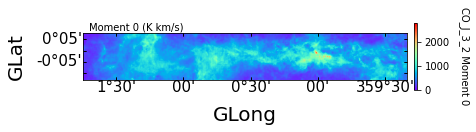

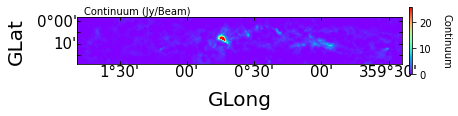

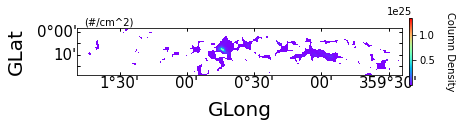

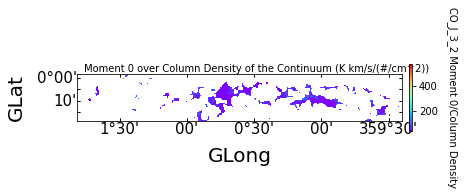

[75] [74] (155, 100)
<class 'float'> <class 'float'> 0.4


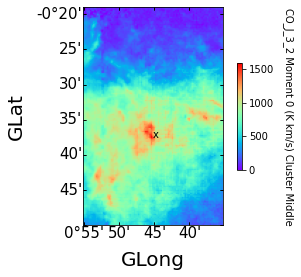

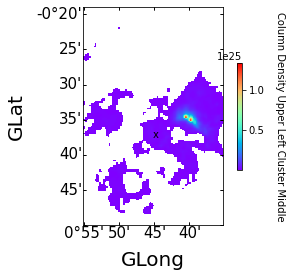

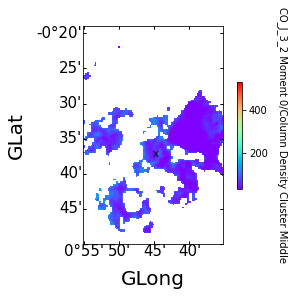

0.5168227709748882

345795989900.0 Hz 0.0008669633736547851 m
38.98800015444 arcsec 38.98800015444 arcsec
10.55599979032924 pix2
(1688,)
4.381965502550166 3.6237151410391997 3.0901936161855166 3.2489998138395206 1.4702423782952496
0.005218961122137569 deg 2.263635474695002e-13 10.55599979032924 pix2
6.28216532071943 3.6237151410391997 1.9544100476116797 3.2489998138395206 0.9298629255831788
0.002704342279492806 deg 2.263635474695002e-13 10.55599979032924 pix2
11.59943748802597 3.6237151410391997 3.6125759969217834 3.2489998138395206 1.7187797870228183
0.006056589271249566 deg 2.263635474695002e-13 10.55599979032924 pix2
9.024759329323738 3.6237151410391997 4.145929793656026 3.2489998138395206 1.9725371407614833
0.005817912205299128 deg 2.263635474695002e-13 10.55599979032924 pix2
8.898528052865368 3.6237151410391997 7.399277020331919 3.2489998138395206 3.5204042190297153
0.011887716233415387 deg 2.263635474695002e-13 10.55599979032924 pix2
8.628088561016618 3.6237151410391997 5.6980354

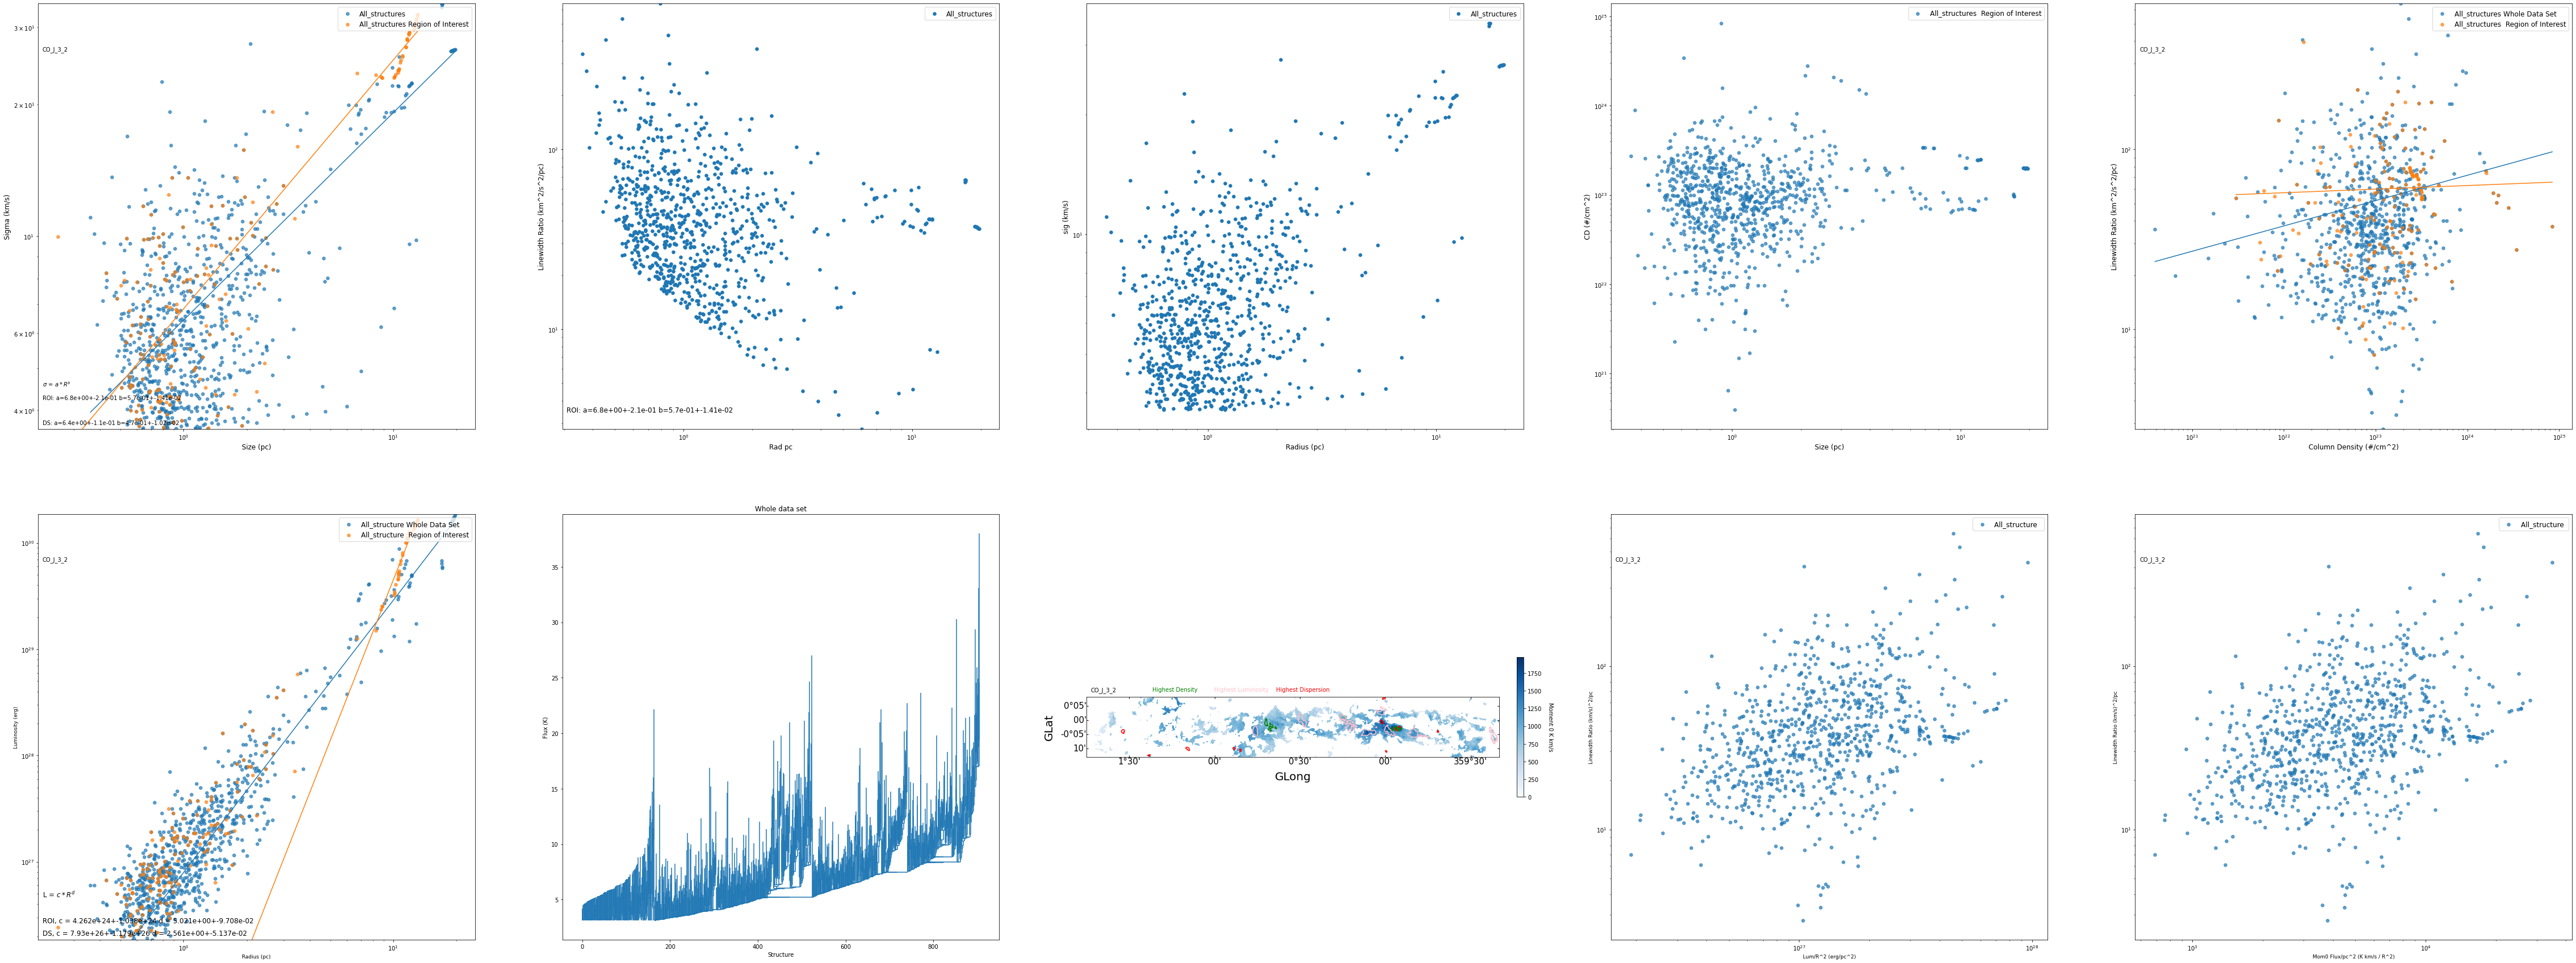

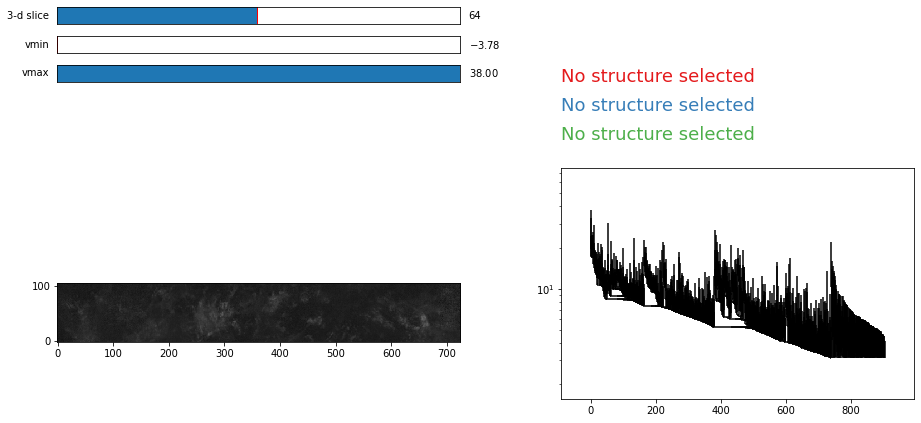

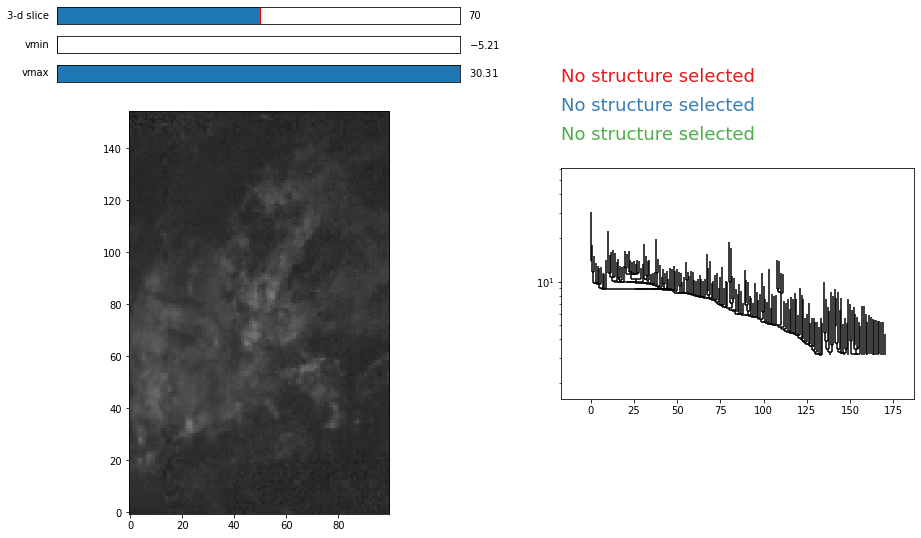

In [55]:
#CO3-2


Num = 4
Overlaps=0
Ram_Limiter = 1
Name = "CO_3_2_Abs_CMZ"
name = "CO_3_2_CM_Contours_DS_10_Abs_CMZ.jpeg"
Num_per_kg= 6.0221409*10**23/(2.8*10**-3)#6.0221409*10**23/29.0180*10**-3#num/kg for h2
LineN="CO_J_3_2"


Names[Num] = Name
NameS = (Name+"Sigmas")
NameR = (Name+"Radii")

np.save("Names_CMZ",Names)

print(Name)


paths = pylab.array(['Fixed_cmz_HCOp.cube.K-kms.pbcor.fits','Fixed_cmz_HCN.cube.reproject.K-kms.pbcor.fits','Fixed_cmz_H13CN.cube.reproject.K-kms.pbcor.fits','Fixed_cmz_H13COp.cube.reproject.K-kms.pbcor.fits',"Fixed_Spliced_CO_V2.fits"])
path = paths[Num]

#pathCont = 'CMZ_Continuum_Reproject.fits'
pathCont = 'CMZ_Continuum_Splice.fits'
#path='HCOp_J1-0.cube.fits'
print(path)
Confidences = np.load('Confidence_data_CMZ.npy')

Noises = np.load('Noises_K_CMZ.npy')
#Noises = Ns
m = Noises[Num]
print(m)
#Continuum image
scCont = spectral_cube.Projection.from_hdu(fits.open(pathCont)[0])
#Put this up here for the column density map



#Make subcube
Qp = SpectralCube.read(path).with_spectral_unit(u.km/u.s,velocity_convention="radio")
Qp.allow_huge_operations=True

Q = SpectralCube.read(path).downsample_axis(2,axis=0).with_spectral_unit(u.km/u.s,velocity_convention="radio").spectral_slab(-250. *u.km / u.s, 250. *u.km / u.s)

sc = Q.unmasked_copy()
#scQ = Q
scW = sc.wcs[:][:][0]


dat = sc.hdu.data[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),:,:]
scn = sc[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),:,:]
print(np.shape(dat),np.shape(scn))

datn = dat[5:np.shape(dat)[0]-5,30:np.shape(dat)[1]-30,20:np.shape(dat)[2]-20] # Make a subcube
scF= scn[5:np.shape(dat)[0]-5,30:np.shape(scn)[1]-30,20:np.shape(scn)[2]-20] # Make a subcube

#Do the same thing to the continuum image
scContW = scCont[30:np.shape(scn)[1]-30,20:np.shape(scn)[2]-20] # Make a subcube
metadata = {}
metadata["Cwcs"] = scContW.wcs
print(np.shape(datn),np.shape(scContW))

try:
    #
    sssss=1
except:
    #
    sssss=1
arc_per_pix_yc =  abs(scCont.hdu.header["CDELT1"]*3600.0 * u.arcsec)/u.pix
arc_per_pix_xc =  abs(scCont.hdu.header["CDELT2"]*3600.0 * u.arcsec)/u.pix
beam_majorc =  scCont.hdu.header["BMAJ"]*3600.0 * u.arcsec
beam_minorc =  scCont.hdu.header["BMIN"]*3600.0 * u.arcsec
beam_area_ratioc = beam_minorc*beam_majorc/arc_per_pix_yc/arc_per_pix_xc#This is for FWHM, use *(2*np.sqrt(2*np.log(2)))**2#For gaussian beam

metadata['beam_area_ratioc']=beam_area_ratioc

metadata["arc_per_pix"]= abs(scCont.hdu.header["CDELT1"]*3600.0 * u.arcsec)/u.pix
D_Es = np.load("Pixel_D.npy")*u.Mpc
#print(D_Es)
pc_per_pixelc = abs(scCont.hdu.header["CDELT1"])/180*np.pi*D_Es/u.Mpc


#Cubes with little dense gas and abs
'''
AbpRAD1 = SkyCoord('00h47m32.95s', '-25d17m24.0s', frame='icrs')
AbpRAD2 = SkyCoord('00h47m32.6s', '-25d17m16.0s', frame='icrs')
SCNA= Crop(scn,scW,AbpRAD1,AbpRAD2,5,False)
scContNA = Crop(scCont,scCont.wcs,AbpRAD1,AbpRAD2,0,True)
datna = SCNA.hdu.data 
print(np.shape(SCNA))
'''
UL1 = SkyCoord('00d55m00s',  '-00d50m00s', frame='galactic')#These are away from the sources
UL2 = SkyCoord('00d35m00s','01d30m00s', frame='galactic')
scWCS = scF.wcs[:][:][0]
#scWCSNA = SCNA.wcs[:][:][0]
#moment_0_subNA  = SCNA.moment(order=0,how='slice')            # Calculate the Moment 0 map 
moment_0_sub  = scF.moment(order=0,how='slice')            # Calculate the Moment 0 map 
ROI = Crop(scCont,scCont.wcs,UL1,UL2,5,True)
ROI_Line = Crop(scn,scn.wcs[:][:][0],UL1,UL2,0,False)
moment_0_ROI = ROI_Line.moment(order=0,how='slice')            # Calculate the Moment 0 map 

moment_0_sub  = scF.moment(order=0,how='slice')            # Calculate the Moment 0 map 
######Moment 0 for both
######and cont
Make_Plot((LineN+" Moment 0"),"Moment 0 (K km/s)",moment_0_sub.hdu.data,0,np.nanmax(moment_0_sub.hdu.data),moment_0_sub.wcs,1,1,1,True)
Make_Plot("Continuum","Continuum (Jy/Beam)",scContW.hdu.data,0,np.nanmax(scCont.hdu.data)*.2,scCont.wcs,1,1,1,True)
#Make_Plot((LineN+" Moment 0"),"Moment 0 No Abs Region (K km/s)",moment_0_subNA.hdu.data,0,np.nanmax(moment_0_subNA.hdu.data),moment_0_subNA.wcs,1,1,1,True)


cSD = (Flux_to_Mass(scContW.hdu.data*u.Jy/u.beam/beam_area_ratioc*u.pix**2*u.beam,metadata)/(pc_per_pixelc*10**6*3.086*10**18*u.cm)**2)*(1.989*10**30*u.kg/u.M_sun)*Num_per_kg/u.kg #Flux goes to luminosity for a gaussian beam and goes to column density for square pixels, mass goes to kg to number
rm=moment_0_sub.hdu.data/cSD
rmU = rm*u.K*u.km/u.s#Just put back in the units
rmU = np.array(rmU /(u.K*u.km/u.s)/u.cm**2*10**22,dtype='float64')#Now remove them all
#print(rmU[0][0])
######ratio

Np1 = SkyCoord('359d40m00s',  '00d04m00s', frame='galactic')#These are away from the sources
Np2 = SkyCoord('359d35m00s','00d08m00s', frame='galactic')
NraDP1 = [int(scContW.wcs.world_to_pixel(Np1)[0]),int(scContW.wcs.world_to_pixel(Np1)[1])]
NraDP2 = [int(scContW.wcs.world_to_pixel(Np2)[0]),int(scContW.wcs.world_to_pixel(Np2)[1])]
#print(cSD[NraDP1[1]-50:NraDP2[1]+50,NraDP1[0]-50:NraDP2[0]+50])
#if(str(np.nanmean((cSD[NraDP1[1]-50:NraDP2[1]+50,NraDP1[0]-50:NraDP2[0]+50])))!=str(np.nan)):
#bp = np.where(cSD<=np.nanmean(np.nanstd(cSD[NraDP1[1]-50:NraDP2[1]+50,NraDP1[0]-50:NraDP2[0]+50]))*.001)
bp = np.where(cSD<=7*10**22/u.cm**2)
#bp2 = np.where( moment_0_sub.hdu.data < m*.01)
#print(np.nanmean((cSD[NraDP1[1]-50:NraDP2[1]+50,NraDP1[0]-50:NraDP2[0]+50]))*.001)
cSD[bp]=np.nan
rmU[bp]=np.nan
    #rmU[bp2]=np.nan

#print(cSD[0][0])

#Make_Plot("HCO+ Moment 0/Column Density","Moment 0 over Column Density of the Continuum (K km/s/(#/cm^2))",moment_0_subNA.hdu.data,0,np.nanmax(moment_0_subNA.hdu.data),scCont.wcs,1,1,1,True)
Make_Plot("Column Density","(#/cm^2)",np.array(cSD*u.cm**2,dtype=type(.08)),float(np.nanmin(cSD*u.cm**2)),float(np.nanmax(cSD*u.cm**2)),scCont.wcs,1,1,1,True)
Make_Plot((LineN+" Moment 0/Column Density"),"Moment 0 over Column Density of the Continuum (K km/s/(#/cm^2))",rmU,np.nanmean(rmU)*.5,abs(np.nanmean(rmU))*8,scCont.wcs,1,1,1,True)


#Region of interest in the cont

Find_Pixel_D(ROI.hdu.data,metadata,"Brightest_CD")

D_EROI = np.load("Brightest_CD.npy")*u.Mpc
pc_per_pixelcROI = abs(scCont.hdu.header["CDELT1"])/180*np.pi*D_EROI/u.Mpc

cSDROI = (Flux_to_Mass(ROI.hdu.data*u.Jy/u.beam/beam_area_ratioc*u.pix**2*u.beam,metadata,D_Name = "Brightest_CD.npy")/(pc_per_pixelcROI*10**6*3.086*10**18*u.cm)**2)*(1.989*10**30*u.kg/u.M_sun)*Num_per_kg/u.kg #Flux goes to luminosity for a gaussian beam and goes to column density for square pixels, mass goes to kg to number
rmROI=moment_0_ROI.hdu.data/cSDROI
rmUROI = rmROI*u.K*u.km/u.s#Just put back in the units
rmUROI = np.array(rmUROI /(u.K*u.km/u.s)/u.cm**2*10**22,dtype='float64')#Now remove them all

######ratio
    
#bproi = np.where(cSDROI<=np.nanmean((cSD[NraDP1[1]-50:NraDP2[1]+50,NraDP1[0]-50:NraDP2[0]+50]))*.01)
bproi = np.where(cSDROI<=7*10**22/u.cm**2)
#bp2 = np.where( moment_0_ROI.hdu.data < m*.01)
#print(np.nanmean((cSD[NraDP1[1]-50:NraDP2[1]+50,NraDP1[0]-50:NraDP2[0]+50]))*.01)
cSDROI[bproi]=np.nan
rmUROI[bproi]=np.nan
#rmUROI[bp2]=np.nan

z,yf,xf = np.where(ROI_Line.hdu.data==np.nanmax(ROI_Line.hdu.data))
print(xf,yf,np.shape(ROI.hdu.data))
xf,yf = float(xf/np.shape(ROI.hdu.data)[1]),float(yf/np.shape(ROI.hdu.data)[0])
xf,yf = .5,.4
print(type(xf),type(.5),yf)
Make_Plot_Anno((LineN+" Moment 0 (K km/s) Cluster Middle"),"x",moment_0_ROI.hdu.data,0,np.nanmax(moment_0_ROI.hdu.data),ROI.wcs,1,1,1,True,xf,yf)
Make_Plot_Anno("Column Density Upper Left Cluster Middle","x",np.array(cSDROI*u.cm**2,dtype=type(.08)),float(np.nanmin(cSDROI*u.cm**2)),float(np.nanmax(cSDROI*u.cm**2)),ROI.wcs,1,1,1,True,xf,yf)
Make_Plot_Anno((LineN+" Moment 0/Column Density Cluster Middle"),"x",rmUROI,np.nanmean(rmUROI)*.5,abs(np.nanmean(rmUROI))*8,ROI.wcs,1,1,1,True,xf,yf)


print(np.nanmin(rmU))



header = scF.hdu.header
header2= SpectralCube.read(paths[0]).hdu.header
print()
#make metadata for the dendrogram


freq = header["SPEC2A_A"]*u.Hz#
metadata['wavelength']=299792458*u.m/header["SPEC2A_A"]#
print(freq,metadata['wavelength'])
metadata['data_unit'] =u.K# header['BUNIT']
metadata['arc_per_pix_y'] =  abs(header["CDELT1"]*3600.0 * u.arcsec)/u.pix
metadata['arc_per_pix_x'] =  abs(header["CDELT2"]*3600.0 * u.arcsec)/u.pix


metadata['beam_major'] =  header2["BMAJ"]*3600.0 * u.arcsec
metadata['beam_minor'] =  header2["BMIN"]*3600.0 * u.arcsec
beam_area_ratio = metadata['beam_minor']*metadata['beam_major']/metadata['arc_per_pix_y']/metadata['arc_per_pix_x']#This is for FWHM, use *(2*np.sqrt(2*np.log(2)))**2#For gaussian beam
metadata['beam_area_ratio']=beam_area_ratio
metadata['spatial_scale'] = np.sqrt(abs(header["CDELT1"])*u.degree**2*abs(header["CDELT2"]))
area_res = abs(header["CDELT1"])*abs(header["CDELT2"])*(np.pi/180*D_Es/u.Mpc)**2#mpc^2/pix^2

#print(area_res,type(area_res))
print(metadata['beam_minor'],metadata['beam_major'])
print(beam_area_ratio)
#metadata["wcs"] = wcs
metadata["velocity_scale"] = abs(header["CDELT3"])*u.km/u.s#3.3714064157379937*u.km/u.s

metadata["vaxis"]=0



metadata["ARND"] = abs(header["CDELT1"])*abs(header["CDELT2"])









d = astrodendro.Dendrogram.compute(datn,min_delta=m,min_value=m*5,min_npix=50) #The main culprit
#dNA = astrodendro.Dendrogram.compute(datna,min_value=m*5,min_delta=m,min_npix=50) #The main culprit


dUL = astrodendro.Dendrogram.compute(ROI_Line.hdu.data,min_value=m*5,min_delta=m,min_npix=50) #The main culprit



##Analyze dendograms
print(np.shape(d))




fig = plt.figure(1,figsize=(80,80))


axAlpha = pylab.subplot(5, 5, 7)


axGamma = pylab.subplot(5, 5, 9)




p=d.plotter()
p.plot_tree(axAlpha)
axAlpha.set_xlabel("Structure")
axAlpha.set_ylabel("Flux (K)")
axAlpha.set_title("Whole data set")

            
'''

p=dNA.plotter()
p.plot_tree(axBeta)
axBeta.set_xlabel("Structure")
axBeta.set_ylabel("Flux (K)")
axBeta.set_title("No absorption region")

'''
#p=dUL.plotter()
#p.plot_tree(axGamma)
#xGamma.set_xlabel("Structure")
#axGamma.set_ylabel("Flux (K)")
#axGamma.set_title("Region of Interest")
''''''

pc_per_pixel = abs(header["CDELT1"])/180*np.pi*D_Es/u.Mpc

sig_per_pixel=np.nan#metadata['spectral_resolution']/u.pix


#Finds Size, Linewidth, Luminosity, and Column Density of a structure for each structure and returns them in [[][]] arrays [Leaves][Branches]
vel,RA,Dec = scF.world[:,0,0]
Rads,Sigmas,CD,Lumin ,SIDS,MOM0FLUX= Dendro_Arrays(d,datn,vel,scContW.hdu.data,metadata)

#Plot contours for the top ten clusters


scCropped =scF.moment0().hdu.data
scCropped[np.where(scF.moment0().hdu.data<.22)]=np.nan
print(np.nanmean(np.nanstd(scF.moment0().hdu.data))*1)
scCropped[bp]=np.nan
axBeta = pylab.subplot(5,5,8,projection=scF.moment0().wcs)
#axBeta.imshow(scCropped.moment0().hdu.data, origin='lower', interpolation='nearest', cmap=plt.cm.Blues,norm=colors.LogNorm(vmin=5))
imBeta = axBeta.imshow(scCropped, origin='lower', interpolation='nearest', cmap=plt.cm.Blues,vmin=0,vmax = np.nanmax(scCropped)*.7 )



ColumnCon= np.concatenate((CD[0],CD[1]))
SIDScon = np.concatenate((SIDS[0],SIDS[1]))
#nth = sorted(ColumnCon)[len(ColumnCon)-30]
nth = sorted(CD[0])[len(CD[0])-10]
nth2 = sorted(Lumin[0])[len(Lumin[0])-10]
nth3 = sorted(Sigmas[0])[len(Sigmas[0])-10]
#top = np.where(CD[0]>=nth)
#print(list(top))
'''
for n in range(len(ColumnCon)):
    
    if(ColumnCon[n]>=nth):
        #print(n,SIDS[0])
        p.plot_contour(axBeta, structure=int(SIDScon[n]), lw=.1, colors='red')
        #NOT USING LEAVSE FOR STRUCTURES, USING ALL STRUCTURES
        #solved?
'''
G1 = True
G2 = True
G3 = True
for n in range(len(CD[0])):
    
    if(CD[0][n]>=nth):
        #print(n,SIDS[0])
        if(G1):
            G1=False
            p.plot_contour(axBeta, structure=int(SIDS[0][n]), lw=1, colors='green',label="Higest Density")
        else:
            p.plot_contour(axBeta, structure=int(SIDS[0][n]), lw=1, colors='green')
        #NOT USING LEAVSE FOR STRUCTURES, USING ALL STRUCTURES
        #solved?
    if(Lumin[0][n]>=nth2):
        #print(n,SIDS[0])
        if(G2):
            G2=False
            p.plot_contour(axBeta, structure=int(SIDS[0][n]), lw=2, colors="pink",label="Highest Luminosity (Leaves)")
        else:
            p.plot_contour(axBeta, structure=int(SIDS[0][n]), lw=2, colors="pink")
        #NOT USING LEAVSE FOR STRUCTURES, USING ALL STRUCTURES
        #solved?
    if(Sigmas[0][n]>=nth3):
        #print(n,SIDS[0])
        if(G3):
            G3=False
            p.plot_contour(axBeta, structure=int(SIDS[0][n]), lw=3, colors='red',label="Highest Dispersion")
        else:
            p.plot_contour(axBeta, structure=int(SIDS[0][n]), lw=3, colors='red')
        #NOT USING LEAVSE FOR STRUCTURES, USING ALL STRUCTURES
        #solved?
   
  


RA = axBeta.coords[0]                                                                  # 
Dec = axBeta.coords[1]

RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('GLong',fontsize=20,labelpad=1)                               
pylab.ylabel('GLat',fontsize=20,labelpad=1)
axBeta.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(imBeta,fraction=0.016,pad=0.04)                                     
cb.set_label(label="Moment 0 K km/s",fontsize=10,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)   
pylab.annotate(s=LineN,fontsize=10,xy=(.01,1.1),xycoords="axes fraction",c="black")  
pylab.annotate(s="Highest Density",fontsize=10,xy=(.16,1.1),xycoords="axes fraction",c="green")  
pylab.annotate(s="Highest Luminosity",fontsize=10,xy=(.31,1.1),xycoords="axes fraction",c="pink")  
pylab.annotate(s="Highest Dispersion",fontsize=10,xy=(.46,1.1),xycoords="axes fraction",c="red")  

    
    
    
    
#RadsNA,SigmasNA,CDNA,LuminNA = Dendro_Arrays(dNA,datna,vel,scContNA.hdu.data,metadata)
RadsUL,SigmasUL,CDUL,LuminUL,SIDSUL,MOM0FLUXUL = Dendro_Arrays(dUL,ROI_Line.hdu.data,vel,ROI.hdu.data,metadata)


#def Dendro_Arrays(Dendrogram,LineData,DataVel,ContData,metadata):
    

from scipy.optimize import curve_fit
from scipy.optimize import leastsq

def func(R,a,b):
    return a*R**(b)
try:
    popt, pcov = curve_fit(func, Rads[0]*10**6,Sigmas[0])
except:
    popt, pcov = [np.nan,np.nan],[[np.nan,np.nan],[np.nan,np.nan]]
try:
    poptB, pcovB = curve_fit(func,  Rads[1]*10**6,Sigmas[1])
except:
    poptB, pcovB = [np.nan,np.nan],[[np.nan,np.nan],[np.nan,np.nan]]


    
Rcon = np.concatenate((Rads[0],Rads[1]))
Scon = np.concatenate((Sigmas[0],Sigmas[1]))
print(np.shape(Rcon))
poptCon, pcovCon = curve_fit(func, Rcon*10**6, Scon)







    
RconUL = np.concatenate((RadsUL[0],RadsUL[1]))
SconUL = np.concatenate((SigmasUL[0],SigmasUL[1]))

poptUL, pcovUL = curve_fit(func, RconUL*10**6, SconUL)



xs=np.linspace(np.nanmin(Rcon*10**6),np.nanmax(Rcon*10**6),50)
ysL,ysB,ysCon=func(xs,popt[0],popt[1]),func(xs,poptB[0],poptB[1]),func(xs,poptCon[0],poptCon[1])



LuminCon = np.concatenate((Lumin[0],Lumin[1]))

MOM0FLUXcon = np.concatenate((MOM0FLUX[0],MOM0FLUX[1]))
#Flux ratios fit
#FRpopt,FRpcov = curve_fit(func, abs(FRs),Scon**2/Rcon/10**6)
#xsF=np.linspace(np.nanmin(abs(FRs)),np.nanmax(abs(FRs)),50)
#ysF = func(xsF,FRpopt[0],FRpopt[1])

#Radius Luminosity fit
gp = np.where(LuminCon>0)
print(np.shape(Rcon),np.shape(LuminCon))
lgp = LuminCon[gp]
radgp = Rcon[gp]*10**6
#print(np.shape(Rcon[gp]*10**6),np.shape(LuminCon[gp]))
RLpopt,RLpcov = curve_fit(func, np.array(radgp,dtype='float64'),np.array(lgp,dtype='float64'),maxfev=999999,p0 = np.array([10**27,1],dtype='float64'),ftol = 10**-10)

xsRL=np.linspace(np.nanmin(radgp),np.nanmax(radgp),50)
ysRL = func(xsRL,RLpopt[0],RLpopt[1])



#Column density to Size-linewidth
gp2 = np.where(ColumnCon>0)

cgp = ColumnCon[gp2]
radgpFORRAT = Rcon[gp2]*10**6
siggpFORRAT = Scon[gp2]


lumFORRAT = LuminCon[gp2]
mom0FORRAT = MOM0FLUXcon[gp2]
rgp=Scon[gp2]**2/Rcon[gp2]/10**6

gp3 = np.where(lumFORRAT>0)
lumFORRAT = lumFORRAT[gp3]
rgpFORRAT = rgp[gp3]
mom0FORRAT = mom0FORRAT[gp3]
CDpopt,CDpcov = curve_fit(func, np.array(cgp,dtype='float64') ,np.array(rgp,dtype='float64'),maxfev=9999099,p0 = np.array([10,.01],dtype='float64'),ftol = 10**-10)
xsCD=np.linspace(np.nanmin(cgp),np.nanmax(cgp),50)
ysCD = func(xsCD,CDpopt[0],CDpopt[1])


print(poptCon,pcovCon,"Size Linewidth All_structures:")
print("a = ",poptCon[0],"+-",np.sqrt(pcovCon[0][0]))
print("b = ",poptCon[1],"+-",np.sqrt(pcovCon[1][1]))



print(RLpopt,RLpcov,"Radius to Luminosity:")
print("c = ",RLpopt[0],"+-",np.sqrt(RLpcov[0][0]))
print("d = ",RLpopt[1],"+-",np.sqrt(RLpcov[1][1]))






print(CDpopt,CDpcov,"Column Density to linewidth^2/size:")
print("e = ",CDpopt[0],"+-",np.sqrt(CDpcov[0][0]))
print("f = ",CDpopt[1],"+-",np.sqrt(CDpcov[1][1]))



ax2 = pylab.subplot(5, 5, 1)
ax3 = pylab.subplot(5, 5, 2)
ax4 = pylab.subplot(5, 5, 3)



print(np.shape(Rcon*10**6),np.shape(Scon),np.shape(Rads[0]*10**6),np.shape(Sigmas[0]),np.shape(Rads[1]*10**6),np.shape(Sigmas[1]),type(Rads[0]))
#xpcon,xpL,xpB = ax2.scatter(Rcon*10**6,Scon,label="All_structures",s=30),ax2.scatter(Rads[0]*10**6,Sigmas[0],s=30),ax2.scatter(Rads[1]*10**6,Sigmas[1],s=30)
xpcon = ax2.scatter(Rcon*10**6,Scon,label="All_structures",s=30,alpha=.7)
#p,p2,p3 = ax2.plot(xs,ysCon),ax2.plot(xs,ysL),ax2.plot(xs,ysB)
p = ax2.plot(xs,ysCon)

#pNA = ax2.plot(xsNA,ysNA)
#xpNA = ax2.scatter(RconNA*10**6,SconNA,label="All_structures Sparse region",s=30,alpha=.7)

xpconhh = ax2.scatter(RconUL*10**6,SconUL,label="All_structures Region of Interest",s=30,alpha=.7)
xsUL=np.linspace(np.nanmin(RconUL*10**6),np.nanmax(RconUL*10**6),50)
ysUL=func(xsUL,poptUL[0],poptUL[1])
p22 = ax2.plot(xsUL,ysUL)


st="DS: a="+ str(np.format_float_scientific(poptCon[0],1))+"+-"+str(np.format_float_scientific(np.sqrt(pcovCon[0][0]),1))+" b="+str(np.format_float_scientific(poptCon[1],1))+"+-"+str(np.format_float_scientific(np.sqrt(pcovCon[1][1]),2))
ax2.annotate(s=st,fontsize=10,xy=(0.01,0.01),xycoords="axes fraction")

st="ROI: a="+ str(np.format_float_scientific(poptUL[0],1))+"+-"+str(np.format_float_scientific(np.sqrt(pcovUL[0][0]),1))+" b="+str(np.format_float_scientific(poptUL[1],1))+"+-"+str(np.format_float_scientific(np.sqrt(pcovUL[1][1]),2))
ax2.annotate(s=st,fontsize=10,xy=(0.01,0.07),xycoords="axes fraction")
ax2.annotate(s=r'$\sigma$ = $a*R^b$',fontsize=10,xy=(0.01,0.10),xycoords="axes fraction")
ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.set_ylim(np.nanmin(Scon),np.nanmax(Scon))
ax2.set_xlabel("Size (pc)",fontsize=12)
ax2.set_ylabel("Sigma (km/s)",fontsize=12)
ax2.legend(prop={'size': 12},loc="upper right")
ax2.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")

#gp = np.where(FRs>0)





xspF = ax3.scatter(radgpFORRAT,rgp,label="All_structures",s=30)
#pF = ax3.plot(xsCD,ysCD)
#ax3.annotate(s=r'$\sigma^2/R$ = $e*N^f$',fontsize=12,xy=(0.01,0.07),xycoords="axes fraction")
#st = "e = "+ str(np.format_float_scientific(CDpopt[0],3))+"+-"+str(np.format_float_scientific(np.sqrt(CDpcov[0][0]),3))+" f = "+str(np.format_float_scientific(CDpopt[1],3))+"+-"+str(np.format_float_scientific(np.sqrt(CDpcov[1][1]),3))

ax3.annotate(s=st,fontsize=12,xy=(0.01,0.04),xycoords="axes fraction")
ax3.set_yscale('log')
ax3.set_xscale('log')
ax3.set_ylim(np.nanmin(rgp),np.nanmax(rgp))
ax3.set_xlabel("Rad pc",fontsize=12)
ax3.set_ylabel("Linewidth Ratio (km^2/s^2/pc)",fontsize=12)
ax3.legend(prop={'size': 12})



xspL = ax4.scatter(radgpFORRAT,siggpFORRAT,label="All_structures",s=30)
#pFLL = ax4.plot(xsRL,ysRL)

#st = "c = "+ str(np.format_float_scientific(RLpopt[0],3))+"+-"+str(np.format_float_scientific(np.sqrt(RLpcov[0][0]),3))+" d = "+str(np.format_float_scientific(RLpopt[1],3))+"+-"+str(np.format_float_scientific(np.sqrt(RLpcov[1][1]),3))
#ax4.annotate(s='L = $c*R^d$',fontsize=12,xy=(0.01,0.07),xycoords="axes fraction")
#ax4.annotate(s=st,fontsize=12,xy=(0.01,0.04),xycoords="axes fraction")

ax4.set_yscale('log')
ax4.set_xscale('log')
#ax4.set_ylim(np.nanmin(lgp),np.nanmax(lgp))
ax4.set_xlabel("Radius (pc)",fontsize=12)
ax4.set_ylabel("sig (km/s)",fontsize=12)
ax4.legend(prop={'size': 12},loc="upper right")














LuminConUL = np.concatenate((LuminUL[0],LuminUL[1]))
ColumnConUL= np.concatenate((CDUL[0],CDUL[1]))

#Radius Luminosity fit
gp = np.where(LuminConUL>0)
lgpUL = LuminConUL[gp]
radgpUL = RconUL[gp]*10**6
print(np.shape(radgpUL),np.shape(lgpUL))
RLpoptUL,RLpcovUL = curve_fit(func, np.array(radgpUL,dtype='float64'),np.array(lgpUL,dtype='float64'),maxfev=999999,p0 = np.array([10**27,1],dtype='float64'),ftol = 10**-10)

xsRLUL=np.linspace(np.nanmin(radgpUL),np.nanmax(radgpUL),50)
ysRLUL = func(xsRLUL,RLpoptUL[0],RLpoptUL[1])

#Column density to Size-linewidth
gp2 = np.where(ColumnConUL>0)
cgpUL = ColumnConUL[gp2]
rgpUL=SconUL[gp2]**2/RconUL[gp2]/10**6
CDpoptUL,CDpcovUL = curve_fit(func, np.array(cgpUL,dtype='float64') ,np.array(rgpUL,dtype='float64'),maxfev=9999099,p0 = np.array([10,.01],dtype='float64'),ftol = 10**-10)
xsCDUL=np.linspace(np.nanmin(cgpUL),np.nanmax(cgpUL),50)
ysCDUL = func(xsCDUL,CDpoptUL[0],CDpoptUL[1])

print(poptUL,pcovUL,"Size Linewidth Region of Interest:")
print("a = ",poptUL[0],"+-",np.sqrt(pcovUL[0][0]))
print("b = ",poptUL[1],"+-",np.sqrt(pcovUL[1][1]))

print(RLpoptUL,RLpcovUL,"Radius to Luminosity  Region of Interest:")
print("c = ",RLpoptUL[0],"+-",np.sqrt(RLpcovUL[0][0]))
print("d = ",RLpoptUL[1],"+-",np.sqrt(RLpcovUL[1][1]))


ax5 = pylab.subplot(5, 5, 4)
ax6 = pylab.subplot(5, 5, 5)
ax7 = pylab.subplot(5, 5, 6)




xpconhh = ax5.scatter(radgpFORRAT,cgp,label="All_structures  Region of Interest",s=30,alpha=.7)
#p2 = ax5.plot(xsUL,ysUL)


ax5.set_yscale('log')
ax5.set_xscale('log')
#ax5.set_ylim(np.nanmin(Scon),np.nanmax(Scon))
ax5.set_xlabel("Size (pc)",fontsize=12)
ax5.set_ylabel("CD (#/cm^2)",fontsize=12)
ax5.legend(prop={'size': 12},loc="upper right")


#gp = np.where(FRs>0)



xspFUL2 = ax6.scatter(cgp,rgp,label="All_structures Whole Data Set",s=30,alpha=.7)
pFUL2 = ax6.plot(xsCD,ysCD)


#xspFNA = ax6.scatter(cgpNA,rgpNA,label="All_structures Sparse Region",s=30,alpha=.7)
#pFNA = ax6.plot(xsCDNA,ysCDNA)


xspFUL = ax6.scatter(cgpUL,rgpUL,label="All_structures  Region of Interest",s=30,alpha=.7)
pFUL = ax6.plot(xsCDUL,ysCDUL)

#ax6.annotate(s=st,fontsize=12,xy=(0.01,0.06),xycoords="axes fraction")
ax6.set_yscale('log')
ax6.set_xscale('log')
ax6.set_ylim(np.nanmin(rgp),np.nanmax(rgp))
ax6.set_xlabel("Column Density (#/cm^2)",fontsize=12)
ax6.set_ylabel("Linewidth Ratio (km^2/s^2/pc)",fontsize=12)
ax6.legend(prop={'size': 12},loc="upper right")
ax6.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")




xspLu2 = ax7.scatter(radgp,lgp,label="All_structure Whole Data Set",s=30,alpha=.7)
pFLLu2 = ax7.plot(xsRL,ysRL)
#xspLu2NA = ax7.scatter(radgpNA,lgpNA,label="All_structure Sparse Region",s=30,alpha=.7)
#pFLLu2NA = ax7.plot(xsRLNA,ysRLNA)

xspLu = ax7.scatter(radgpUL,lgpUL,label="All_structure  Region of Interest",s=30,alpha=.7)

pFLLu = ax7.plot(xsRLUL,ysRLUL)


st = "DS, c = "+ str(np.format_float_scientific(RLpopt[0],3))+"+-"+str(np.format_float_scientific(np.sqrt(RLpcov[0][0]),3))+" d = "+str(np.format_float_scientific(RLpopt[1],3))+"+-"+str(np.format_float_scientific(np.sqrt(RLpcov[1][1]),3))
ax7.annotate(s='L = $c*R^d$',fontsize=12,xy=(0.01,0.10),xycoords="axes fraction")
ax7.annotate(s=st,fontsize=12,xy=(0.01,0.01),xycoords="axes fraction")
st2 = "ROI, c = "+ str(np.format_float_scientific(RLpoptUL[0],3))+"+-"+str(np.format_float_scientific(np.sqrt(RLpcovUL[0][0]),3))+" d = "+str(np.format_float_scientific(RLpoptUL[1],3))+"+-"+str(np.format_float_scientific(np.sqrt(RLpcovUL[1][1]),3))
ax7.annotate(s=st2,fontsize=12,xy=(0.01,0.04),xycoords="axes fraction")

#st3 = "SR, c = "+ str(np.format_float_scientific(RLpoptNA[0],3))+"+-"+str(np.format_float_scientific(np.sqrt(RLpcovNA[0][0]),3))+" d = "+str(np.format_float_scientific(RLpoptNA[1],3))+"+-"+str(np.format_float_scientific(np.sqrt(RLpcovNA[1][1]),3))
#ax7.annotate(s=st3,fontsize=12,xy=(0.01,0.07),xycoords="axes fraction")

ax7.set_yscale('log')
ax7.set_xscale('log')
ax7.set_ylim(np.nanmin(lgp),np.nanmax(lgp))
ax7.set_xlabel("Radius (pc)",fontsize=9)
ax7.set_ylabel("Luminosity (erg)",fontsize=9)
ax7.legend(prop={'size': 12},loc="upper right")
ax7.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")

#print(FRs)



lum_rat = axGamma.scatter(lumFORRAT/radgpFORRAT**2,rgpFORRAT,label="All_structure  ",s=30,alpha=.7)
#Off by factors for area, simply using r^2

axGamma.set_yscale('log')
axGamma.set_xscale('log')
axGamma.set_xlabel("Lum/R^2 (erg/pc^2)",fontsize=9)
axGamma.set_ylabel("Linewidth Ratio (km/s)^2/pc",fontsize=9)
axGamma.legend(prop={'size': 12},loc="upper right")
axGamma.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")



axDelta = pylab.subplot(5, 5, 10)



#mom0_rat = axDelta.scatter(mom0FORRAT/radgpFORRAT**2,rgpFORRAT,label="All_structure  Region of Interest",s=30,alpha=.7)
gp4=np.where(MOM0FLUXcon>0)
mom0FORFlux=MOM0FLUXcon[gp4]
radgpFORFlux=Rcon[gp4]*10**6
rgpFORFlux=Scon[gp4]**2/Rcon[gp4]/10**6
mom0_rat = axDelta.scatter(mom0FORFlux/radgpFORFlux**2,rgpFORFlux,label="All_structure ",s=30,alpha=.7)
#Off by factors for area, simply using r^2

axDelta.set_yscale('log')
axDelta.set_xscale('log')
axDelta.set_xlabel("Mom0 Flux/pc^2 (K km/s / R^2)",fontsize=9)
axDelta.set_ylabel("Linewidth Ratio (km/s)^2/pc",fontsize=9)
axDelta.legend(prop={'size': 12},loc="upper right")
axDelta.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")


pylab.show()


NameCol = (Name+"_Column")
NameLum = (Name+"_Luminosities")

NameColROI = (Name+"_Column_ROI")
NameLumROI = (Name+"_Luminosities_ROI")
NameRROI = (NameR+"_ROI")
NameSROI = (NameS+"_ROI")
NameFlux = (Name+"Flux_Dense")
NameRFF = (Name+"Rad_For_Flux")

v1 = d.viewer()
v1.show()
v3 = dUL.viewer()
v3.show()

np.save(NameCol,CD)
np.save(NameLum,Lumin)

np.save(NameS,Sigmas)
np.save(NameR,Rads) #Still in [leaves] [breanches] format

np.save(NameColROI,CDUL)
np.save(NameLumROI,LuminUL)

np.save(NameSROI,SigmasUL)
np.save(NameRROI,RadsUL) #Still in [leaves] [breanches] format

np.save(NameFlux,mom0FORFlux/radgpFORFlux**2)
np.save(NameRFF,rgpFORFlux)



In [ ]:
RNames = np.load("RNames_CMZ.npy")
SNames = np.load("SNames_CMZ.npy")
CMZLs = ["HCO+_J1-0","HCN_J1-0","H13CN_J1-0","H13CO+_J1-0"]
NGCRNames = np.load("RNames.npy")
NGCSNames = np.load("SNames.npy")

#ONGCR = [NGCRNames[9],NGCRNames[10],NGCRNames[8]]
#ONGCS = [NGCSNames[9],NGCSNames[10],NGCSNames[8]] 4-3
ONGCR = [NGCRNames[0],NGCRNames[1],NGCRNames[2],NGCRNames[5]]
ONGCS = [NGCSNames[0],NGCSNames[1],NGCSNames[2],NGCSNames[5]] #1-0

Bars = np.load("CZM_Beam_Area_Ratios.npy")
NBars = np.load("NGC_Beam_Area_Ratios.npy")

SpecRes = np.load("CZM_Sres.npy")
NSpecRes = np.load("NGC_Sres.npy")

SpRes= np.load("CZM_Spres.npy")
NSpRes = np.load("NGC_Spres.npy")

print(ONGCR,ONGCS)
print(RNames,SNames)
#for i in range(len(RNames)):
fig = plt.figure(1,figsize=(35,35))


for i in range(4):
    #make minimum space line
    
    ysp=SpecRes[i]
    xsp=SpRes[i]
    Nysp=NSpecRes[i]
    Nxsp=NSpRes[i]
    
    
    #def space(v,*args):
    #    r,bar,vres,sres = args[0],args[1],args[2],args[3]
    #    return  float(50*vres*sres**2/np.sqrt(50))-v*r**2*np.pi
    def MinSpace(*args):
        r,vres,sres = args[0],args[1],args[2]
        if (math.floor(1/sres**2*r**2*np.pi)==0):
            return np.nan
        else:

            vp = math.ceil(50/math.floor(1/sres**2*r**2*np.pi)) #minimum number of velocity channels the structures must be in

            DumCube = np.array([]) #make a cube that would have the minimum rms possible
            for i in range(vp):
                for n in range(math.floor(1/sres**2*r**2*np.pi)):
                    DumCube = np.append(DumCube,i*vres)
            rms = np.std(DumCube)**2 #The rms is the variance of this 'cube'

            return rms

    
        
    xsps=[]

    ysps=[]

    line=[]
    minsigs=[]
    Nxsps=[]

    Nysps=[]

    
    Nminsigs=[]
    zeros=[]
    
    rs=np.linspace(0.1,5,10)
    L=np.linspace(-1,20,10)
    for t in range(10):
        ps = 0
        xsps.append(xsp*2.075)
        ysps.append(ysp)
        
        Nxsps.append(Nxsp)
        Nysps.append(Nysp)
        
        #print(scipy.optimize.fsolve(space,x0=-100,factor=1,xtol=10**-20,args=(rs[t],NBars[i],SpecRes[i],SpRes[i]),full_output=True,maxfev=10000))
        #print(float(scipy.optimize.fsolve(space,x0=-100,factor=1,xtol=10**-20,args=(rs[t],NBars[i],SpecRes[i],SpRes[i]),maxfev=10000)))
        #minsigs.append(float(scipy.optimize.fsolve(space,x0=-100,factor=1,xtol=10**-20,args=(rs[t],NBars[i],SpecRes[i],SpRes[i]),maxfev=10000)))
        #Nminsigs.append(float(scipy.optimize.fsolve(space,x0=-100,factor=1,xtol=10**-20,args=(rs[t],NBars[i],NSpecRes[i],NSpRes[i]),maxfev=10000)))
        Nminsigs.append(np.roots([rs[t]**2,-NSpecRes[i]*3*NSpRes[i]**2])[0])
        minsigs.append(np.roots([rs[t]**2,-SpecRes[i]*3*SpRes[i]**2*2.0475**2*1.3807])[0])
        #Nminsigs.append(MinSpace(rs[t],SpecRes[i],SpRes[i]))
        #minsigs.append(MinSpace(rs[t],NSpecRes[i],NSpRes[i]))
        line.append(rs[t])
        zeros.append(-1)
    #print(minsigs,line)
    rnameL=RNames[i]+"_Leaves.npy"
    snameL=SNames[i]+"_Leaves.npy"
    rnameB=RNames[i]+"_Branches.npy"
    snameB=SNames[i]+"_Branches.npy"
    
    NGCrnameL=ONGCR[i]+"_Leaves.npy"
    NGCsnameL=ONGCS[i]+"_Leaves.npy"
    NGCrnameB=ONGCR[i]+"_Branches.npy"
    NGCsnameB=ONGCS[i]+"_Branches.npy"
    
    radsL = np.load(rnameL)*10**6#pc
    sigsL = np.load(snameL)
    radsB = np.load(rnameB)*10**6#pc
    sigsB = np.load(snameB)
    
    radsNGCL = np.load(NGCrnameL)*10**6
    sigsNGCL = np.load(NGCsnameL)
    radsNGCB = np.load(NGCrnameB)*10**6
    sigsNGCB = np.load(NGCsnameB)
    
    radsNGC=np.concatenate((radsNGCL,radsNGCB))
    sigsNGC = np.concatenate((sigsNGCL,sigsNGCB))
    rads,sigs=np.concatenate((radsL,radsB)), np.concatenate((sigsL,sigsB))
    
    from scipy.optimize import curve_fit
    
    def func(R,a,b):
        return a*R**(b)
    #print(Bin_Rads,Bin_Sigs)
    (popt, pcov),(popt2, pcov2),(poptT, pcovT) = (curve_fit(func, radsL, sigsL)),(curve_fit(func, radsB, sigsB)),(curve_fit(func, rads,sigs))
    (Npopt, Npcov),(Npopt2, Npcov2),(NpoptT, NpcovT) = (curve_fit(func, radsNGCL, sigsNGCL)),(curve_fit(func, radsNGCB, sigsNGCB)),(curve_fit(func, radsNGC,sigsNGC ))
    
    
    axA = pylab.subplot(4, 5, i+1)
    axL = pylab.subplot(4, 5, i+6)
    axB = pylab.subplot(4, 5, i+11)
    xp1L = axL.scatter(radsL, sigsL,c="Cyan",alpha=1,label=("CMZ_Leaves"+CMZLs[i]),marker='s',s=10,facecolors='none')
    xp1B = axB.scatter(radsB, sigsB,c="Purple",alpha=1,label=("CMZ_Branches"+CMZLs[i]),marker='s',s=10,facecolors='black')
    xp1AL = axA.scatter(radsL, sigsL,c="Cyan",alpha=1,label=("CMZ_Leaves"+CMZLs[i]),marker='s',s=10,facecolors='none')
    xp1AB = axA.scatter(radsB, sigsB,c="Purple",alpha=1,label=("CMZ_Branches"+CMZLs[i]),marker='s',s=10,facecolors='black')
    
    xs=np.linspace(np.nanmin(rads),np.nanmax(rads),50)
    ysL,ysB,ysT=func(xs,popt[0],popt[1]),func(xs,popt2[0],popt2[1]), func(xs,poptT[0],poptT[1])
    xpaL,xpaB,xpaT = axL.plot(xs,ysL,c='Blue',label="CMZ_Leaves"),axB.plot(xs,ysB,c='Blue',label="CMZ_Branches"),axA.plot(xs,ysT,c='Blue',label='CMZ_All')
    
    er_r=2
    yusL,yusB,yusT  = func(xs, popt[0]+np.sqrt(pcov[0][0])*er_r,popt[1]+np.sqrt(pcov[1][1])*er_r),func(xs, popt2[0]+np.sqrt(pcov2[0][0])*er_r,popt2[1]+np.sqrt(pcov2[1][1])*er_r),func(xs, poptT[0]+np.sqrt(pcovT[0][0])*er_r,poptT[1]+np.sqrt(pcovT[1][1])*er_r)
    ylsL,ylsB,ylsT  = func(xs, popt[0]-np.sqrt(pcov[0][0])*er_r,popt[1]-np.sqrt(pcov[1][1])*er_r),func(xs, popt2[0]-np.sqrt(pcov2[0][0])*er_r,popt2[1]-np.sqrt(pcov2[1][1])*er_r),func(xs, poptT[0]-np.sqrt(pcovT[0][0])*er_r,poptT[1]-np.sqrt(pcovT[1][1])*er_r)
    xpaFL,xpaFB,xpaFT = axL.fill_between(xs,ylsL,yusL,color="Blue",alpha=.4),axB.fill_between(xs,ylsB,yusB,color="Blue",alpha=.4),axA.fill_between(xs,ylsT,yusT,color="Blue",alpha=.4)
    
    
    
    
    Nxp1L = axL.scatter(radsNGCL, sigsNGCL,c="Orange",alpha=1,label=("NGC_253_Leaves"+CMZLs[i]),marker='o',s=10,facecolors='none')
    Nxp1B = axB.scatter(radsNGCB, sigsNGCB,c="Crimson",alpha=1,label=("NGC_253_Branches"+CMZLs[i]),marker='o',s=10,facecolors='black')
    Nxp1AL = axA.scatter(radsNGCL, sigsNGCL,c="Orange",alpha=1,label=("NGC_253_Leaves"+CMZLs[i]),marker='o',s=10,facecolors='none')
    Nxp1AB = axA.scatter(radsNGCB, sigsNGCB,c="Crimson",alpha=1,label=("NGC_253_Branches"+CMZLs[i]),marker='o',s=10,facecolors='black')
    
    Nxs=np.linspace(np.nanmin(radsNGC),np.nanmax(radsNGC),50)
    NysL,NysB,NysT=func(Nxs,Npopt[0],Npopt[1]),func(Nxs,Npopt2[0],Npopt2[1]), func(Nxs,NpoptT[0],NpoptT[1])
    NxpaL,NxpaB,NxpaT = axL.plot(Nxs,NysL,c='Red',label="NGC_Leaves"),axB.plot(Nxs,NysB,c='Red',label="NGC_Branches"),axA.plot(Nxs,NysT,c='Red',label='NGC_All')
    
    er_r=2
    NyusL,NyusB,NyusT  = func(Nxs, Npopt[0]+np.sqrt(Npcov[0][0])*er_r,Npopt[1]+np.sqrt(Npcov[1][1])*er_r),func(Nxs, Npopt2[0]+np.sqrt(Npcov2[0][0])*er_r,Npopt2[1]+np.sqrt(Npcov2[1][1])*er_r),func(Nxs, NpoptT[0]+np.sqrt(NpcovT[0][0])*er_r,NpoptT[1]+np.sqrt(NpcovT[1][1])*er_r)
    NylsL,NylsB,NylsT  = func(Nxs, Npopt[0]-np.sqrt(Npcov[0][0])*er_r,Npopt[1]-np.sqrt(Npcov[1][1])*er_r),func(Nxs, Npopt2[0]-np.sqrt(Npcov2[0][0])*er_r,Npopt2[1]-np.sqrt(Npcov2[1][1])*er_r),func(Nxs, NpoptT[0]-np.sqrt(NpcovT[0][0])*er_r,NpoptT[1]-np.sqrt(NpcovT[1][1])*er_r)
    NxpaFL,NxpaFB,NxpaFT = axL.fill_between(Nxs,NylsL,NyusL,color="Red",alpha=.4),axB.fill_between(Nxs,NylsB,NyusB,color="Red",alpha=.4),axA.fill_between(Nxs,NylsT,NyusT,color="Red",alpha=.4)
    
    
    
        
    #minR = axA.plot(xsps,L,color='gray',alpha=1)
    print(np.shape(zeros),np.shape(Nysps),np.shape(Nminsigs),np.shape(minsigs))
    #minS = axA.plot(L,ysps,color='gray',alpha=1)
    
    
    #NminR = axA.plot(Nxsps,L,color='gray',alpha=1)
    #print(np.shape(zeros),np.shape(ysps),np.shape(minsigs))
    #NminS = axA.plot(L,Nysps,color='gray',alpha=1)
    minVol = axA.plot(line,minsigs,color="gray",alpha=1)
    NminVol = axA.plot(line,Nminsigs,color="gray",alpha=1)
    print(line,minsigs,SpecRes[i],SpRes[i])
    #minR = ax.fill_betweenx(line,x1=xsps,x2=zeros,color='gray',alpha=.2)
    #print(np.shape(zeros),np.shape(ysps),np.shape(minsigs))
    #minS = ax.fill_between(line,zeros,ysp,color='gray',alpha=.2)
    minVol = axA.fill_between(line,zeros,minsigs,color="gray",alpha=.2)
    
    minVol = axB.plot(line,minsigs,color="gray",alpha=1)
    NminVol = axB.plot(line,Nminsigs,color="gray",alpha=1)
    minVol = axB.fill_between(line,zeros,minsigs,color="gray",alpha=.2)
    
    minVol = axL.plot(line,minsigs,color="gray",alpha=1)
    NminVol = axL.plot(line,Nminsigs,color="gray",alpha=1)
    minVol = axL.fill_between(line,zeros,minsigs,color="gray",alpha=.2)
    
    
    axL.set_xlabel("Size (pc)")
    axL.set_ylabel("Sigma (km/s)")
    axB.set_xlabel("Size (pc)")
    axB.set_ylabel("Sigma (km/s)")
    axA.set_xlabel("Size (pc)")
    axA.set_ylabel("Sigma (km/s)")
    axA.set_yscale('log')
    axA.set_xscale('log')
    axB.set_yscale('log')
    axB.set_xscale('log')
    axL.set_yscale('log')
    axL.set_xscale('log')
    axA.annotate(s=r'$\sigma$ = $a*R^b$',fontsize=12,xy=(0.01,0.09),xycoords="axes fraction")  
    axB.annotate(s=r'$\sigma$ = $a*R^b$',fontsize=12,xy=(0.01,0.09),xycoords="axes fraction")  
    axL.annotate(s=r'$\sigma$ = $a*R^b$',fontsize=12,xy=(0.01,0.09),xycoords="axes fraction")  
    stL= ("CMZ: a="+str(round(popt[0],5))+" =+-" + str(round(np.sqrt(pcov[0][0]),5)) +", b="+str(round(popt[1],5))+"+-" + str(round(np.sqrt(pcov[1][1]),5)) )
    stB= ("CMZ: a="+str(round(popt2[0],5))+" =+-" + str(round(np.sqrt(pcov2[0][0]),5)) +", b="+str(round(popt2[1],5))+"+-" + str(round(np.sqrt(pcov2[1][1]),5)) )
    stA= ("CMZ: a="+str(round(poptT[0],5))+" =+-" + str(round(np.sqrt(pcovT[0][0]),5)) +", b="+str(round(poptT[1],5))+"+-" + str(round(np.sqrt(pcovT[1][1]),5)) )
    axA.set_xlim(np.nanmin(rads)*.5,np.nanmax(rads)*1.1)
    axA.set_ylim(np.nanmin(sigs)*.5,np.nanmax(sigs)*1.1)
    axL.set_xlim(np.nanmin(rads)*.5,np.nanmax(rads)*1.1)
    axL.set_ylim(np.nanmin(sigs)*.5,np.nanmax(sigs)*1.1)
    axB.set_xlim(np.nanmin(rads)*.5,np.nanmax(rads)*1.1)
    axB.set_ylim(np.nanmin(sigs)*.5,np.nanmax(sigs)*1.1)
    NstA= ("NGC253: a="+str(round(NpoptT[0],5))+"+-" + str(round(np.sqrt(NpcovT[0][0]),5)) +", b="+str(round(NpoptT[1],5))+"+-" + str(round(np.sqrt(NpcovT[1][1]),5)) )
    NstB= ("NGC253: a="+str(round(Npopt2[0],5))+"+-" + str(round(np.sqrt(Npcov2[0][0]),5)) +", b="+str(round(Npopt2[1],5))+"+-" + str(round(np.sqrt(Npcov2[1][1]),5)) )
    NstL= ("NGC253: a="+str(round(Npopt[0],5))+"+-" + str(round(np.sqrt(Npcov[0][0]),5)) +", b="+str(round(Npopt[1],5))+"+-" + str(round(np.sqrt(Npcov[1][1]),5)) )
    
    axA.annotate(s=stA,fontsize=12,xy=(0.01,0.06),xycoords="axes fraction")  
    
    axA.annotate(s=NstA,fontsize=12,xy=(0.01,0.01),xycoords="axes fraction")  
    
    axA.annotate(s="Minimum volume requirement",fontsize=12,xy=(0.01,0.2),xycoords="axes fraction",rotation='vertical') 
    
    axB.annotate(s=stB,fontsize=12,xy=(0.01,0.06),xycoords="axes fraction")  
    
    axB.annotate(s=NstB,fontsize=12,xy=(0.01,0.01),xycoords="axes fraction")  
    
    axB.annotate(s="Minimum volume requirement",fontsize=12,xy=(0.01,0.2),xycoords="axes fraction",rotation='vertical') 
    
    axL.annotate(s=stL,fontsize=12,xy=(0.01,0.06),xycoords="axes fraction")  
    
    axL.annotate(s=NstL,fontsize=12,xy=(0.01,0.01),xycoords="axes fraction")  

    axL.annotate(s="Minimum volume requirement",fontsize=12,xy=(0.01,0.2),xycoords="axes fraction",rotation='vertical') 
    
    #pylab.show()
    axB.legend(loc='upper left')
    axL.legend(loc='upper left')
    axA.legend(loc='upper left')
    axA.title.set_text((CMZLs[i]+" Velocity Dispersion as a function of Radius"))
    axB.title.set_text((CMZLs[i]+" Velocity Dispersion as a function of Radius"))
    axL.title.set_text((CMZLs[i]+" Velocity Dispersion as a function of Radius"))

    
    
    
    
    
    bw = .1#pc
    
    cp=0
    Bin_Sigs=[]
    Bin_Rads=[]
    
    NBin_Sigs=[]
    NBin_Rads=[]
    while(True):
        Sbin=[]
        #print(cp,max(rads))
        if(cp>max(rads)):
            break
        for k in range(len(rads)):
            if(rads[k]>cp and rads[k]<cp+bw):
                Sbin.append(sigs[k])
        if(str(np.mean(Sbin))!=str(np.nan) and str(np.mean(Sbin))!= str(np.inf)):
            Bin_Sigs.append(np.mean(Sbin))
            Bin_Rads.append(cp+bw/2)
        cp+=bw
    cp=0
    while(True):
        #print(cp,max(radsNGC))
        NSbin=[]
        if(cp>max(radsNGC)):
            break
        for k in range(len(radsNGC)):
            if(radsNGC[k]>cp and radsNGC[k]<cp+bw):
                NSbin.append(sigsNGC[k])
        if(str(np.mean(NSbin))!=str(np.nan) and str(np.mean(NSbin))!= str(np.inf)):
            NBin_Sigs.append(np.mean(NSbin))
            NBin_Rads.append(cp+bw/2)
        cp+=bw
    
    
    def func(R,a,b):
        return a*R**(b)
    poptBin, pcovBin = curve_fit(func, Bin_Rads, Bin_Sigs)
    
    
    NpoptBin, NpcovBin = curve_fit(func, NBin_Rads, NBin_Sigs)
    
    
    ax4= pylab.subplot(4, 5, i+16)
    minVol = ax4.plot(line,minsigs,color="gray",alpha=1)
    NminVol = ax4.plot(line,Nminsigs,color="gray",alpha=1)
    minVol = ax4.fill_between(line,zeros,minsigs,color="gray",alpha=.2)
    xp1Bin = ax4.scatter(Bin_Rads, Bin_Sigs,c="Blue",alpha=.3,label=("CMZ"+CMZLs[i]),marker='s')
    
    xsBin=np.linspace(np.nanmin(Bin_Rads),np.nanmax(rads),50)
    ysBin=func(xsBin,poptBin[0],poptBin[1])
    xpaBin = ax4.plot(xsBin,ysBin,c='Blue')
    ysBin=func(xsBin,poptBin[0],poptBin[1])
    yusBin  = func(xsBin, poptBin[0]+np.sqrt(pcovBin[0][0])*2,poptBin[1]+np.sqrt(pcovBin[1][1])*2)
    ylsBin  = func(xsBin, poptBin[0]-np.sqrt(pcovBin[0][0])*2,poptBin[1]-np.sqrt(pcovBin[1][1])*2)
    xpa2Bin = ax4.fill_between(xsBin,ylsBin,yusBin,color="Blue",alpha=.4)
    
    Nxp1Bin = ax4.scatter(NBin_Rads, NBin_Sigs,c="Red",alpha=.3,label=("NGC_253"+CMZLs[i]),marker='o')
    
    NxsBin=np.linspace(np.nanmin(NBin_Rads),np.nanmax(radsNGC),50)
    NysBin=func(NxsBin,NpoptBin[0],NpoptBin[1])
    Nxpa1Bin = ax4.plot(NxsBin,NysBin,c="Red")
    NysBin=func(NxsBin,NpoptBin[0],NpoptBin[1])
    NyusBin  = func(NxsBin, NpoptBin[0]+np.sqrt(NpcovBin[0][0])*2,NpoptBin[1]+np.sqrt(NpcovBin[1][1])*2)
    NylsBin  = func(NxsBin, NpoptBin[0]-np.sqrt(NpcovBin[0][0])*2,NpoptBin[1]-np.sqrt(NpcovBin[1][1])*2)
    Nxpa2Bin = ax4.fill_between(NxsBin,NylsBin,NyusBin,color="Red",alpha=.4)
    
    
    ax4.set_xlabel("Size (pc)")
    ax4.set_ylabel("Sigma (km/s)")
    ax4.set_yscale('log')
    ax4.set_xscale('log')
    ax4.annotate(s=r'$\sigma$ = $a*R^b$',fontsize=10,xy=(0,0.07),xycoords="axes fraction")  
    st= ("CMZ: a="+str(round(poptBin[0],5))+" =+-" + str(round(np.sqrt(pcovBin[0][0]),5)) +", b="+str(round(poptBin[1],5))+"+-" + str(round(np.sqrt(pcovBin[1][1]),5)) )
    ax4.set_xlim(np.nanmin(rads)*.5,np.nanmax(rads)*1.1)
    ax4.set_ylim(np.nanmin(sigs)*.5,np.nanmax(sigs)*1.1)
    Nst= ("NGC253: a="+str(round(NpoptBin[0],5))+"+-" + str(round(np.sqrt(NpcovBin[0][0]),5)) +", b="+str(round(NpoptBin[1],5))+"+-" + str(round(np.sqrt(NpcovBin[1][1]),5)) )
    
    ax4.annotate(s=st,fontsize=10,xy=(0,0.04),xycoords="axes fraction")  
    ax4.annotate(s=Nst,fontsize=10,xy=(0,0.01),xycoords="axes fraction")  
    #pylab.show()
    ax4.legend(loc='upper left')
    ax4.annotate(s="Minimum volume requirement",fontsize=12,xy=(0.01,0.2),xycoords="axes fraction",rotation='vertical') 
    ax4.title.set_text((CMZLs[i]+"Binned Velocity Dispersion as a function of Radius"))
    
fig.savefig(bbox_inches='tight',fname="Comparison Plots.jpeg")
    

HCN_1_0_Abs_CMZ
CMZ_3mm_HCN.fits
0.0521674819327987
(165, 165, 765) (165, 165, 765)
(155, 105, 725) (105, 725)


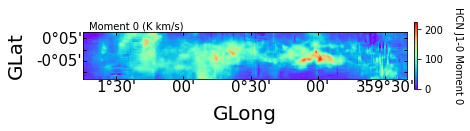

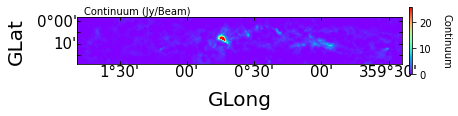

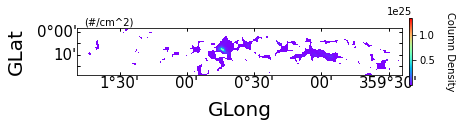

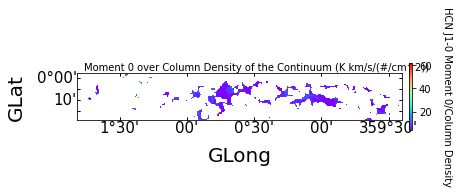

[74] [74] (155, 100)
<class 'float'> <class 'float'> 0.4


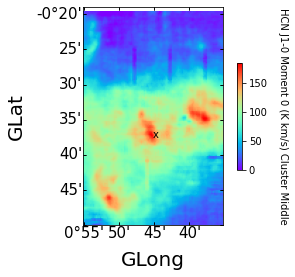

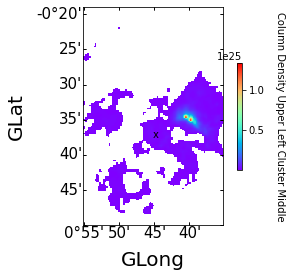

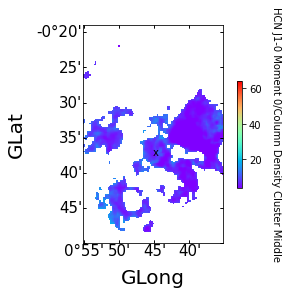

-5.606729551991791

88631847300.0 Hz
38.98800015444 arcsec 38.98800015444 arcsec
10.55599979032924 pix2
(830,)
33.745183269182775
(299,)
(299,) (299,)
[4.39453088 0.4657916 ] [[ 0.05497862 -0.00624173]
 [-0.00624173  0.00087468]] Size Linewidth All_structures:
a =  4.394530881577988 +- 0.23447520696852167
b =  0.4657916024650146 +- 0.029574997975741247
[7.62868403e+23 2.95363072e+00] [[ 2.41715201e+46 -1.07876748e+22]
 [-1.07876748e+22  4.83556671e-03]] Radius to Luminosity:
c =  7.62868403237827e+23 +- 1.5547192690096895e+23
d =  2.9536307224973477 +- 0.06953823917177857
(299,) (299,) (186,) (186,) (113,) (113,) <class 'numpy.ndarray'>
(57,) (57,)
[3.87038915 0.5388674 ] [[ 0.07899432 -0.00800114]
 [-0.00800114  0.00096931]] Size Linewidth Region of Interest:
a =  3.8703891527211183 +- 0.28105928735690533
b =  0.5388674040835526 +- 0.031133714271921402
[9.00258244e+23 2.87606197e+00] [[ 4.08880679e+46 -1.45725230e+22]
 [-1.45725230e+22  5.19757610e-03]] Radius to Luminosity  Region of

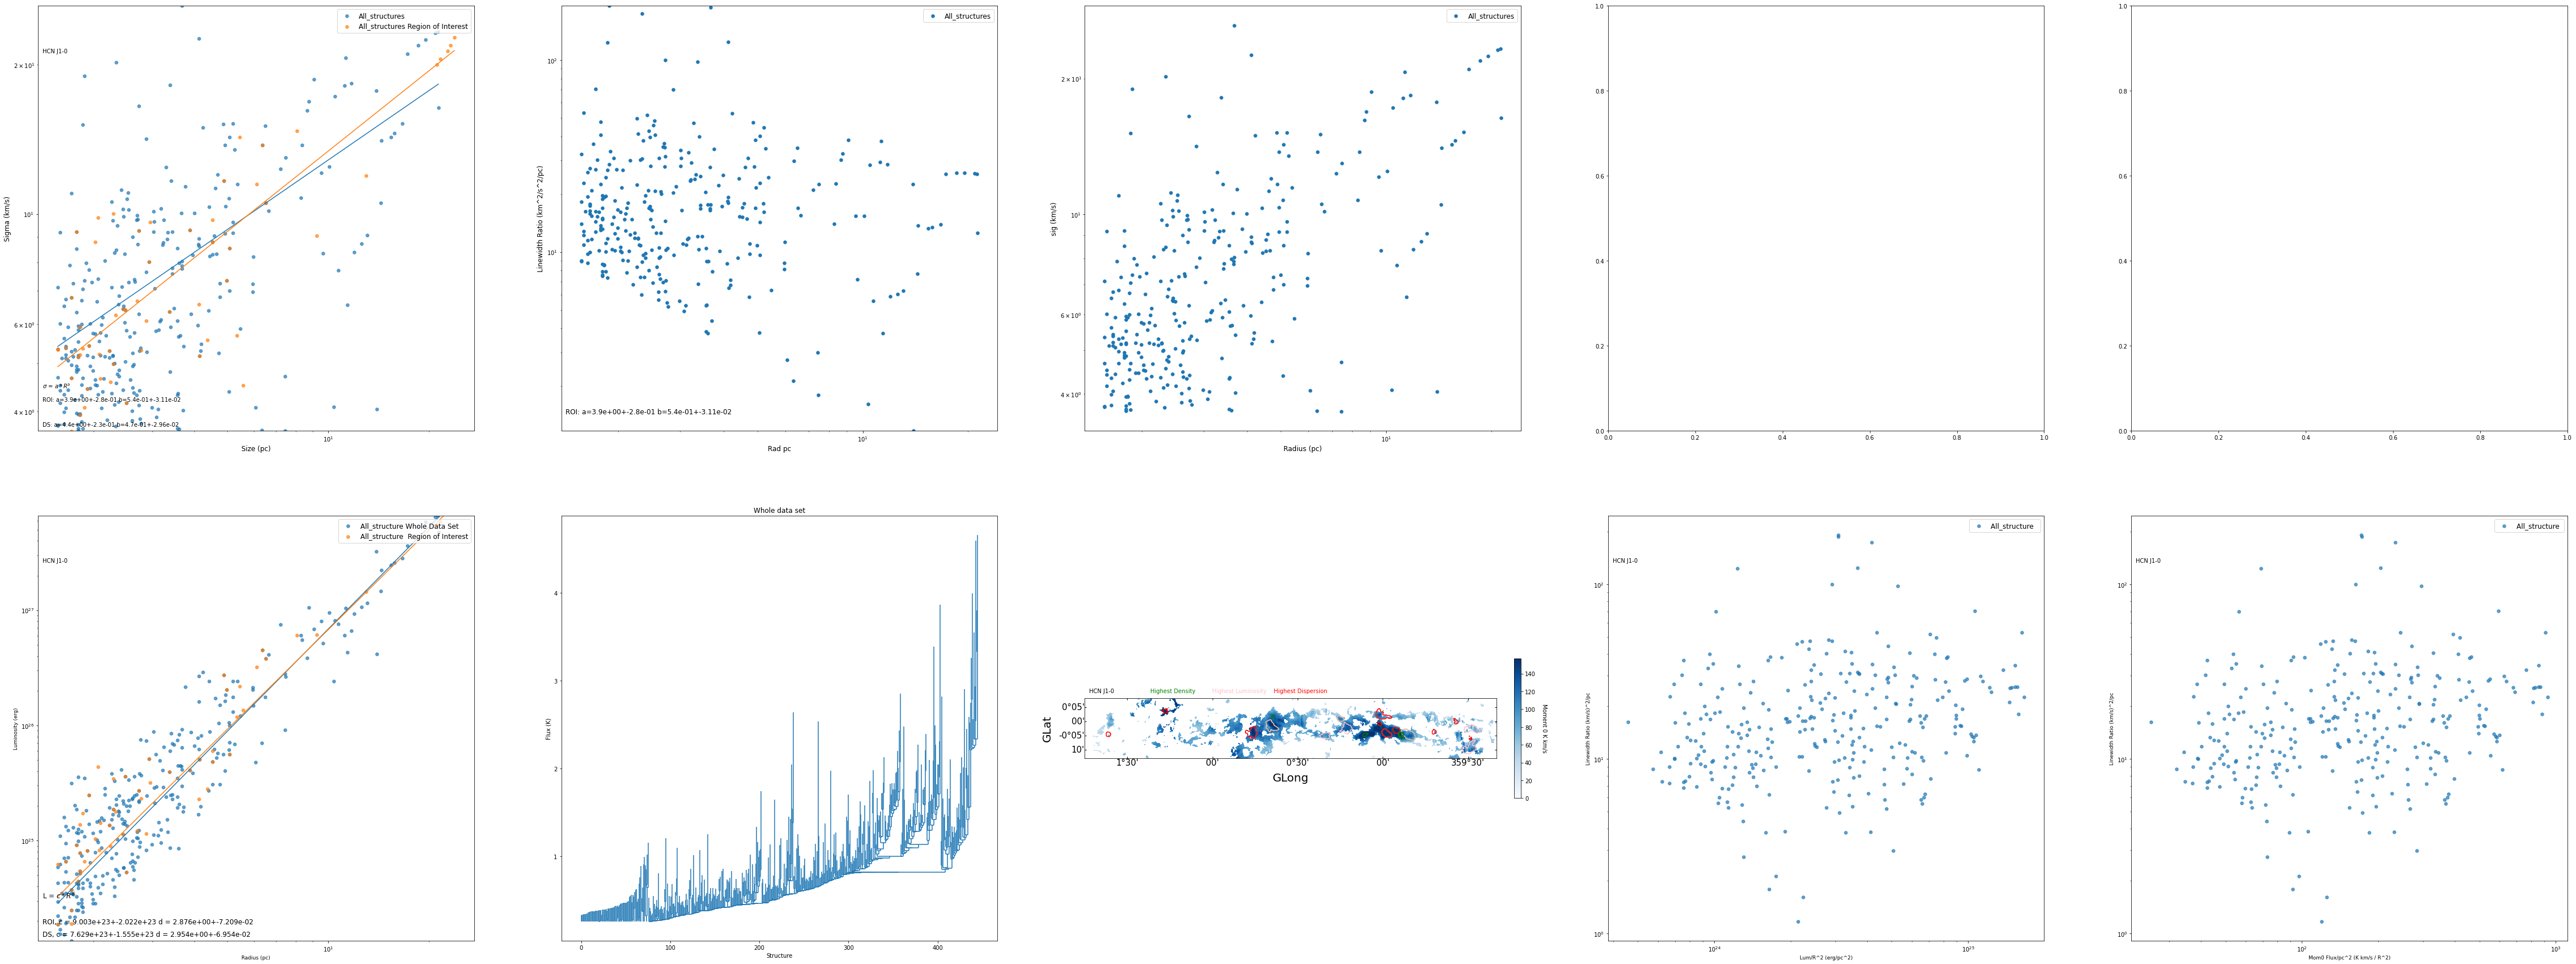

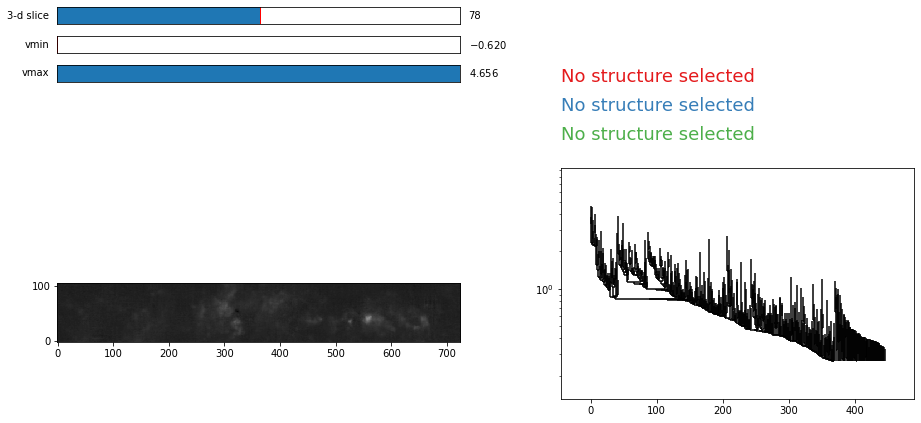

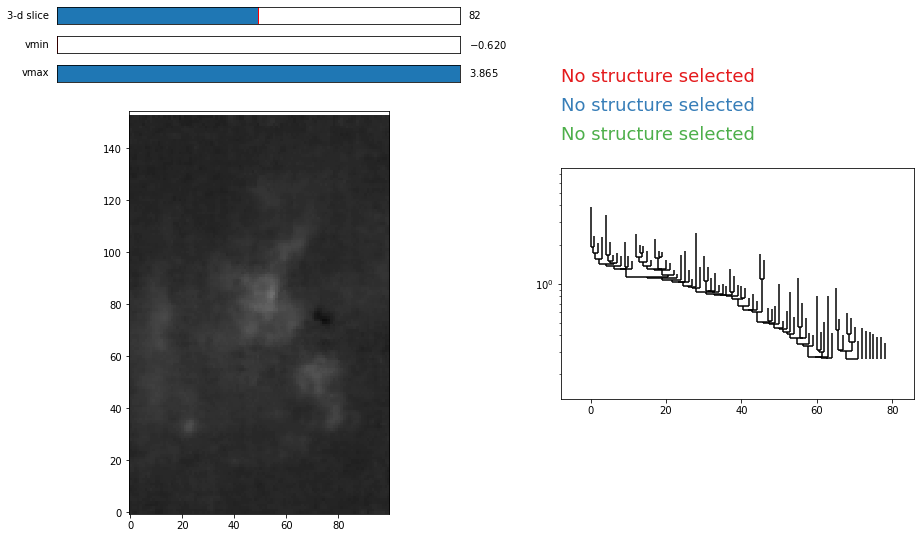

In [24]:
#Manual Contours and stuff

#HCN

###### HCN


Num = 1
Overlaps=0
Ram_Limiter = 1
Name = "HCN_1_0_Abs_CMZ"
name = "HCN_1_0_CM_Contours_DS_10_Abs_CMZ.jpeg"
LineN="HCN J1-0"
Num_per_kg= 6.0221409*10**23/(2.8*10**-3)#6.0221409*10**23/29.0180*10**-3#num/kg for h2


Names[Num] = Name
NameS = (Name+"Sigmas")
NameR = (Name+"Radii")

np.save("Names_CMZ",Names)

print(Name)



path ='CMZ_3mm_HCN.fits'

#pathCont = 'CMZ_Continuum_Reproject.fits'

#path='HCOp_J1-0.cube.fits'
print(path)
Confidences = np.load('Confidence_data_CMZ.npy')

Noises = np.load('Noises_K_CMZ.npy')
#Noises = Ns
m = Noises[Num]
print(m)
#Continuum image

#Put this up here for the column density map


pathCont = 'CMZ_Continuum_Splice.fits'
scCont = spectral_cube.Projection.from_hdu(fits.open(pathCont)[0])
scContW = scCont[30:np.shape(scCont)[0]-30,20:np.shape(scCont)[1]-20] # Make a subcube
#Make subcube
Qp = SpectralCube.read(path).with_spectral_unit(u.km/u.s,velocity_convention="radio")
Qp.allow_huge_operations=True

Q = SpectralCube.read(path).downsample_axis(2,axis=0).with_spectral_unit(u.km/u.s,velocity_convention="radio").spectral_slab(-300. *u.km / u.s, 300. *u.km / u.s).to(u.K)

sc = Q.unmasked_copy()
#scQ = Q
scW = sc.wcs[:][:][0]


dat = sc.hdu.data[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),:,:]
scn = sc[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),:,:]
print(np.shape(dat),np.shape(scn))

datn = dat[5:np.shape(dat)[0]-5,30:np.shape(dat)[1]-30,20:np.shape(dat)[2]-20] # Make a subcube
scF= scn[5:np.shape(dat)[0]-5,30:np.shape(scn)[1]-30,20:np.shape(scn)[2]-20] # Make a subcube

#Do the same thing to the continuum image

metadata = {}
metadata["Cwcs"] = scContW.wcs
print(np.shape(datn),np.shape(scContW))

try:
    #
    sssss=1
except:
    #
    sssss=1
arc_per_pix_yc =  abs(scCont.hdu.header["CDELT1"]*3600.0 * u.arcsec)/u.pix
arc_per_pix_xc =  abs(scCont.hdu.header["CDELT2"]*3600.0 * u.arcsec)/u.pix
beam_majorc =  scCont.hdu.header["BMAJ"]*3600.0 * u.arcsec
beam_minorc =  scCont.hdu.header["BMIN"]*3600.0 * u.arcsec
beam_area_ratioc = beam_minorc*beam_majorc/arc_per_pix_yc/arc_per_pix_xc#This is for FWHM, use *(2*np.sqrt(2*np.log(2)))**2#For gaussian beam

metadata['beam_area_ratioc']=beam_area_ratioc

metadata["arc_per_pix"]= abs(scCont.hdu.header["CDELT1"]*3600.0 * u.arcsec)/u.pix
D_Es = np.load("Pixel_D.npy")*u.Mpc
#print(D_Es)
pc_per_pixelc = abs(scCont.hdu.header["CDELT1"])/180*np.pi*D_Es/u.Mpc


#Cubes with little dense gas and abs
'''
AbpRAD1 = SkyCoord('00h47m32.95s', '-25d17m24.0s', frame='icrs')
AbpRAD2 = SkyCoord('00h47m32.6s', '-25d17m16.0s', frame='icrs')
SCNA= Crop(scn,scW,AbpRAD1,AbpRAD2,5,False)
scContNA = Crop(scCont,scCont.wcs,AbpRAD1,AbpRAD2,0,True)
datna = SCNA.hdu.data 
print(np.shape(SCNA))
'''
UL1 = SkyCoord('00d55m00s',  '-00d50m00s', frame='galactic')#These are away from the sources
UL2 = SkyCoord('00d35m00s','01d30m00s', frame='galactic')
scWCS = scF.wcs[:][:][0]
#scWCSNA = SCNA.wcs[:][:][0]
#moment_0_subNA  = SCNA.moment(order=0,how='slice')            # Calculate the Moment 0 map 
moment_0_sub  = scF.moment(order=0,how='slice')            # Calculate the Moment 0 map 
ROI = Crop(scCont,scCont.wcs,UL1,UL2,5,True)
ROI_Line = Crop(scn,scn.wcs[:][:][0],UL1,UL2,0,False)
moment_0_ROI = ROI_Line.moment(order=0,how='slice')            # Calculate the Moment 0 map 

moment_0_sub  = scF.moment(order=0,how='slice')            # Calculate the Moment 0 map 
######Moment 0 for both
######and cont
Make_Plot((LineN+" Moment 0"),"Moment 0 (K km/s)",moment_0_sub.hdu.data,0,np.nanmax(moment_0_sub.hdu.data),moment_0_sub.wcs,1,1,1,True)
Make_Plot("Continuum","Continuum (Jy/Beam)",scContW.hdu.data,0,np.nanmax(scCont.hdu.data)*.2,scCont.wcs,1,1,1,True)
#Make_Plot((LineN+" Moment 0"),"Moment 0 No Abs Region (K km/s)",moment_0_subNA.hdu.data,0,np.nanmax(moment_0_subNA.hdu.data),moment_0_subNA.wcs,1,1,1,True)


cSD = (Flux_to_Mass(scContW.hdu.data*u.Jy/u.beam/beam_area_ratioc*u.pix**2*u.beam,metadata)/(pc_per_pixelc*10**6*3.086*10**18*u.cm)**2)*(1.989*10**30*u.kg/u.M_sun)*Num_per_kg/u.kg #Flux goes to luminosity for a gaussian beam and goes to column density for square pixels, mass goes to kg to number
rm=moment_0_sub.hdu.data/cSD
rmU = rm*u.K*u.km/u.s#Just put back in the units
rmU = np.array(rmU /(u.K*u.km/u.s)/u.cm**2*10**22,dtype='float64')#Now remove them all
#print(rmU[0][0])
######ratio

Np1 = SkyCoord('359d40m00s',  '00d04m00s', frame='galactic')#These are away from the sources
Np2 = SkyCoord('359d35m00s','00d08m00s', frame='galactic')
NraDP1 = [int(scContW.wcs.world_to_pixel(Np1)[0]),int(scContW.wcs.world_to_pixel(Np1)[1])]
NraDP2 = [int(scContW.wcs.world_to_pixel(Np2)[0]),int(scContW.wcs.world_to_pixel(Np2)[1])]
#print(cSD[NraDP1[1]-50:NraDP2[1]+50,NraDP1[0]-50:NraDP2[0]+50])
#if(str(np.nanmean((cSD[NraDP1[1]-50:NraDP2[1]+50,NraDP1[0]-50:NraDP2[0]+50])))!=str(np.nan)):
#bp = np.where(cSD<=np.nanmean(np.nanstd(cSD[NraDP1[1]-50:NraDP2[1]+50,NraDP1[0]-50:NraDP2[0]+50]))*.001)
bp = np.where(cSD<=7*10**22/u.cm**2)
#bp2 = np.where( moment_0_sub.hdu.data < m*.01)
#print(np.nanmean((cSD[NraDP1[1]-50:NraDP2[1]+50,NraDP1[0]-50:NraDP2[0]+50]))*.001)
cSD[bp]=np.nan
rmU[bp]=np.nan
    #rmU[bp2]=np.nan

#print(cSD[0][0])

#Make_Plot("HCO+ Moment 0/Column Density","Moment 0 over Column Density of the Continuum (K km/s/(#/cm^2))",moment_0_subNA.hdu.data,0,np.nanmax(moment_0_subNA.hdu.data),scCont.wcs,1,1,1,True)
Make_Plot("Column Density","(#/cm^2)",np.array(cSD*u.cm**2,dtype=type(.08)),float(np.nanmin(cSD*u.cm**2)),float(np.nanmax(cSD*u.cm**2)),scCont.wcs,1,1,1,True)
Make_Plot((LineN+" Moment 0/Column Density"),"Moment 0 over Column Density of the Continuum (K km/s/(#/cm^2))",rmU,np.nanmean(rmU)*.5,abs(np.nanmean(rmU))*8,scCont.wcs,1,1,1,True)


#Region of interest in the cont

Find_Pixel_D(ROI.hdu.data,metadata,"Brightest_CD")

D_EROI = np.load("Brightest_CD.npy")*u.Mpc
pc_per_pixelcROI = abs(scCont.hdu.header["CDELT1"])/180*np.pi*D_EROI/u.Mpc

cSDROI = (Flux_to_Mass(ROI.hdu.data*u.Jy/u.beam/beam_area_ratioc*u.pix**2*u.beam,metadata,D_Name = "Brightest_CD.npy")/(pc_per_pixelcROI*10**6*3.086*10**18*u.cm)**2)*(1.989*10**30*u.kg/u.M_sun)*Num_per_kg/u.kg #Flux goes to luminosity for a gaussian beam and goes to column density for square pixels, mass goes to kg to number
rmROI=moment_0_ROI.hdu.data/cSDROI
rmUROI = rmROI*u.K*u.km/u.s#Just put back in the units
rmUROI = np.array(rmUROI /(u.K*u.km/u.s)/u.cm**2*10**22,dtype='float64')#Now remove them all

######ratio
    
#bproi = np.where(cSDROI<=np.nanmean((cSD[NraDP1[1]-50:NraDP2[1]+50,NraDP1[0]-50:NraDP2[0]+50]))*.01)
bproi = np.where(cSDROI<=7*10**22/u.cm**2)
#bp2 = np.where( moment_0_ROI.hdu.data < m*.01)
#print(np.nanmean((cSD[NraDP1[1]-50:NraDP2[1]+50,NraDP1[0]-50:NraDP2[0]+50]))*.01)
cSDROI[bproi]=np.nan
rmUROI[bproi]=np.nan
#rmUROI[bp2]=np.nan

z,yf,xf = np.where(ROI_Line.hdu.data==np.nanmax(ROI_Line.hdu.data))
print(xf,yf,np.shape(ROI.hdu.data))
xf,yf = float(xf/np.shape(ROI.hdu.data)[1]),float(yf/np.shape(ROI.hdu.data)[0])
xf,yf = .5,.4
print(type(xf),type(.5),yf)
Make_Plot_Anno((LineN+" Moment 0 (K km/s) Cluster Middle"),"x",moment_0_ROI.hdu.data,0,np.nanmax(moment_0_ROI.hdu.data),ROI.wcs,1,1,1,True,xf,yf)
Make_Plot_Anno("Column Density Upper Left Cluster Middle","x",np.array(cSDROI*u.cm**2,dtype=type(.08)),float(np.nanmin(cSDROI*u.cm**2)),float(np.nanmax(cSDROI*u.cm**2)),ROI.wcs,1,1,1,True,xf,yf)
Make_Plot_Anno((LineN+" Moment 0/Column Density Cluster Middle"),"x",rmUROI,np.nanmean(rmUROI)*.5,abs(np.nanmean(rmUROI))*8,ROI.wcs,1,1,1,True,xf,yf)


print(np.nanmin(rmU))




header = scF.hdu.header
print()
#make metadata for the dendrogram

try:
    freq = header["RESTFREQ"]*u.Hz#
    metadata['wavelength']=299792458*u.m/header["RESTFREQ"]#
    print(freq)
except:
    freq = header["RESTFRQ"]*u.Hz#
    metadata['wavelength']=299792458*u.m/header["RESTFRQ"]#
metadata['data_unit'] =u.K# header['BUNIT']
metadata['arc_per_pix_y'] =  abs(header["CDELT1"]*3600.0 * u.arcsec)/u.pix
metadata['arc_per_pix_x'] =  abs(header["CDELT2"]*3600.0 * u.arcsec)/u.pix


metadata['beam_major'] =  header["BMAJ"]*3600.0 * u.arcsec
metadata['beam_minor'] =  header["BMIN"]*3600.0 * u.arcsec
beam_area_ratio = metadata['beam_minor']*metadata['beam_major']/metadata['arc_per_pix_y']/metadata['arc_per_pix_x']#This is for FWHM, use *(2*np.sqrt(2*np.log(2)))**2#For gaussian beam
metadata['beam_area_ratio']=beam_area_ratio
metadata['spatial_scale'] = np.sqrt(abs(header["CDELT1"])*u.degree**2*abs(header["CDELT2"]))
area_res = abs(header["CDELT1"])*abs(header["CDELT2"])*(np.pi/180*D_Es/u.Mpc)**2#mpc^2/pix^2

#print(area_res,type(area_res))
print(metadata['beam_minor'],metadata['beam_major'])
print(beam_area_ratio)
#metadata["wcs"] = wcs
metadata["velocity_scale"] = abs(header["CDELT3"])*u.km/u.s#3.3714064157379937*u.km/u.s

metadata["vaxis"]=0



metadata["ARND"] = abs(header["CDELT1"])*abs(header["CDELT2"])








d = astrodendro.Dendrogram.compute(datn,min_delta=m,min_value=m*5,min_npix=50) #The main culprit
#dNA = astrodendro.Dendrogram.compute(datna,min_value=m*5,min_delta=m,min_npix=50) #The main culprit


dUL = astrodendro.Dendrogram.compute(ROI_Line.hdu.data,min_value=m*5,min_delta=m,min_npix=50) #The main culprit



##Analyze dendograms
print(np.shape(d))




fig = plt.figure(1,figsize=(80,80))


axAlpha = pylab.subplot(5, 5, 7)


axGamma = pylab.subplot(5, 5, 9)




p=d.plotter()
p.plot_tree(axAlpha)
axAlpha.set_xlabel("Structure")
axAlpha.set_ylabel("Flux (K)")
axAlpha.set_title("Whole data set")

            
'''

p=dNA.plotter()
p.plot_tree(axBeta)
axBeta.set_xlabel("Structure")
axBeta.set_ylabel("Flux (K)")
axBeta.set_title("No absorption region")

'''
#p=dUL.plotter()
#p.plot_tree(axGamma)
#xGamma.set_xlabel("Structure")
#axGamma.set_ylabel("Flux (K)")
#axGamma.set_title("Region of Interest")
''''''

pc_per_pixel = abs(header["CDELT1"])/180*np.pi*D_Es/u.Mpc

sig_per_pixel=np.nan#metadata['spectral_resolution']/u.pix


#Finds Size, Linewidth, Luminosity, and Column Density of a structure for each structure and returns them in [[][]] arrays [Leaves][Branches]
vel,RA,Dec = scF.world[:,0,0]
Rads,Sigmas,CD,Lumin ,SIDS,MOM0FLUX= Dendro_Arrays(d,datn,vel,scContW.hdu.data,metadata)

#Plot contours for the top ten clusters


scCropped =scF.moment0().hdu.data
scCropped[np.where(scF.moment0().hdu.data<.22)]=np.nan
print(np.nanmean(np.nanstd(scF.moment0().hdu.data))*1)
scCropped[bp]=np.nan
axBeta = pylab.subplot(5,5,8,projection=scF.moment0().wcs)
#axBeta.imshow(scCropped.moment0().hdu.data, origin='lower', interpolation='nearest', cmap=plt.cm.Blues,norm=colors.LogNorm(vmin=5))
imBeta = axBeta.imshow(scCropped, origin='lower', interpolation='nearest', cmap=plt.cm.Blues,vmin=0,vmax = np.nanmax(scCropped)*.7 )



ColumnCon= np.concatenate((CD[0],CD[1]))
SIDScon = np.concatenate((SIDS[0],SIDS[1]))
#nth = sorted(ColumnCon)[len(ColumnCon)-30]
nth = sorted(CD[0])[len(CD[0])-10]
nth2 = sorted(Lumin[0])[len(Lumin[0])-10]
nth3 = sorted(Sigmas[0])[len(Sigmas[0])-10]
#top = np.where(CD[0]>=nth)
#print(list(top))
'''
for n in range(len(ColumnCon)):
    
    if(ColumnCon[n]>=nth):
        #print(n,SIDS[0])
        p.plot_contour(axBeta, structure=int(SIDScon[n]), lw=.1, colors='red')
        #NOT USING LEAVSE FOR STRUCTURES, USING ALL STRUCTURES
        #solved?
'''
G1 = True
G2 = True
G3 = True
for n in range(len(CD[0])):
    
    if(CD[0][n]>=nth):
        #print(n,SIDS[0])
        if(G1):
            G1=False
            p.plot_contour(axBeta, structure=int(SIDS[0][n]), lw=1, colors='green',label="Higest Density")
        else:
            p.plot_contour(axBeta, structure=int(SIDS[0][n]), lw=1, colors='green')
        #NOT USING LEAVSE FOR STRUCTURES, USING ALL STRUCTURES
        #solved?
    if(Lumin[0][n]>=nth2):
        #print(n,SIDS[0])
        if(G2):
            G2=False
            p.plot_contour(axBeta, structure=int(SIDS[0][n]), lw=2, colors="pink",label="Highest Luminosity (Leaves)")
        else:
            p.plot_contour(axBeta, structure=int(SIDS[0][n]), lw=2, colors="pink")
        #NOT USING LEAVSE FOR STRUCTURES, USING ALL STRUCTURES
        #solved?
    if(Sigmas[0][n]>=nth3):
        #print(n,SIDS[0])
        if(G3):
            G3=False
            p.plot_contour(axBeta, structure=int(SIDS[0][n]), lw=3, colors='red',label="Highest Dispersion")
        else:
            p.plot_contour(axBeta, structure=int(SIDS[0][n]), lw=3, colors='red')
        #NOT USING LEAVSE FOR STRUCTURES, USING ALL STRUCTURES
        #solved?
   
  


RA = axBeta.coords[0]                                                                  # 
Dec = axBeta.coords[1]

RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('GLong',fontsize=20,labelpad=1)                               
pylab.ylabel('GLat',fontsize=20,labelpad=1)
axBeta.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(imBeta,fraction=0.016,pad=0.04)                                     
cb.set_label(label="Moment 0 K km/s",fontsize=10,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)   
pylab.annotate(s=LineN,fontsize=10,xy=(.01,1.1),xycoords="axes fraction",c="black")  
pylab.annotate(s="Highest Density",fontsize=10,xy=(.16,1.1),xycoords="axes fraction",c="green")  
pylab.annotate(s="Highest Luminosity",fontsize=10,xy=(.31,1.1),xycoords="axes fraction",c="pink")  
pylab.annotate(s="Highest Dispersion",fontsize=10,xy=(.46,1.1),xycoords="axes fraction",c="red")  

    
    
    
    
#RadsNA,SigmasNA,CDNA,LuminNA = Dendro_Arrays(dNA,datna,vel,scContNA.hdu.data,metadata)
RadsUL,SigmasUL,CDUL,LuminUL,SIDSUL,MOM0FLUXUL = Dendro_Arrays(dUL,ROI_Line.hdu.data,vel,ROI.hdu.data,metadata)


#def Dendro_Arrays(Dendrogram,LineData,DataVel,ContData,metadata):
    

from scipy.optimize import curve_fit
from scipy.optimize import leastsq

def func(R,a,b):
    return a*R**(b)
try:
    popt, pcov = curve_fit(func, Rads[0]*10**6,Sigmas[0])
except:
    popt, pcov = [np.nan,np.nan],[[np.nan,np.nan],[np.nan,np.nan]]
try:
    poptB, pcovB = curve_fit(func,  Rads[1]*10**6,Sigmas[1])
except:
    poptB, pcovB = [np.nan,np.nan],[[np.nan,np.nan],[np.nan,np.nan]]


    
Rcon = np.concatenate((Rads[0],Rads[1]))
Scon = np.concatenate((Sigmas[0],Sigmas[1]))
print(np.shape(Rcon))
poptCon, pcovCon = curve_fit(func, Rcon*10**6, Scon)







    
RconUL = np.concatenate((RadsUL[0],RadsUL[1]))
SconUL = np.concatenate((SigmasUL[0],SigmasUL[1]))

poptUL, pcovUL = curve_fit(func, RconUL*10**6, SconUL)



xs=np.linspace(np.nanmin(Rcon*10**6),np.nanmax(Rcon*10**6),50)
ysL,ysB,ysCon=func(xs,popt[0],popt[1]),func(xs,poptB[0],poptB[1]),func(xs,poptCon[0],poptCon[1])



LuminCon = np.concatenate((Lumin[0],Lumin[1]))

MOM0FLUXcon = np.concatenate((MOM0FLUX[0],MOM0FLUX[1]))
#Flux ratios fit
#FRpopt,FRpcov = curve_fit(func, abs(FRs),Scon**2/Rcon/10**6)
#xsF=np.linspace(np.nanmin(abs(FRs)),np.nanmax(abs(FRs)),50)
#ysF = func(xsF,FRpopt[0],FRpopt[1])

#Radius Luminosity fit
gp = np.where(LuminCon>0)
print(np.shape(Rcon),np.shape(LuminCon))
lgp = LuminCon[gp]
radgp = Rcon[gp]*10**6
#print(np.shape(Rcon[gp]*10**6),np.shape(LuminCon[gp]))
RLpopt,RLpcov = curve_fit(func, np.array(radgp,dtype='float64'),np.array(lgp,dtype='float64'),maxfev=999999,p0 = np.array([10**27,1],dtype='float64'),ftol = 10**-10)

xsRL=np.linspace(np.nanmin(radgp),np.nanmax(radgp),50)
ysRL = func(xsRL,RLpopt[0],RLpopt[1])



#Column density to Size-linewidth
gp2 = np.where(ColumnCon>0)

radgpFORRAT = Rcon[gp2]*10**6
siggpFORRAT = Scon[gp2]


lumFORRAT = LuminCon[gp2]
mom0FORRAT = MOM0FLUXcon[gp2]
rgp=Scon[gp2]**2/Rcon[gp2]/10**6

gp3 = np.where(lumFORRAT>0)
lumFORRAT = lumFORRAT[gp3]
rgpFORRAT = rgp[gp3]
mom0FORRAT = mom0FORRAT[gp3]


print(poptCon,pcovCon,"Size Linewidth All_structures:")
print("a = ",poptCon[0],"+-",np.sqrt(pcovCon[0][0]))
print("b = ",poptCon[1],"+-",np.sqrt(pcovCon[1][1]))



print(RLpopt,RLpcov,"Radius to Luminosity:")
print("c = ",RLpopt[0],"+-",np.sqrt(RLpcov[0][0]))
print("d = ",RLpopt[1],"+-",np.sqrt(RLpcov[1][1]))






ax2 = pylab.subplot(5, 5, 1)
ax3 = pylab.subplot(5, 5, 2)
ax4 = pylab.subplot(5, 5, 3)



print(np.shape(Rcon*10**6),np.shape(Scon),np.shape(Rads[0]*10**6),np.shape(Sigmas[0]),np.shape(Rads[1]*10**6),np.shape(Sigmas[1]),type(Rads[0]))
#xpcon,xpL,xpB = ax2.scatter(Rcon*10**6,Scon,label="All_structures",s=30),ax2.scatter(Rads[0]*10**6,Sigmas[0],s=30),ax2.scatter(Rads[1]*10**6,Sigmas[1],s=30)
xpcon = ax2.scatter(Rcon*10**6,Scon,label="All_structures",s=30,alpha=.7)
#p,p2,p3 = ax2.plot(xs,ysCon),ax2.plot(xs,ysL),ax2.plot(xs,ysB)
p = ax2.plot(xs,ysCon)

#pNA = ax2.plot(xsNA,ysNA)
#xpNA = ax2.scatter(RconNA*10**6,SconNA,label="All_structures Sparse region",s=30,alpha=.7)

xpconhh = ax2.scatter(RconUL*10**6,SconUL,label="All_structures Region of Interest",s=30,alpha=.7)
xsUL=np.linspace(np.nanmin(RconUL*10**6),np.nanmax(RconUL*10**6),50)
ysUL=func(xsUL,poptUL[0],poptUL[1])
p22 = ax2.plot(xsUL,ysUL)


st="DS: a="+ str(np.format_float_scientific(poptCon[0],1))+"+-"+str(np.format_float_scientific(np.sqrt(pcovCon[0][0]),1))+" b="+str(np.format_float_scientific(poptCon[1],1))+"+-"+str(np.format_float_scientific(np.sqrt(pcovCon[1][1]),2))
ax2.annotate(s=st,fontsize=10,xy=(0.01,0.01),xycoords="axes fraction")

st="ROI: a="+ str(np.format_float_scientific(poptUL[0],1))+"+-"+str(np.format_float_scientific(np.sqrt(pcovUL[0][0]),1))+" b="+str(np.format_float_scientific(poptUL[1],1))+"+-"+str(np.format_float_scientific(np.sqrt(pcovUL[1][1]),2))
ax2.annotate(s=st,fontsize=10,xy=(0.01,0.07),xycoords="axes fraction")
ax2.annotate(s=r'$\sigma$ = $a*R^b$',fontsize=10,xy=(0.01,0.10),xycoords="axes fraction")
ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.set_ylim(np.nanmin(Scon),np.nanmax(Scon))
ax2.set_xlabel("Size (pc)",fontsize=12)
ax2.set_ylabel("Sigma (km/s)",fontsize=12)
ax2.legend(prop={'size': 12},loc="upper right")
ax2.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")

#gp = np.where(FRs>0)





xspF = ax3.scatter(radgpFORRAT,rgp,label="All_structures",s=30)
#pF = ax3.plot(xsCD,ysCD)
#ax3.annotate(s=r'$\sigma^2/R$ = $e*N^f$',fontsize=12,xy=(0.01,0.07),xycoords="axes fraction")
#st = "e = "+ str(np.format_float_scientific(CDpopt[0],3))+"+-"+str(np.format_float_scientific(np.sqrt(CDpcov[0][0]),3))+" f = "+str(np.format_float_scientific(CDpopt[1],3))+"+-"+str(np.format_float_scientific(np.sqrt(CDpcov[1][1]),3))

ax3.annotate(s=st,fontsize=12,xy=(0.01,0.04),xycoords="axes fraction")
ax3.set_yscale('log')
ax3.set_xscale('log')
ax3.set_ylim(np.nanmin(rgp),np.nanmax(rgp))
ax3.set_xlabel("Rad pc",fontsize=12)
ax3.set_ylabel("Linewidth Ratio (km^2/s^2/pc)",fontsize=12)
ax3.legend(prop={'size': 12})



xspL = ax4.scatter(radgpFORRAT,siggpFORRAT,label="All_structures",s=30)
#pFLL = ax4.plot(xsRL,ysRL)

#st = "c = "+ str(np.format_float_scientific(RLpopt[0],3))+"+-"+str(np.format_float_scientific(np.sqrt(RLpcov[0][0]),3))+" d = "+str(np.format_float_scientific(RLpopt[1],3))+"+-"+str(np.format_float_scientific(np.sqrt(RLpcov[1][1]),3))
#ax4.annotate(s='L = $c*R^d$',fontsize=12,xy=(0.01,0.07),xycoords="axes fraction")
#ax4.annotate(s=st,fontsize=12,xy=(0.01,0.04),xycoords="axes fraction")

ax4.set_yscale('log')
ax4.set_xscale('log')
#ax4.set_ylim(np.nanmin(lgp),np.nanmax(lgp))
ax4.set_xlabel("Radius (pc)",fontsize=12)
ax4.set_ylabel("sig (km/s)",fontsize=12)
ax4.legend(prop={'size': 12},loc="upper right")














LuminConUL = np.concatenate((LuminUL[0],LuminUL[1]))
#Radius Luminosity fit
gp = np.where(LuminConUL>0)
lgpUL = LuminConUL[gp]
radgpUL = RconUL[gp]*10**6
print(np.shape(radgpUL),np.shape(lgpUL))
RLpoptUL,RLpcovUL = curve_fit(func, np.array(radgpUL,dtype='float64'),np.array(lgpUL,dtype='float64'),maxfev=999999,p0 = np.array([10**27,1],dtype='float64'),ftol = 10**-10)

xsRLUL=np.linspace(np.nanmin(radgpUL),np.nanmax(radgpUL),50)
ysRLUL = func(xsRLUL,RLpoptUL[0],RLpoptUL[1])

#Column density to Size-linewidth

print(poptUL,pcovUL,"Size Linewidth Region of Interest:")
print("a = ",poptUL[0],"+-",np.sqrt(pcovUL[0][0]))
print("b = ",poptUL[1],"+-",np.sqrt(pcovUL[1][1]))

print(RLpoptUL,RLpcovUL,"Radius to Luminosity  Region of Interest:")
print("c = ",RLpoptUL[0],"+-",np.sqrt(RLpcovUL[0][0]))
print("d = ",RLpoptUL[1],"+-",np.sqrt(RLpcovUL[1][1]))


ax5 = pylab.subplot(5, 5, 4)
ax6 = pylab.subplot(5, 5, 5)
ax7 = pylab.subplot(5, 5, 6)








xspLu2 = ax7.scatter(radgp,lgp,label="All_structure Whole Data Set",s=30,alpha=.7)
pFLLu2 = ax7.plot(xsRL,ysRL)
#xspLu2NA = ax7.scatter(radgpNA,lgpNA,label="All_structure Sparse Region",s=30,alpha=.7)
#pFLLu2NA = ax7.plot(xsRLNA,ysRLNA)

xspLu = ax7.scatter(radgpUL,lgpUL,label="All_structure  Region of Interest",s=30,alpha=.7)

pFLLu = ax7.plot(xsRLUL,ysRLUL)


st = "DS, c = "+ str(np.format_float_scientific(RLpopt[0],3))+"+-"+str(np.format_float_scientific(np.sqrt(RLpcov[0][0]),3))+" d = "+str(np.format_float_scientific(RLpopt[1],3))+"+-"+str(np.format_float_scientific(np.sqrt(RLpcov[1][1]),3))
ax7.annotate(s='L = $c*R^d$',fontsize=12,xy=(0.01,0.10),xycoords="axes fraction")
ax7.annotate(s=st,fontsize=12,xy=(0.01,0.01),xycoords="axes fraction")
st2 = "ROI, c = "+ str(np.format_float_scientific(RLpoptUL[0],3))+"+-"+str(np.format_float_scientific(np.sqrt(RLpcovUL[0][0]),3))+" d = "+str(np.format_float_scientific(RLpoptUL[1],3))+"+-"+str(np.format_float_scientific(np.sqrt(RLpcovUL[1][1]),3))
ax7.annotate(s=st2,fontsize=12,xy=(0.01,0.04),xycoords="axes fraction")

#st3 = "SR, c = "+ str(np.format_float_scientific(RLpoptNA[0],3))+"+-"+str(np.format_float_scientific(np.sqrt(RLpcovNA[0][0]),3))+" d = "+str(np.format_float_scientific(RLpoptNA[1],3))+"+-"+str(np.format_float_scientific(np.sqrt(RLpcovNA[1][1]),3))
#ax7.annotate(s=st3,fontsize=12,xy=(0.01,0.07),xycoords="axes fraction")

ax7.set_yscale('log')
ax7.set_xscale('log')
ax7.set_ylim(np.nanmin(lgp),np.nanmax(lgp))
ax7.set_xlabel("Radius (pc)",fontsize=9)
ax7.set_ylabel("Luminosity (erg)",fontsize=9)
ax7.legend(prop={'size': 12},loc="upper right")
ax7.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")

#print(FRs)



lum_rat = axGamma.scatter(lumFORRAT/radgpFORRAT**2,rgpFORRAT,label="All_structure  ",s=30,alpha=.7)
#Off by factors for area, simply using r^2

axGamma.set_yscale('log')
axGamma.set_xscale('log')
axGamma.set_xlabel("Lum/R^2 (erg/pc^2)",fontsize=9)
axGamma.set_ylabel("Linewidth Ratio (km/s)^2/pc",fontsize=9)
axGamma.legend(prop={'size': 12},loc="upper right")
axGamma.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")



axDelta = pylab.subplot(5, 5, 10)



#mom0_rat = axDelta.scatter(mom0FORRAT/radgpFORRAT**2,rgpFORRAT,label="All_structure  Region of Interest",s=30,alpha=.7)
gp4=np.where(MOM0FLUXcon>0)
mom0FORFlux=MOM0FLUXcon[gp4]
radgpFORFlux=Rcon[gp4]*10**6
rgpFORFlux=Scon[gp4]**2/Rcon[gp4]/10**6
mom0_rat = axDelta.scatter(mom0FORFlux/radgpFORFlux**2,rgpFORFlux,label="All_structure ",s=30,alpha=.7)
#Off by factors for area, simply using r^2

axDelta.set_yscale('log')
axDelta.set_xscale('log')
axDelta.set_xlabel("Mom0 Flux/pc^2 (K km/s / R^2)",fontsize=9)
axDelta.set_ylabel("Linewidth Ratio (km/s)^2/pc",fontsize=9)
axDelta.legend(prop={'size': 12},loc="upper right")
axDelta.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")


pylab.show()


NameCol = (Name+"_Column")
NameLum = (Name+"_Luminosities")

NameColROI = (Name+"_Column_ROI")
NameLumROI = (Name+"_Luminosities_ROI")
NameRROI = (NameR+"_ROI")
NameSROI = (NameS+"_ROI")
NameFlux = (Name+"Flux_Dense")
NameRFF = (Name+"Rad_For_Flux")

v1 = d.viewer()
v1.show()
v3 = dUL.viewer()
v3.show()

#np.save(NameCol,CD)
np.save(NameLum,Lumin)

np.save(NameS,Sigmas)
np.save(NameR,Rads) #Still in [leaves] [breanches] format

#np.save(NameColROI,CDUL)
np.save(NameLumROI,LuminUL)

np.save(NameSROI,SigmasUL)
np.save(NameRROI,RadsUL) #Still in [leaves] [breanches] format

np.save(NameFlux,mom0FORFlux/radgpFORFlux**2)
np.save(NameRFF,rgpFORFlux)



CO_3_2_Abs_CMZ
Fixed_Spliced_CO_V2.fits
0.6261983184086268
(139, 165, 765) (139, 165, 765)
(129, 105, 725) (105, 725)


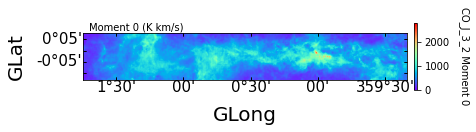

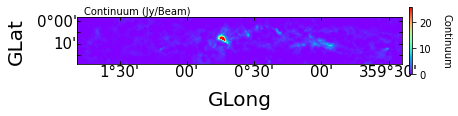


345795990000.0 Hz
B
{'Cwcs': WCS Keywords

Number of WCS axes: 2
CTYPE : 'GLON-SIN'  'GLAT-SIN'  
CRVAL : 0.541666678728  -0.0416666712776  
CRPIX : 363.0  53.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : -0.00333333353753  0.00333333353753  
NAXIS : 725  105, 'beam_area_ratioc': <Quantity 2.30594067 pix2>, 'arc_per_pix': <Quantity 12.00000074 arcsec / pix>, 'wavelength': <Quantity 0.00086696 m>, 'data_unit': 'K', 'arc_per_pix_y': <Quantity 12.00000074 arcsec / pix>, 'arc_per_pix_x': <Quantity 12.00000074 arcsec / pix>, 'BMIN': <Quantity -0.00333333 deg>, 'BMAJ': <Quantity -0.00333333 deg>, 'beam_major': <Quantity -12.00000074 arcsec>, 'beam_minor': <Quantity -12.00000074 arcsec>, 'beam_area_ratio': <Quantity 1. pix2>}
1.0 pix2
(11531,)
[-233.44650848 -229.82279333 -226.19907819 -222.57536305 -218.95164791
 -215.32793277 -211.70421763 -208.08050249 -204.45678735 -200.83307221
 -197.20935707 -193.58564192 -189.96192678 -186.33821164 -182.7144965
 -179.09078136 -175.46

TypeError: data_unit should be an instance of UnitBase or Quantity

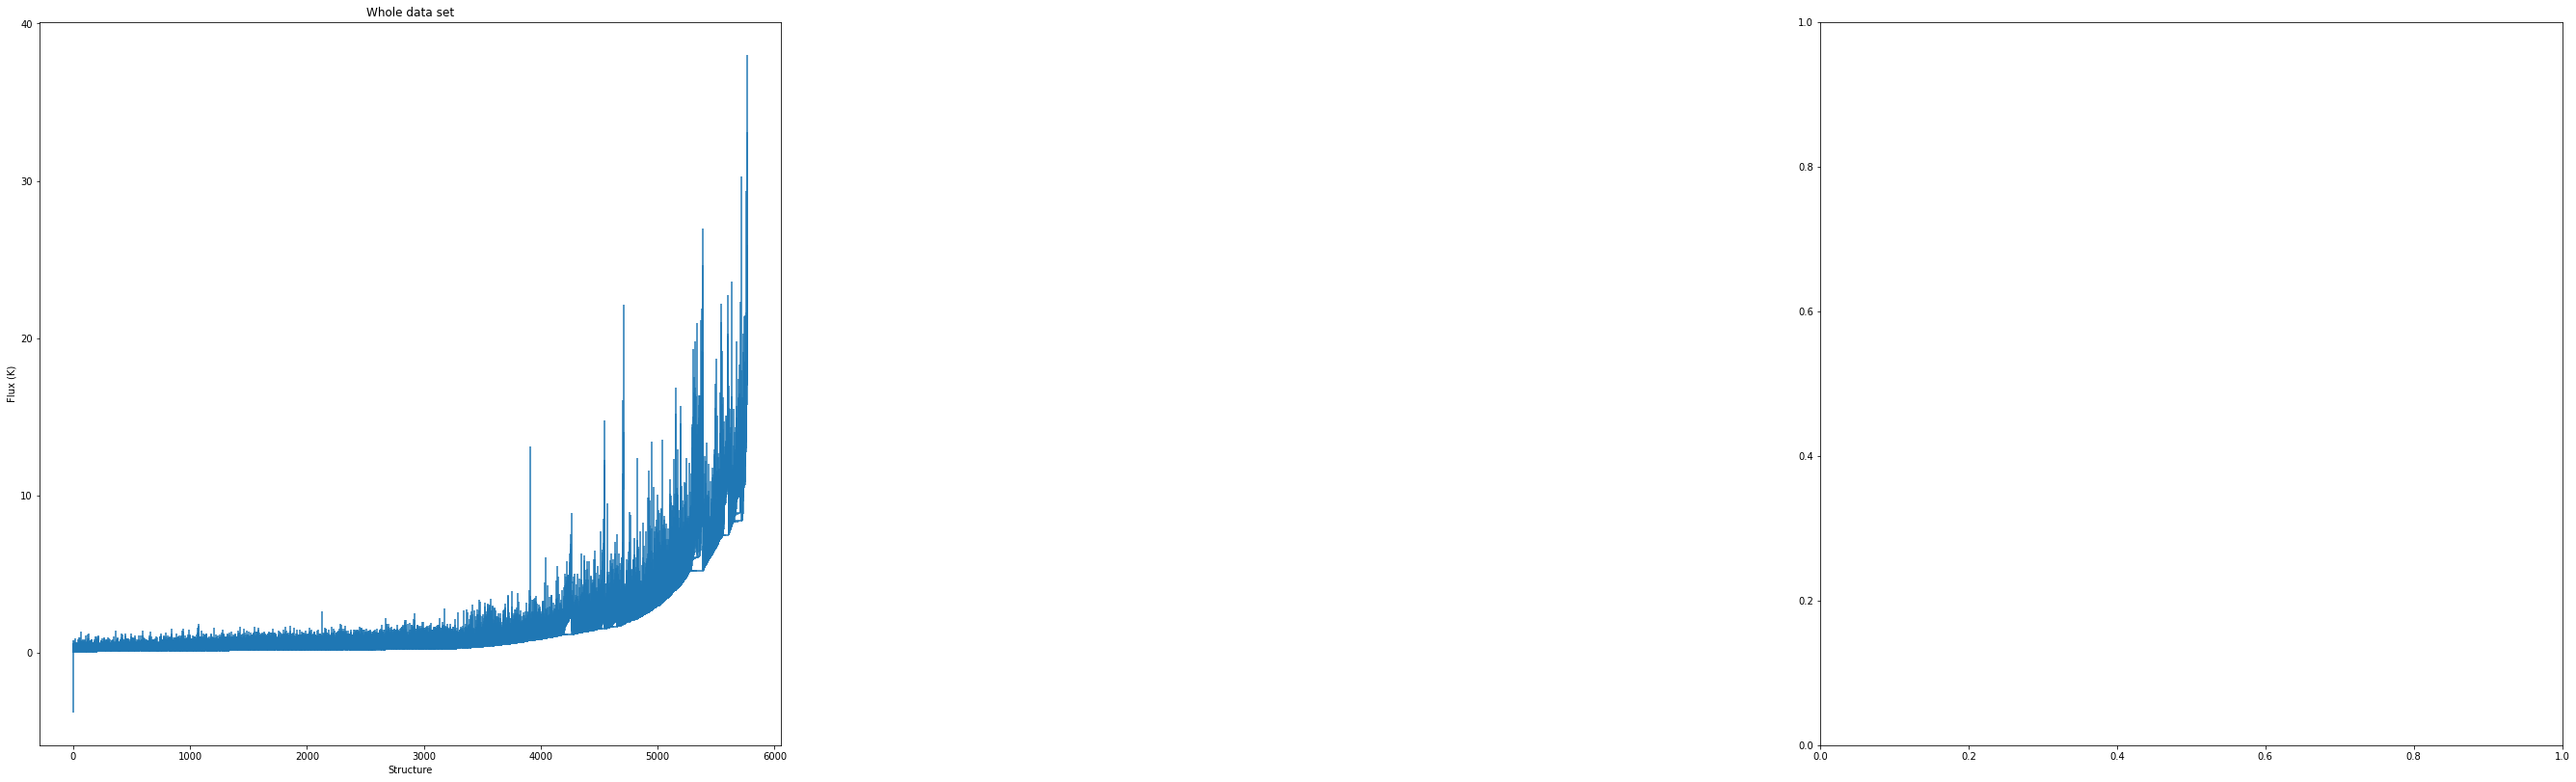

In [14]:
#Manual Contours and stuff

#co32

###### co32



Num = 4
Overlaps=0
Ram_Limiter = 1
Name = "CO_3_2_Abs_CMZ"
name = "CO_3_2_CM_Contours_DS_10_Abs_CMZ.jpeg"
Num_per_kg= 6.0221409*10**23/(2.8*10**-3)#6.0221409*10**23/29.0180*10**-3#num/kg for h2
LineN="CO_J_3_2"

Names[Num] = Name
NameS = (Name+"Sigmas")
NameR = (Name+"Radii")

np.save("Names_CMZ",Names)

print(Name)



#path ="12CO_GC_359-000_mosaic.fit"
path ="Fixed_Spliced_CO_V2.fits"
#pathCont = 'CMZ_Continuum_Reproject.fits'

#path='HCOp_J1-0.cube.fits'
print(path)
Confidences = np.load('Confidence_data_CMZ.npy')

Noises = np.load('Noises_K_CMZ.npy')
#Noises = Ns
m = Noises[Num]
print(m)
#Continuum image

#Put this up here for the column density map


pathCont = 'CMZ_Continuum_Splice.fits'
scCont = spectral_cube.Projection.from_hdu(fits.open(pathCont)[0])
scContW = scCont[30:np.shape(scCont)[0]-30,20:np.shape(scCont)[1]-20] # Make a subcube
#Make subcube
Qp = SpectralCube.read(path).with_spectral_unit(u.km/u.s,velocity_convention="radio")
Qp.allow_huge_operations=True

Q = SpectralCube.read(path)
Q.allow_huge_operations=True
Q = Q.downsample_axis(2,axis=0).with_spectral_unit(u.km/u.s,velocity_convention="radio").spectral_slab(-250. *u.km / u.s, 250. *u.km / u.s)

sc = Q.unmasked_copy()
#scQ = Q
scW = sc.wcs[:][:][0]


dat = sc.hdu.data[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),:,:]
scn = sc[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),:,:]
print(np.shape(dat),np.shape(scn))

datn = dat[5:np.shape(dat)[0]-5,30:np.shape(dat)[1]-30,20:np.shape(dat)[2]-20] # Make a subcube
scF= scn[5:np.shape(dat)[0]-5,30:np.shape(scn)[1]-30,20:np.shape(scn)[2]-20] # Make a subcube

#Do the same thing to the continuum image

metadata = {}
metadata["Cwcs"] = scContW.wcs
print(np.shape(datn),np.shape(scContW))

try:
    #
    sssss=1
except:
    #
    sssss=1
arc_per_pix_yc =  abs(scCont.hdu.header["CDELT1"]*3600.0 * u.arcsec)/u.pix
arc_per_pix_xc =  abs(scCont.hdu.header["CDELT2"]*3600.0 * u.arcsec)/u.pix
beam_majorc =  scCont.hdu.header["BMAJ"]*3600.0 * u.arcsec
beam_minorc =  scCont.hdu.header["BMIN"]*3600.0 * u.arcsec
beam_area_ratioc = beam_minorc*beam_majorc/arc_per_pix_yc/arc_per_pix_xc#This is for FWHM, use *(2*np.sqrt(2*np.log(2)))**2#For gaussian beam

metadata['beam_area_ratioc']=beam_area_ratioc

metadata["arc_per_pix"]= abs(scCont.hdu.header["CDELT1"]*3600.0 * u.arcsec)/u.pix
D_Es = np.load("Pixel_D.npy")*u.Mpc
#print(D_Es)
pc_per_pixelc = abs(scCont.hdu.header["CDELT1"])/180*np.pi*D_Es/u.Mpc


#Cubes with little dense gas and abs
'''
AbpRAD1 = SkyCoord('00h47m32.95s', '-25d17m24.0s', frame='icrs')
AbpRAD2 = SkyCoord('00h47m32.6s', '-25d17m16.0s', frame='icrs')
SCNA= Crop(scn,scW,AbpRAD1,AbpRAD2,5,False)
scContNA = Crop(scCont,scCont.wcs,AbpRAD1,AbpRAD2,0,True)
datna = SCNA.hdu.data 
print(np.shape(SCNA))
'''
UL1 = SkyCoord('00d55m00s',  '-00d50m00s', frame='galactic')#These are away from the sources
UL2 = SkyCoord('00d35m00s','01d30m00s', frame='galactic')
scWCS = scF.wcs[:][:][0]
#scWCSNA = SCNA.wcs[:][:][0]
#moment_0_subNA  = SCNA.moment(order=0,how='slice')            # Calculate the Moment 0 map 
moment_0_sub  = scF.moment(order=0,how='slice')            # Calculate the Moment 0 map 
ROI = Crop(scCont,scCont.wcs,UL1,UL2,5,True)
ROI_Line = Crop(scn,scn.wcs[:][:][0],UL1,UL2,0,False)
moment_0_ROI = ROI_Line.moment(order=0,how='slice')            # Calculate the Moment 0 map 

moment_0_sub  = scF.moment(order=0,how='slice')            # Calculate the Moment 0 map 
######Moment 0 for both
######and cont
Make_Plot((LineN+" Moment 0"),"Moment 0 (K km/s)",moment_0_sub.hdu.data,0,np.nanmax(moment_0_sub.hdu.data),moment_0_sub.wcs,1,1,1,True)
Make_Plot("Continuum","Continuum (Jy/Beam)",scContW.hdu.data,0,np.nanmax(scCont.hdu.data)*.2,scCont.wcs,1,1,1,True)
#Make_Plot((LineN+" Moment 0"),"Moment 0 No Abs Region (K km/s)",moment_0_subNA.hdu.data,0,np.nanmax(moment_0_subNA.hdu.data),moment_0_subNA.wcs,1,1,1,True)


######ratio

Np1 = SkyCoord('359d40m00s',  '00d04m00s', frame='galactic')#These are away from the sources
Np2 = SkyCoord('359d35m00s','00d08m00s', frame='galactic')
NraDP1 = [int(scContW.wcs.world_to_pixel(Np1)[0]),int(scContW.wcs.world_to_pixel(Np1)[1])]
NraDP2 = [int(scContW.wcs.world_to_pixel(Np2)[0]),int(scContW.wcs.world_to_pixel(Np2)[1])]
#print(cSD[NraDP1[1]-50:NraDP2[1]+50,NraDP1[0]-50:NraDP2[0]+50])
#if(str(np.nanmean((cSD[NraDP1[1]-50:NraDP2[1]+50,NraDP1[0]-50:NraDP2[0]+50])))!=str(np.nan)):
#bp = np.where(cSD<=np.nanmean(np.nanstd(cSD[NraDP1[1]-50:NraDP2[1]+50,NraDP1[0]-50:NraDP2[0]+50]))*.001)

#print(cSD[0][0])


header = scF.hdu.header
print()
#make metadata for the dendrogram

try:
    freq = header["RESTFREQ"]*u.Hz#
    metadata['wavelength']=299792458*u.m/header["RESTFREQ"]#
    print(freq)
except:
    freq = header["RESTFRQ"]*u.Hz#
    metadata['wavelength']=299792458*u.m/header["RESTFRQ"]#
metadata['data_unit'] =header['BUNIT']
metadata['arc_per_pix_y'] =  abs(header["CDELT1"]*3600.0 * u.arcsec)/u.pix
metadata['arc_per_pix_x'] =  abs(header["CDELT2"]*3600.0 * u.arcsec)/u.pix
try:

    metadata['beam_major'] =  header["BMAJ"]*3600.0 * u.arcsec
    metadata['beam_minor'] =  header["BMIN"]*3600.0 * u.arcsec
    beam_area_ratio = metadata['beam_minor']*metadata['beam_major']/metadata['arc_per_pix_y']/metadata['arc_per_pix_x']#This is for FWHM, use *(2*np.sqrt(2*np.log(2)))**2#For gaussian beam
    metadata['beam_area_ratio']=beam_area_ratio
    print("A")
except:

    metadata['BMIN']=header["CDELT1"]*u.deg
    metadata['BMAJ']=header["CDELT1"]*u.deg
    metadata['beam_major'] =  metadata["BMAJ"]*3600.0 * u.arcsec/u.deg
    metadata['beam_minor'] =metadata["BMIN"]*3600.0 * u.arcsec/u.deg
    beam_area_ratio = 1*u.pix**2
    metadata['beam_area_ratio']=beam_area_ratio
    print("B")
    
print(metadata)


metadata['spatial_scale'] = np.sqrt(abs(header["CDELT1"])*u.degree**2*abs(header["CDELT2"]))
area_res = abs(header["CDELT1"])*abs(header["CDELT2"])*(np.pi/180*D_Es/u.Mpc)**2#mpc^2/pix^2

#print(area_res,type(area_res))

print(beam_area_ratio)
#metadata["wcs"] = wcs
metadata["velocity_scale"] = abs(header["CDELT3"])*u.km/u.s#3.3714064157379937*u.km/u.s

metadata["vaxis"]=0



metadata["ARND"] = abs(header["CDELT1"])*abs(header["CDELT2"])








d = astrodendro.Dendrogram.compute(datn,min_npix=50) #The main culprit
#dNA = astrodendro.Dendrogram.compute(datna,min_value=m*5,min_delta=m,min_npix=50) #The main culprit






##Analyze dendograms
print(np.shape(d))




fig = plt.figure(1,figsize=(80,80))


axAlpha = pylab.subplot(5, 5, 7)


axGamma = pylab.subplot(5, 5, 9)




p=d.plotter()
p.plot_tree(axAlpha)
axAlpha.set_xlabel("Structure")
axAlpha.set_ylabel("Flux (K)")
axAlpha.set_title("Whole data set")

            
'''

p=dNA.plotter()
p.plot_tree(axBeta)
axBeta.set_xlabel("Structure")
axBeta.set_ylabel("Flux (K)")
axBeta.set_title("No absorption region")

'''
#p=dUL.plotter()
#p.plot_tree(axGamma)
#xGamma.set_xlabel("Structure")
#axGamma.set_ylabel("Flux (K)")
#axGamma.set_title("Region of Interest")
''''''

pc_per_pixel = abs(header["CDELT1"])/180*np.pi*D_Es/u.Mpc

sig_per_pixel=np.nan#metadata['spectral_resolution']/u.pix


#Finds Size, Linewidth, Luminosity, and Column Density of a structure for each structure and returns them in [[][]] arrays [Leaves][Branches]
vel,RA,Dec = scF.world[:,0,0]
print(vel)
Rads,Sigmas,CD,Lumin ,SIDS,MOM0FLUX= Dendro_Arrays(d,datn,vel,scContW.hdu.data,metadata,False)

#Plot contours for the top ten clusters


scCropped =scF.moment0().hdu.data
scCropped[np.where(scF.moment0().hdu.data<.22)]=np.nan
print(np.nanmean(np.nanstd(scF.moment0().hdu.data))*1)
scCropped[bp]=np.nan
axBeta = pylab.subplot(5,5,8,projection=scF.moment0().wcs)
#axBeta.imshow(scCropped.moment0().hdu.data, origin='lower', interpolation='nearest', cmap=plt.cm.Blues,norm=colors.LogNorm(vmin=5))
imBeta = axBeta.imshow(scCropped, origin='lower', interpolation='nearest', cmap=plt.cm.Blues,vmin=0,vmax = np.nanmax(scCropped)*.7 )



ColumnCon= np.concatenate((CD[0],CD[1]))
SIDScon = np.concatenate((SIDS[0],SIDS[1]))
#nth = sorted(ColumnCon)[len(ColumnCon)-30]
nth = sorted(CD[0])[len(CD[0])-1]
nth2 = sorted(Lumin[0])[len(Lumin[0])-1]
nth3 = sorted(Sigmas[0])[len(Sigmas[0])-1]
#top = np.where(CD[0]>=nth)
#print(list(top))
'''
for n in range(len(ColumnCon)):
    
    if(ColumnCon[n]>=nth):
        #print(n,SIDS[0])
        p.plot_contour(axBeta, structure=int(SIDScon[n]), lw=.1, colors='red')
        #NOT USING LEAVSE FOR STRUCTURES, USING ALL STRUCTURES
        #solved?
'''
G1 = True
G2 = True
G3 = True
for n in range(len(CD[0])):
    
    if(CD[0][n]>=nth):
        #print(n,SIDS[0])
        if(G1):
            G1=False
            p.plot_contour(axBeta, structure=int(SIDS[0][n]), lw=1, colors='green',label="Higest Density")
        else:
            p.plot_contour(axBeta, structure=int(SIDS[0][n]), lw=1, colors='green')
        #NOT USING LEAVSE FOR STRUCTURES, USING ALL STRUCTURES
        #solved?
    if(Lumin[0][n]>=nth2):
        #print(n,SIDS[0])
        if(G2):
            G2=False
            p.plot_contour(axBeta, structure=int(SIDS[0][n]), lw=2, colors="pink",label="Highest Luminosity (Leaves)")
        else:
            p.plot_contour(axBeta, structure=int(SIDS[0][n]), lw=2, colors="pink")
        #NOT USING LEAVSE FOR STRUCTURES, USING ALL STRUCTURES
        #solved?
    if(Sigmas[0][n]>=nth3):
        #print(n,SIDS[0])
        if(G3):
            G3=False
            p.plot_contour(axBeta, structure=int(SIDS[0][n]), lw=3, colors='red',label="Highest Dispersion")
        else:
            p.plot_contour(axBeta, structure=int(SIDS[0][n]), lw=3, colors='red')
        #NOT USING LEAVSE FOR STRUCTURES, USING ALL STRUCTURES
        #solved?
   
  


RA = axBeta.coords[0]                                                                  # 
Dec = axBeta.coords[1]

RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('GLong',fontsize=20,labelpad=1)                               
pylab.ylabel('GLat',fontsize=20,labelpad=1)
axBeta.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(imBeta,fraction=0.016,pad=0.04)                                     
cb.set_label(label="Moment 0 K km/s",fontsize=10,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)   
pylab.annotate(s=LineN,fontsize=10,xy=(.01,1.1),xycoords="axes fraction",c="black")  
pylab.annotate(s="Highest Density",fontsize=10,xy=(.16,1.1),xycoords="axes fraction",c="green")  
pylab.annotate(s="Highest Luminosity",fontsize=10,xy=(.31,1.1),xycoords="axes fraction",c="pink")  
pylab.annotate(s="Highest Dispersion",fontsize=10,xy=(.46,1.1),xycoords="axes fraction",c="red")  

    
    
    
    
#RadsNA,SigmasNA,CDNA,LuminNA = Dendro_Arrays(dNA,datna,vel,scContNA.hdu.data,metadata)
RadsUL,SigmasUL,CDUL,LuminUL,SIDSUL,MOM0FLUXUL = Rads,Sigmas,CD,Lumin ,SIDS,MOM0FLUX


#def Dendro_Arrays(Dendrogram,LineData,DataVel,ContData,metadata):
    

from scipy.optimize import curve_fit
from scipy.optimize import leastsq

def func(R,a,b):
    return a*R**(b)
try:
    popt, pcov = curve_fit(func, Rads[0]*10**6,Sigmas[0])
except:
    popt, pcov = [np.nan,np.nan],[[np.nan,np.nan],[np.nan,np.nan]]
try:
    poptB, pcovB = curve_fit(func,  Rads[1]*10**6,Sigmas[1])
except:
    poptB, pcovB = [np.nan,np.nan],[[np.nan,np.nan],[np.nan,np.nan]]


    
Rcon = np.concatenate((Rads[0],Rads[1]))
Scon = np.concatenate((Sigmas[0],Sigmas[1]))
print(np.shape(Rcon))
poptCon, pcovCon = curve_fit(func, Rcon*10**6, Scon)







    
RconUL = np.concatenate((RadsUL[0],RadsUL[1]))
SconUL = np.concatenate((SigmasUL[0],SigmasUL[1]))

poptUL, pcovUL = curve_fit(func, RconUL*10**6, SconUL)



xs=np.linspace(np.nanmin(Rcon*10**6),np.nanmax(Rcon*10**6),50)
ysL,ysB,ysCon=func(xs,popt[0],popt[1]),func(xs,poptB[0],poptB[1]),func(xs,poptCon[0],poptCon[1])



LuminCon = np.concatenate((Lumin[0],Lumin[1]))

MOM0FLUXcon = np.concatenate((MOM0FLUX[0],MOM0FLUX[1]))
#Flux ratios fit
#FRpopt,FRpcov = curve_fit(func, abs(FRs),Scon**2/Rcon/10**6)
#xsF=np.linspace(np.nanmin(abs(FRs)),np.nanmax(abs(FRs)),50)
#ysF = func(xsF,FRpopt[0],FRpopt[1])

#Radius Luminosity fit
gp = np.where(LuminCon>0)
print(np.shape(Rcon),np.shape(LuminCon))
lgp = LuminCon[gp]
radgp = Rcon[gp]*10**6
#print(np.shape(Rcon[gp]*10**6),np.shape(LuminCon[gp]))
RLpopt,RLpcov = curve_fit(func, np.array(radgp,dtype='float64'),np.array(lgp,dtype='float64'),maxfev=999999,p0 = np.array([10**27,1],dtype='float64'),ftol = 10**-10)

xsRL=np.linspace(np.nanmin(radgp),np.nanmax(radgp),50)
ysRL = func(xsRL,RLpopt[0],RLpopt[1])



#Column density to Size-linewidth
gp2 = np.where(ColumnCon>0)

radgpFORRAT = Rcon[gp2]*10**6
siggpFORRAT = Scon[gp2]


lumFORRAT = LuminCon[gp2]
mom0FORRAT = MOM0FLUXcon[gp2]
rgp=Scon[gp2]**2/Rcon[gp2]/10**6

gp3 = np.where(lumFORRAT>0)
lumFORRAT = lumFORRAT[gp3]
rgpFORRAT = rgp[gp3]
mom0FORRAT = mom0FORRAT[gp3]


print(poptCon,pcovCon,"Size Linewidth All_structures:")
print("a = ",poptCon[0],"+-",np.sqrt(pcovCon[0][0]))
print("b = ",poptCon[1],"+-",np.sqrt(pcovCon[1][1]))



print(RLpopt,RLpcov,"Radius to Luminosity:")
print("c = ",RLpopt[0],"+-",np.sqrt(RLpcov[0][0]))
print("d = ",RLpopt[1],"+-",np.sqrt(RLpcov[1][1]))






ax2 = pylab.subplot(5, 5, 1)
ax3 = pylab.subplot(5, 5, 2)
ax4 = pylab.subplot(5, 5, 3)



print(np.shape(Rcon*10**6),np.shape(Scon),np.shape(Rads[0]*10**6),np.shape(Sigmas[0]),np.shape(Rads[1]*10**6),np.shape(Sigmas[1]),type(Rads[0]))
#xpcon,xpL,xpB = ax2.scatter(Rcon*10**6,Scon,label="All_structures",s=30),ax2.scatter(Rads[0]*10**6,Sigmas[0],s=30),ax2.scatter(Rads[1]*10**6,Sigmas[1],s=30)
xpcon = ax2.scatter(Rcon*10**6,Scon,label="All_structures",s=30,alpha=.7)
#p,p2,p3 = ax2.plot(xs,ysCon),ax2.plot(xs,ysL),ax2.plot(xs,ysB)
p = ax2.plot(xs,ysCon)

#pNA = ax2.plot(xsNA,ysNA)
#xpNA = ax2.scatter(RconNA*10**6,SconNA,label="All_structures Sparse region",s=30,alpha=.7)

xpconhh = ax2.scatter(RconUL*10**6,SconUL,label="All_structures Region of Interest",s=30,alpha=.7)
xsUL=np.linspace(np.nanmin(RconUL*10**6),np.nanmax(RconUL*10**6),50)
ysUL=func(xsUL,poptUL[0],poptUL[1])
p22 = ax2.plot(xsUL,ysUL)


st="DS: a="+ str(np.format_float_scientific(poptCon[0],1))+"+-"+str(np.format_float_scientific(np.sqrt(pcovCon[0][0]),1))+" b="+str(np.format_float_scientific(poptCon[1],1))+"+-"+str(np.format_float_scientific(np.sqrt(pcovCon[1][1]),2))
ax2.annotate(s=st,fontsize=10,xy=(0.01,0.01),xycoords="axes fraction")

st="ROI: a="+ str(np.format_float_scientific(poptUL[0],1))+"+-"+str(np.format_float_scientific(np.sqrt(pcovUL[0][0]),1))+" b="+str(np.format_float_scientific(poptUL[1],1))+"+-"+str(np.format_float_scientific(np.sqrt(pcovUL[1][1]),2))
ax2.annotate(s=st,fontsize=10,xy=(0.01,0.07),xycoords="axes fraction")
ax2.annotate(s=r'$\sigma$ = $a*R^b$',fontsize=10,xy=(0.01,0.10),xycoords="axes fraction")
ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.set_ylim(np.nanmin(Scon),np.nanmax(Scon))
ax2.set_xlabel("Size (pc)",fontsize=12)
ax2.set_ylabel("Sigma (km/s)",fontsize=12)
ax2.legend(prop={'size': 12},loc="upper right")
ax2.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")

#gp = np.where(FRs>0)





xspF = ax3.scatter(radgpFORRAT,rgp,label="All_structures",s=30)
#pF = ax3.plot(xsCD,ysCD)
#ax3.annotate(s=r'$\sigma^2/R$ = $e*N^f$',fontsize=12,xy=(0.01,0.07),xycoords="axes fraction")
#st = "e = "+ str(np.format_float_scientific(CDpopt[0],3))+"+-"+str(np.format_float_scientific(np.sqrt(CDpcov[0][0]),3))+" f = "+str(np.format_float_scientific(CDpopt[1],3))+"+-"+str(np.format_float_scientific(np.sqrt(CDpcov[1][1]),3))

ax3.annotate(s=st,fontsize=12,xy=(0.01,0.04),xycoords="axes fraction")
ax3.set_yscale('log')
ax3.set_xscale('log')
ax3.set_ylim(np.nanmin(rgp),np.nanmax(rgp))
ax3.set_xlabel("Rad pc",fontsize=12)
ax3.set_ylabel("Linewidth Ratio (km^2/s^2/pc)",fontsize=12)
ax3.legend(prop={'size': 12})



xspL = ax4.scatter(radgpFORRAT,siggpFORRAT,label="All_structures",s=30)
#pFLL = ax4.plot(xsRL,ysRL)

#st = "c = "+ str(np.format_float_scientific(RLpopt[0],3))+"+-"+str(np.format_float_scientific(np.sqrt(RLpcov[0][0]),3))+" d = "+str(np.format_float_scientific(RLpopt[1],3))+"+-"+str(np.format_float_scientific(np.sqrt(RLpcov[1][1]),3))
#ax4.annotate(s='L = $c*R^d$',fontsize=12,xy=(0.01,0.07),xycoords="axes fraction")
#ax4.annotate(s=st,fontsize=12,xy=(0.01,0.04),xycoords="axes fraction")

ax4.set_yscale('log')
ax4.set_xscale('log')
#ax4.set_ylim(np.nanmin(lgp),np.nanmax(lgp))
ax4.set_xlabel("Radius (pc)",fontsize=12)
ax4.set_ylabel("sig (km/s)",fontsize=12)
ax4.legend(prop={'size': 12},loc="upper right")














LuminConUL = np.concatenate((LuminUL[0],LuminUL[1]))
#Radius Luminosity fit
gp = np.where(LuminConUL>0)
lgpUL = LuminConUL[gp]
radgpUL = RconUL[gp]*10**6
print(np.shape(radgpUL),np.shape(lgpUL))
RLpoptUL,RLpcovUL = curve_fit(func, np.array(radgpUL,dtype='float64'),np.array(lgpUL,dtype='float64'),maxfev=999999,p0 = np.array([10**27,1],dtype='float64'),ftol = 10**-10)

xsRLUL=np.linspace(np.nanmin(radgpUL),np.nanmax(radgpUL),50)
ysRLUL = func(xsRLUL,RLpoptUL[0],RLpoptUL[1])

#Column density to Size-linewidth

print(poptUL,pcovUL,"Size Linewidth Region of Interest:")
print("a = ",poptUL[0],"+-",np.sqrt(pcovUL[0][0]))
print("b = ",poptUL[1],"+-",np.sqrt(pcovUL[1][1]))

print(RLpoptUL,RLpcovUL,"Radius to Luminosity  Region of Interest:")
print("c = ",RLpoptUL[0],"+-",np.sqrt(RLpcovUL[0][0]))
print("d = ",RLpoptUL[1],"+-",np.sqrt(RLpcovUL[1][1]))


ax5 = pylab.subplot(5, 5, 4)
ax6 = pylab.subplot(5, 5, 5)
ax7 = pylab.subplot(5, 5, 6)








xspLu2 = ax7.scatter(radgp,lgp,label="All_structure Whole Data Set",s=30,alpha=.7)
pFLLu2 = ax7.plot(xsRL,ysRL)
#xspLu2NA = ax7.scatter(radgpNA,lgpNA,label="All_structure Sparse Region",s=30,alpha=.7)
#pFLLu2NA = ax7.plot(xsRLNA,ysRLNA)

xspLu = ax7.scatter(radgpUL,lgpUL,label="All_structure  Region of Interest",s=30,alpha=.7)

pFLLu = ax7.plot(xsRLUL,ysRLUL)


st = "DS, c = "+ str(np.format_float_scientific(RLpopt[0],3))+"+-"+str(np.format_float_scientific(np.sqrt(RLpcov[0][0]),3))+" d = "+str(np.format_float_scientific(RLpopt[1],3))+"+-"+str(np.format_float_scientific(np.sqrt(RLpcov[1][1]),3))
ax7.annotate(s='L = $c*R^d$',fontsize=12,xy=(0.01,0.10),xycoords="axes fraction")
ax7.annotate(s=st,fontsize=12,xy=(0.01,0.01),xycoords="axes fraction")
st2 = "ROI, c = "+ str(np.format_float_scientific(RLpoptUL[0],3))+"+-"+str(np.format_float_scientific(np.sqrt(RLpcovUL[0][0]),3))+" d = "+str(np.format_float_scientific(RLpoptUL[1],3))+"+-"+str(np.format_float_scientific(np.sqrt(RLpcovUL[1][1]),3))
ax7.annotate(s=st2,fontsize=12,xy=(0.01,0.04),xycoords="axes fraction")

#st3 = "SR, c = "+ str(np.format_float_scientific(RLpoptNA[0],3))+"+-"+str(np.format_float_scientific(np.sqrt(RLpcovNA[0][0]),3))+" d = "+str(np.format_float_scientific(RLpoptNA[1],3))+"+-"+str(np.format_float_scientific(np.sqrt(RLpcovNA[1][1]),3))
#ax7.annotate(s=st3,fontsize=12,xy=(0.01,0.07),xycoords="axes fraction")

ax7.set_yscale('log')
ax7.set_xscale('log')
ax7.set_ylim(np.nanmin(lgp),np.nanmax(lgp))
ax7.set_xlabel("Radius (pc)",fontsize=9)
ax7.set_ylabel("Luminosity (erg)",fontsize=9)
ax7.legend(prop={'size': 12},loc="upper right")
ax7.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")

#print(FRs)



lum_rat = axGamma.scatter(lumFORRAT/radgpFORRAT**2,rgpFORRAT,label="All_structure  ",s=30,alpha=.7)
#Off by factors for area, simply using r^2

axGamma.set_yscale('log')
axGamma.set_xscale('log')
axGamma.set_xlabel("Lum/R^2 (erg/pc^2)",fontsize=9)
axGamma.set_ylabel("Linewidth Ratio (km/s)^2/pc",fontsize=9)
axGamma.legend(prop={'size': 12},loc="upper right")
axGamma.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")



axDelta = pylab.subplot(5, 5, 10)



#mom0_rat = axDelta.scatter(mom0FORRAT/radgpFORRAT**2,rgpFORRAT,label="All_structure  Region of Interest",s=30,alpha=.7)
gp4=np.where(MOM0FLUXcon>0)
mom0FORFlux=MOM0FLUXcon[gp4]
radgpFORFlux=Rcon[gp4]*10**6
rgpFORFlux=Scon[gp4]**2/Rcon[gp4]/10**6
mom0_rat = axDelta.scatter(mom0FORFlux/radgpFORFlux**2,rgpFORFlux,label="All_structure ",s=30,alpha=.7)
#Off by factors for area, simply using r^2

axDelta.set_yscale('log')
axDelta.set_xscale('log')
axDelta.set_xlabel("Mom0 Flux/pc^2 (K km/s / R^2)",fontsize=9)
axDelta.set_ylabel("Linewidth Ratio (km/s)^2/pc",fontsize=9)
axDelta.legend(prop={'size': 12},loc="upper right")
axDelta.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")


pylab.show()


NameCol = (Name+"_Column")
NameLum = (Name+"_Luminosities")

NameColROI = (Name+"_Column_ROI")
NameLumROI = (Name+"_Luminosities_ROI")
NameRROI = (NameR+"_ROI")
NameSROI = (NameS+"_ROI")
NameFlux = (Name+"Flux_Dense")
NameRFF = (Name+"Rad_For_Flux")

v1 = d.viewer()
v1.show()
v3 = dUL.viewer()
v3.show()

#np.save(NameCol,CD)
np.save(NameLum,Lumin)

np.save(NameS,Sigmas)
np.save(NameR,Rads) #Still in [leaves] [breanches] format

#np.save(NameColROI,CDUL)
np.save(NameLumROI,LuminUL)

np.save(NameSROI,SigmasUL)
np.save(NameRROI,RadsUL) #Still in [leaves] [breanches] format

np.save(NameFlux,mom0FORFlux/radgpFORFlux**2)
np.save(NameRFF,rgpFORFlux)



In [15]:
#I = [vel][dec][ra] pixels
projection=[]
print(([1,2]),([3,4]))
print(set(zip(([1,2]),([3,4]))))
projection.append([2,3])
projection.append([4,5])
print(projection)

print(datn[I])
print(datn[0,0,0])
print(set([(1,2),(3,4)]))

[1, 2] [3, 4]
{(2, 4), (1, 3)}
[[2, 3], [4, 5]]
[0.34825033 0.43122065 0.34619594 ... 0.43341416 0.438806   0.53609294]
nan
{(1, 2), (3, 4)}


In [26]:
paths = pylab.array(['Fixed_cmz_HCOp.cube.K-kms.pbcor.fits','Fixed_cmz_HCN.cube.reproject.K-kms.pbcor.fits','Fixed_cmz_H13CN.cube.reproject.K-kms.pbcor.fits','Fixed_cmz_H13COp.cube.reproject.K-kms.pbcor.fits',"Fixed_Spliced_CO_V2.fits"])


Npaths = pylab.array(['NGC_HCOP_J1_0.cube.reproject.K-kms.pbcor.fits','NGC_HCN_J1.cube.reproject.K-kms.pbcor.fits','NGC_H13CN_J1_0.cube.reproject.K-kms.pbcor.fits','NGC_CO_J3_2.cube.reproject.K-kms.pbcor.fits','SiJ2_1.cube.reproject.K-kms.pbcor.fits','H13CoPJ1_0.cube.reproject.K-kms.pbcor.fits','CCH_N1.cube.reproject.K-kms.pbcor.fits','HC3N_J11.cube.reproject.K-kms.pbcor.fits','NGC_H13CN.cube.reproject.K-kms.pbcor.fits','NGC_HCO_Plus.cube.K-kms.pbcor.fits','NGC253_HCN.cube.reproject.K-kms.pbcor.fits'])



Bars = []
NBars = []
SpecRes=[]
NSpecRes=[]
SpRess=[]
NSpRess=[]

#make metadata for the dendrogram
def make(h):
    hp= fits.getheader(h)
    metadata = {}
    metadata['arc_per_pix'] =  abs(hp["CDELT1"]*3600.0 * u.arcsec)#should be arc/ pixels
    metadata['beam_major'] =  hp["BMAJ"]*3600.0 * u.arcsec
    metadata['beam_minor'] =  hp["BMIN"]*3600.0 * u.arcsec
    beam_area_ratio = metadata['beam_minor']*metadata['beam_major']/metadata['arc_per_pix']**2 #Would be square pixels per beam. This is for FWHM of beam
    return beam_area_ratio

#print(fits.getheader('NGC_HCOP_J1_0.cube.reproject.K-kms.pbcor.fits'))
#print(fits.getheader('NGC253_HCN.cube.reproject.K-kms.pbcor.fits'))
#print(fits.getheader('H13CoPJ1_0.cube.reproject.K-kms.pbcor.fits'))
def Sres(h):
    return abs(fits.getheader(h)["CDELT3"])#km/s/pix

def Spres(h,d):
    return abs(fits.getheader(h)["CDELT1"]*d*np.pi/180)#pc/pixel
Bars.append(make(paths[0]))
Bars.append(make(paths[1]))
Bars.append(make(paths[2]))
Bars.append(make(paths[3]))
Bars.append(make(paths[3]))#The reprojection should make them all the same for CMZ since CHIMPS is higher res anyway

#NBars.append(make(Npaths[9]))
#NBars.append(make(Npaths[10]))
#NBars.append(make(Npaths[8]))
#NBars.append(make(Npaths[5]))
NBars.append(make(Npaths[0]))
NBars.append(make(Npaths[1]))
NBars.append(make(Npaths[2]))
NBars.append(make(Npaths[5]))
NBars.append(make(Npaths[3]))

print(np.sqrt(np.array(Bars)),np.sqrt(np.array(NBars)))
SpecRes.append(Sres(paths[0]))
SpecRes.append(Sres(paths[1]))
SpecRes.append(Sres(paths[2]))
SpecRes.append(Sres(paths[3]))
SpecRes.append(Sres(paths[4]))

#NSpecRes.append(Sres(Npaths[9]))
#NSpecRes.append(Sres(Npaths[10]))
#NSpecRes.append(Sres(Npaths[8]))
#NSpecRes.append(Sres(Npaths[5]))
NSpecRes.append(Sres(Npaths[0]))
NSpecRes.append(Sres(Npaths[1]))
NSpecRes.append(Sres(Npaths[2]))
NSpecRes.append(Sres(Npaths[5]))
NSpecRes.append(Sres(Npaths[3]))

SpRess.append(Spres(paths[0],8.178 *10**3))
SpRess.append(Spres(paths[1],8.178 *10**3))
SpRess.append(Spres(paths[2],8.178 *10**3))
SpRess.append(Spres(paths[3],8.178 *10**3))
SpRess.append(Spres(paths[4],8.178 *10**3))
#NSpRess.append(Spres(Npaths[9],3.5*10**6))
#NSpRess.append(Spres(Npaths[10],3.5*10**6))
#NSpRess.append(Spres(Npaths[8],3.5*10**6))
#NSpRess.append(Spres(Npaths[5],3.5*10**6))
NSpRess.append(Spres(Npaths[0],3.5*10**6))
NSpRess.append(Spres(Npaths[1],3.5*10**6))
NSpRess.append(Spres(Npaths[1],3.5*10**6))
NSpRess.append(Spres(Npaths[5],3.5*10**6))#H13CO+
NSpRess.append(Spres(Npaths[3],3.5*10**6))#CO32

print(SpRess,NSpRess)
np.save("CZM_Beam_Area_Ratios",Bars)
np.save("NGC_Beam_Area_Ratios",NBars)

np.save("CZM_Sres",SpecRes)
np.save("NGC_Sres",NSpecRes)

np.save("CZM_Spres",SpRess)
np.save("NGC_Spres",NSpRess)


print(Bars,NBars)

Bars = np.load("CZM_Beam_Area_Ratios.npy")
NBars = np.load("NGC_Beam_Area_Ratios.npy")

SpecRes = np.load("CZM_Sres.npy")
NSpecRes = np.load("NGC_Sres.npy")


[3.24899981 3.24899981 3.24899981 3.24899981 3.24899981] [4.29292398 4.31290951 4.47473815 4.83965997 3.5       ]
[0.4757767832392624, 0.4757767832392624, 0.4757767832392624, 0.4757767832392624, 0.4757767832392624] [0.8484239419417557, 0.8484239419417557, 0.8484239419417557, 0.8484239419417557, 0.8484239419417557]
[<Quantity 10.55599979>, <Quantity 10.55599979>, <Quantity 10.55599979>, <Quantity 10.55599979>, <Quantity 10.55599979>] [<Quantity 18.42919627>, <Quantity 18.60118844>, <Quantity 20.02328153>, <Quantity 23.42230858>, <Quantity 12.25>]


In [93]:
#!py -m jupyter server list
x = np.array([[[0,0],[0,0]],[[0,0],[0,0]]])
print(x,np.shape(x))

ll = np.where(x<1)
print(ll,type(ll),x[ll],scF[ll])

[[[0 0]
  [0 0]]

 [[0 0]
  [0 0]]] (2, 2, 2)


NotImplementedError: 1D slices along non-spectral axes are not yet implemented.